In [245]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [246]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_COEFF = 0.25 # Drag coefficient
S = 1 # Surface Area of rocket
RHO = 1.225 # Air Density at sea level
RADIUS = 1 # Test w/ unit radius of rotation first...

In [247]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state, action):
        """
        action: thrust or no thrust
        state[0] = x_h
        state[1] = x_h_dot
        state[2] = x_v
        state[3] = x_v_dot
        state[4] = fpa
        state[5] = fpa_dot
        """
        vertical_component_velocity = (-0.5*RHO*S*DRAG_COEFF*FRAME_TIME*(state.detach().clone()[3]**2))*t.sin(state.detach().clone()[4]) + (GRAVITY_ACCEL * FRAME_TIME)
        delta_state_vertical = t.tensor([0., 0., 0., vertical_component_velocity, 0., vertical_component_velocity/RADIUS])
        horizontal_component_velocity = ((-0.5*RHO*S*DRAG_COEFF*FRAME_TIME*(state.detach().clone()[1]**2))*t.cos(state.detach().clone()[4]))
        delta_state_horizontal =  t.tensor([0., horizontal_component_velocity, 0., 0., 0., horizontal_component_velocity/RADIUS])
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., -1, 0., -1/RADIUS]) * action
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME],
                             [0., 0., 0., 0., 0., 1.]
                            ])

        state = t.matmul(step_mat, state)
        state = state + delta_state_horizontal + delta_state_vertical + delta_state

        # delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME]) 
        # delta_state_drag = t.tensor([0., -0.5*RHO*S*DRAG_COEFF*FRAME_TIME*(state.detach().clone()[1]**2)])
        # delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # step_mat = t.tensor([[1., FRAME_TIME],
        #                     [0., 1.]])
        # state = t.matmul(step_mat, state)
        # state = state + delta_state + delta_state_gravity + delta_state_drag
        
        return state

In [248]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [249]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0., 1., 0., 1.57, 0.]  # TODO: need batch of initial states
        # state = [1., 0.]
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2 + state[5]**2

In [250]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            # print(loss)
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            if epoch%1 == 0: 
                print('[%d] loss: %.3f' % (epoch + 1, loss))
                self.visualize()
            

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x_h = data[:, 0]
        x_h_dot = data[:, 1]
        x_v = data[:, 2]
        x_v_dot = data[:, 3]
        fpa = data[:, 4]
        fpa_dot = data[:, 5]
        fig = plt.figure(figsize= (30,30))
        plt.subplot(1,4,1)
        plt.plot(x_h, x_h_dot)
        plt.xlabel('Horizontal displacement')
        plt.ylabel('Horizontal velocity')
        plt.subplot(1,4,2)
        plt.plot(x_v, x_v_dot)
        plt.xlabel('Vertical displacement')
        plt.ylabel('Vertical velocity')
        plt.subplot(1,4,3)
        plt.plot(fpa, fpa_dot)
        plt.xlabel('Flight path angle')
        plt.ylabel('Angular velocity')
        plt.subplot(1,4,4)
        plt.plot(action_data)
        plt.xlabel('Time_step')
        plt.ylabel('Action')
        plt.show()

[1] loss: 27.568


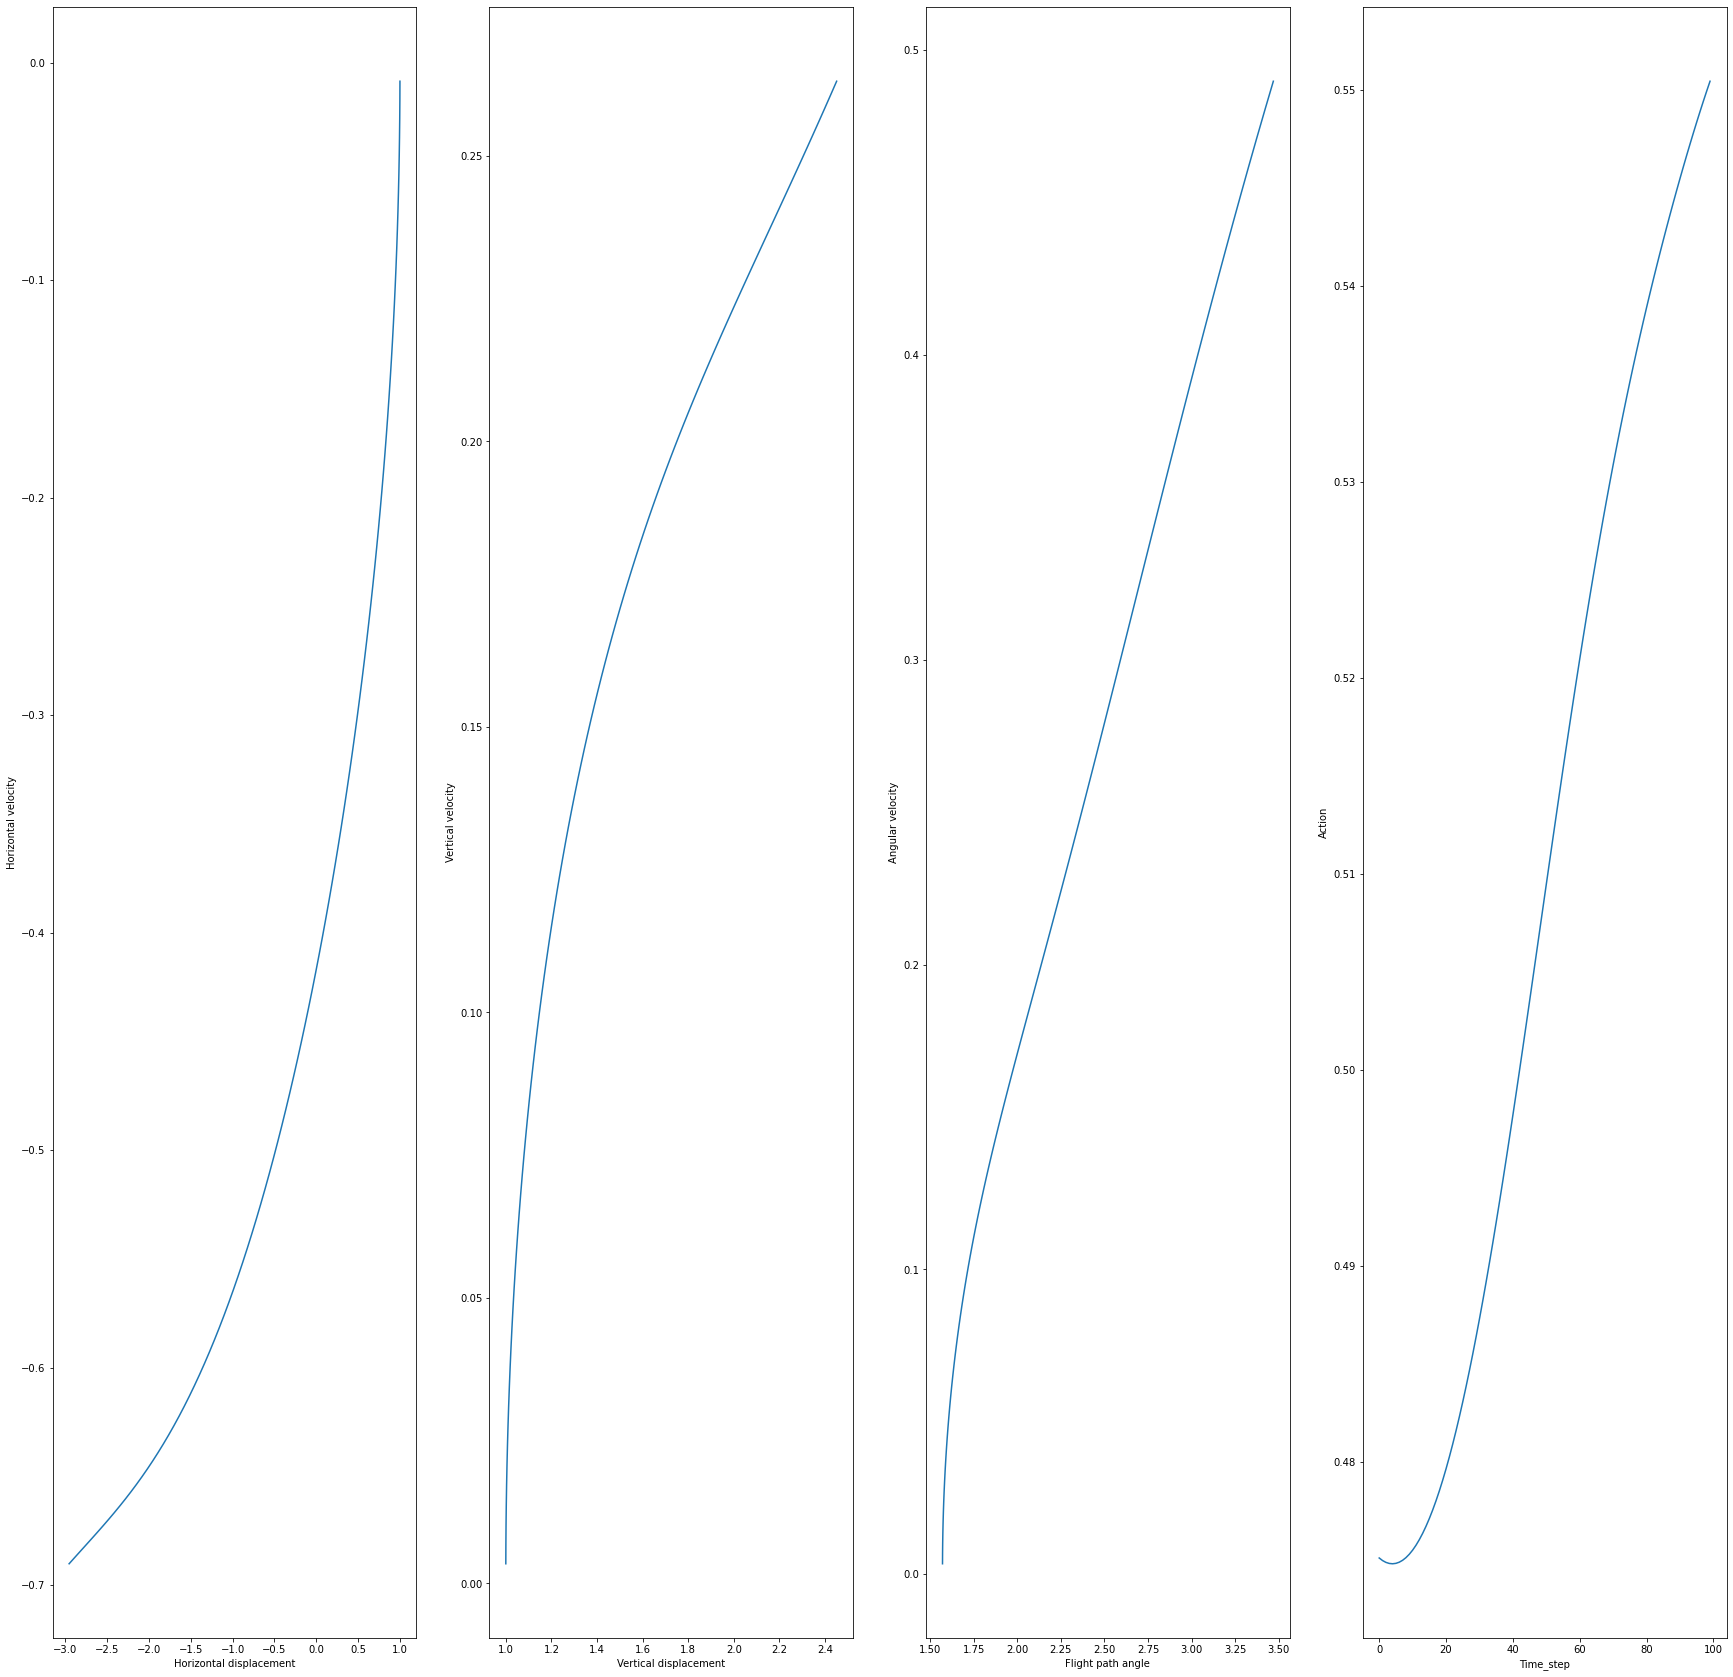

[2] loss: 26.126


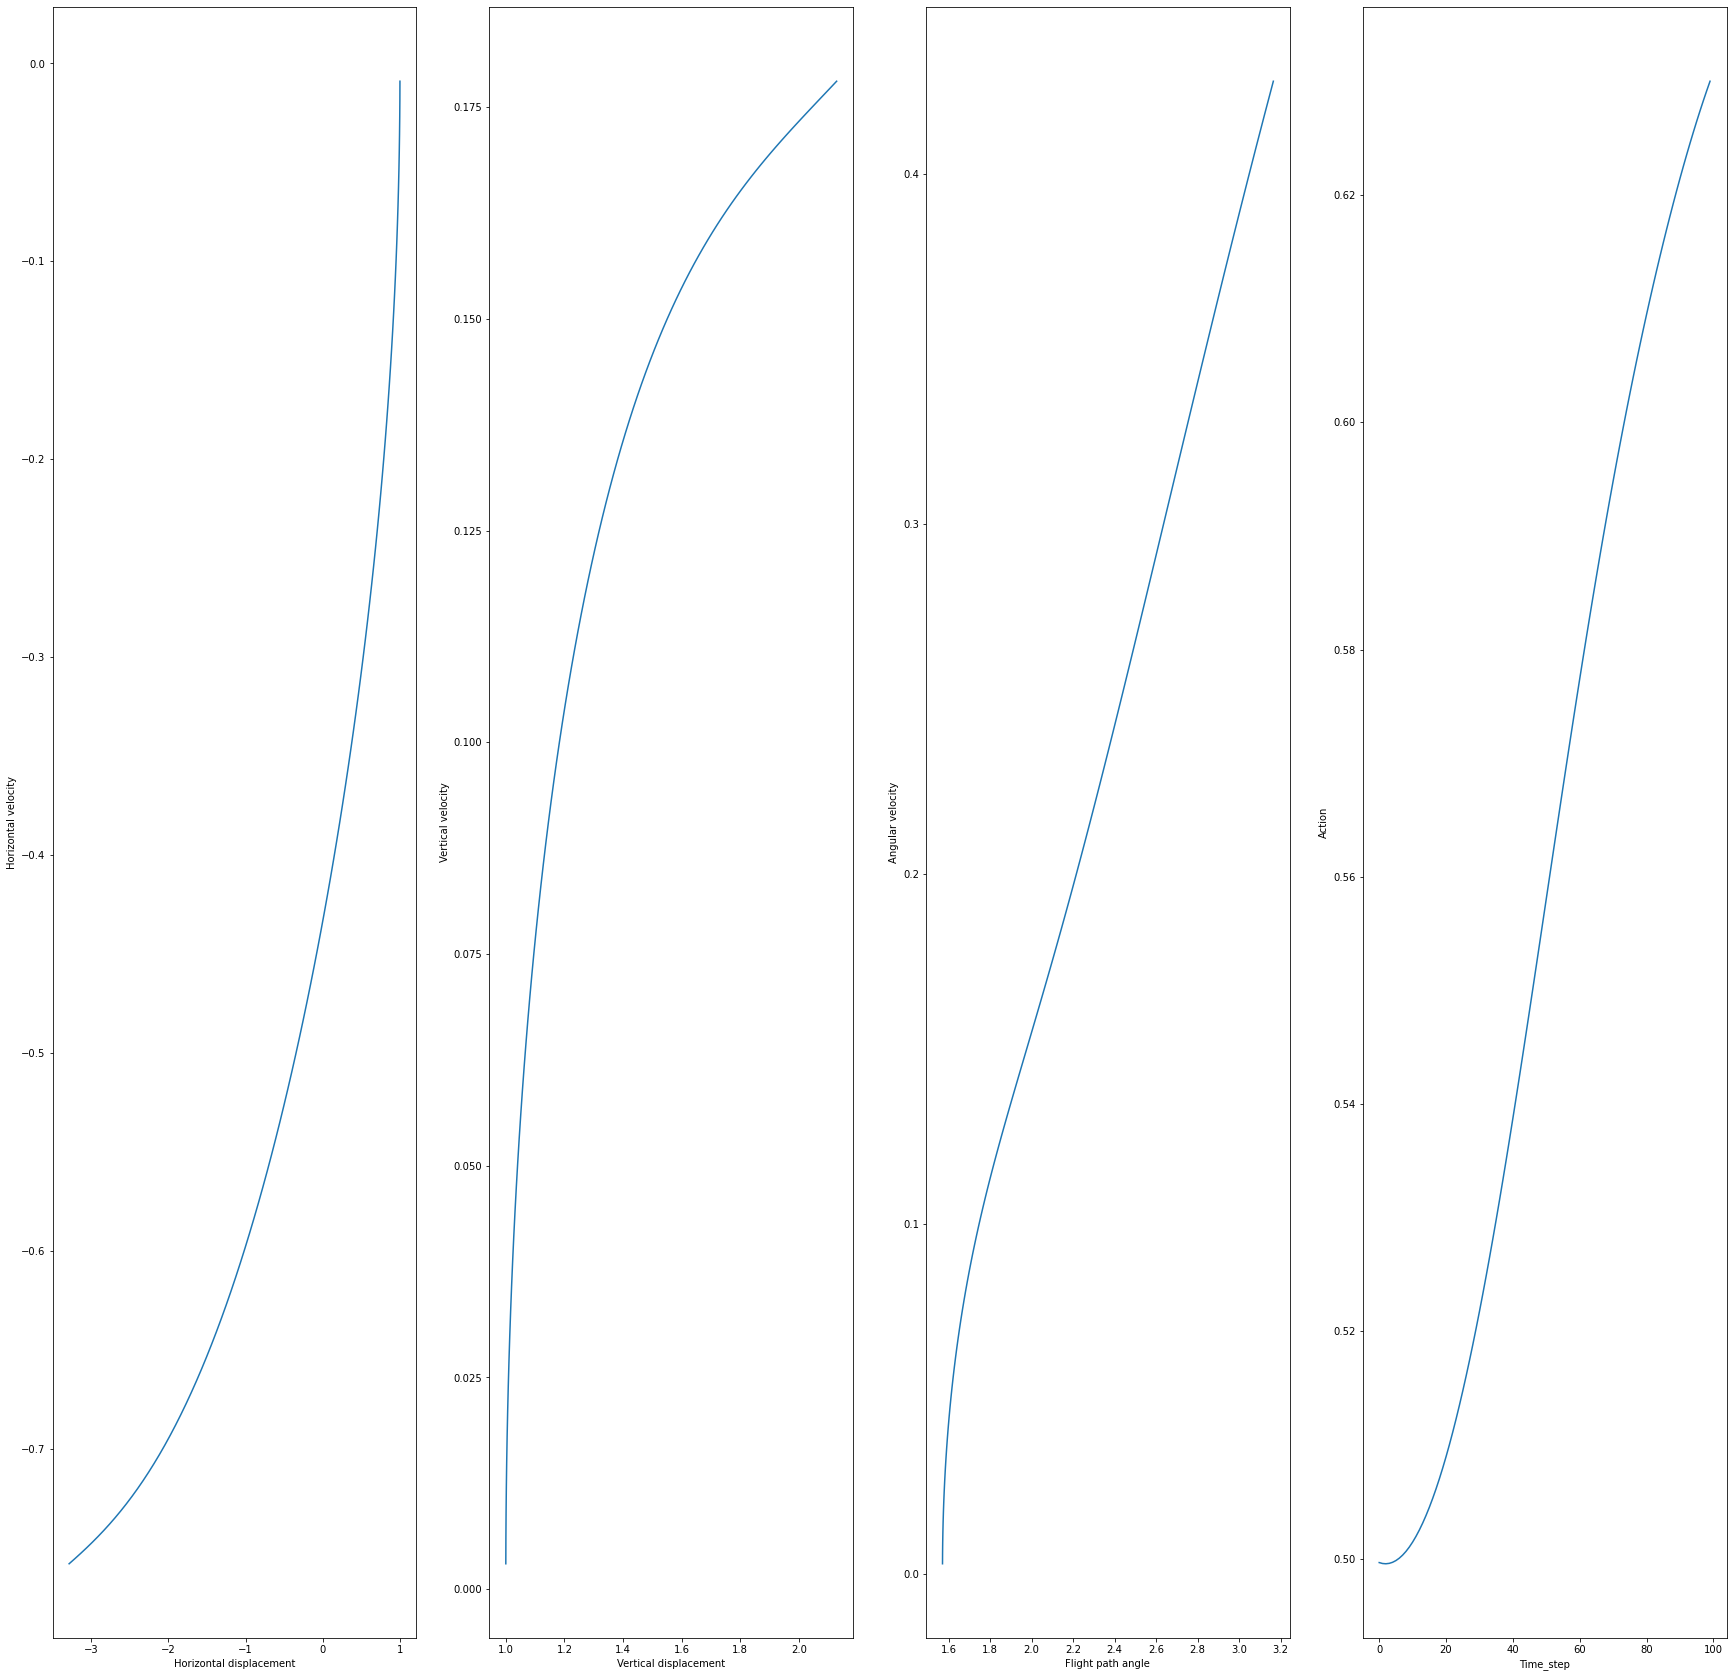

[3] loss: 25.647


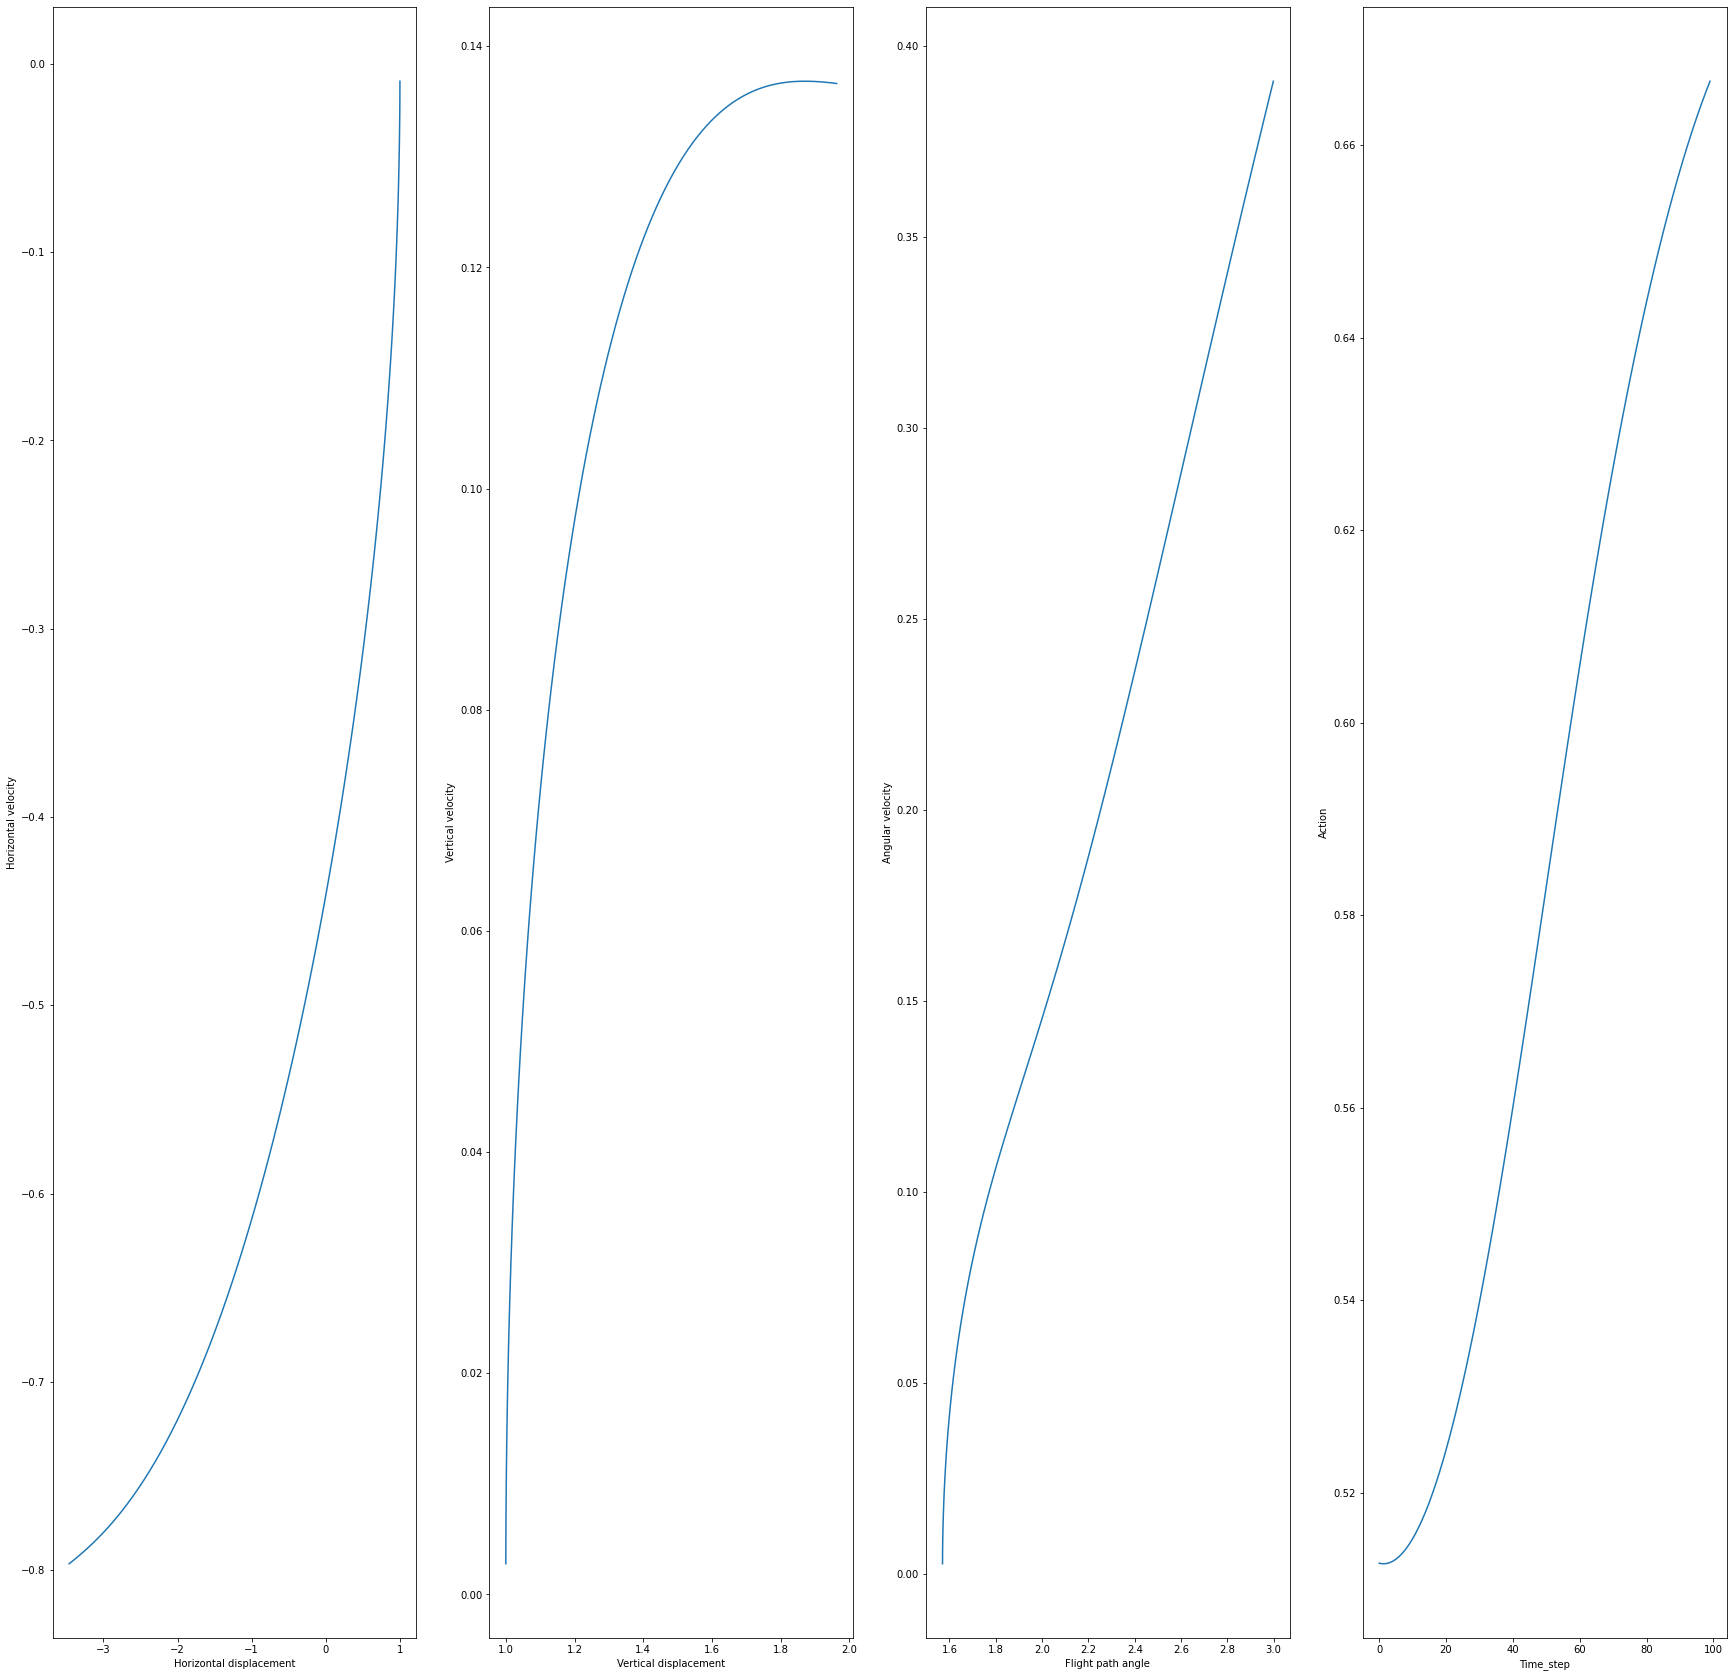

[4] loss: 25.446


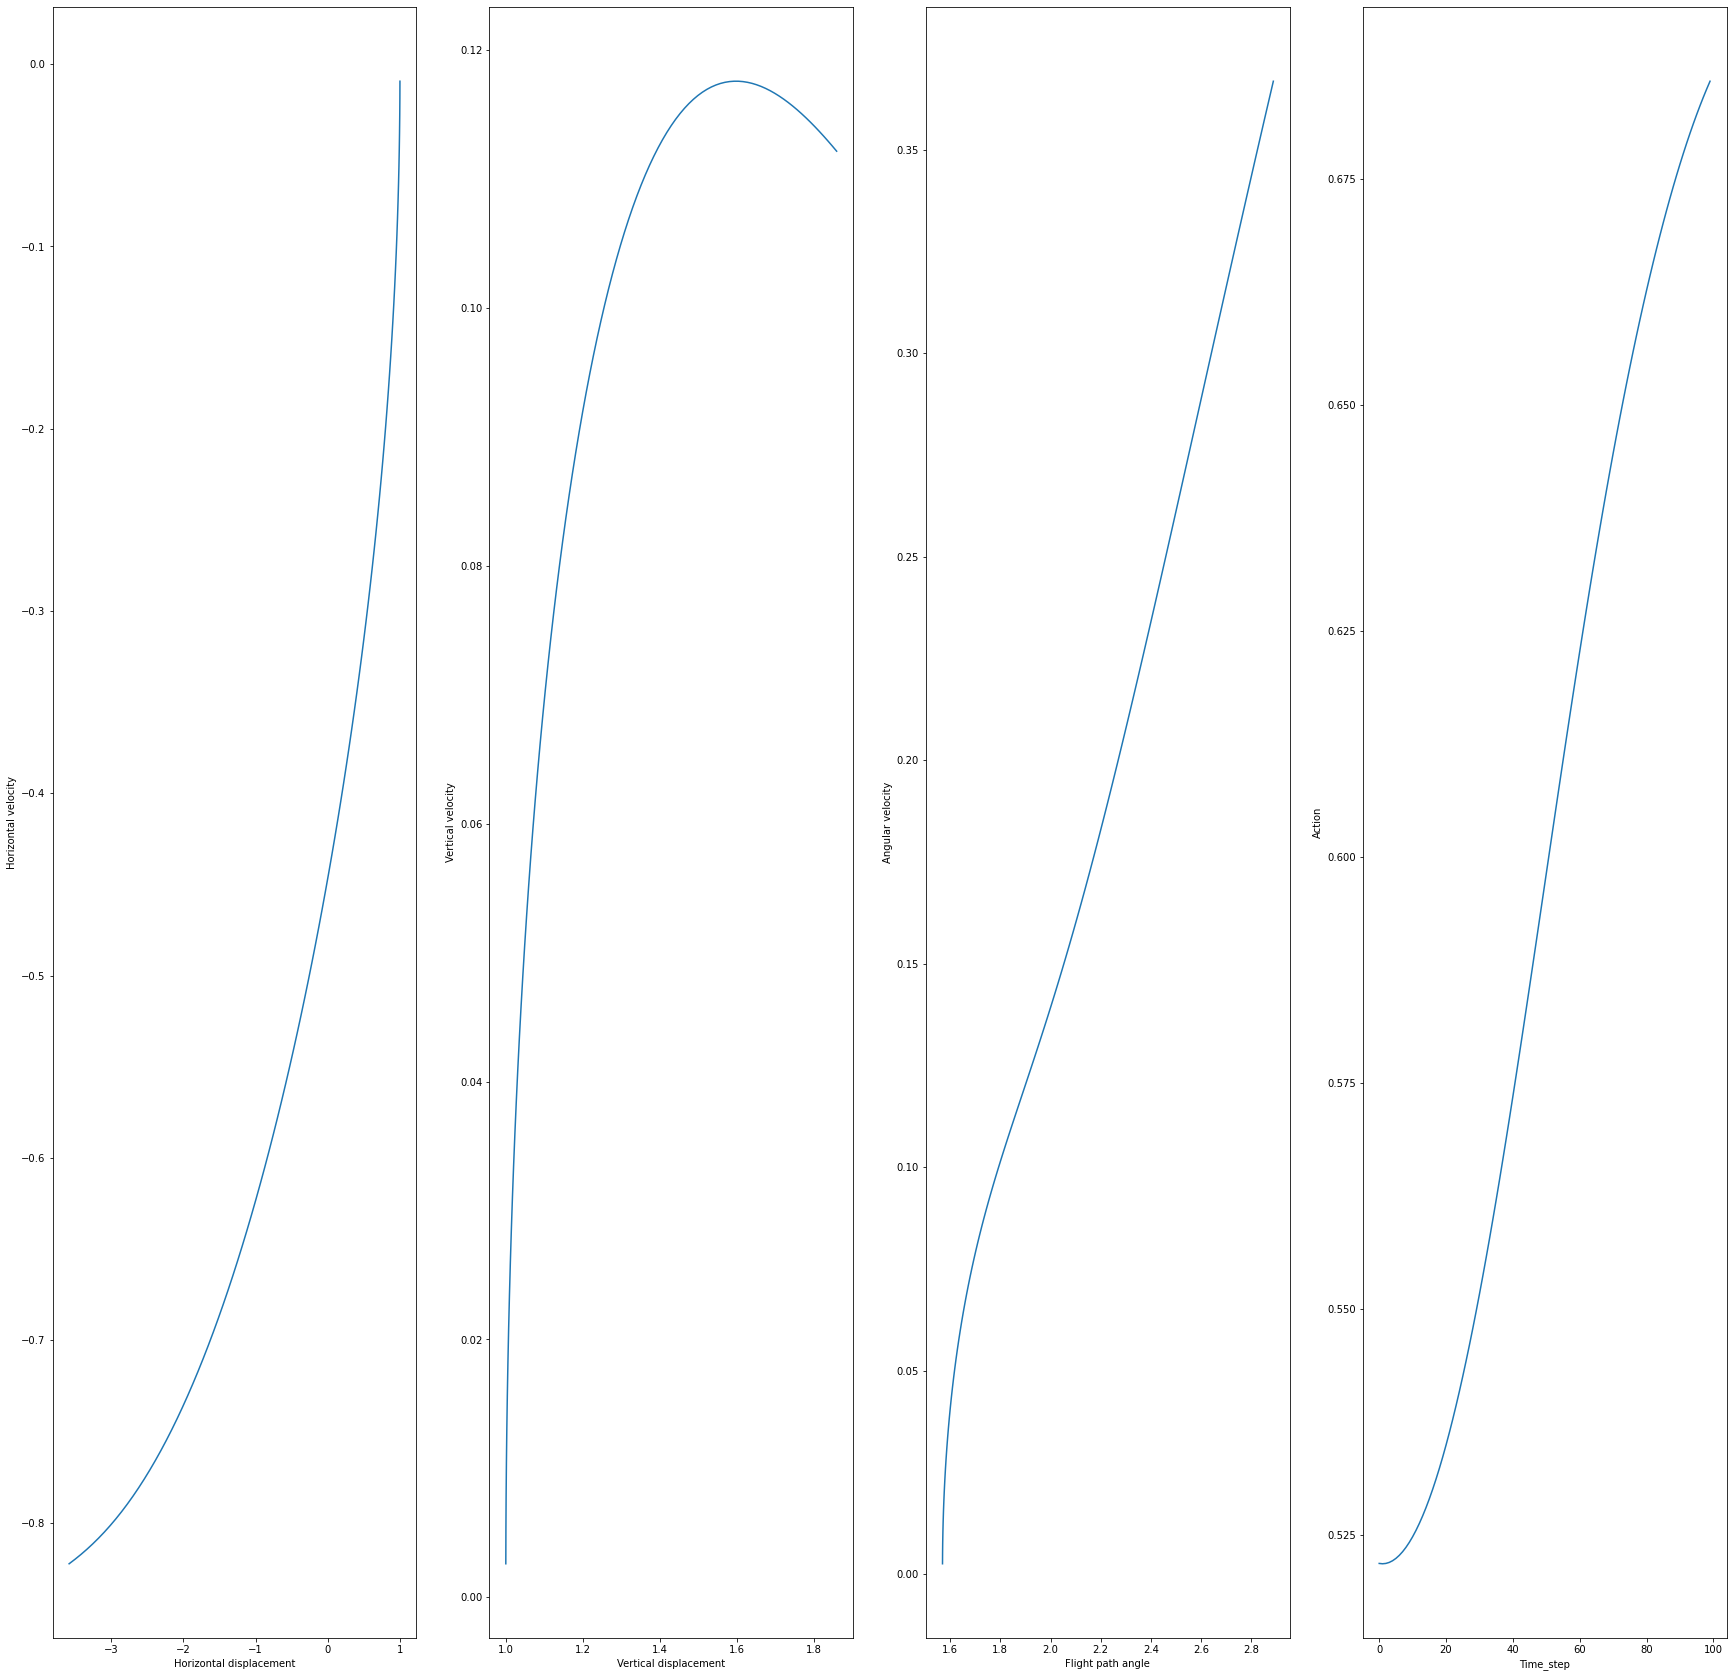

[5] loss: 25.360


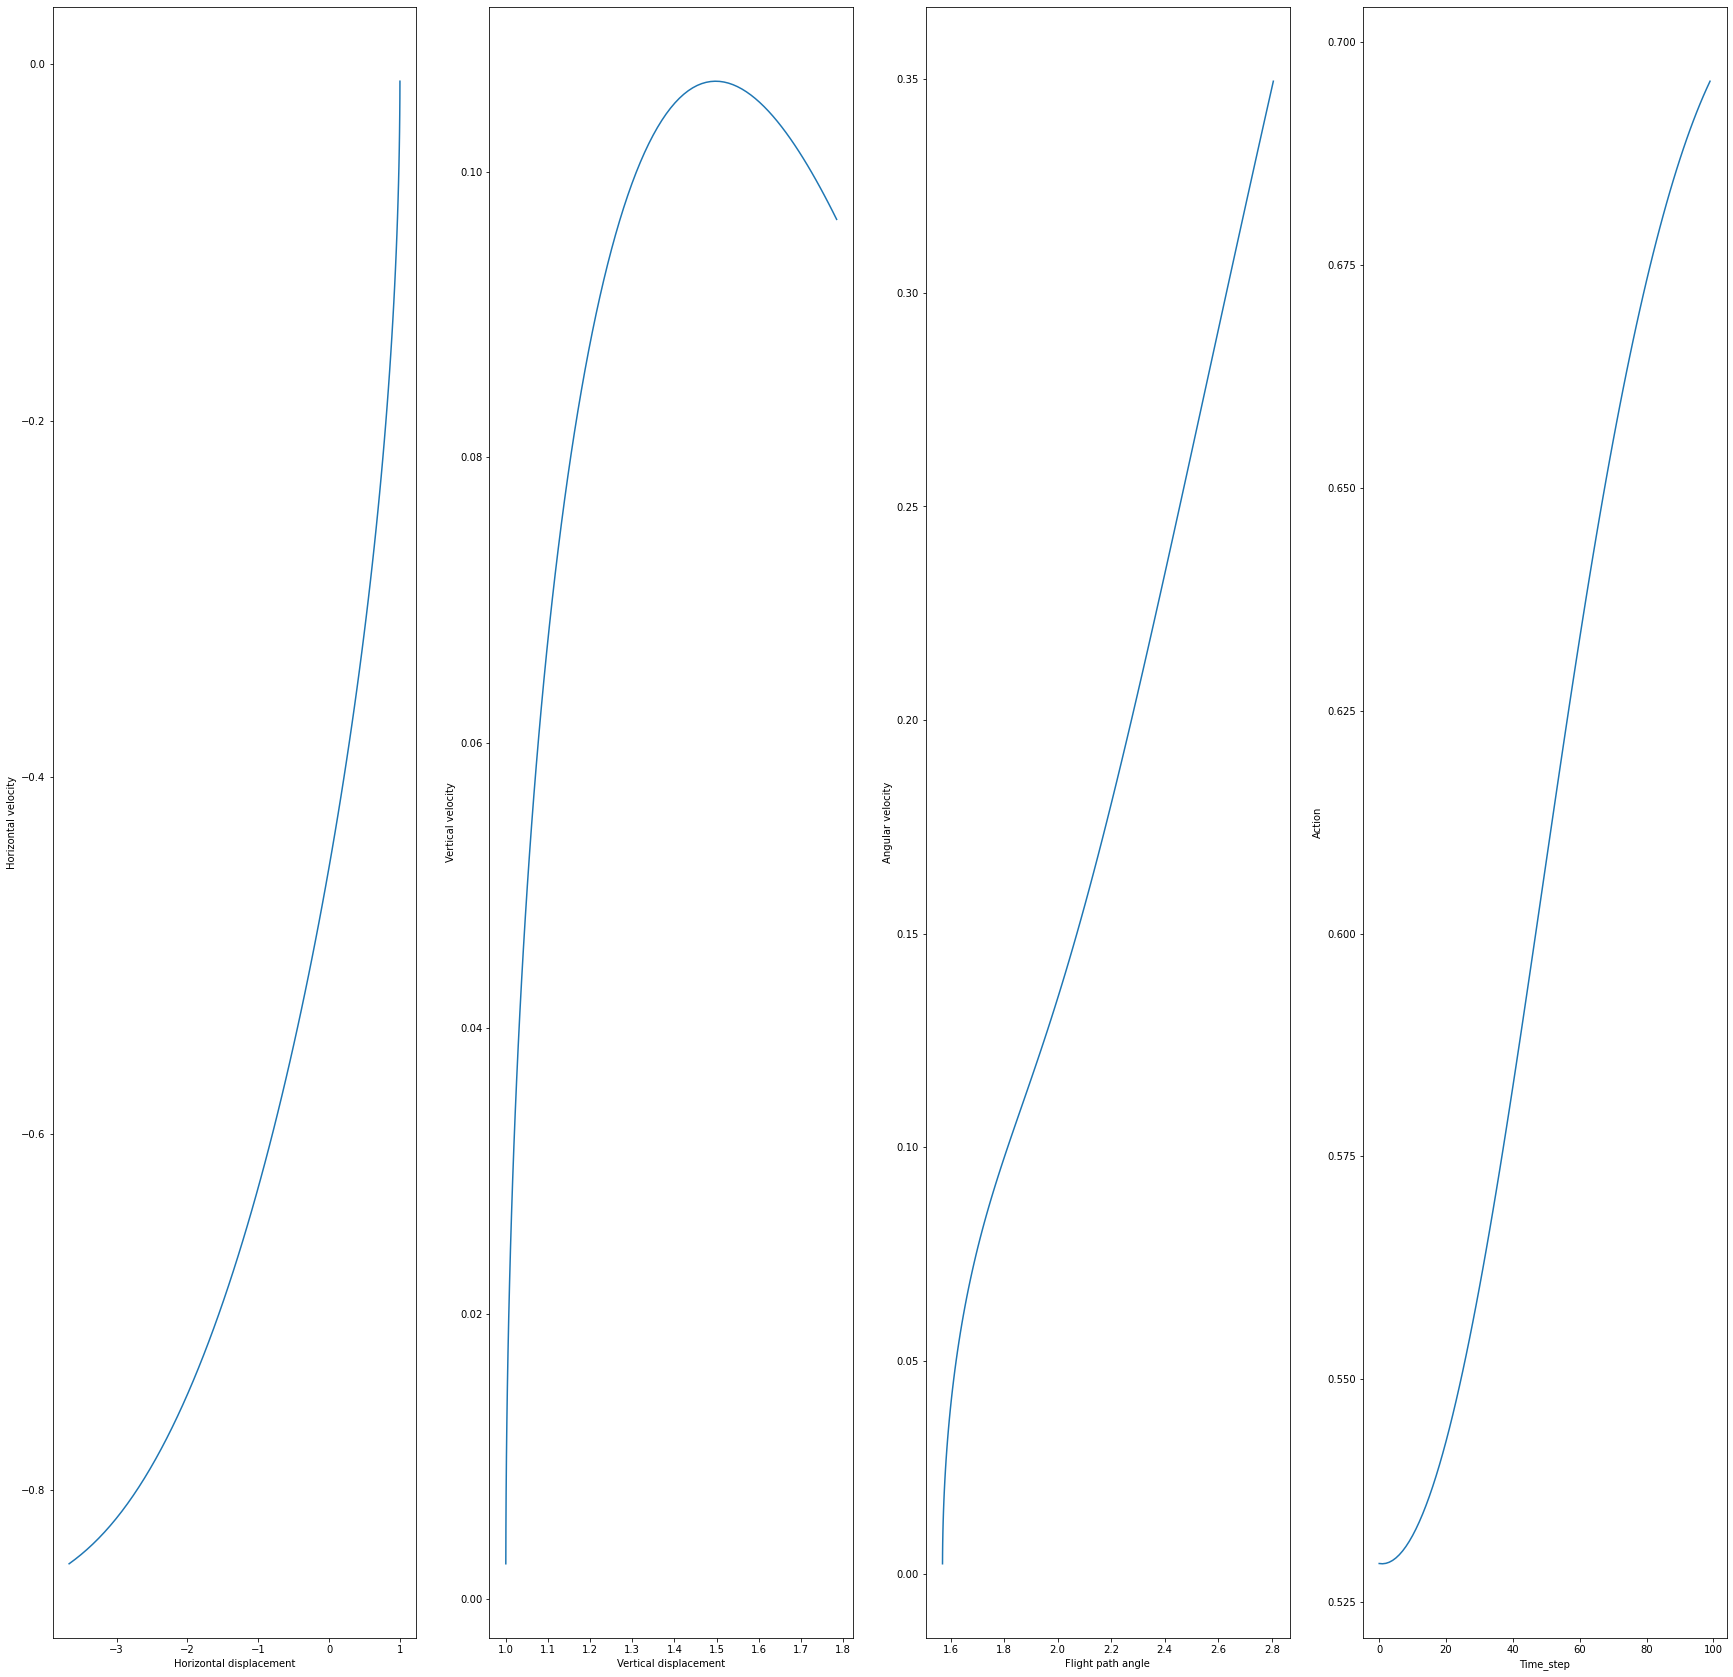

[6] loss: 25.329


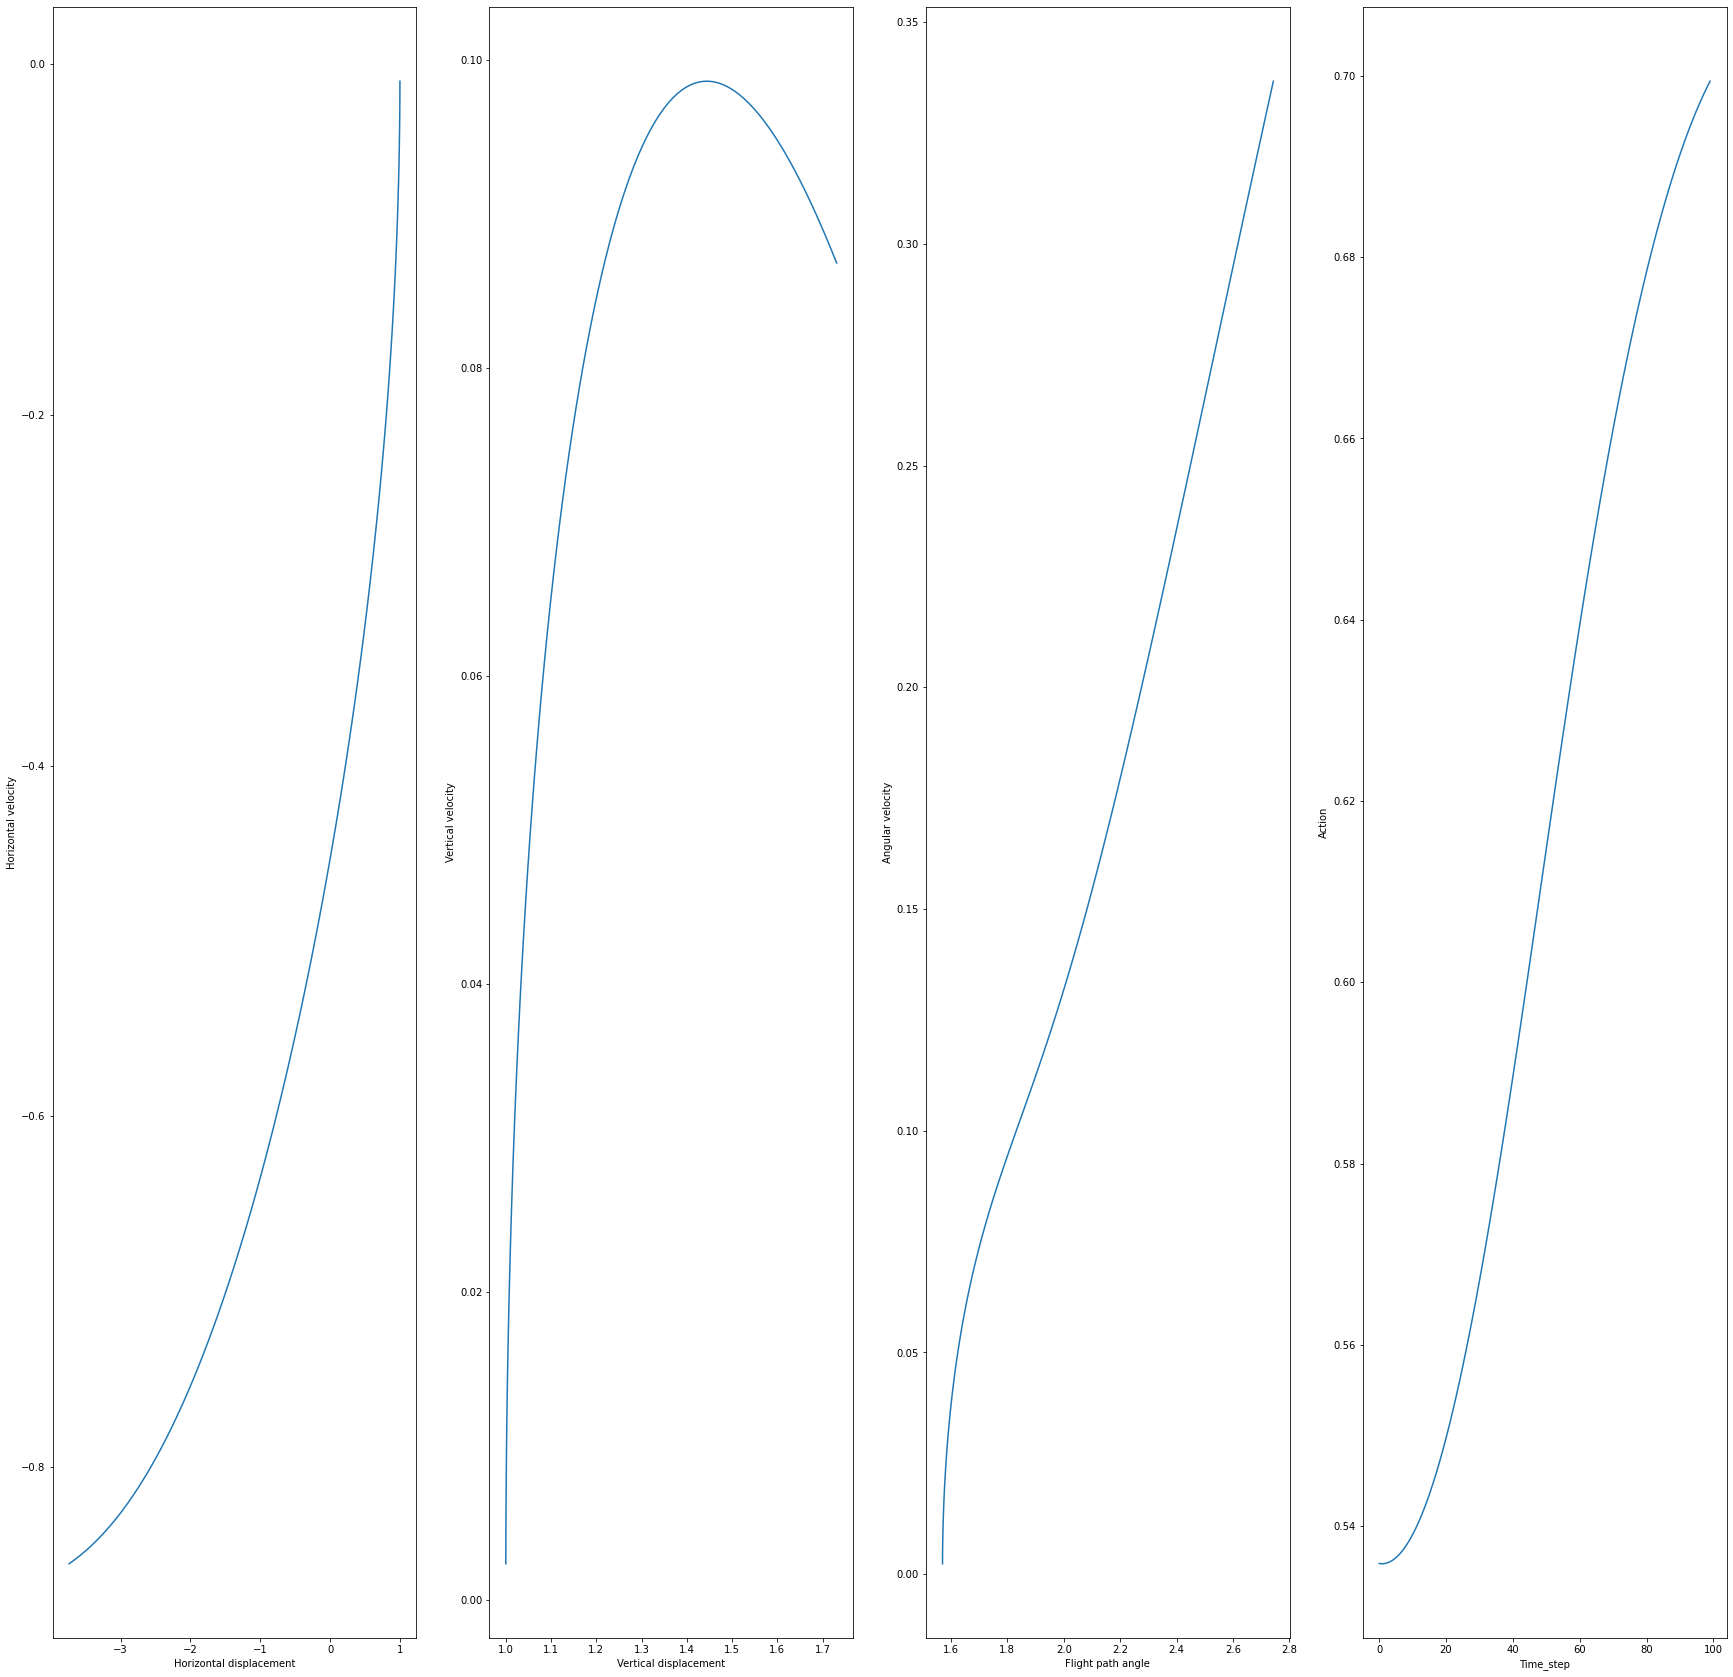

[7] loss: 25.328


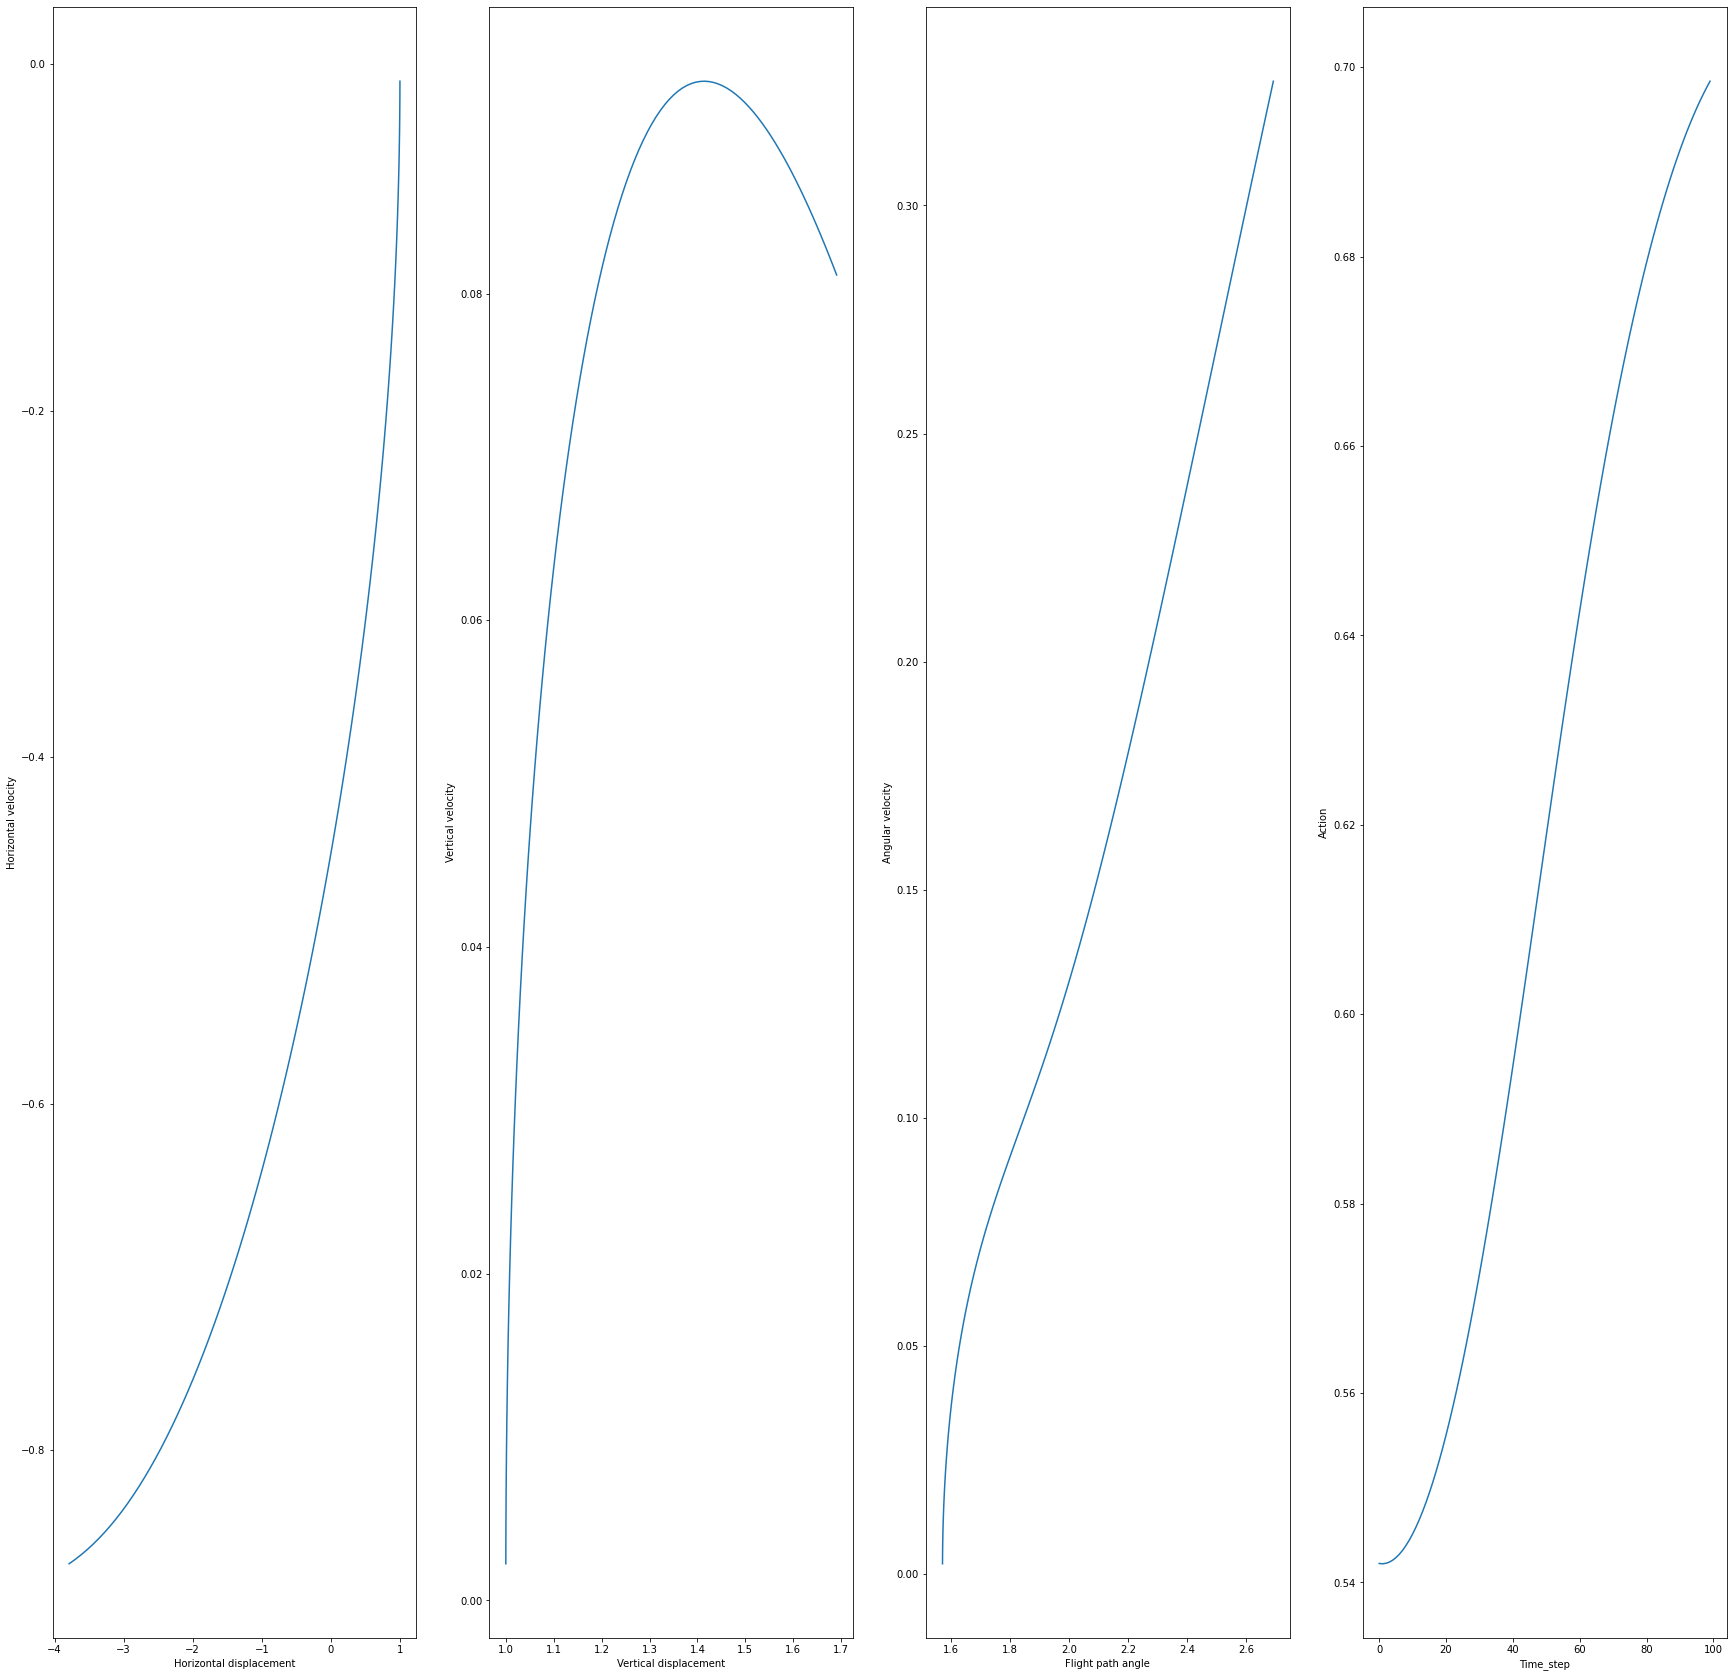

[8] loss: 25.346


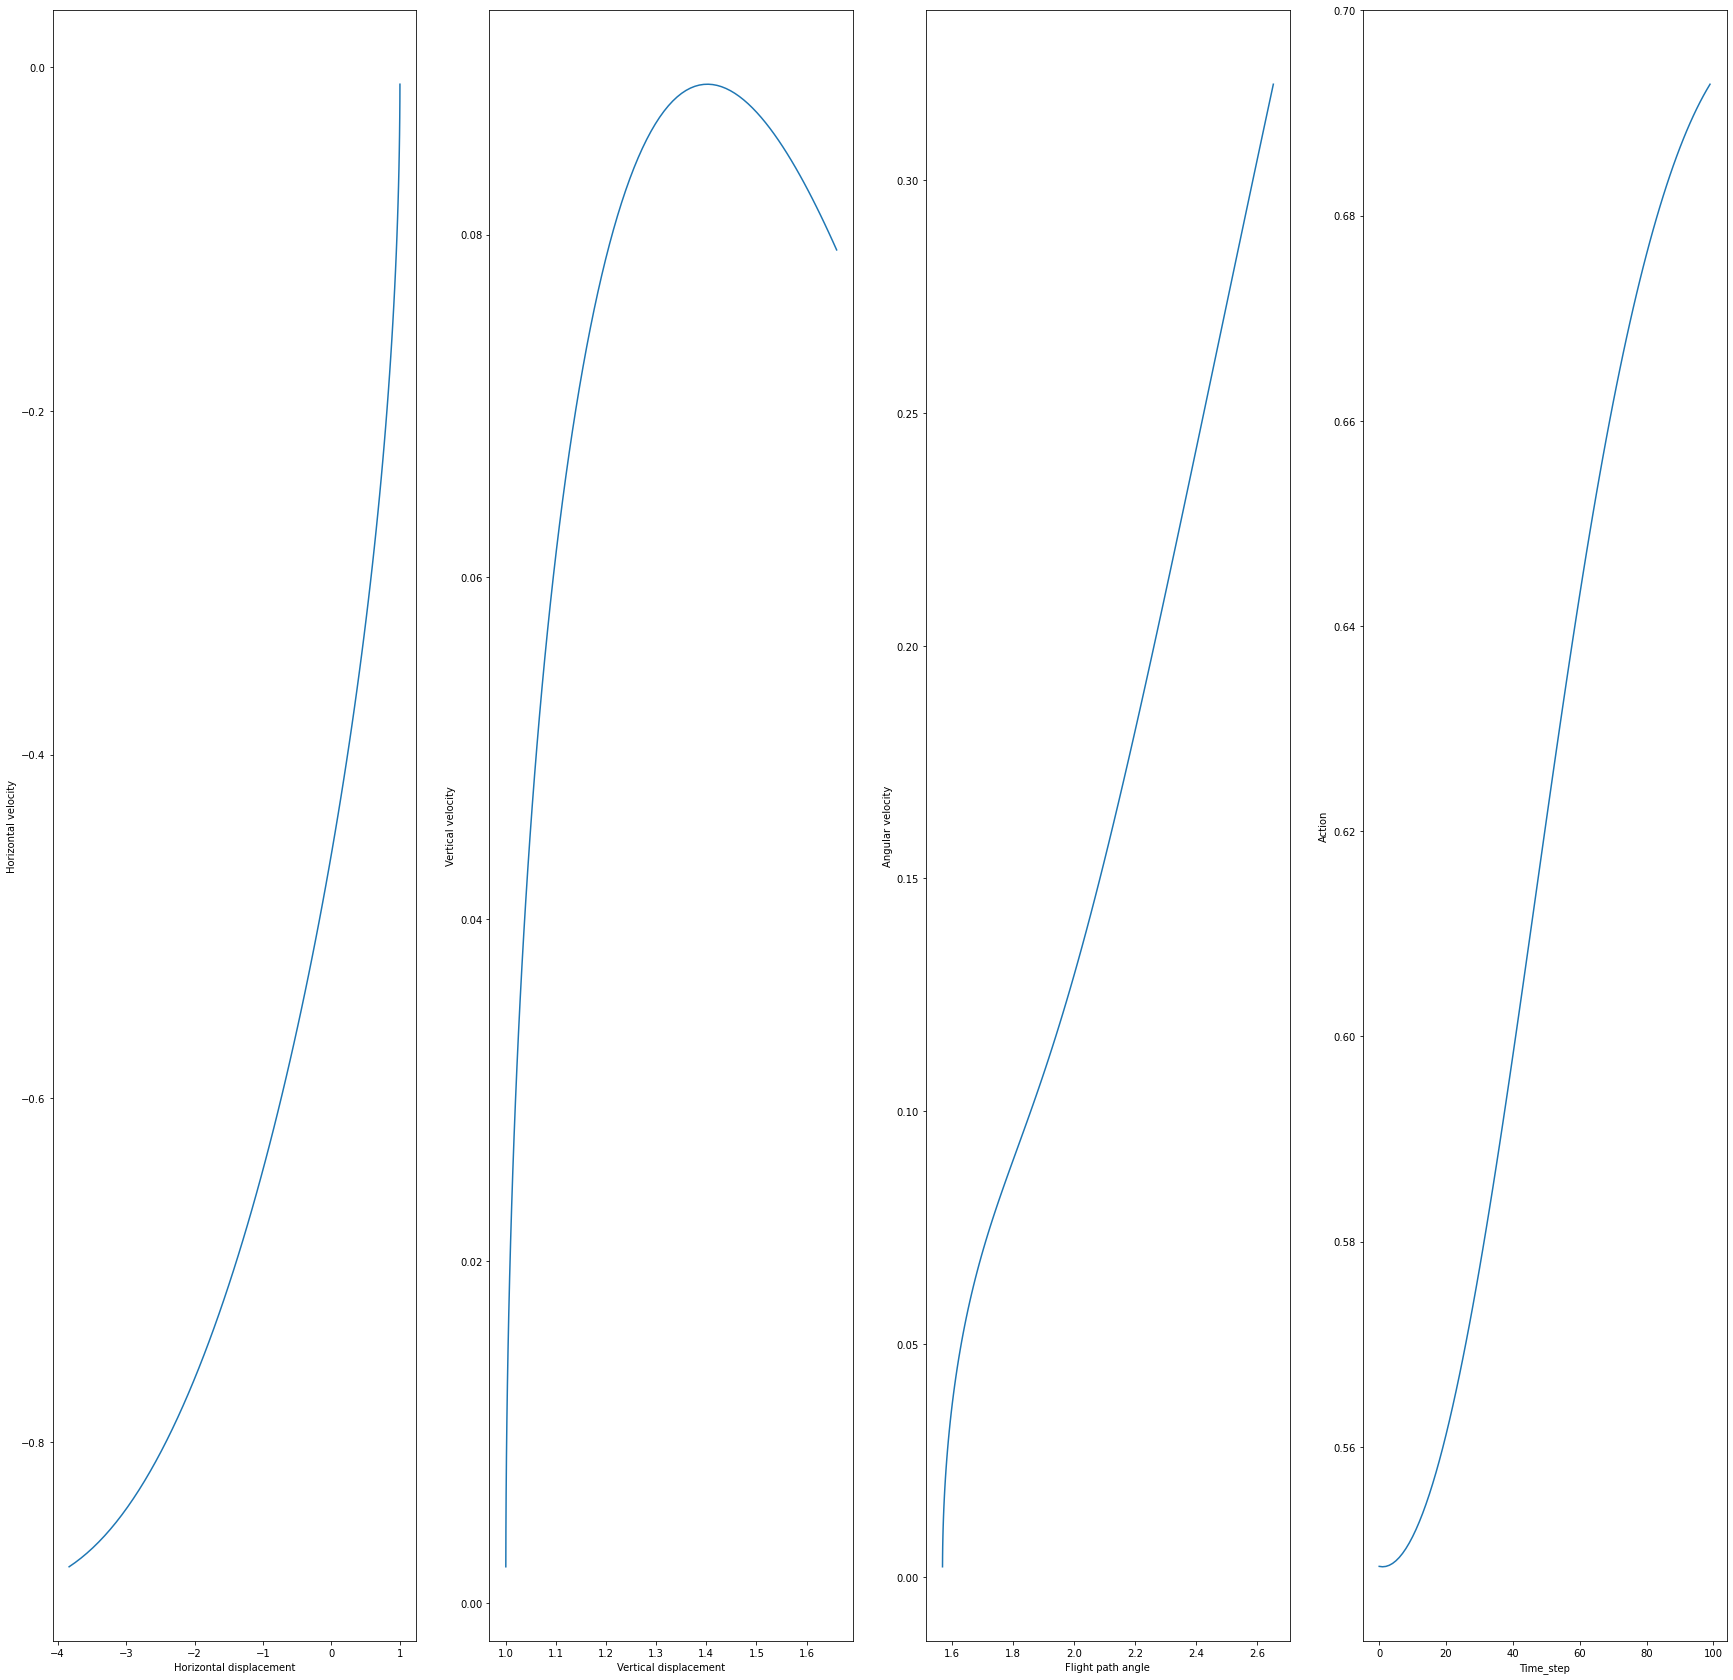

[9] loss: 25.380


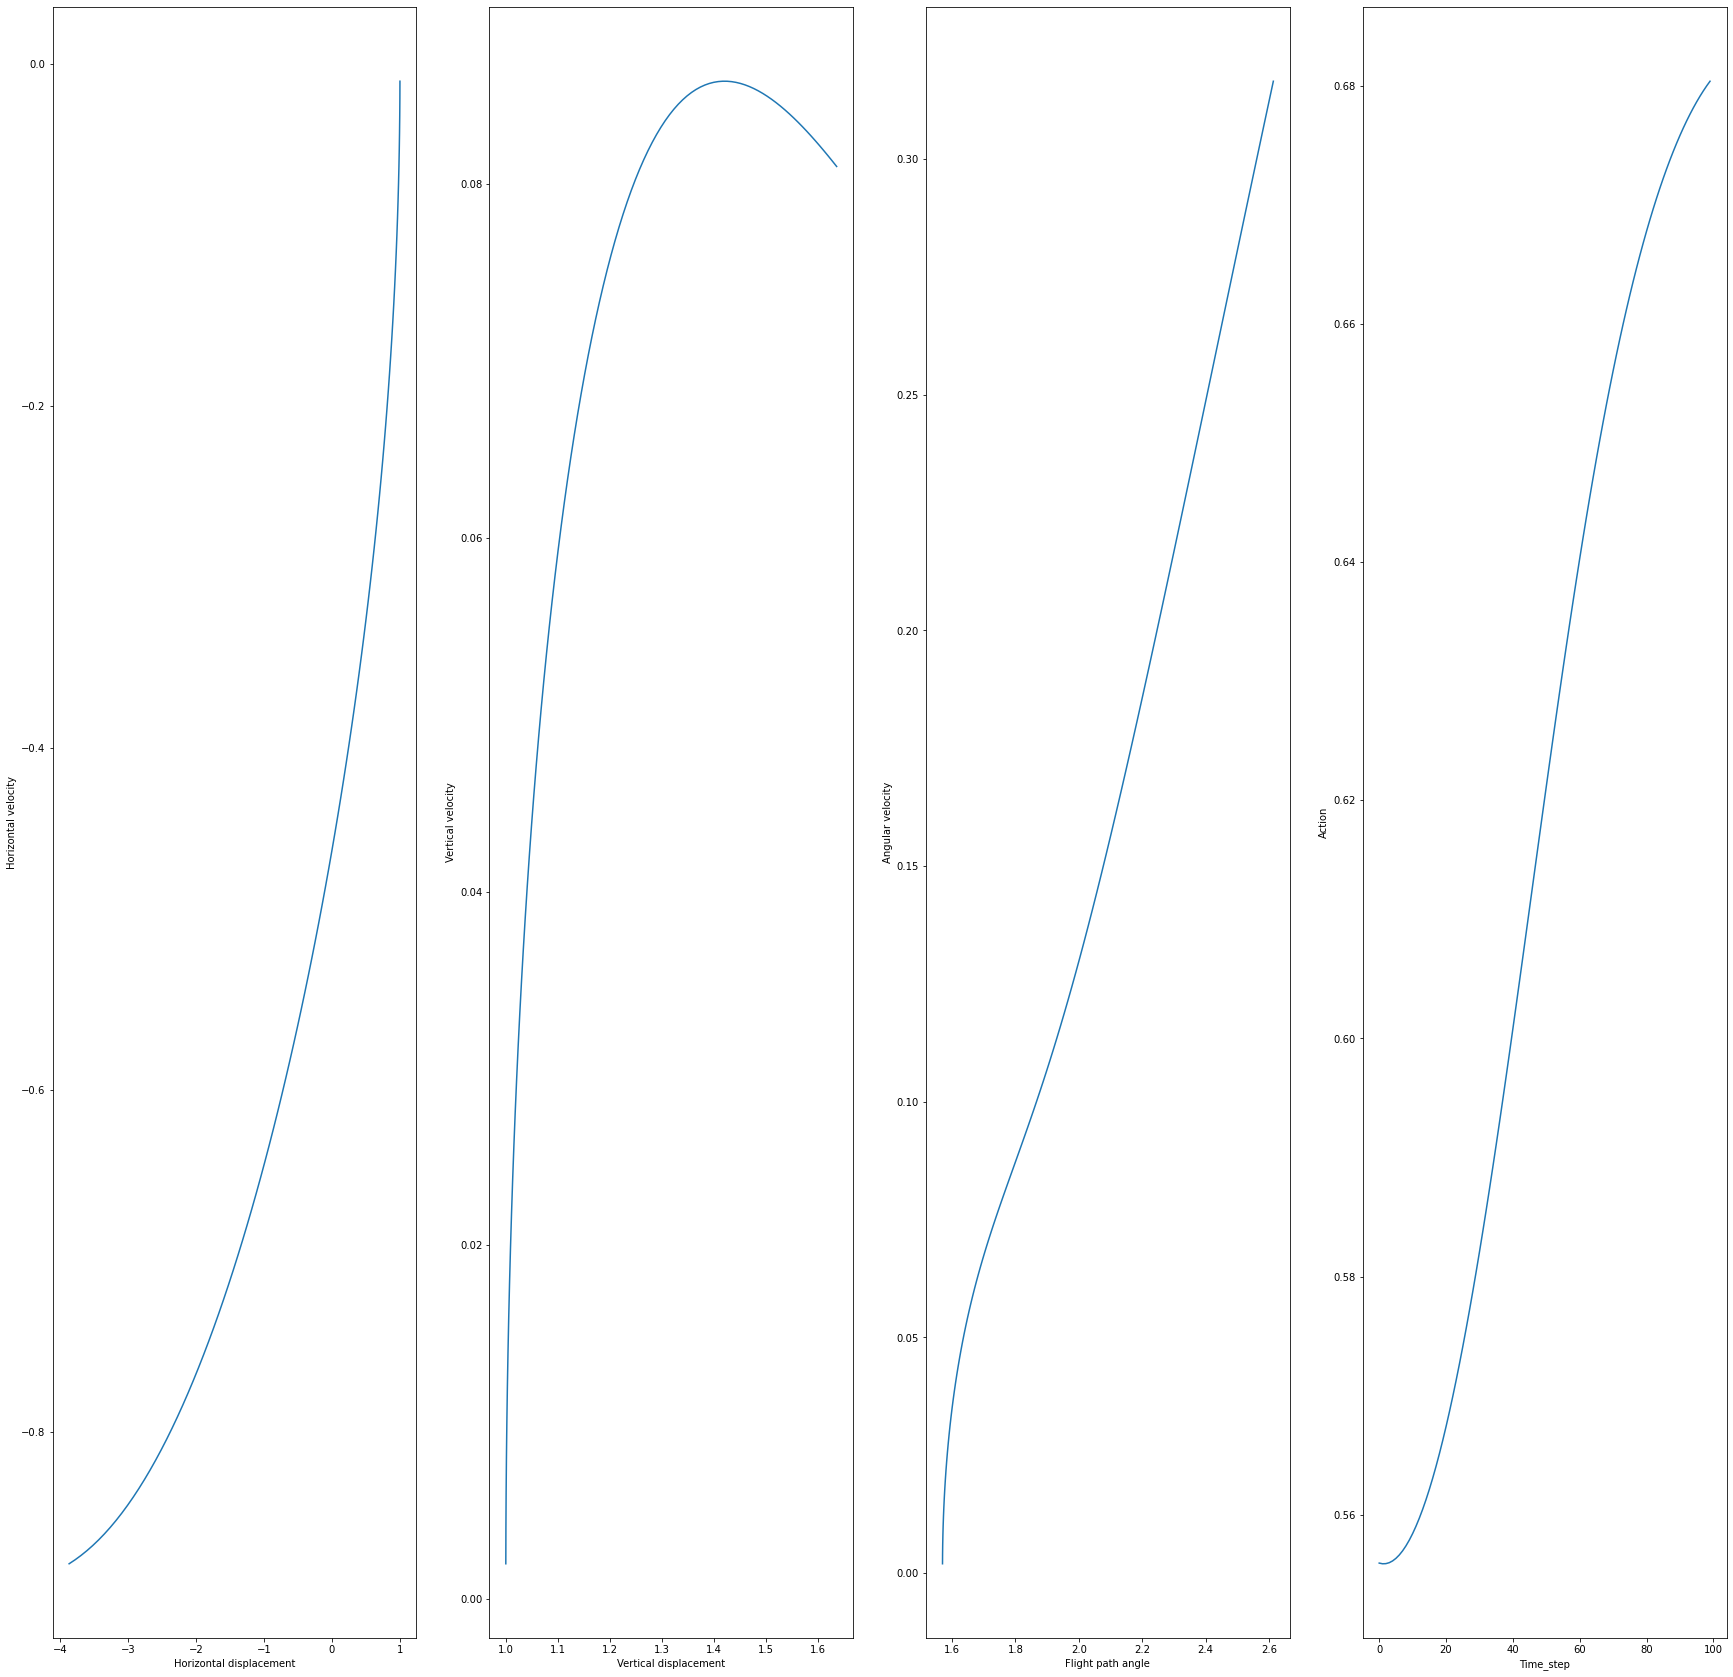

[10] loss: 25.439


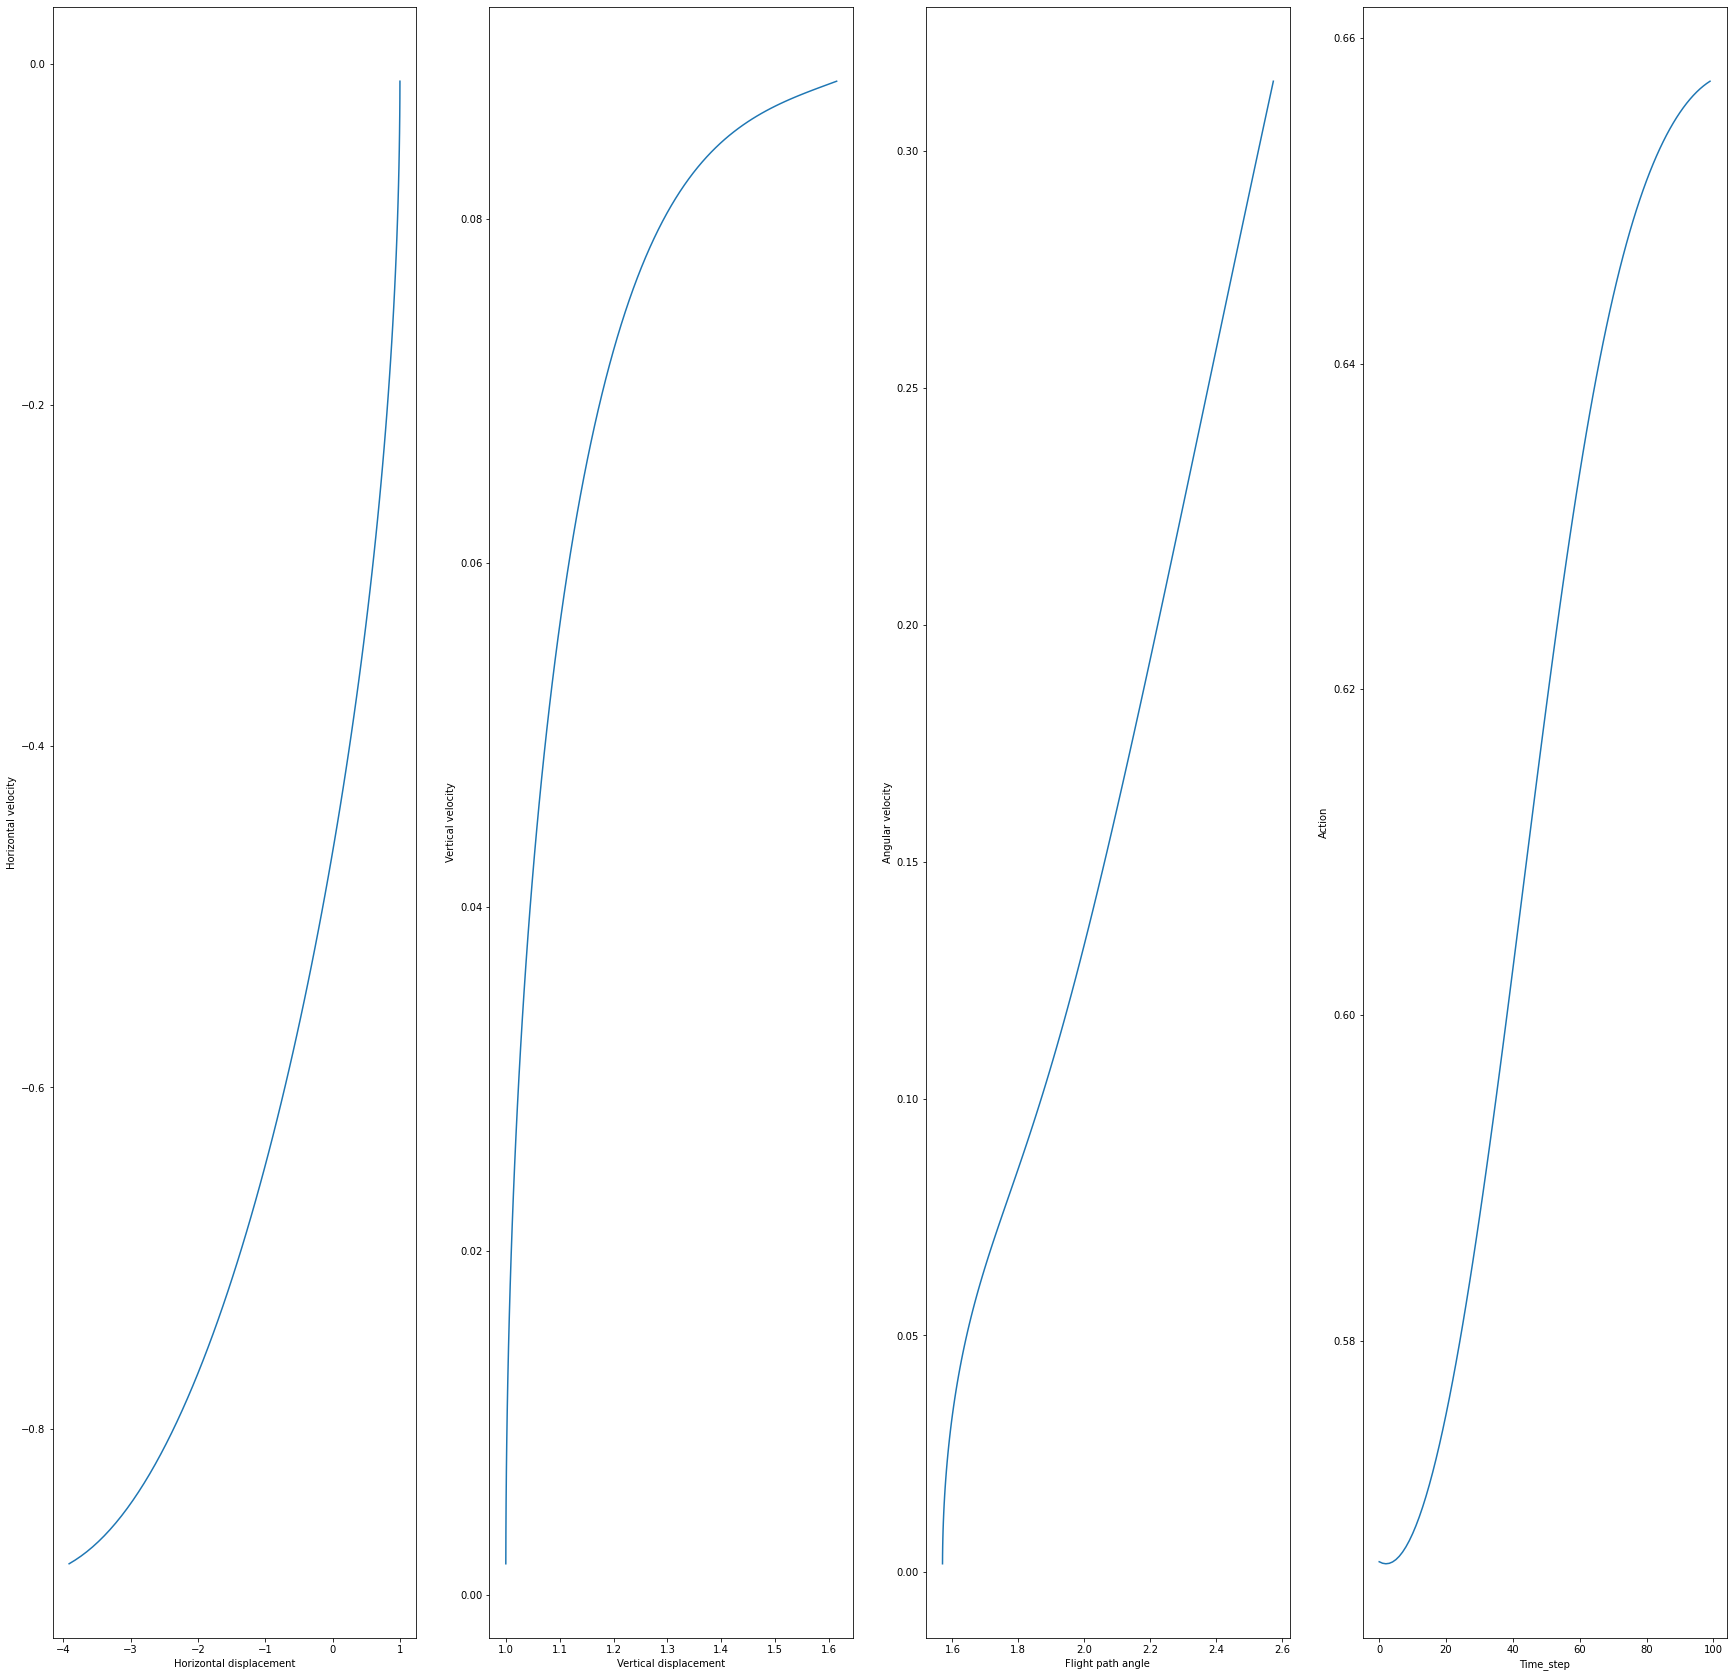

[11] loss: 25.528


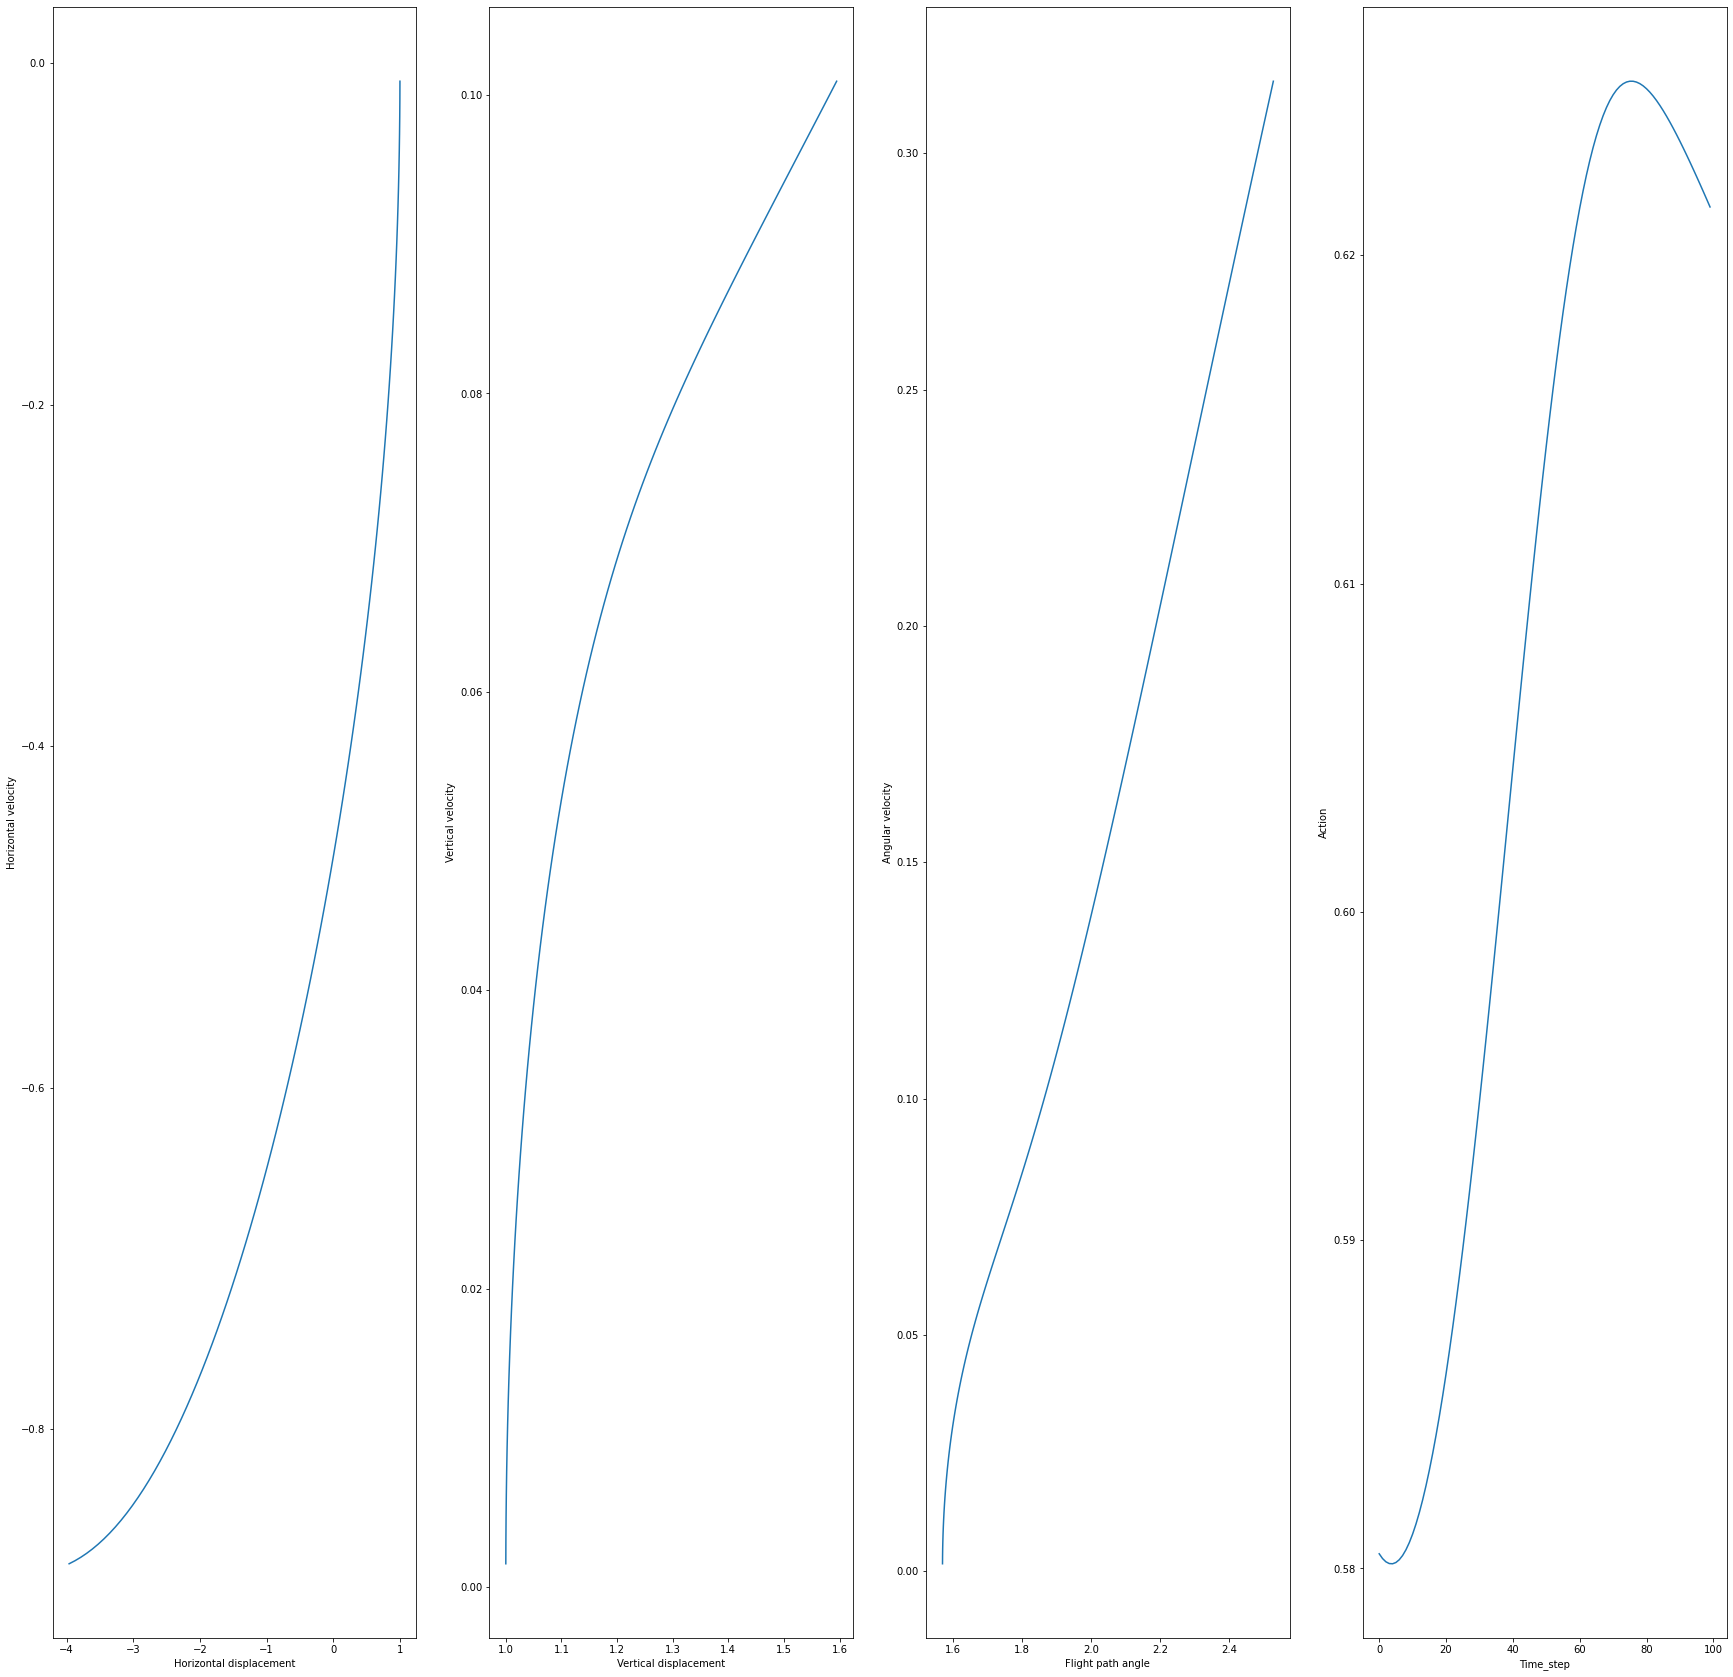

[12] loss: 25.636


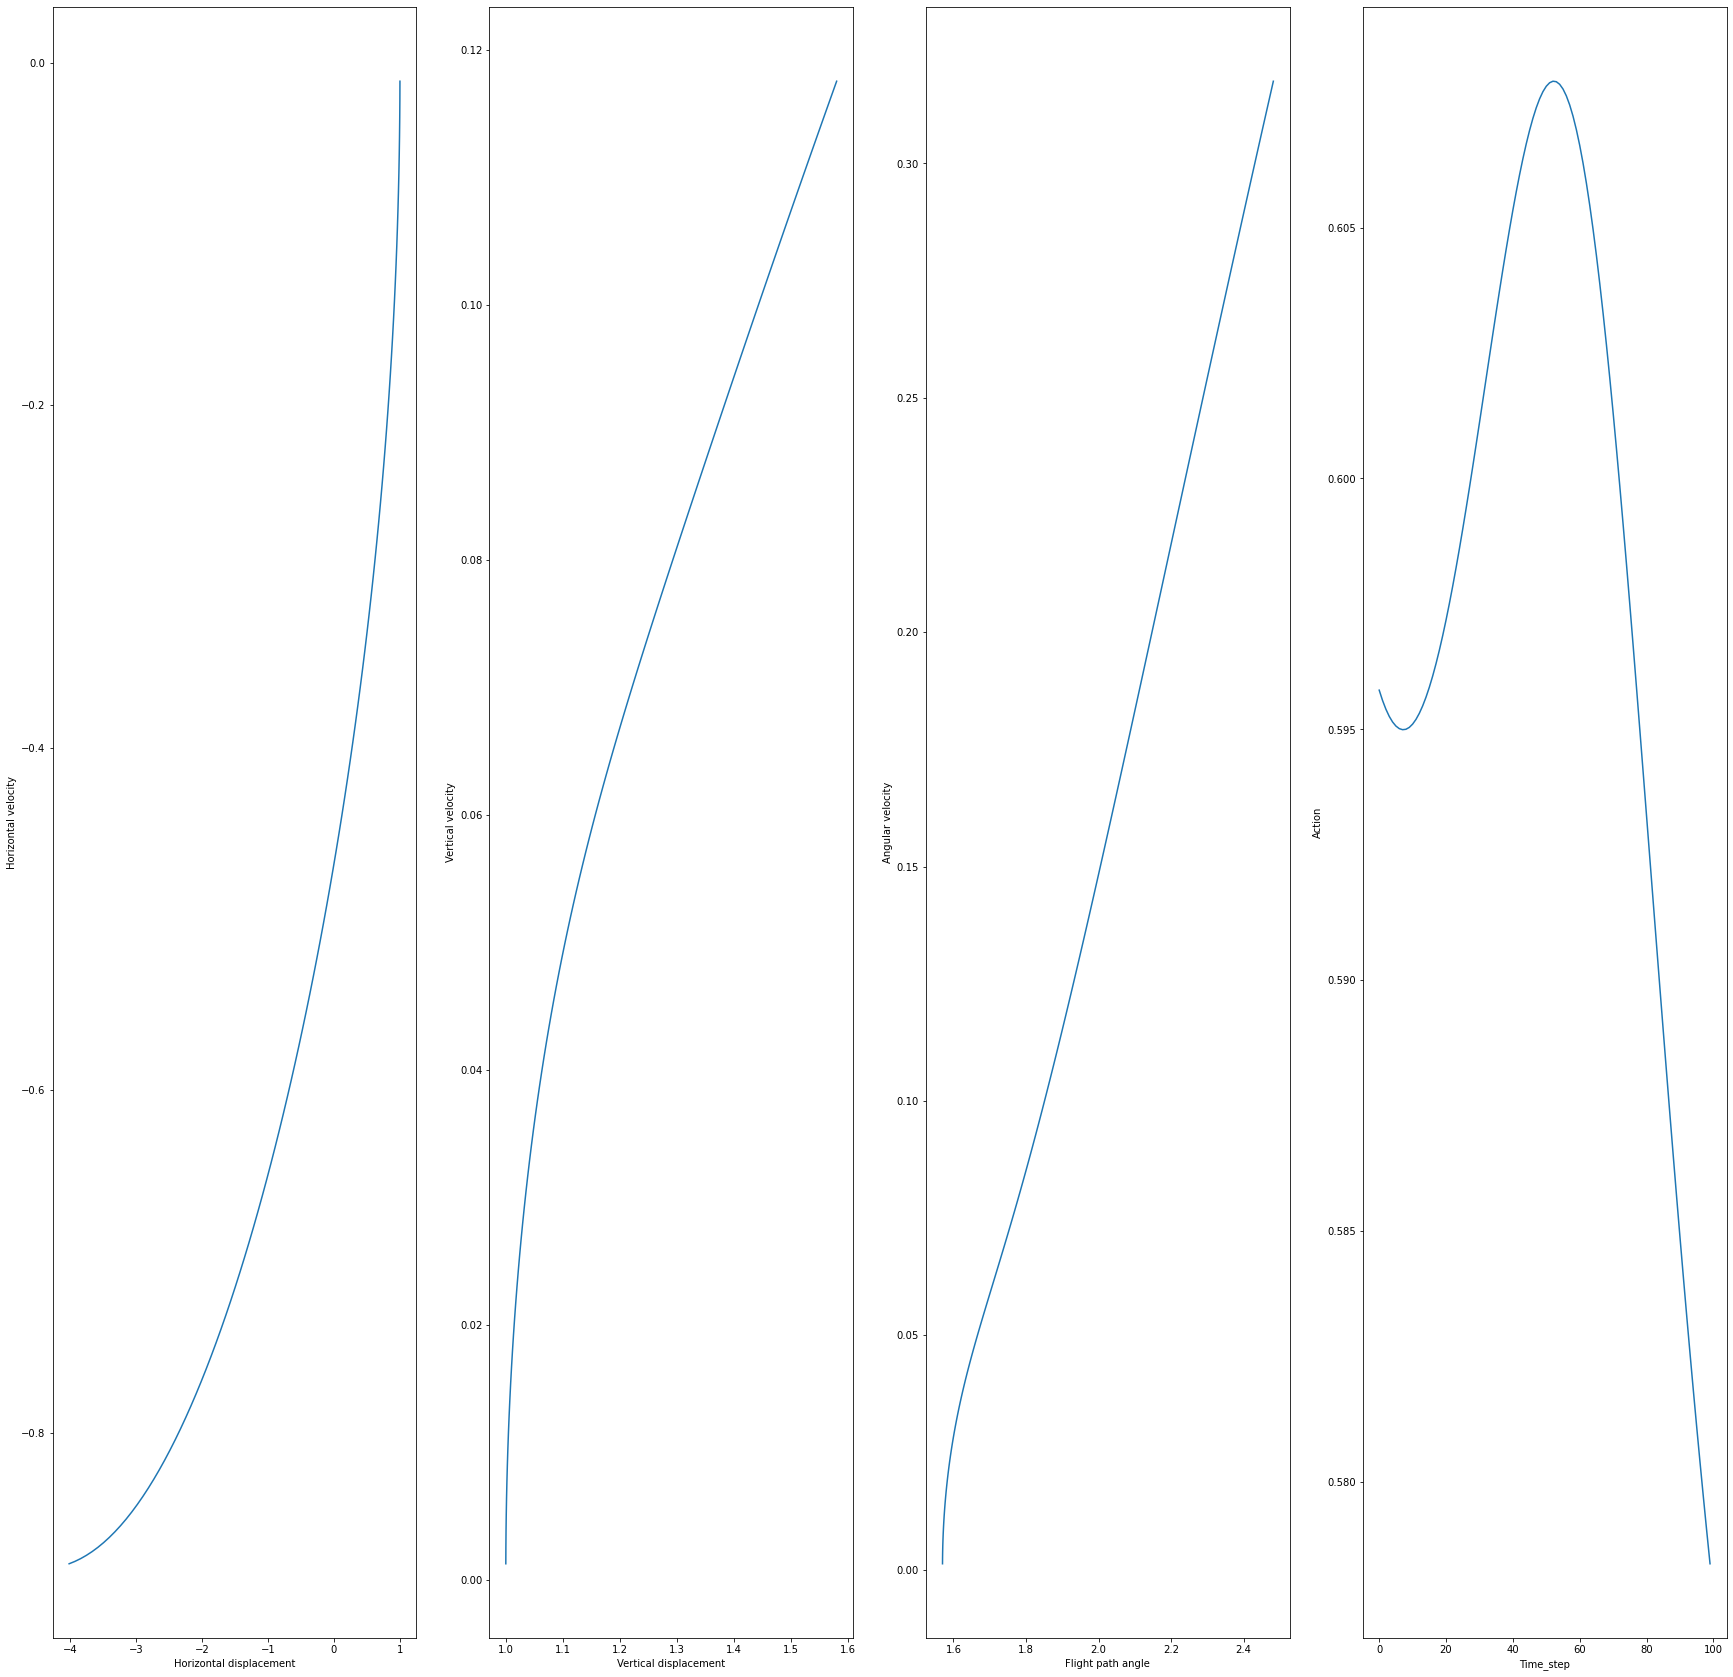

[13] loss: 25.831


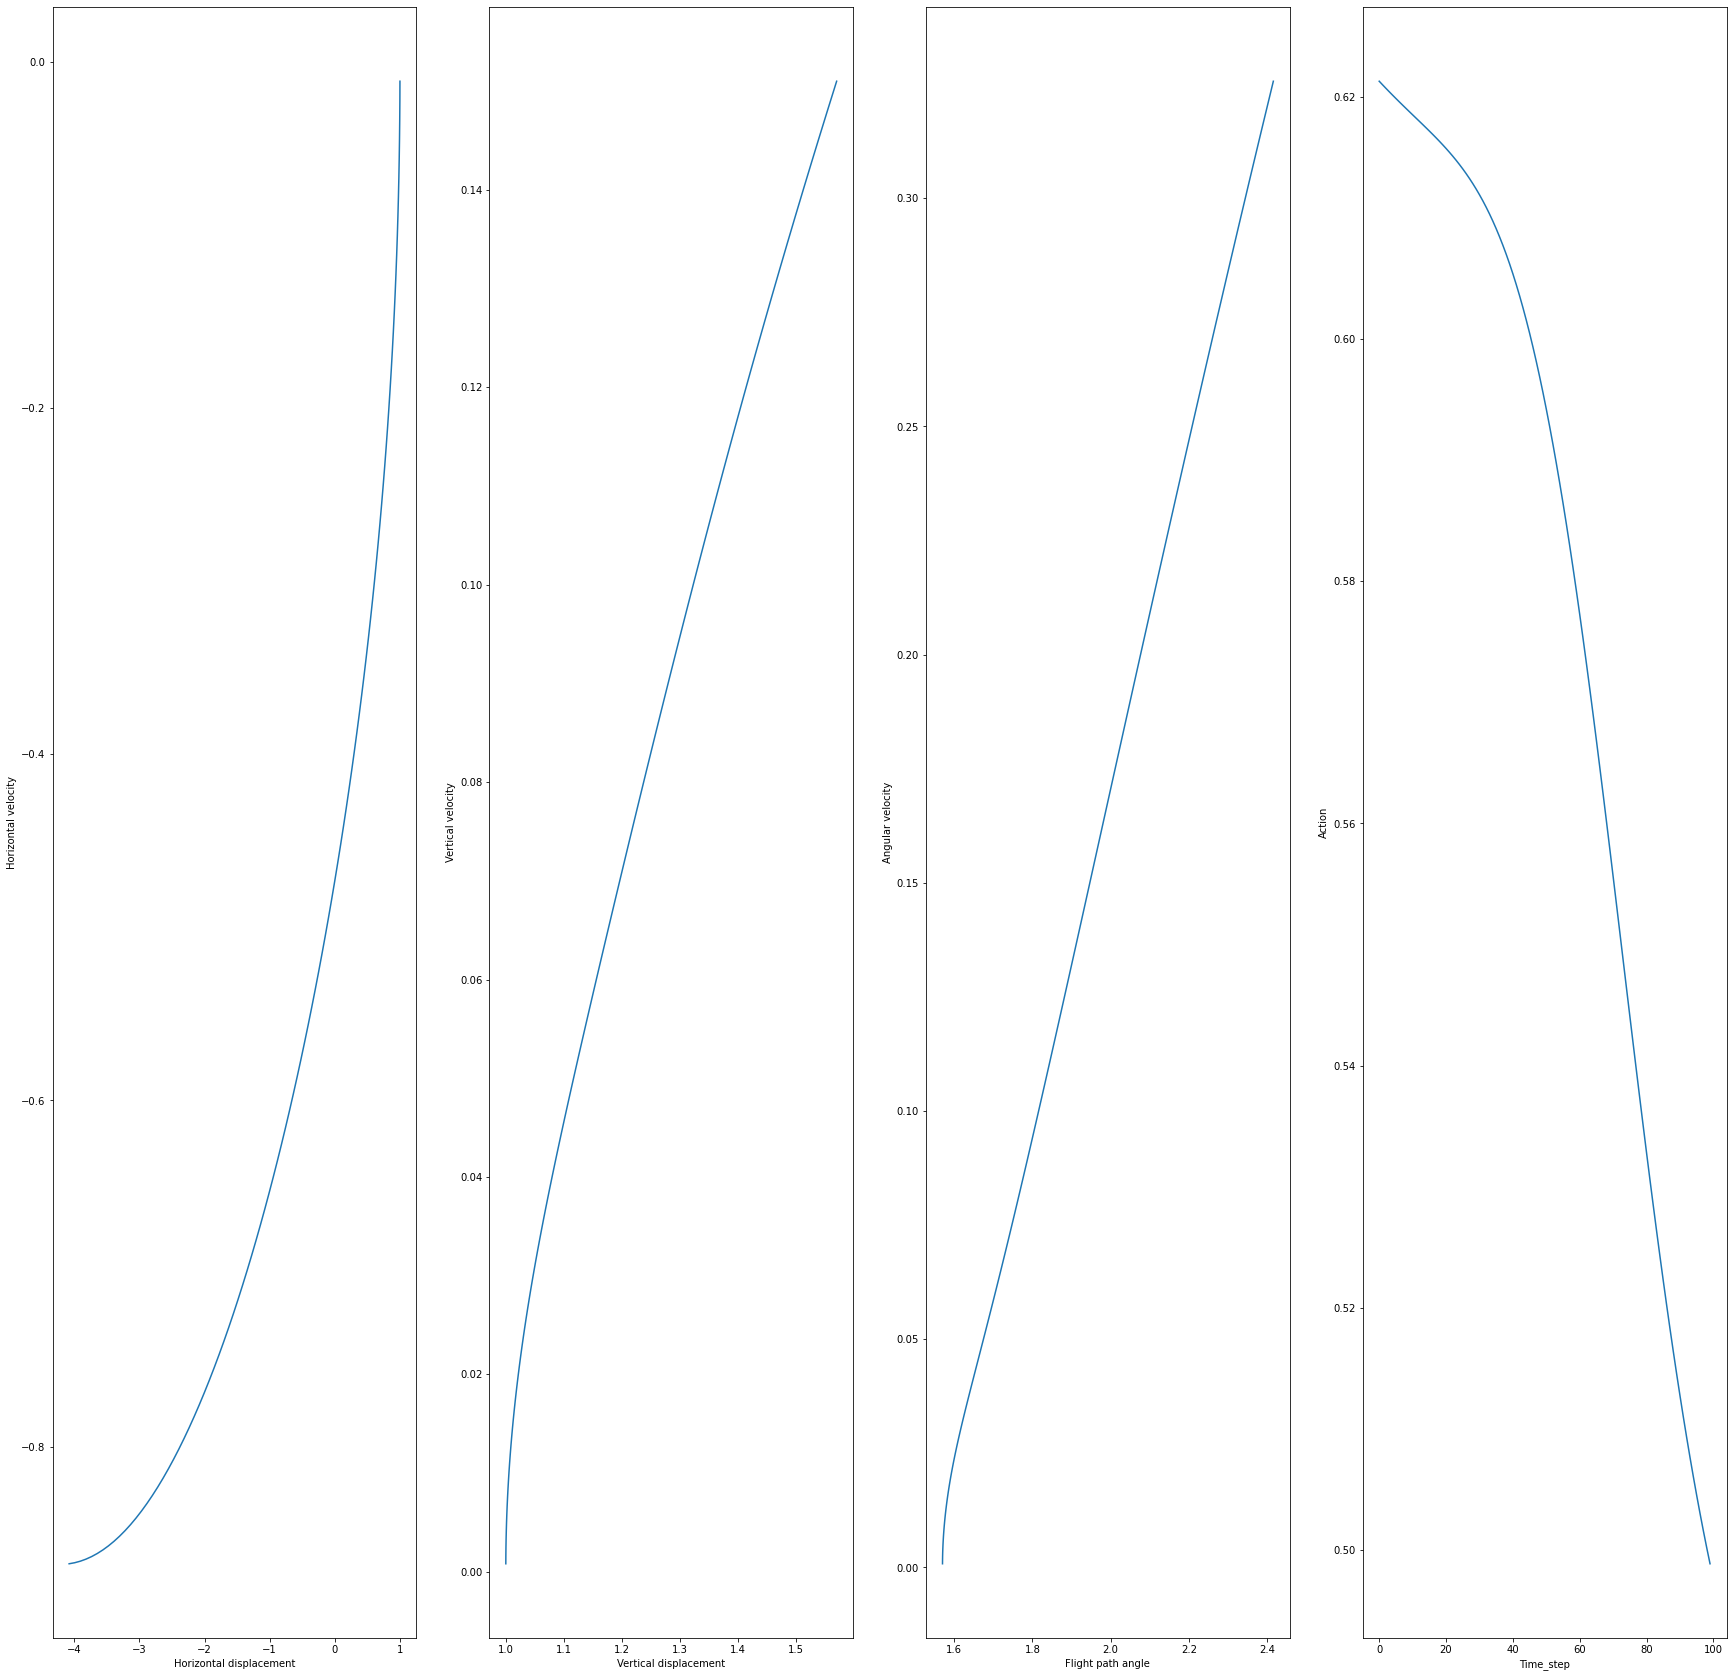

[14] loss: 26.779


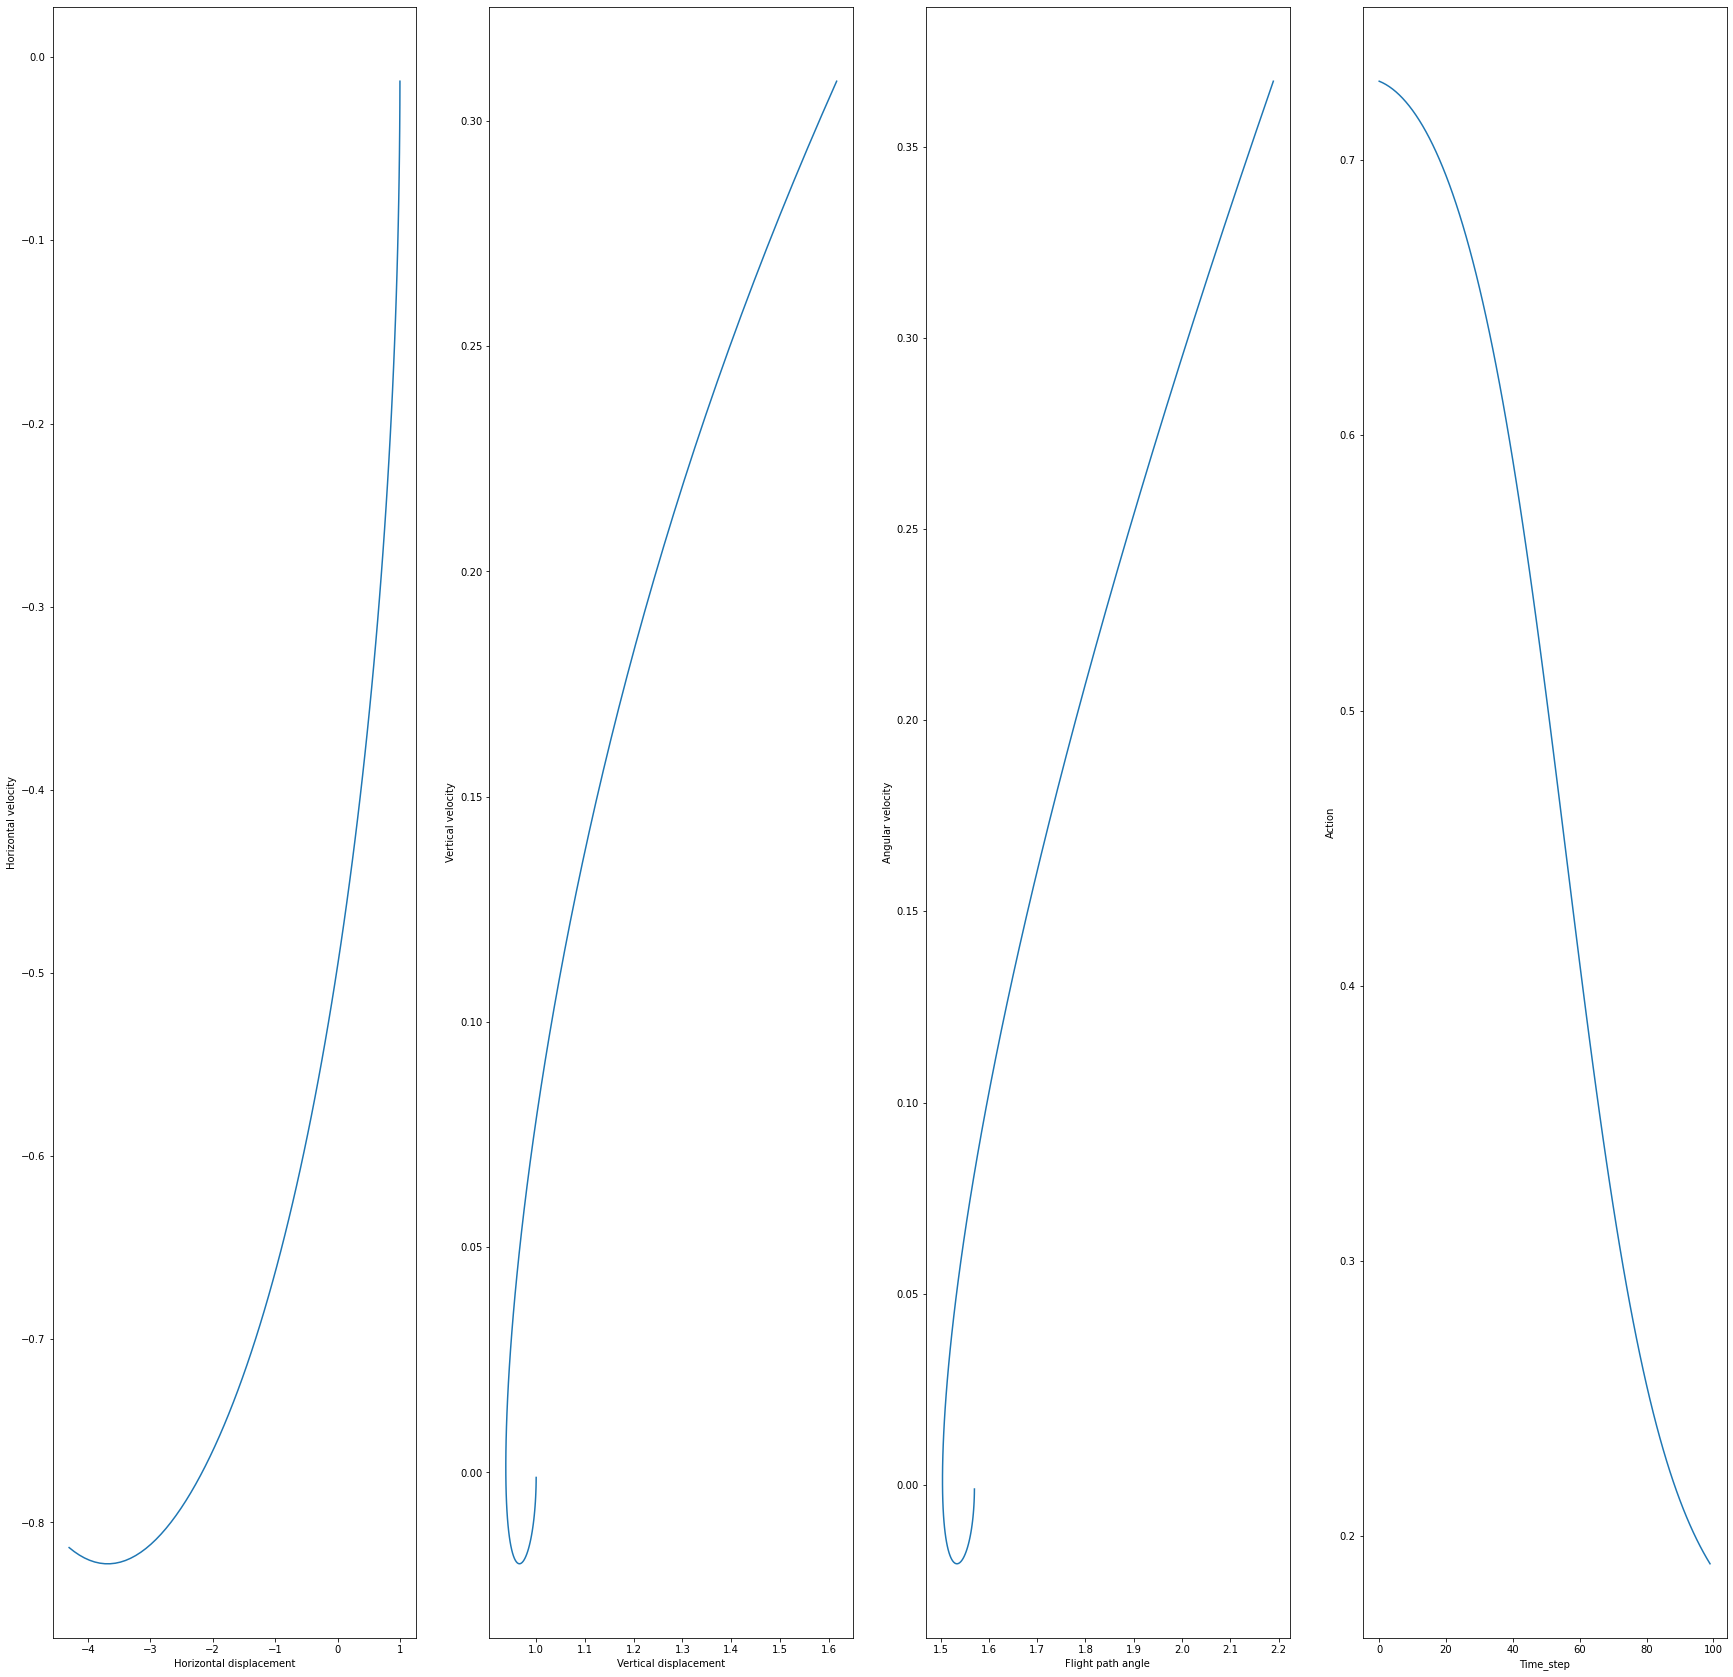

[15] loss: 27.747


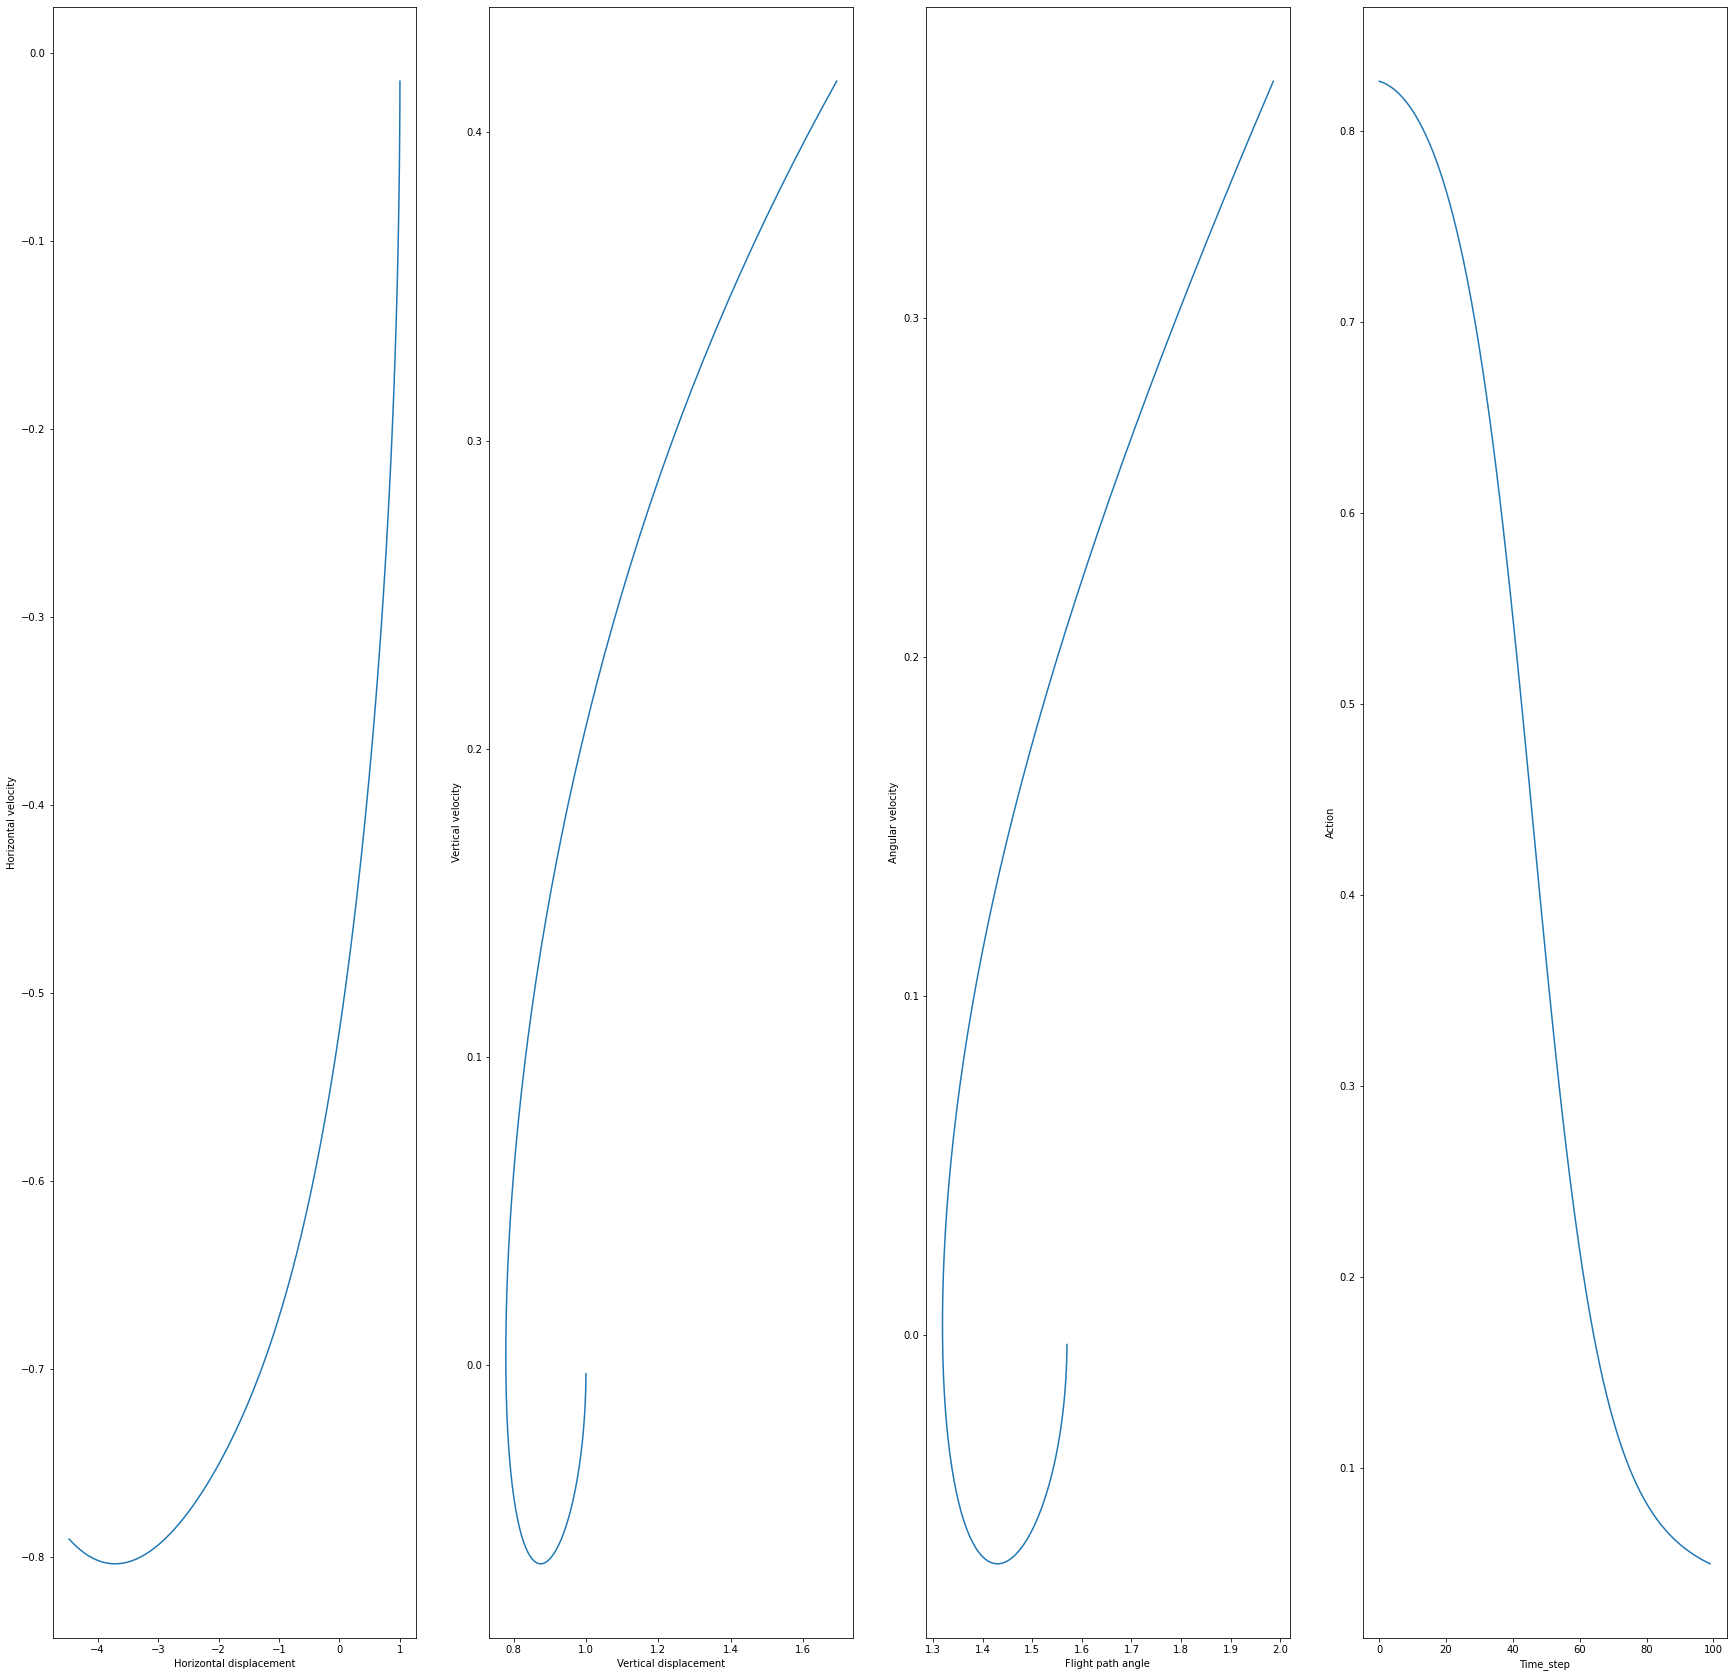

[16] loss: 28.497


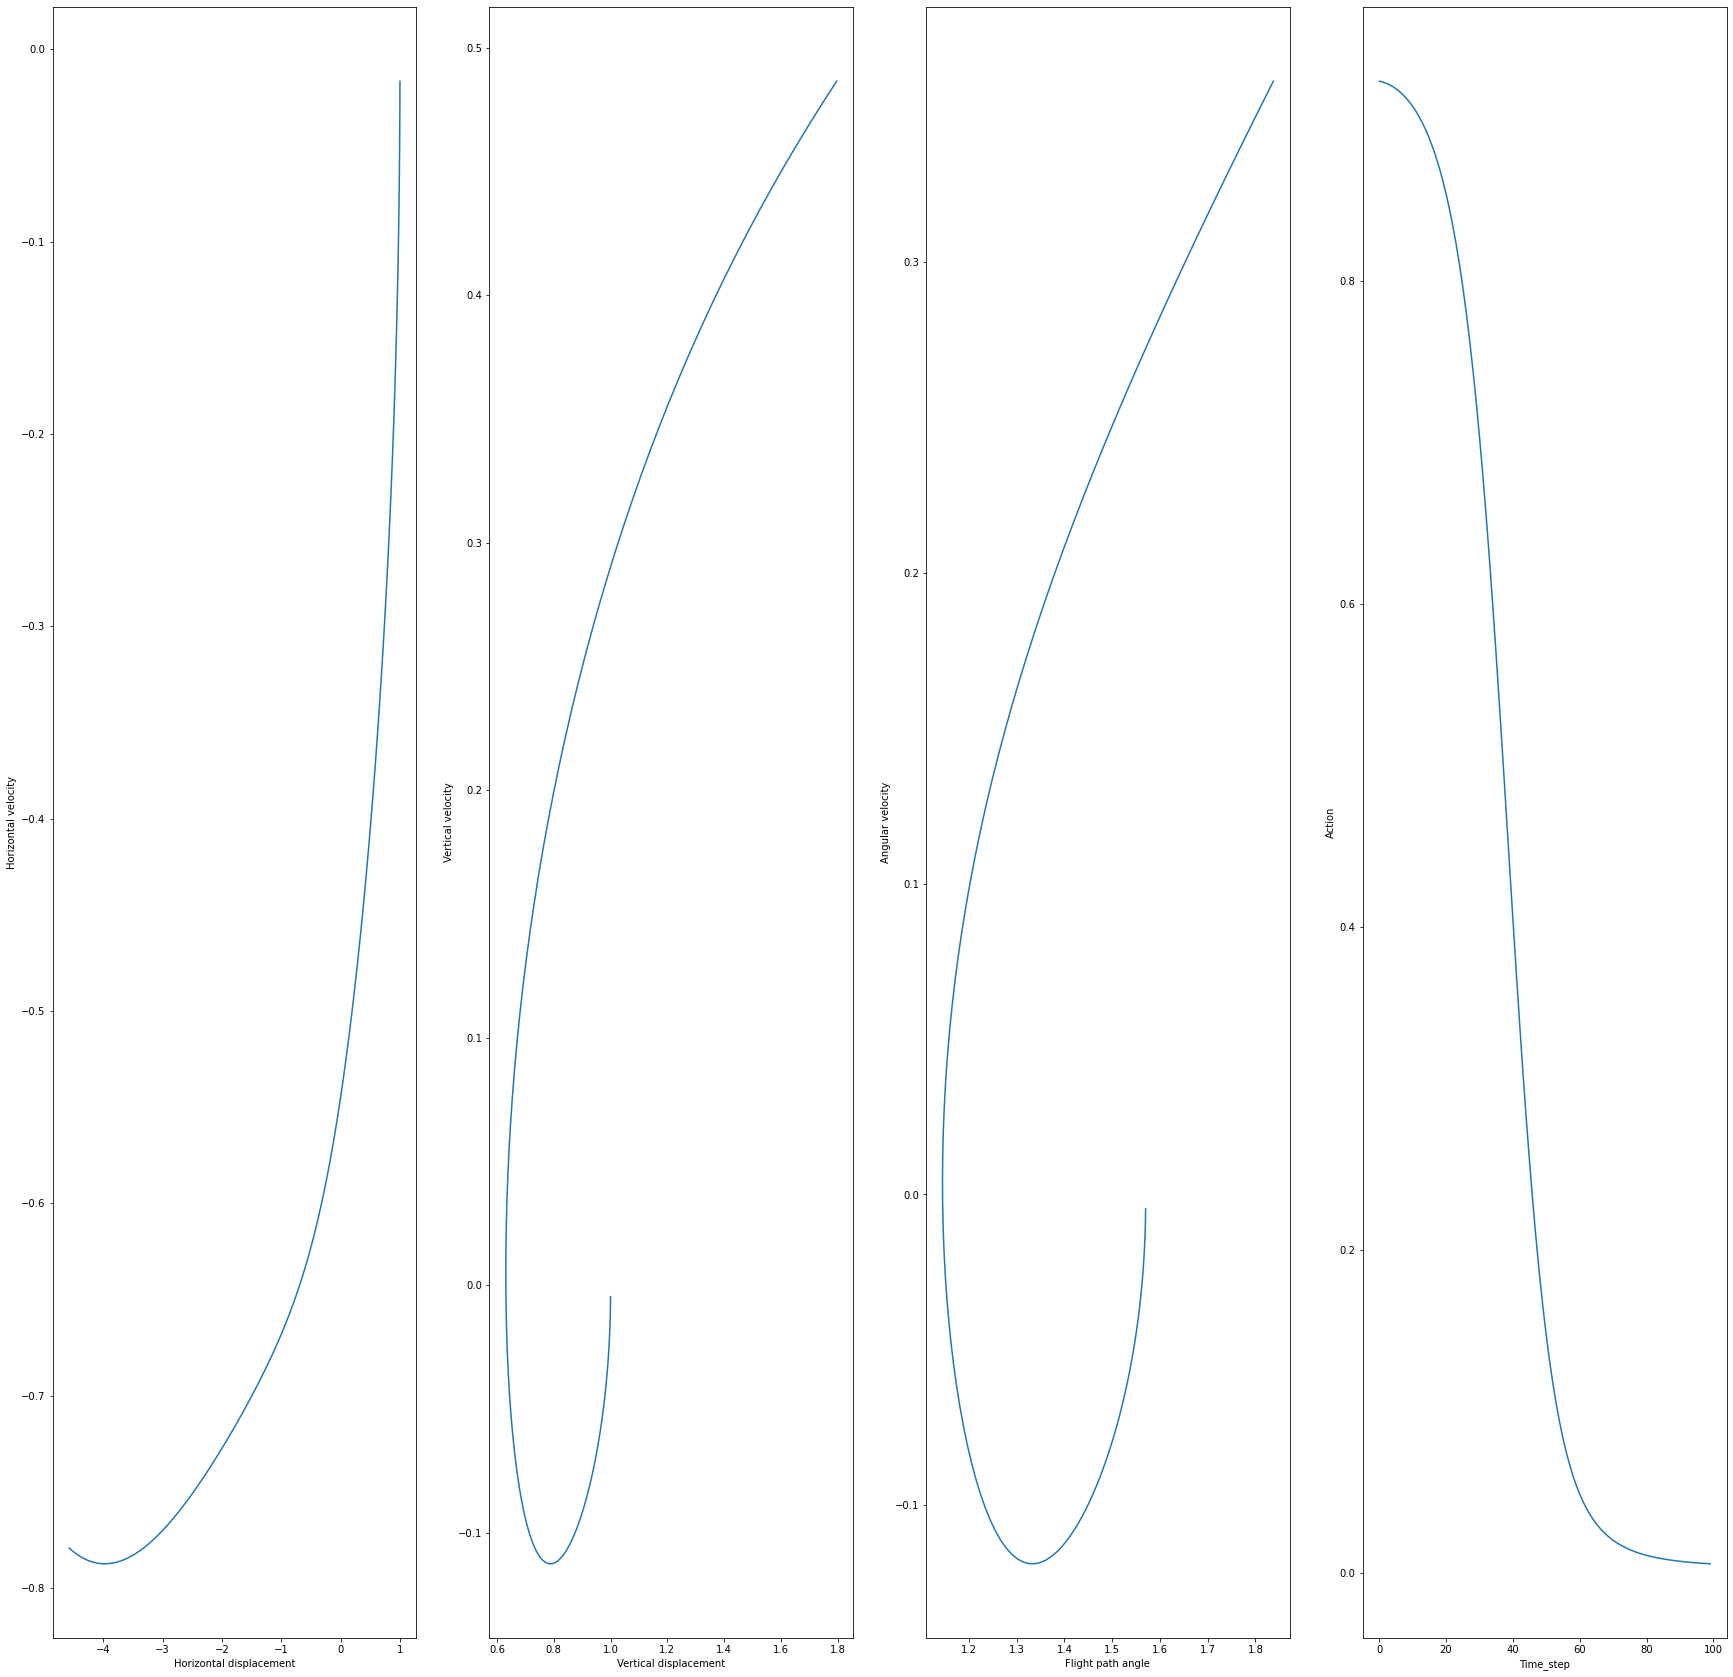

[17] loss: 28.249


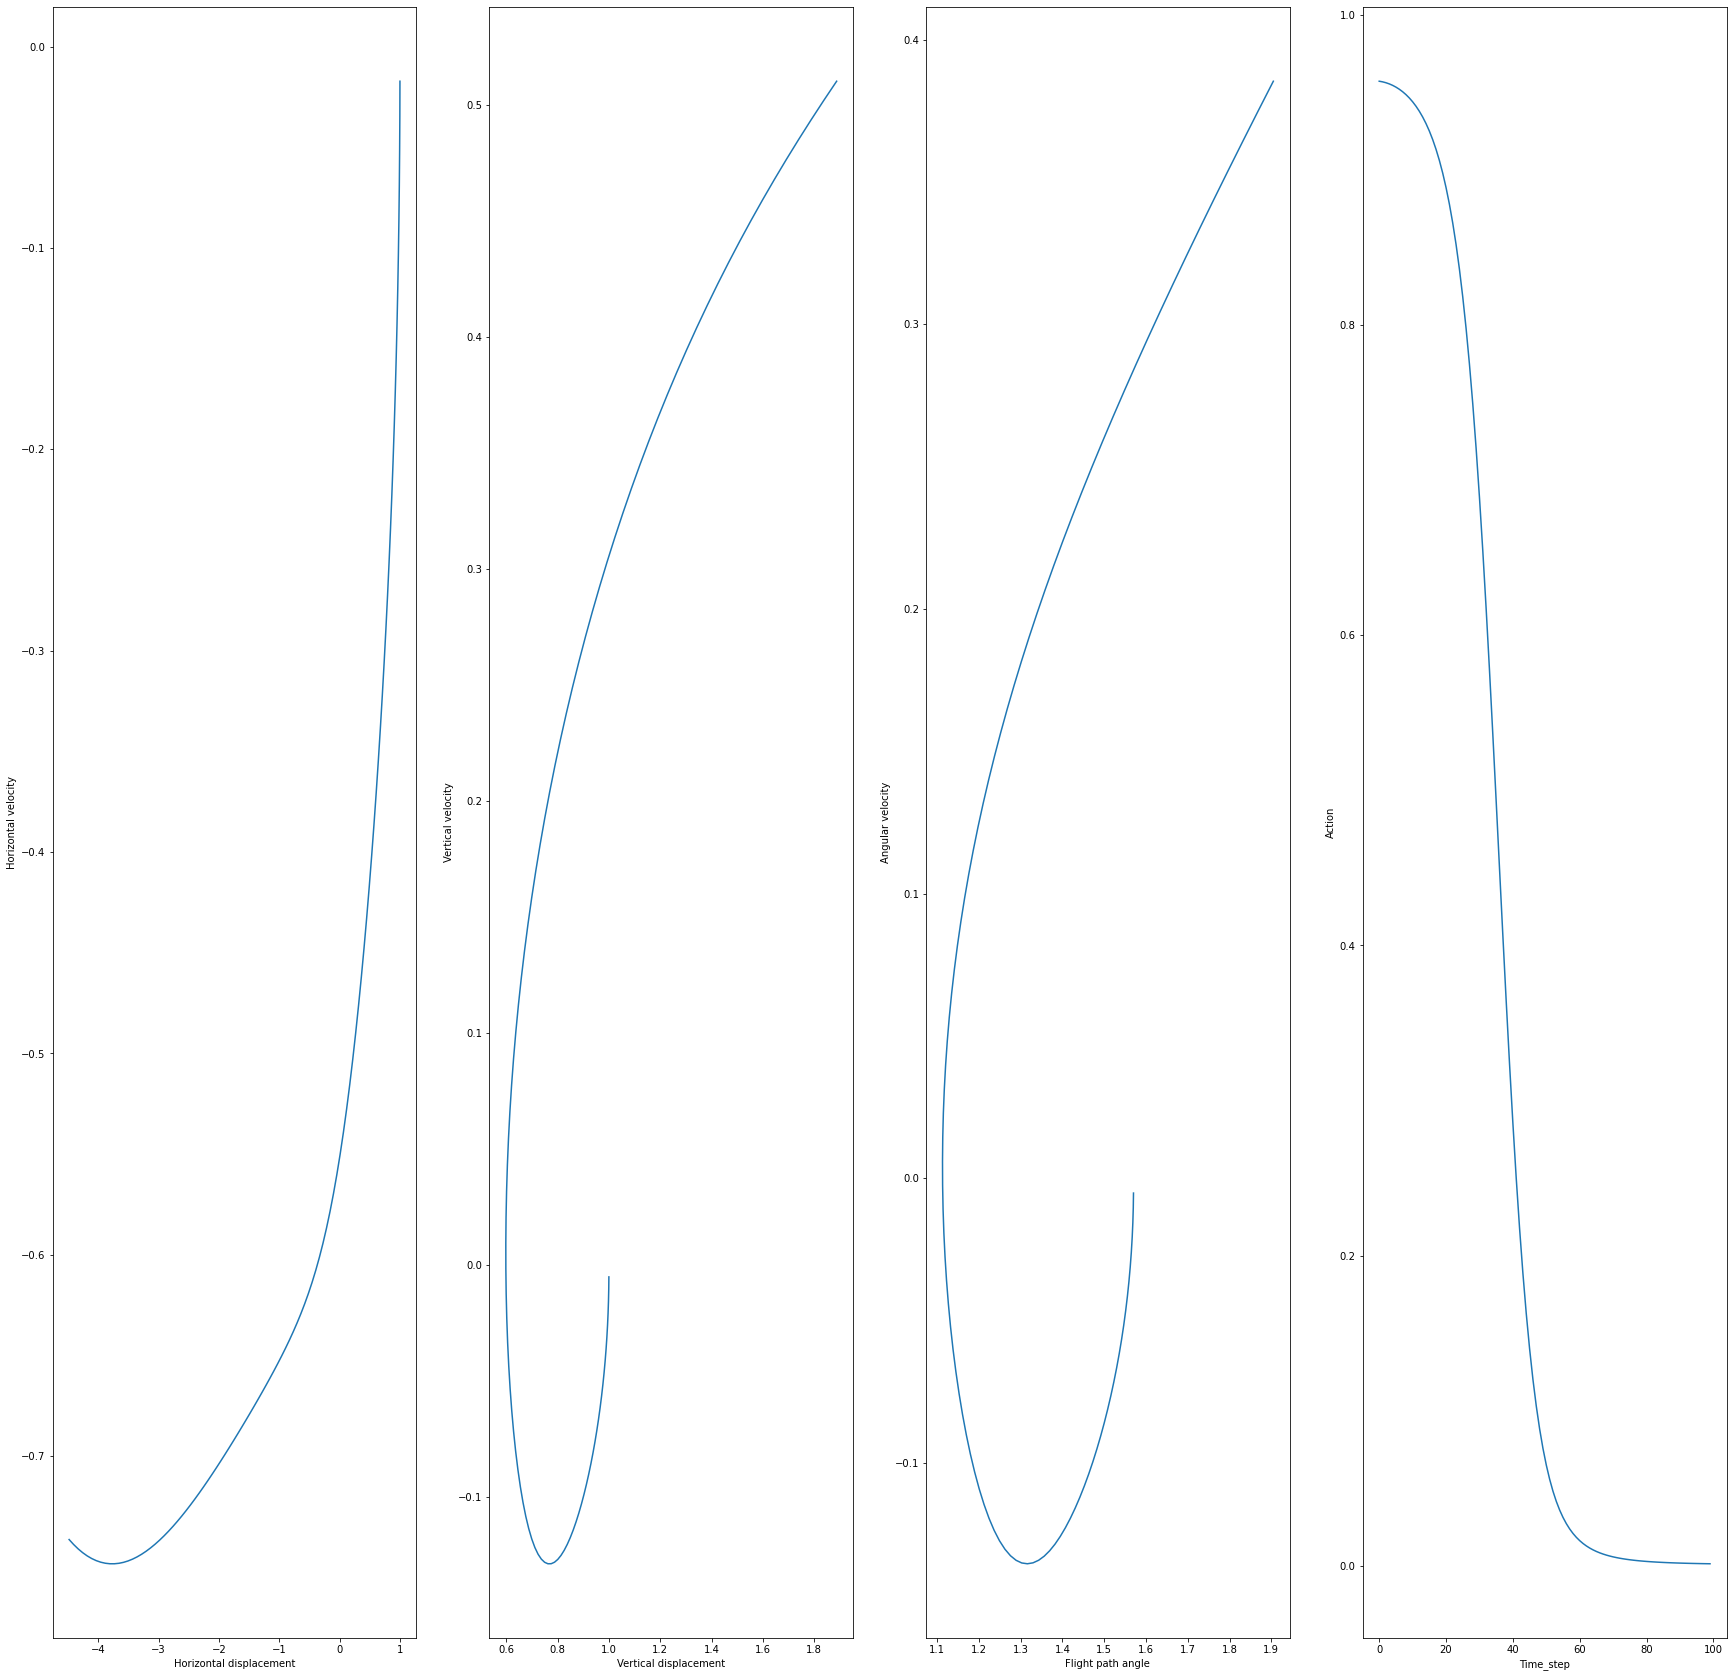

[18] loss: 28.052


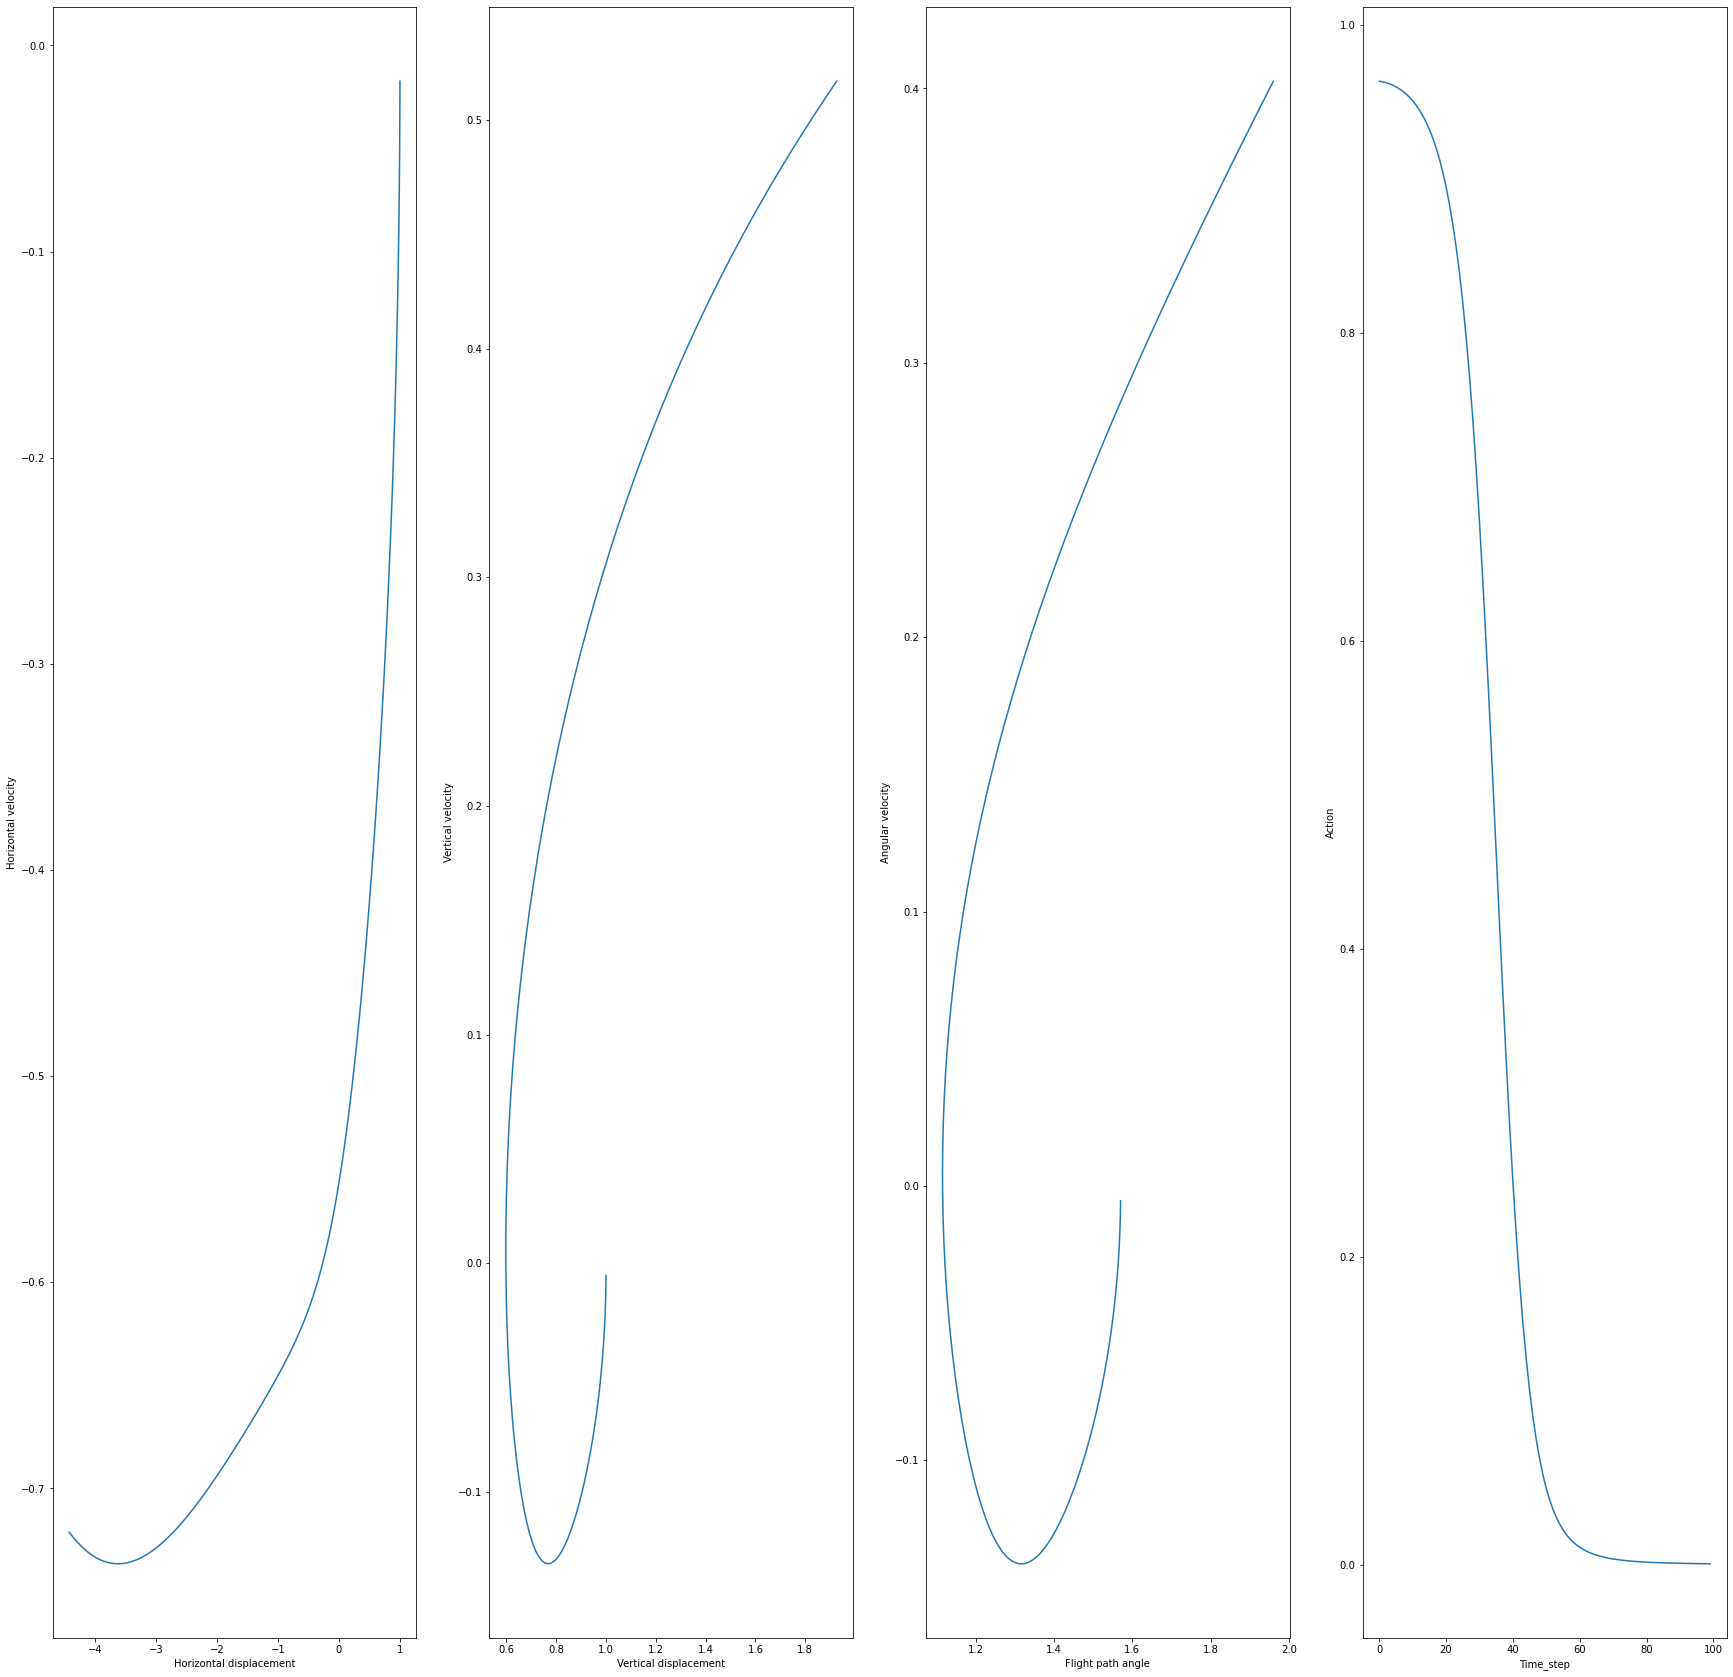

[19] loss: 27.913


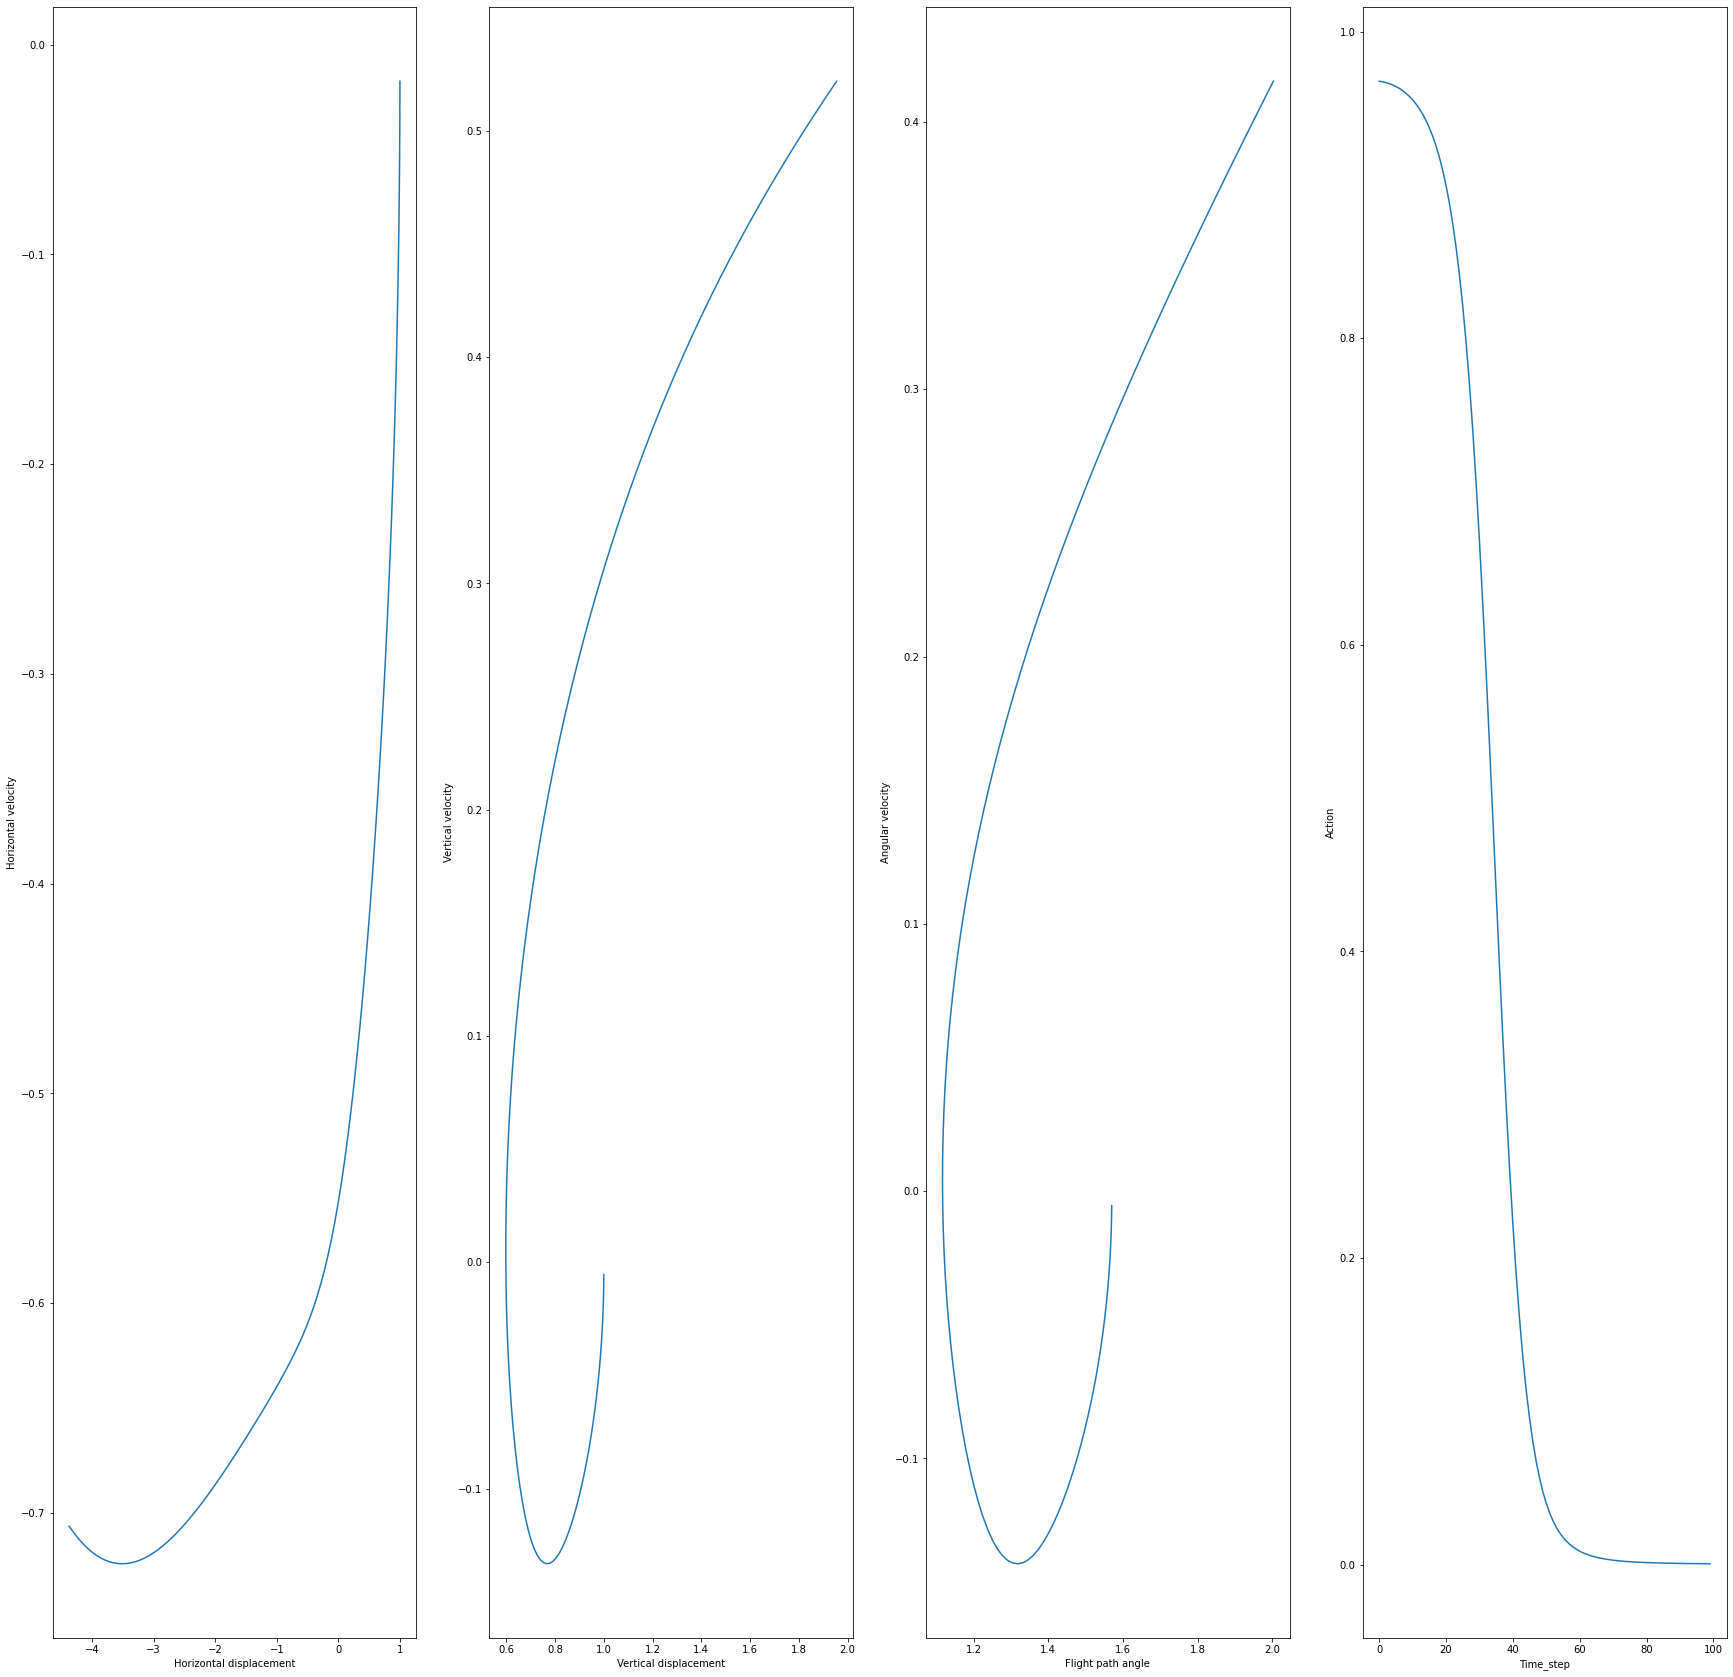

[20] loss: 27.811


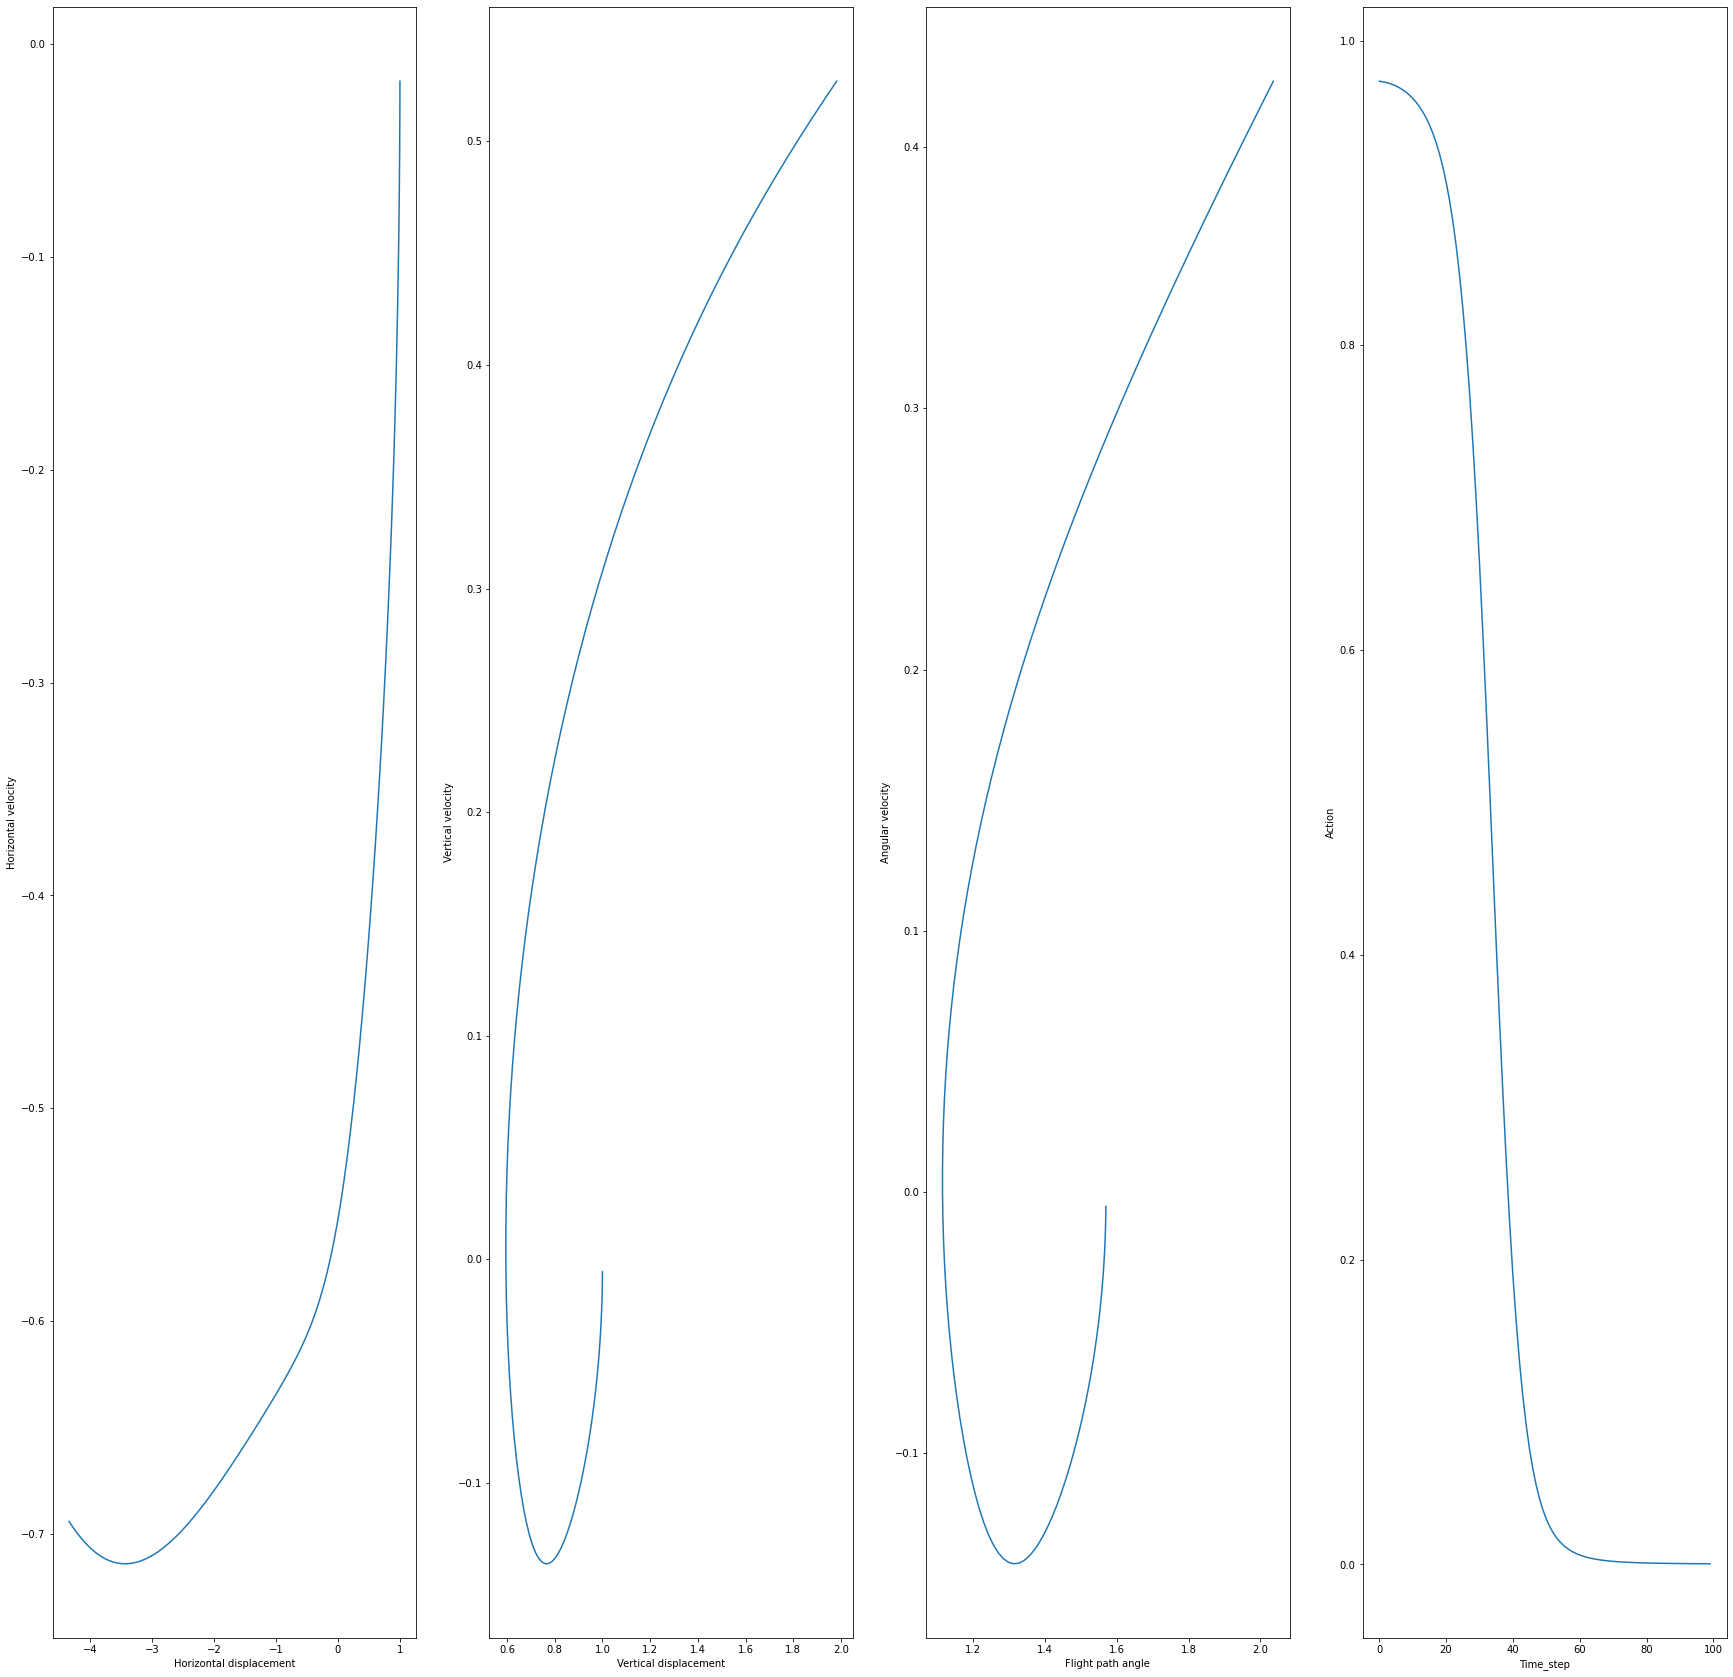

[21] loss: 27.742


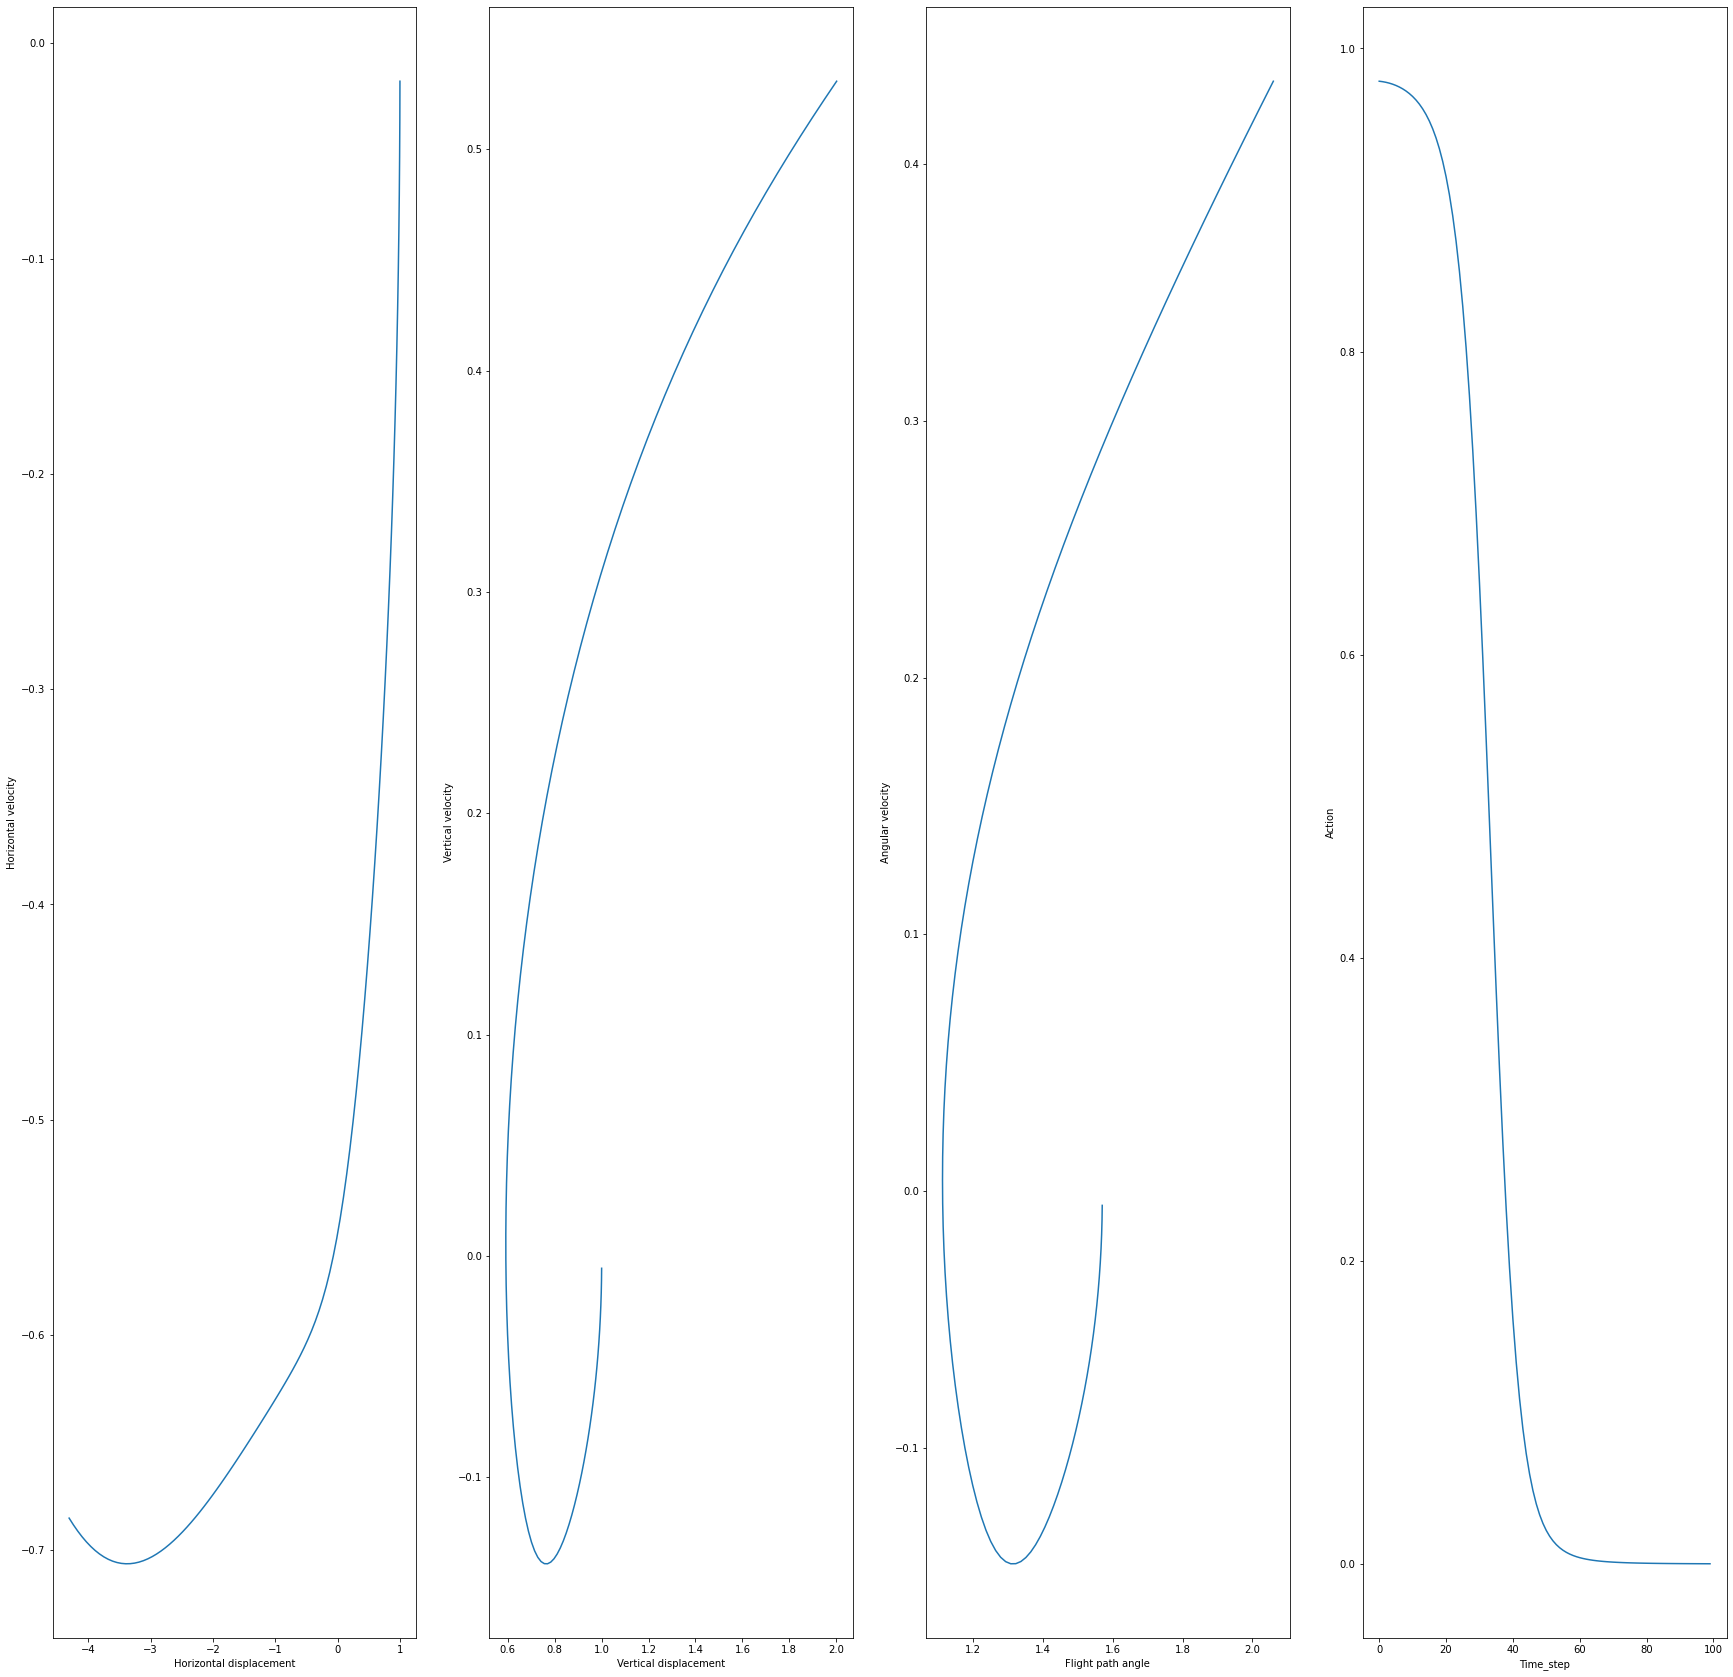

[22] loss: 27.699


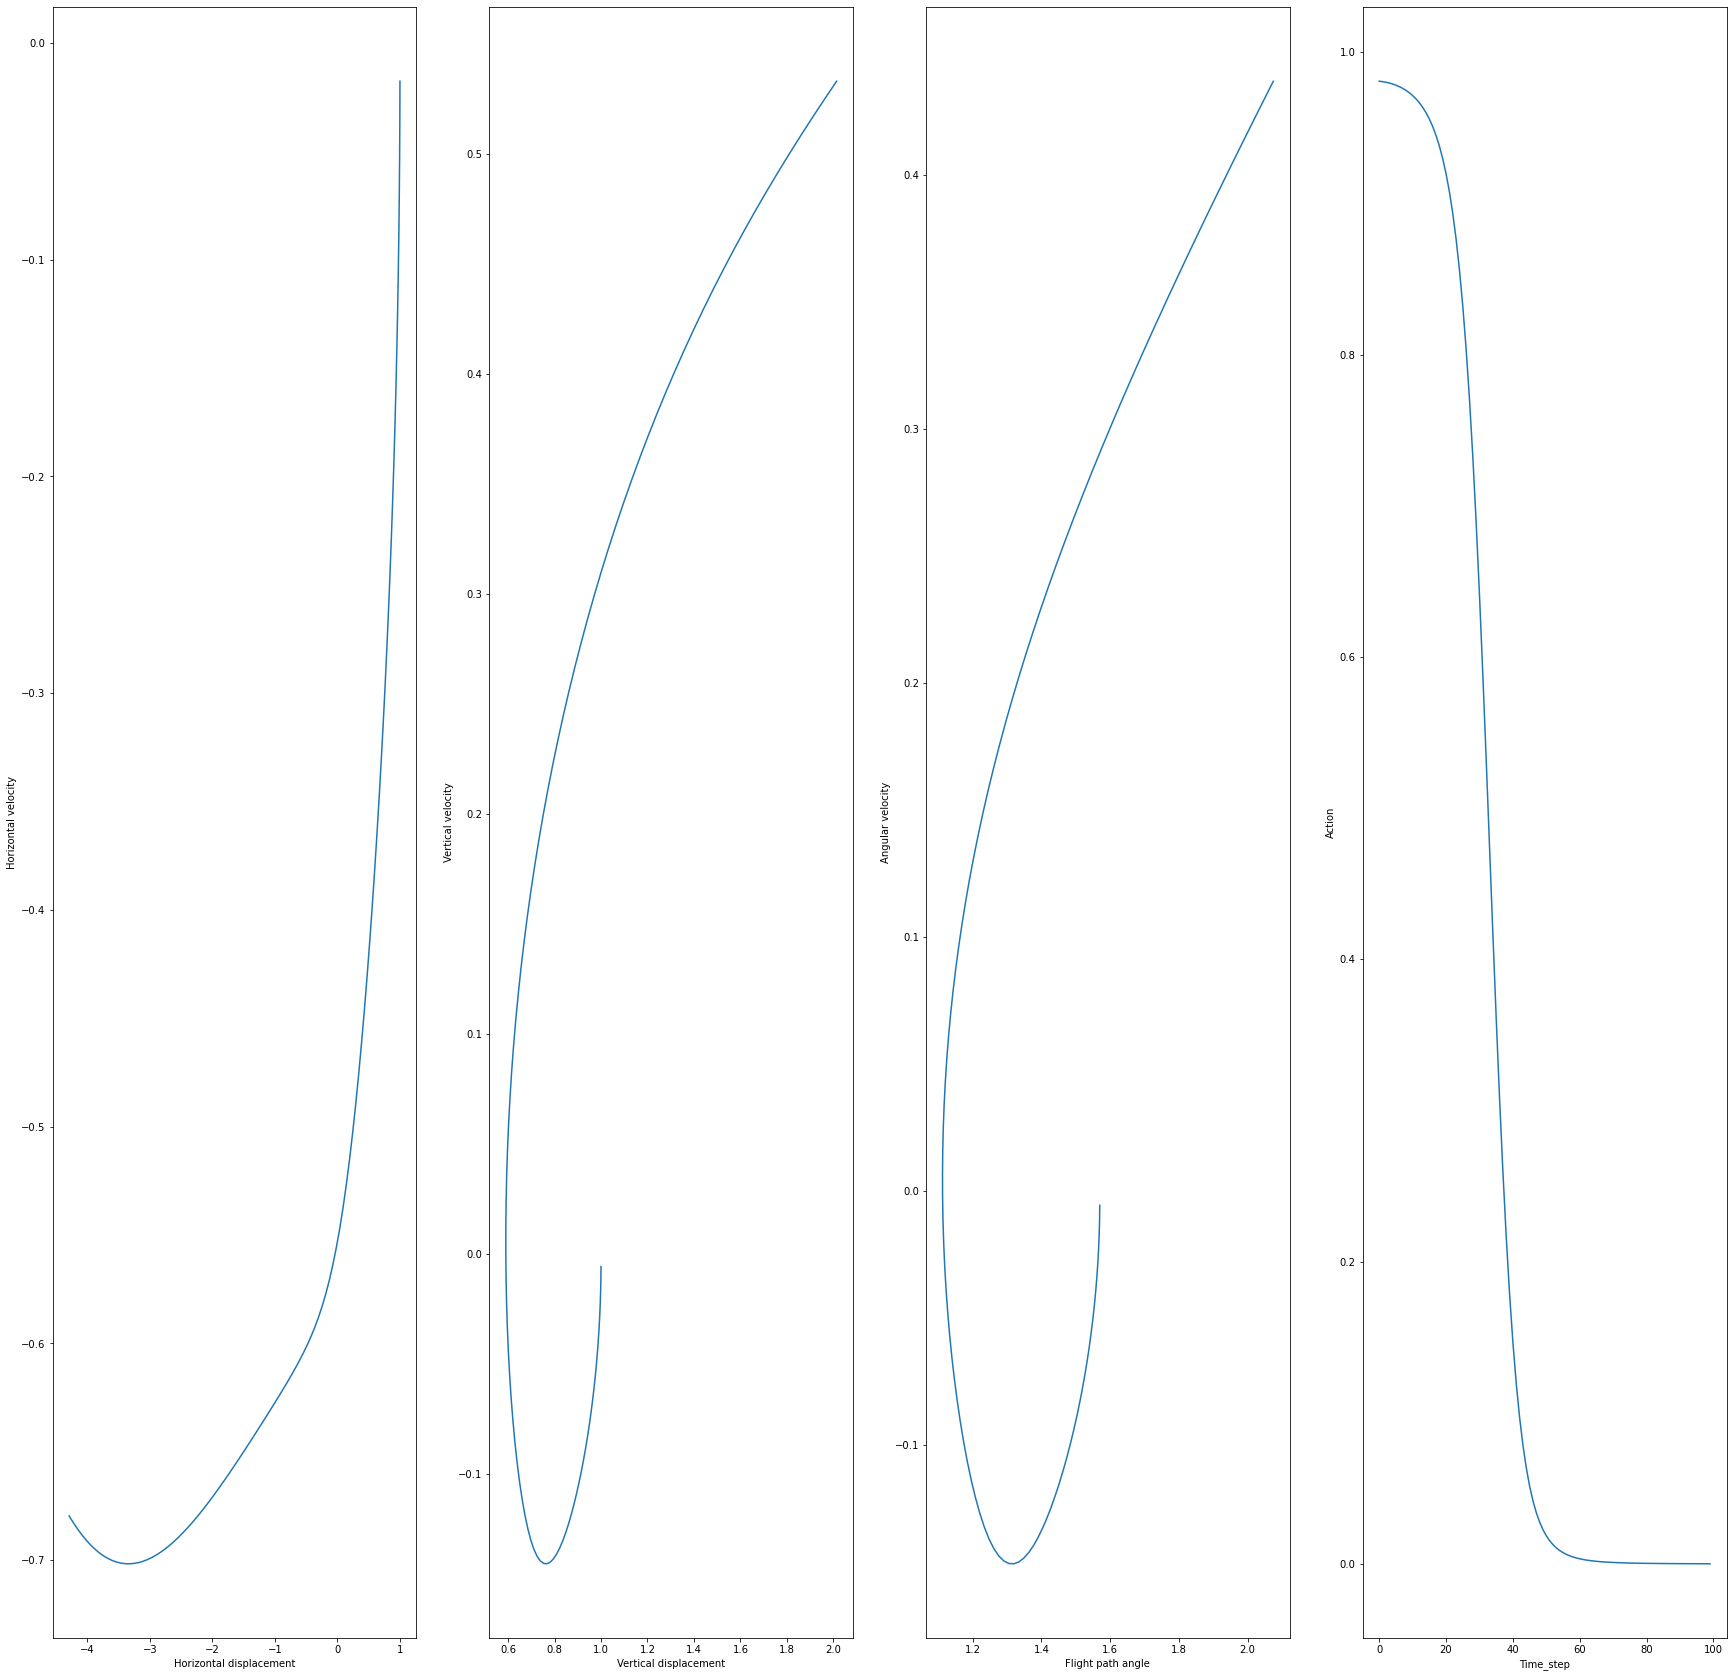

[23] loss: 27.668


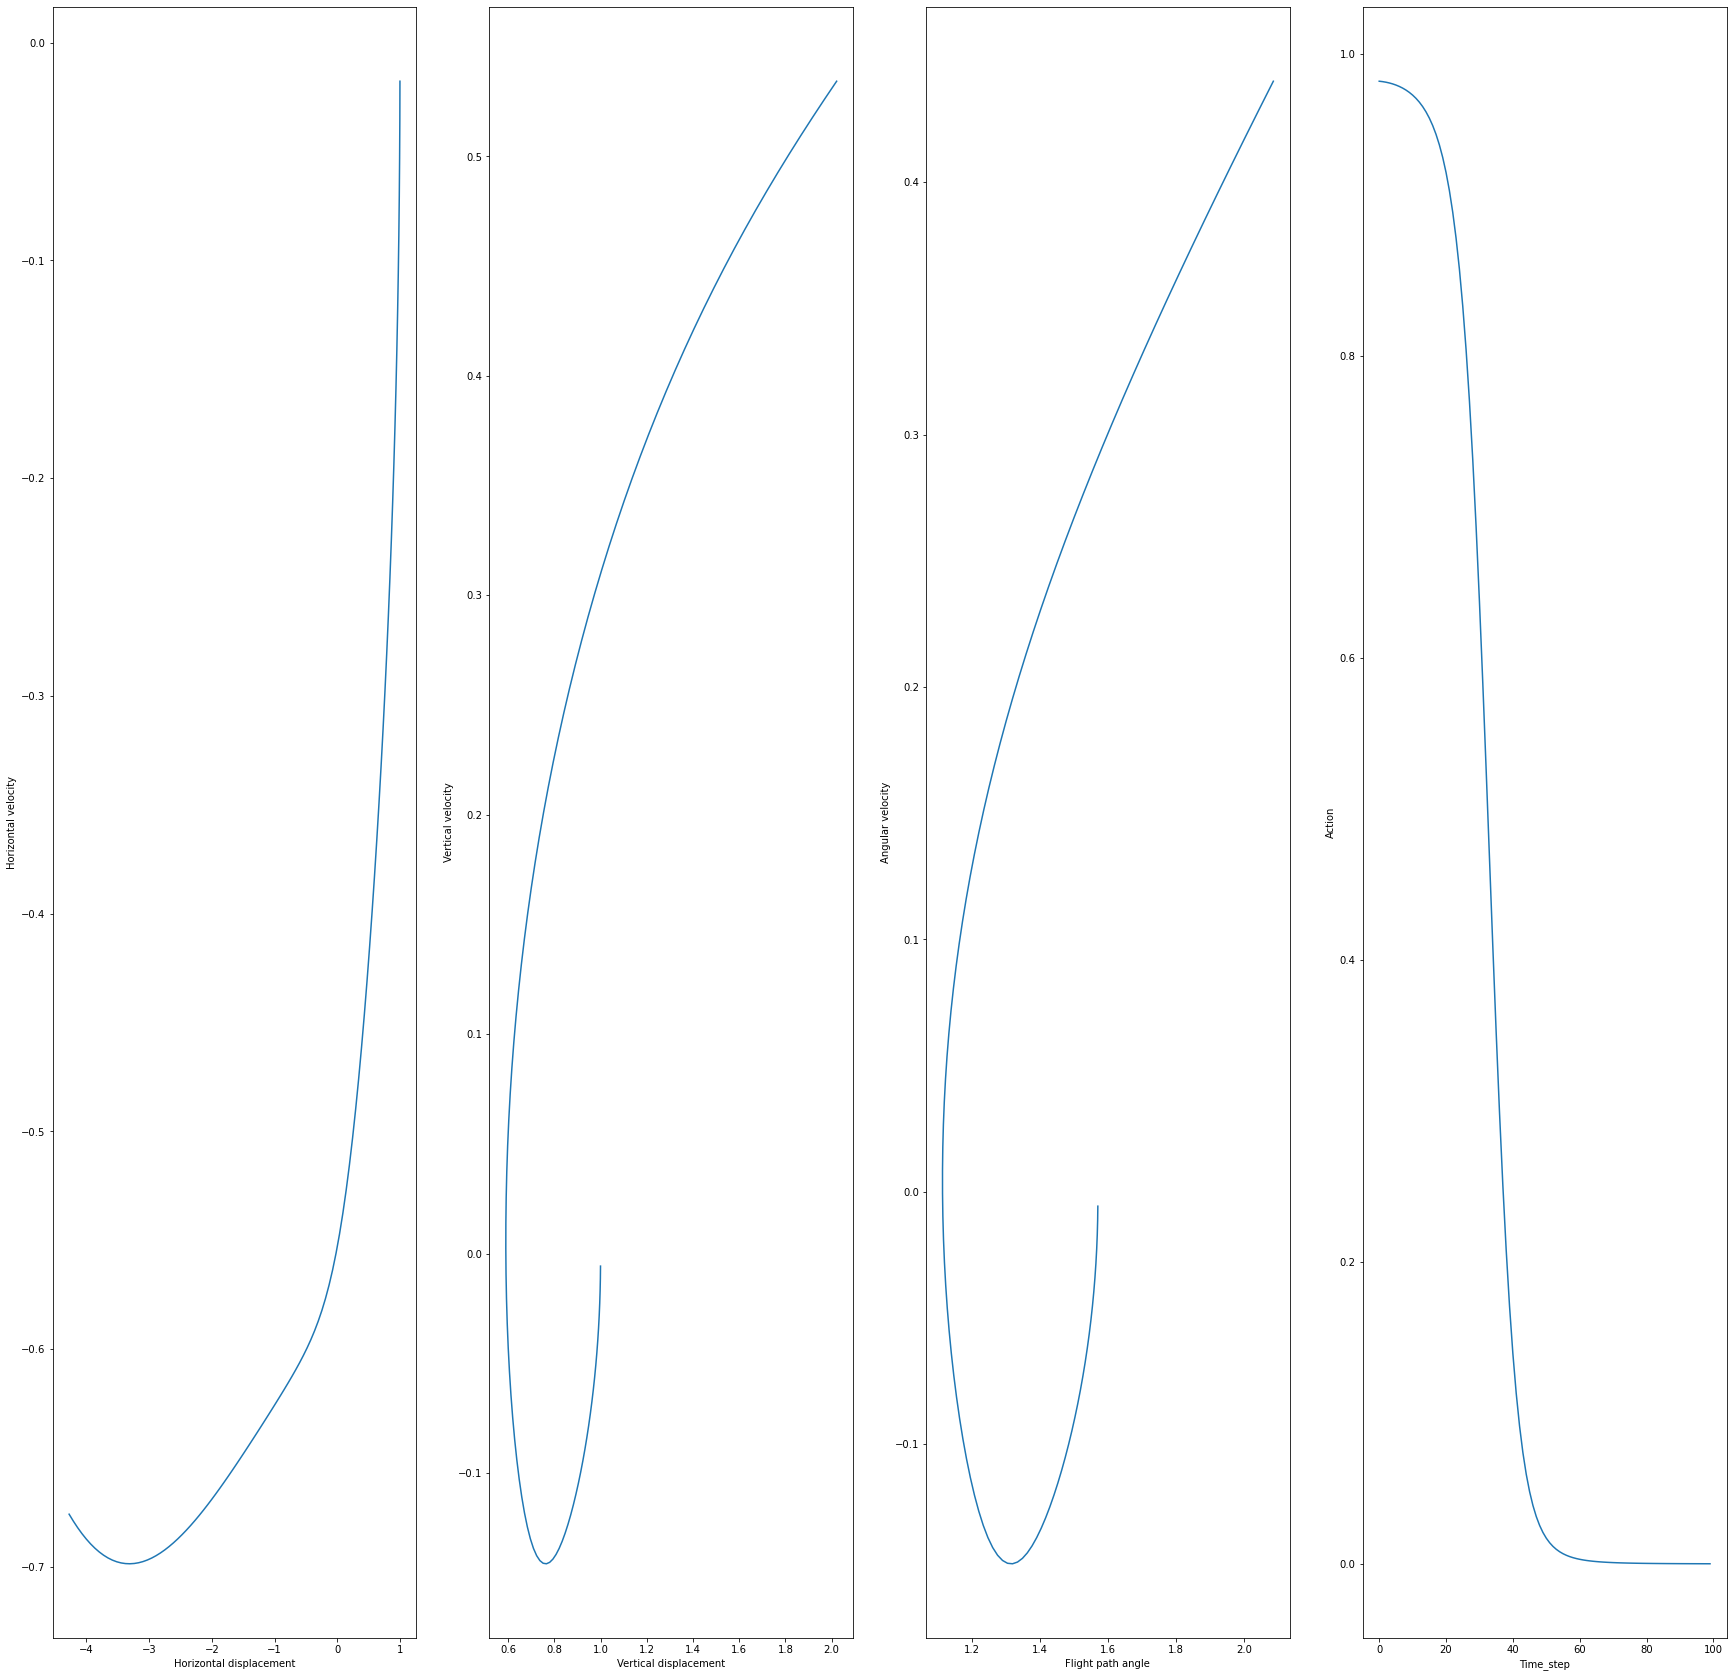

[24] loss: 27.644


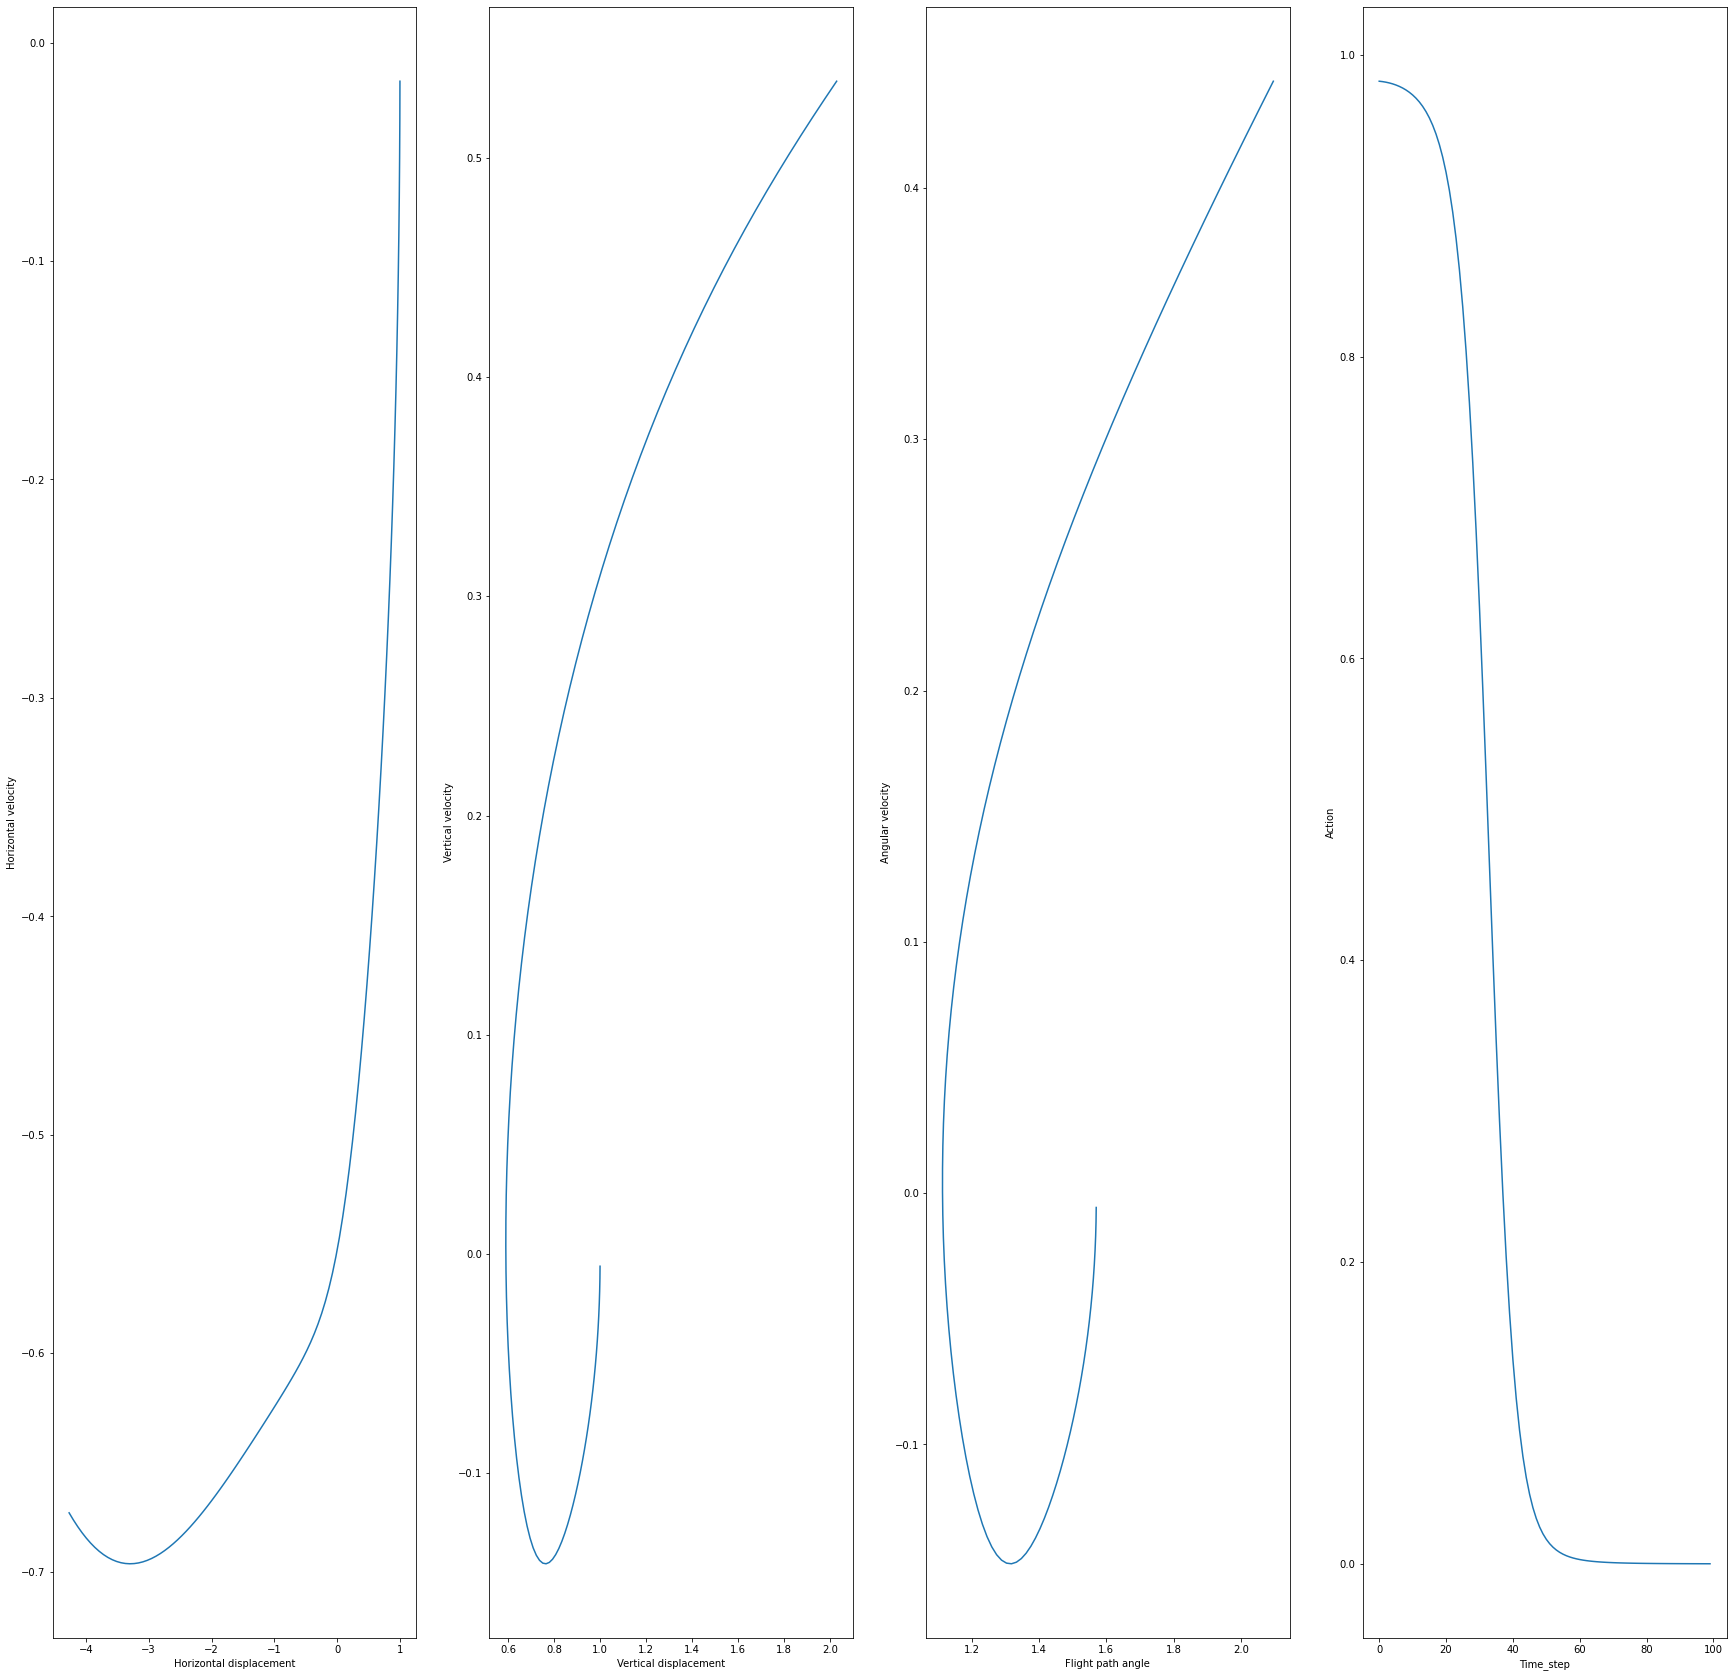

[25] loss: 27.624


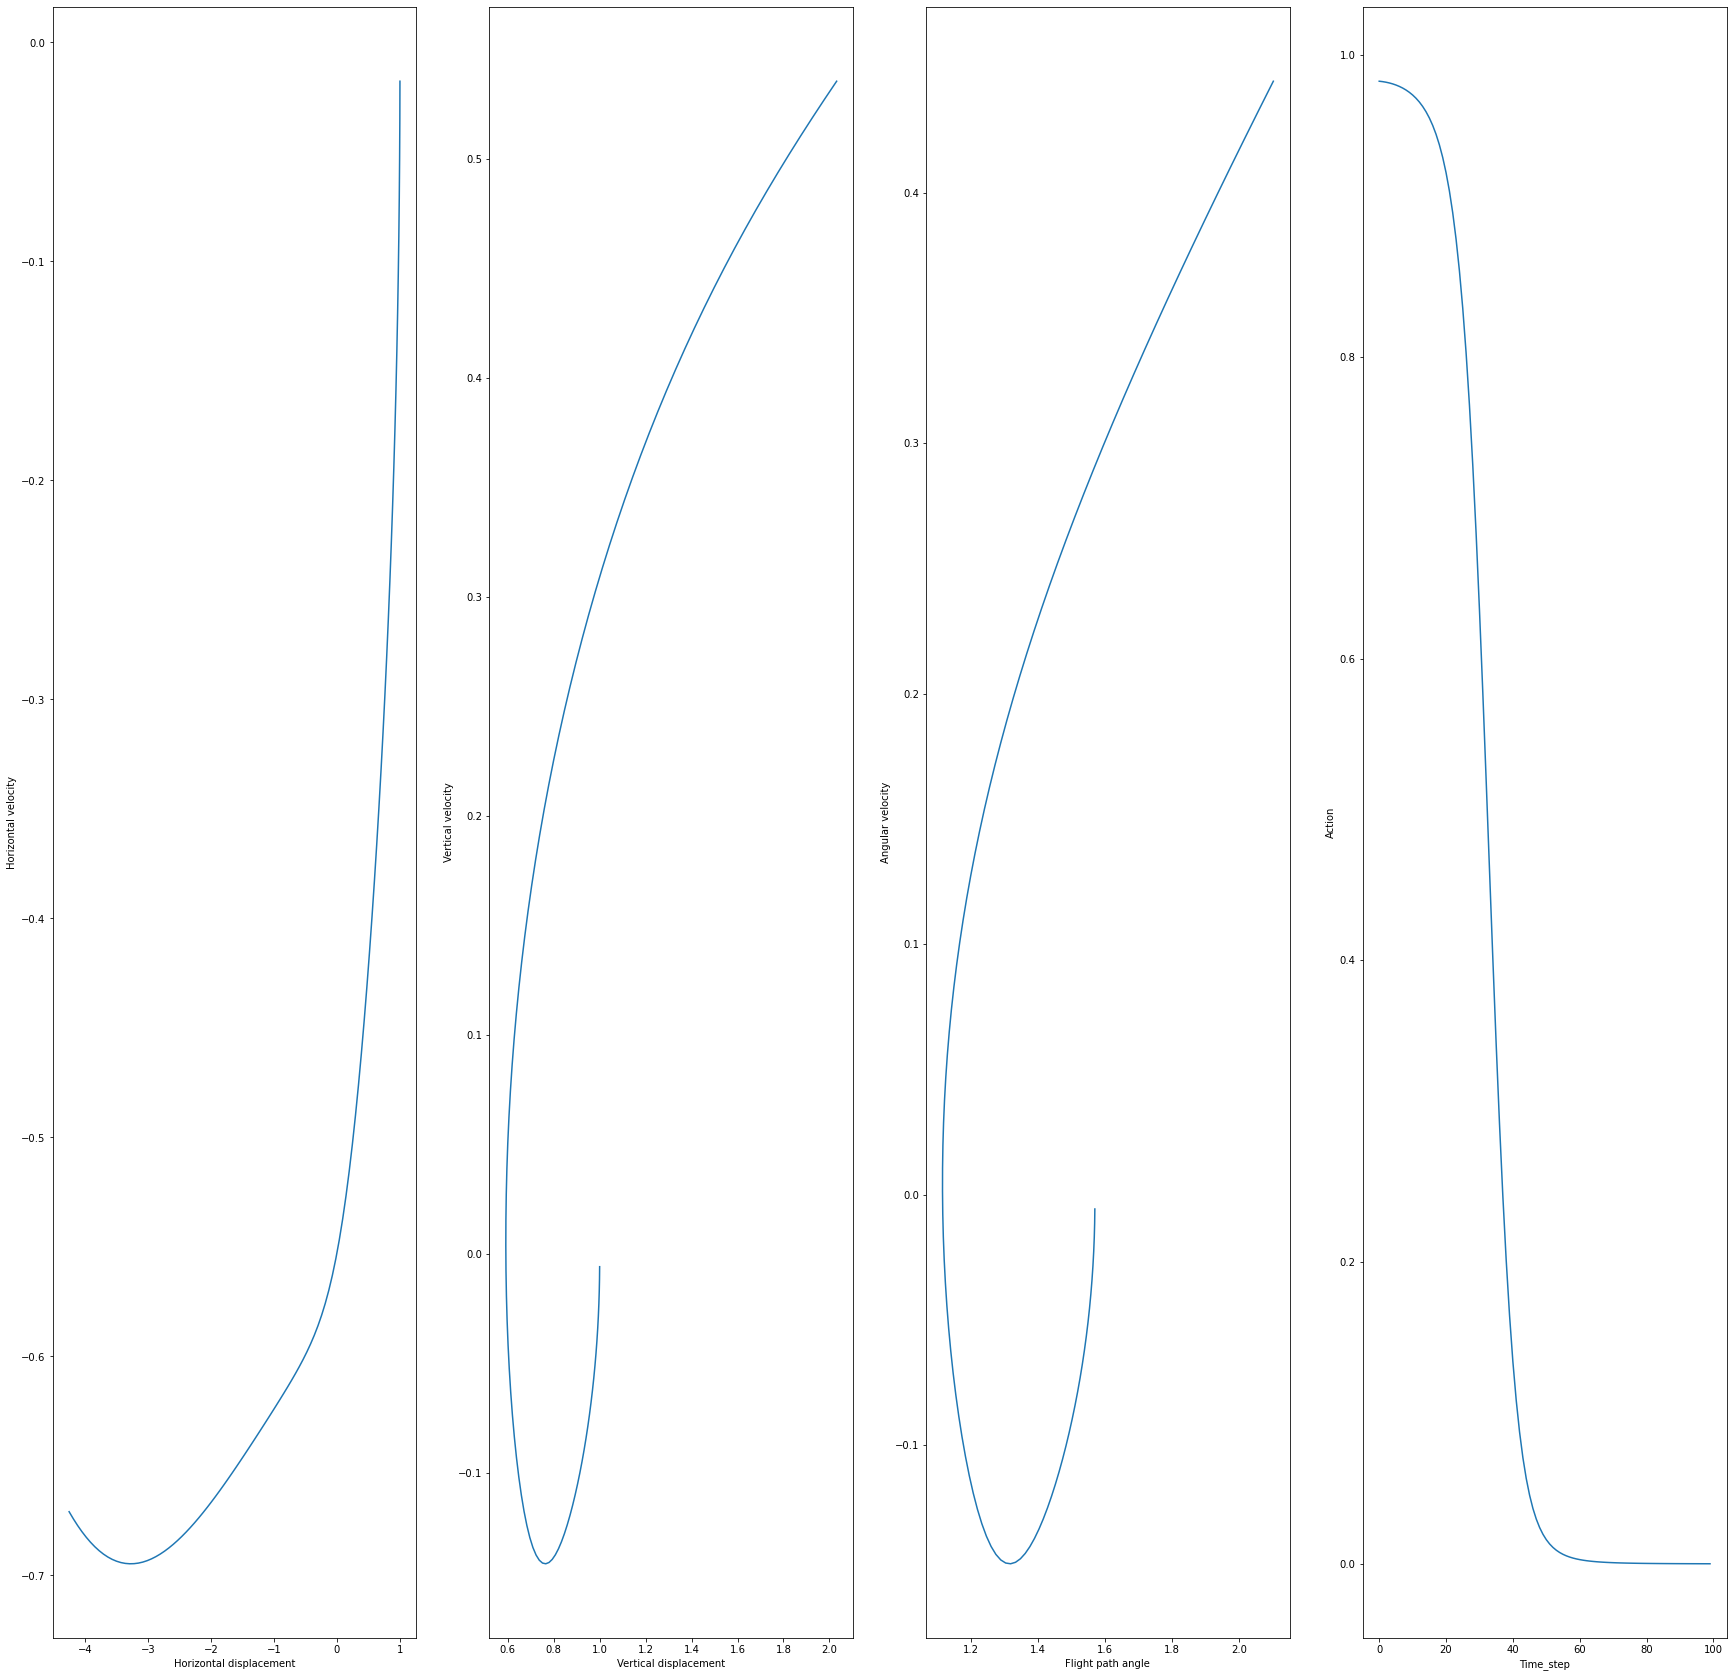

[26] loss: 27.595


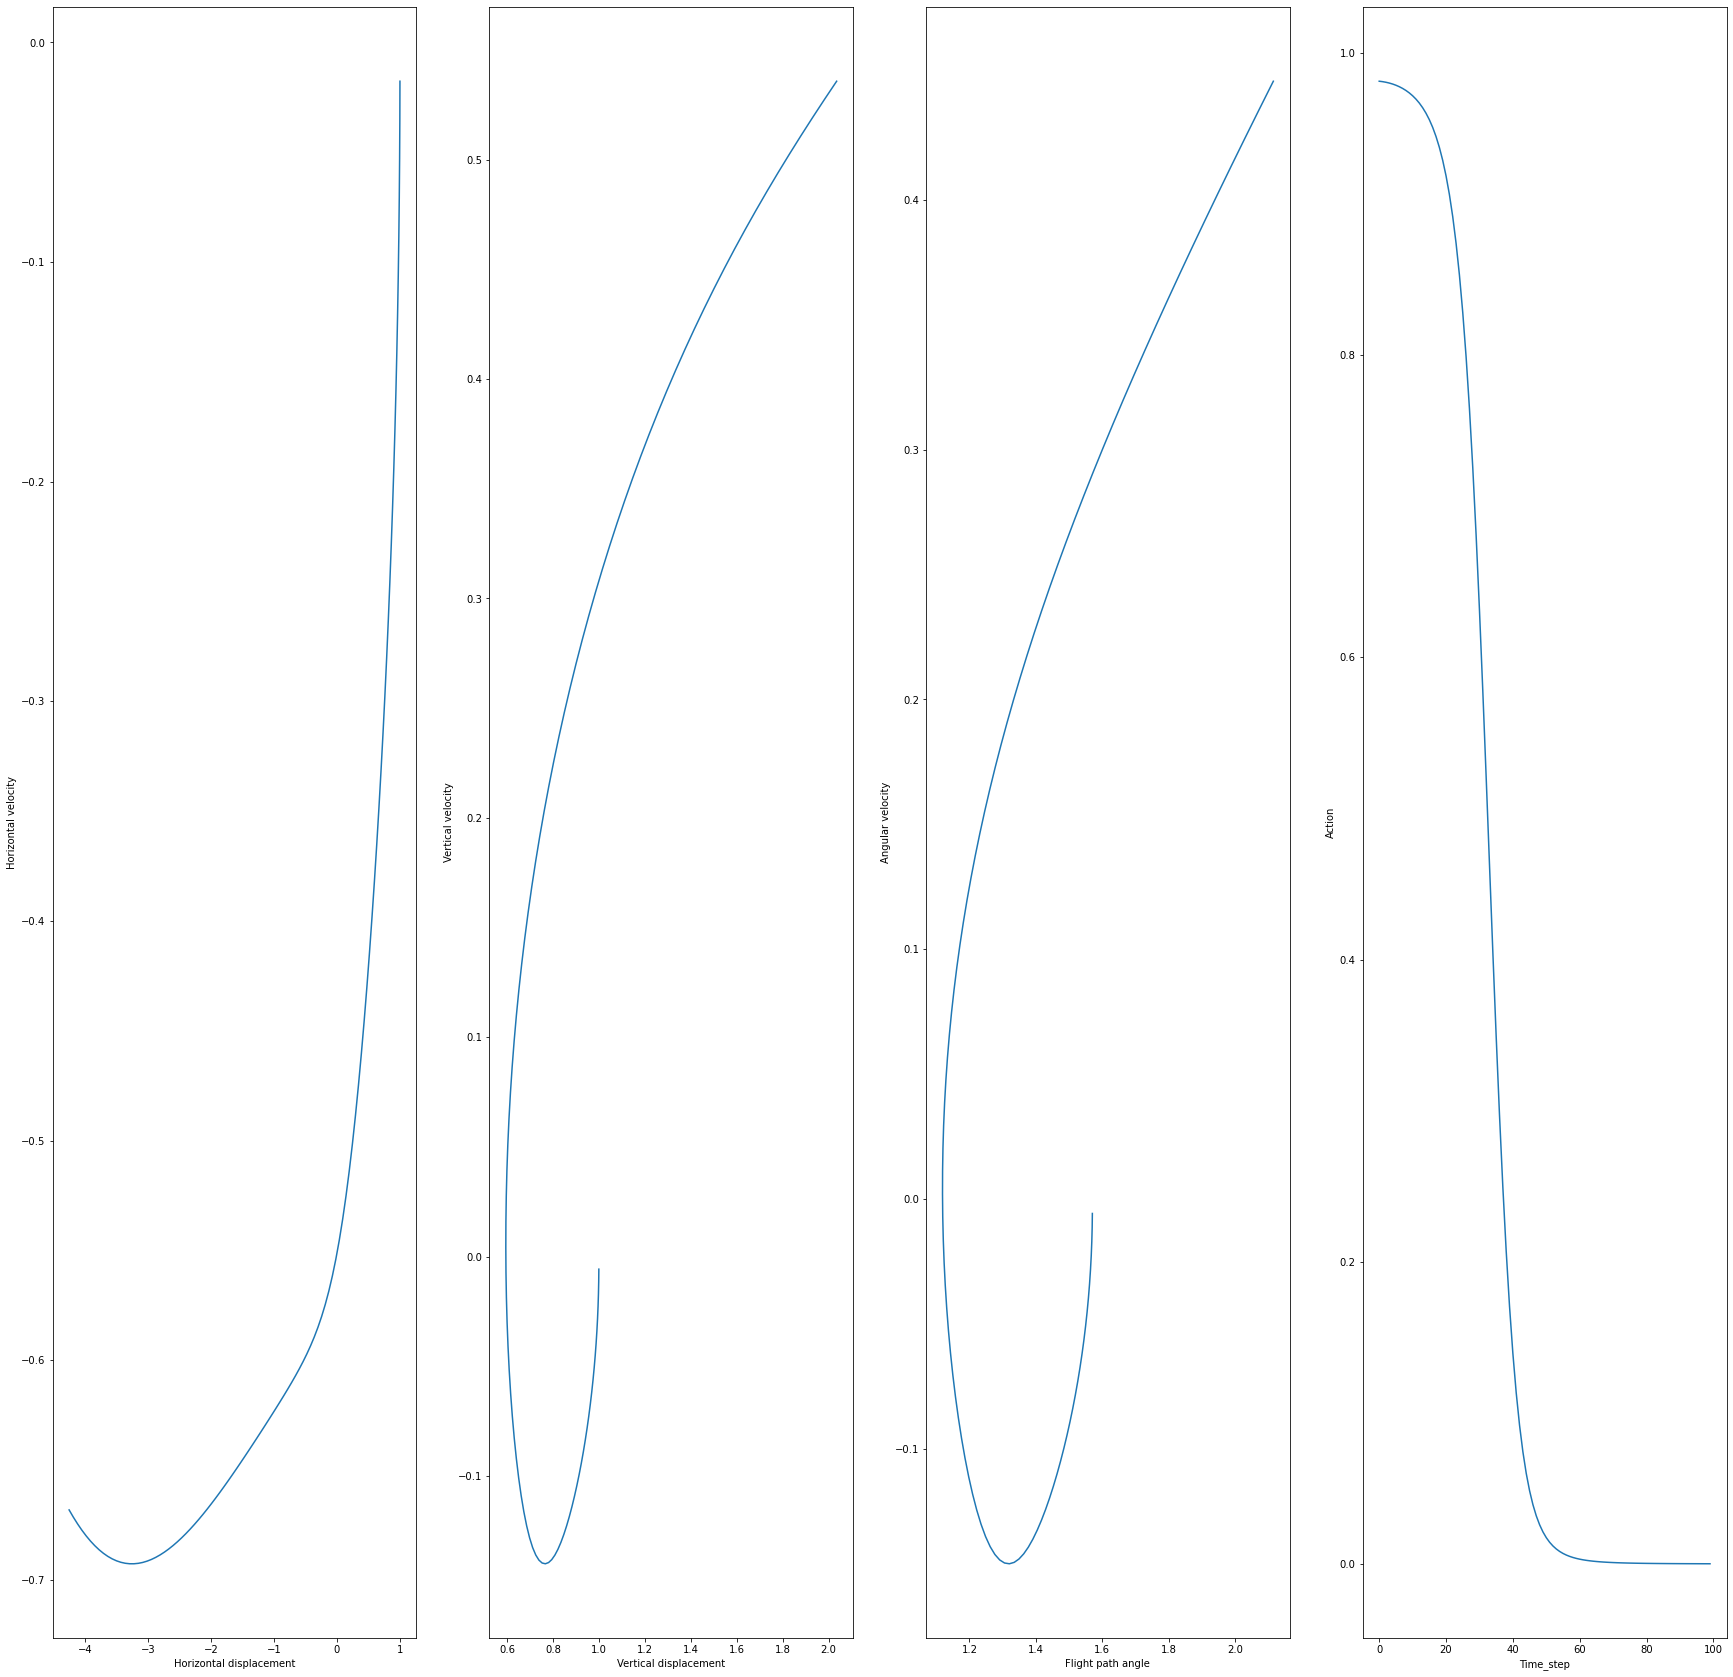

[27] loss: 117.803


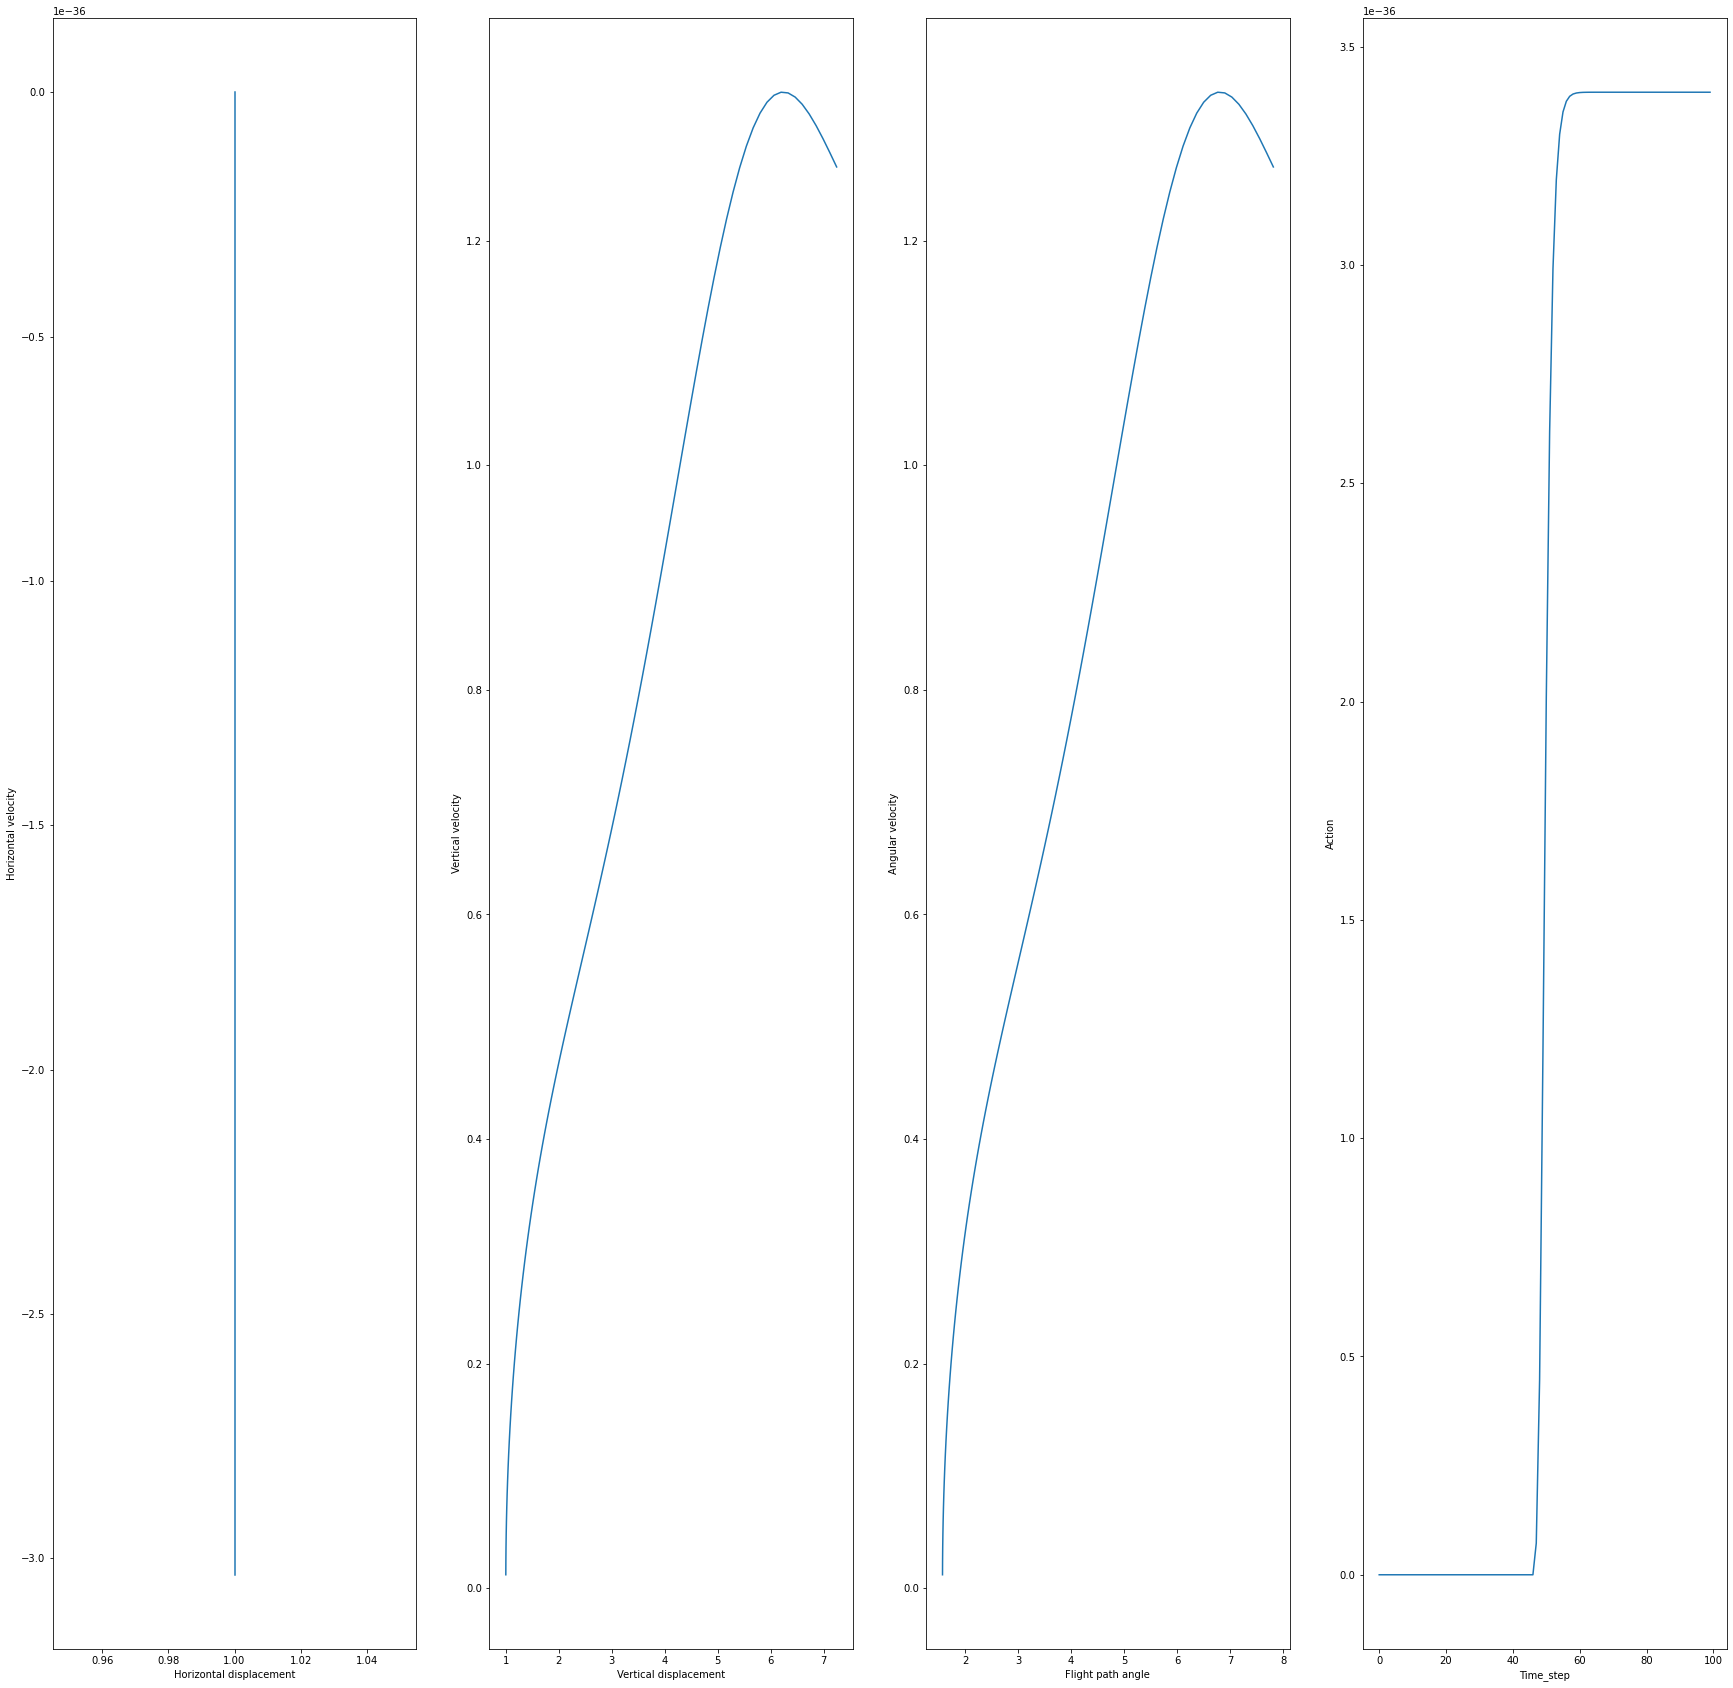

[28] loss: 117.803


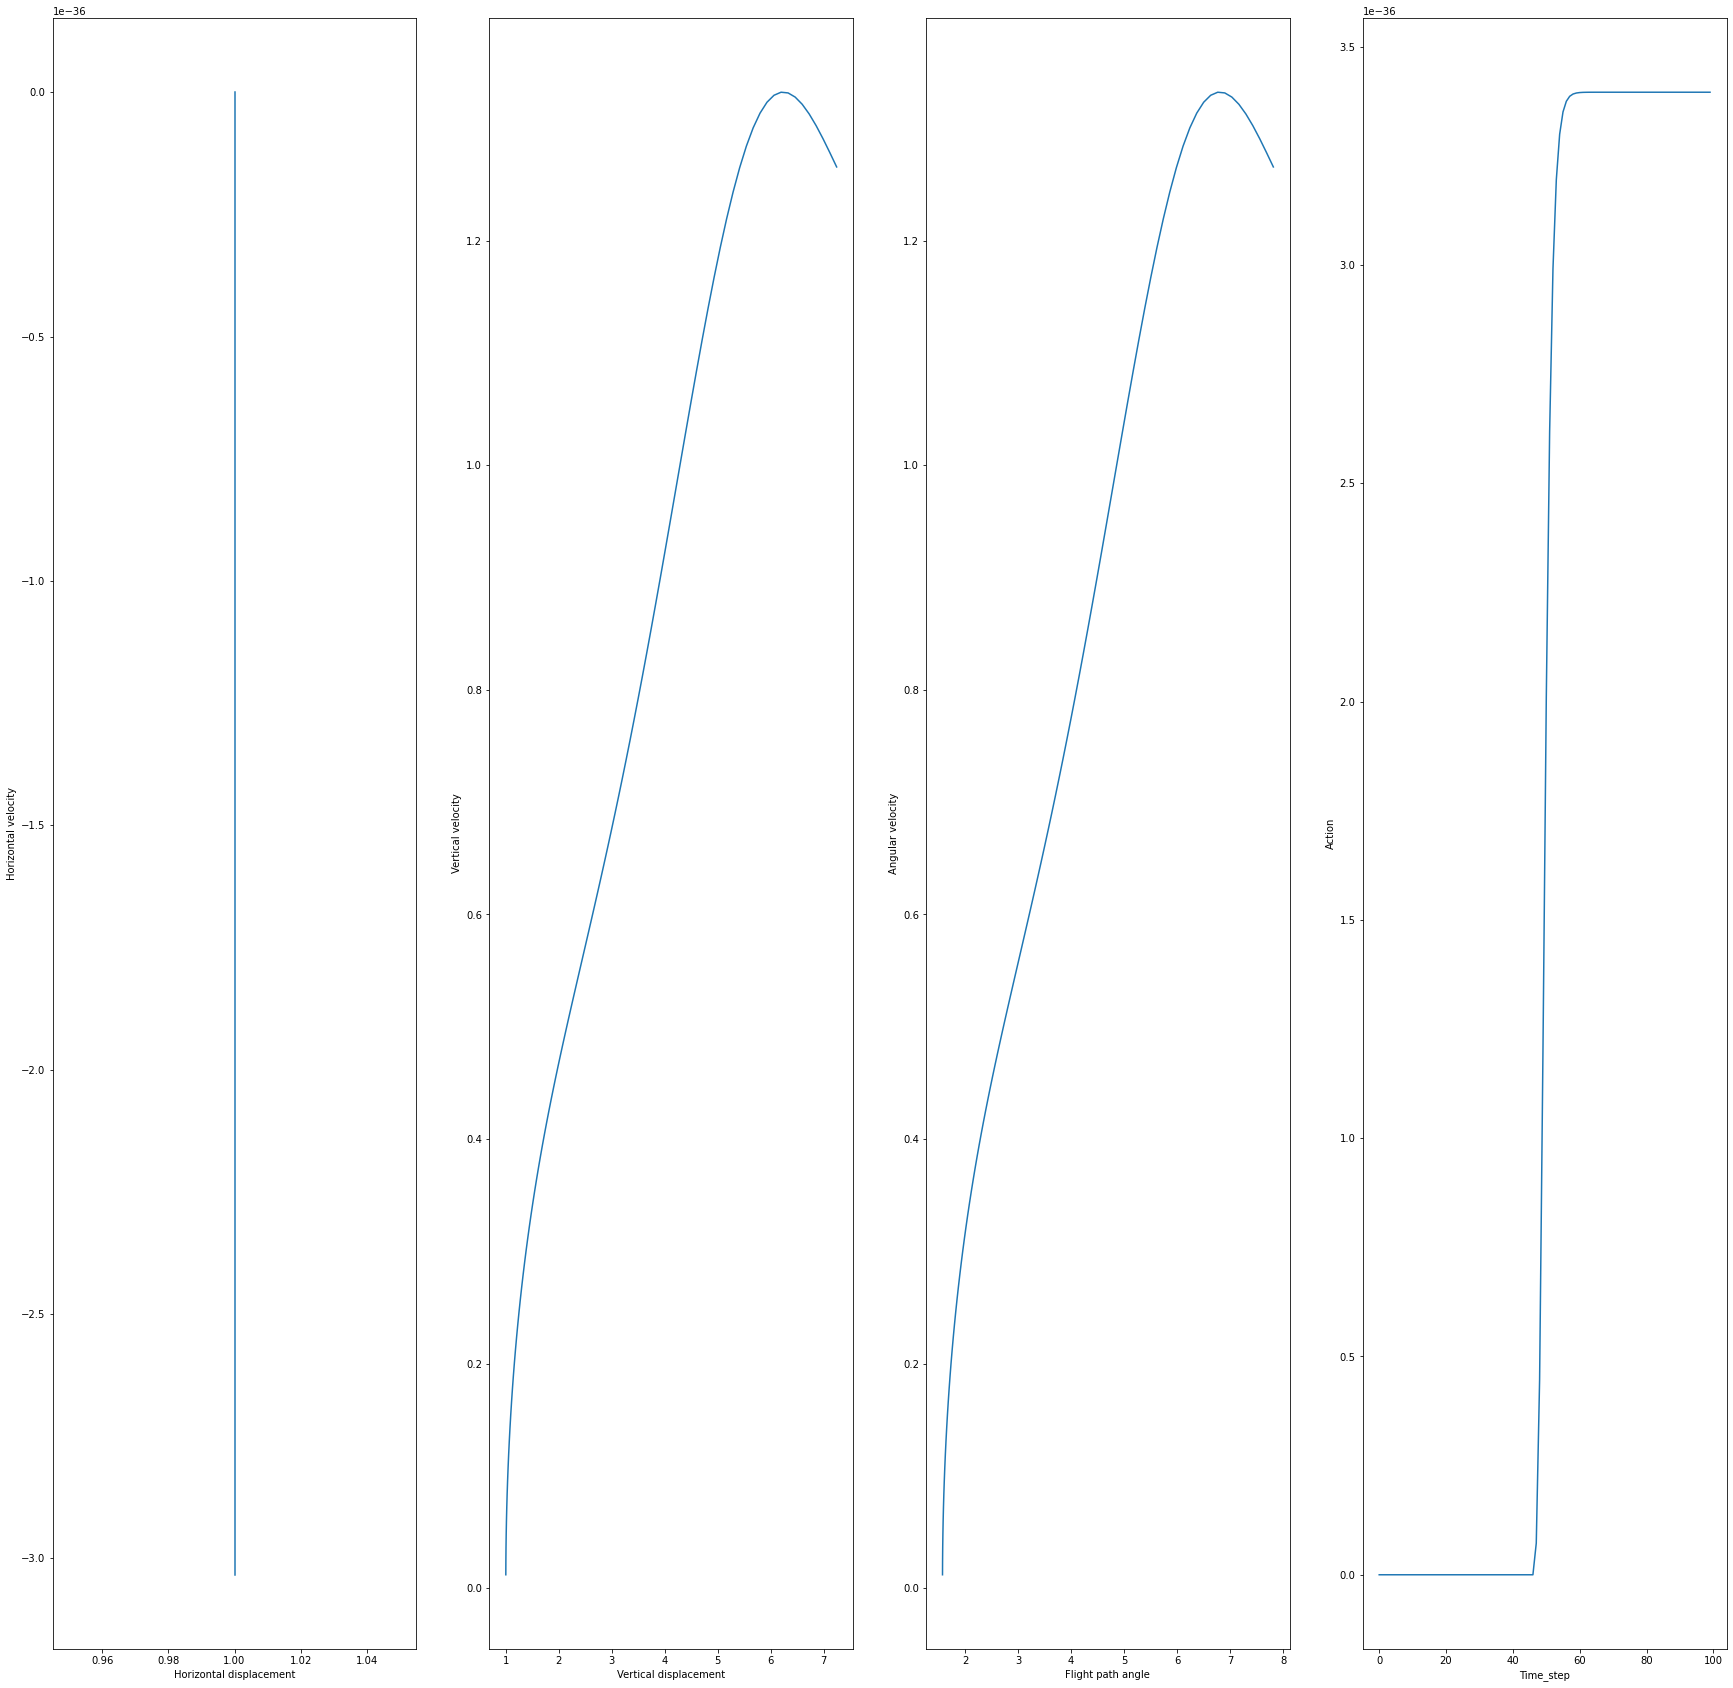

[29] loss: 117.803


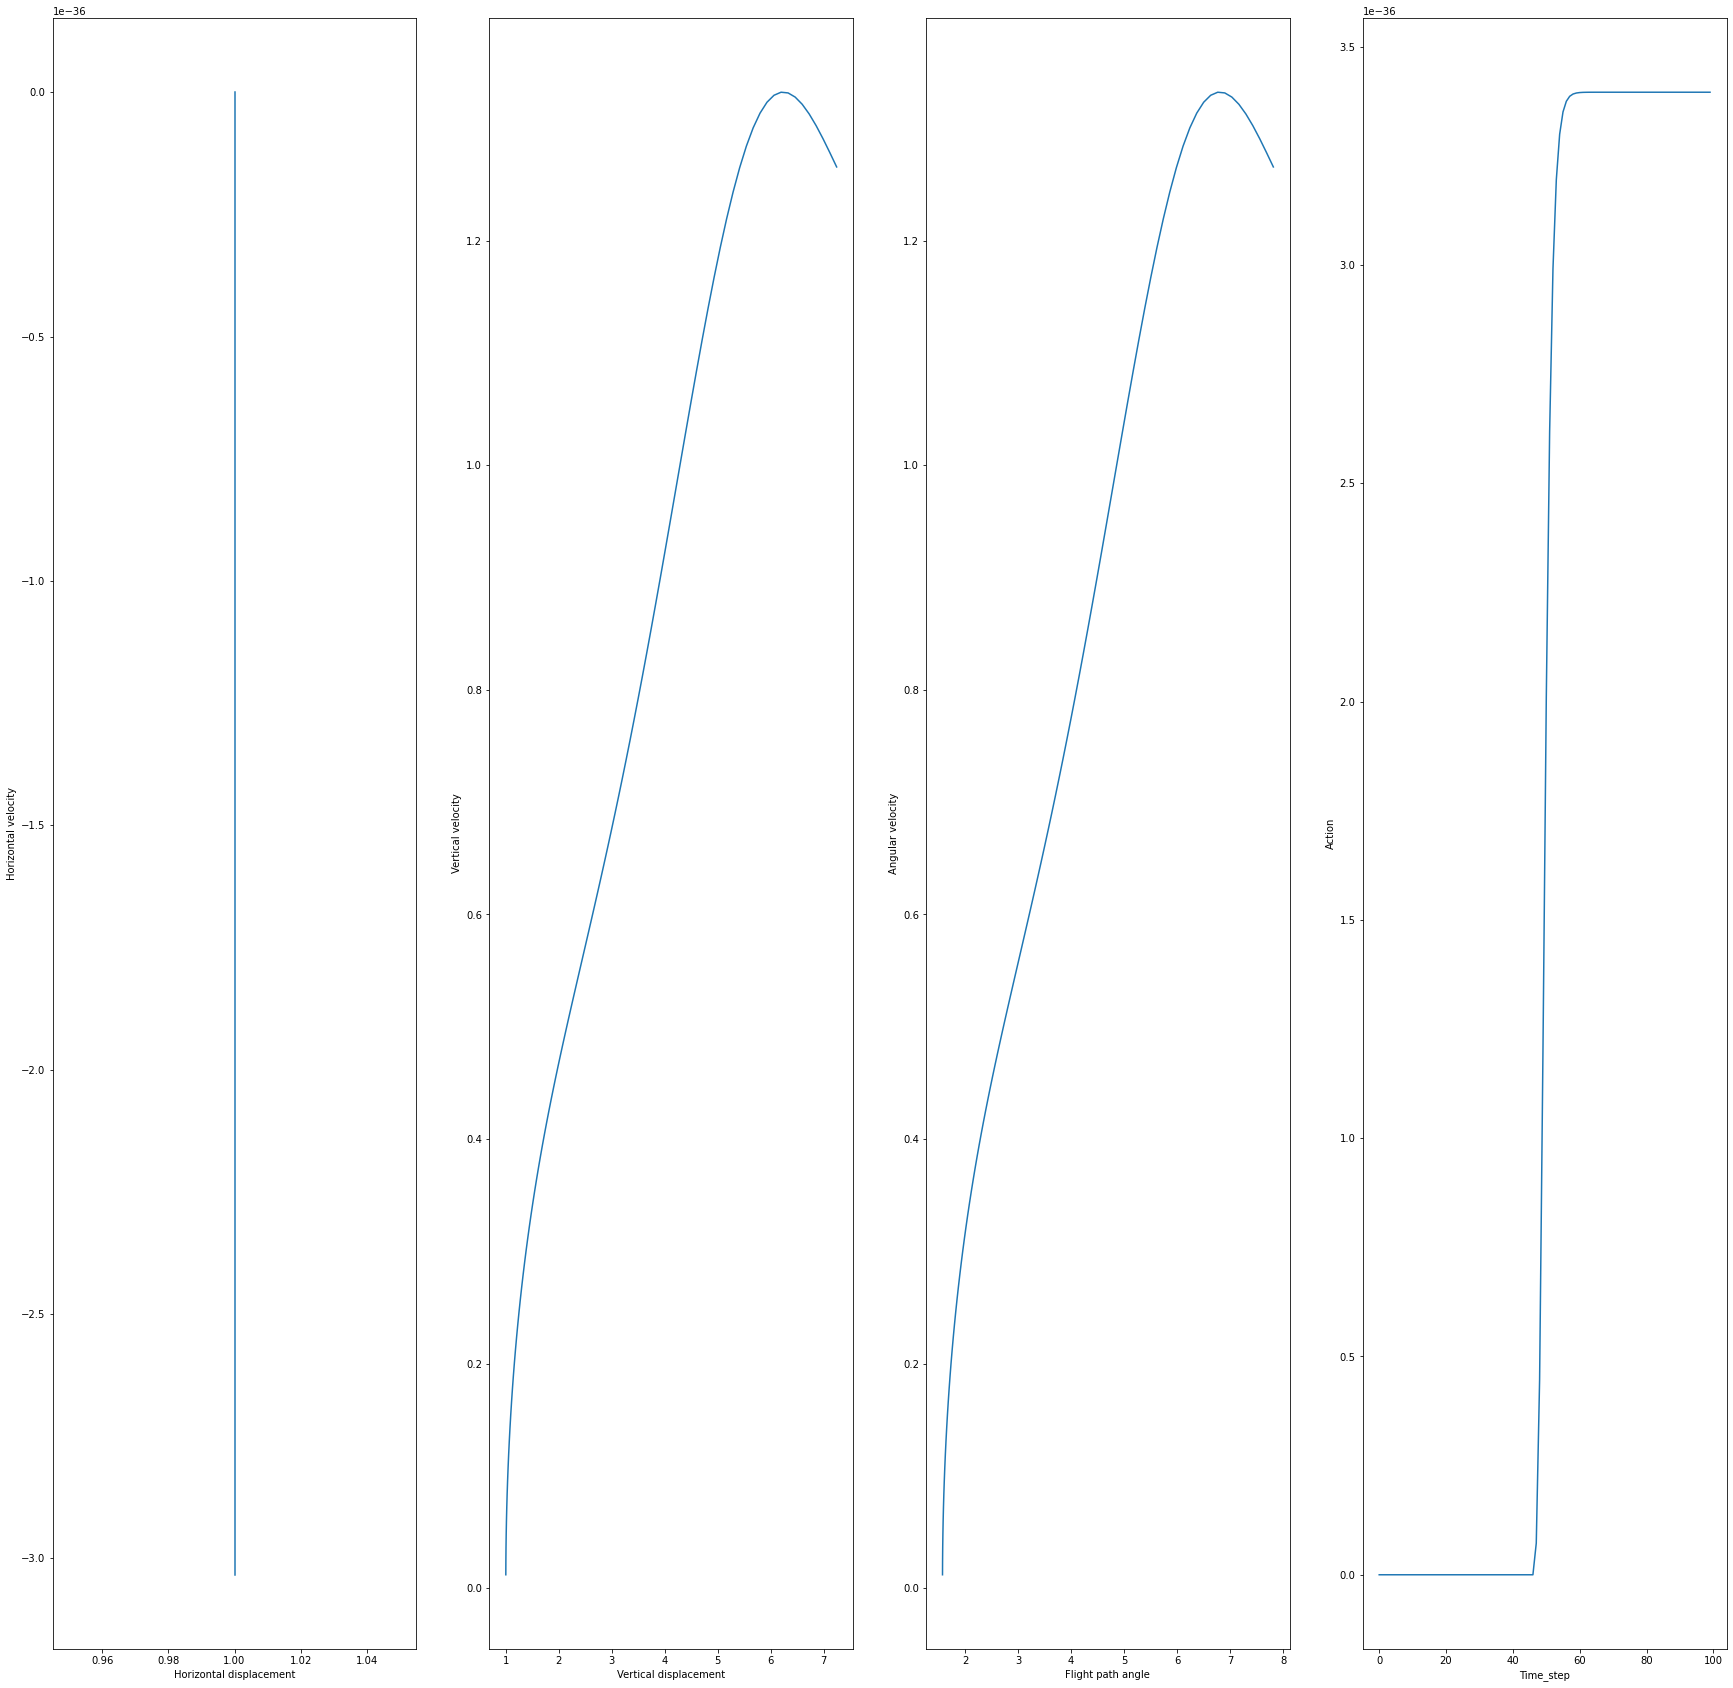

[30] loss: 117.803


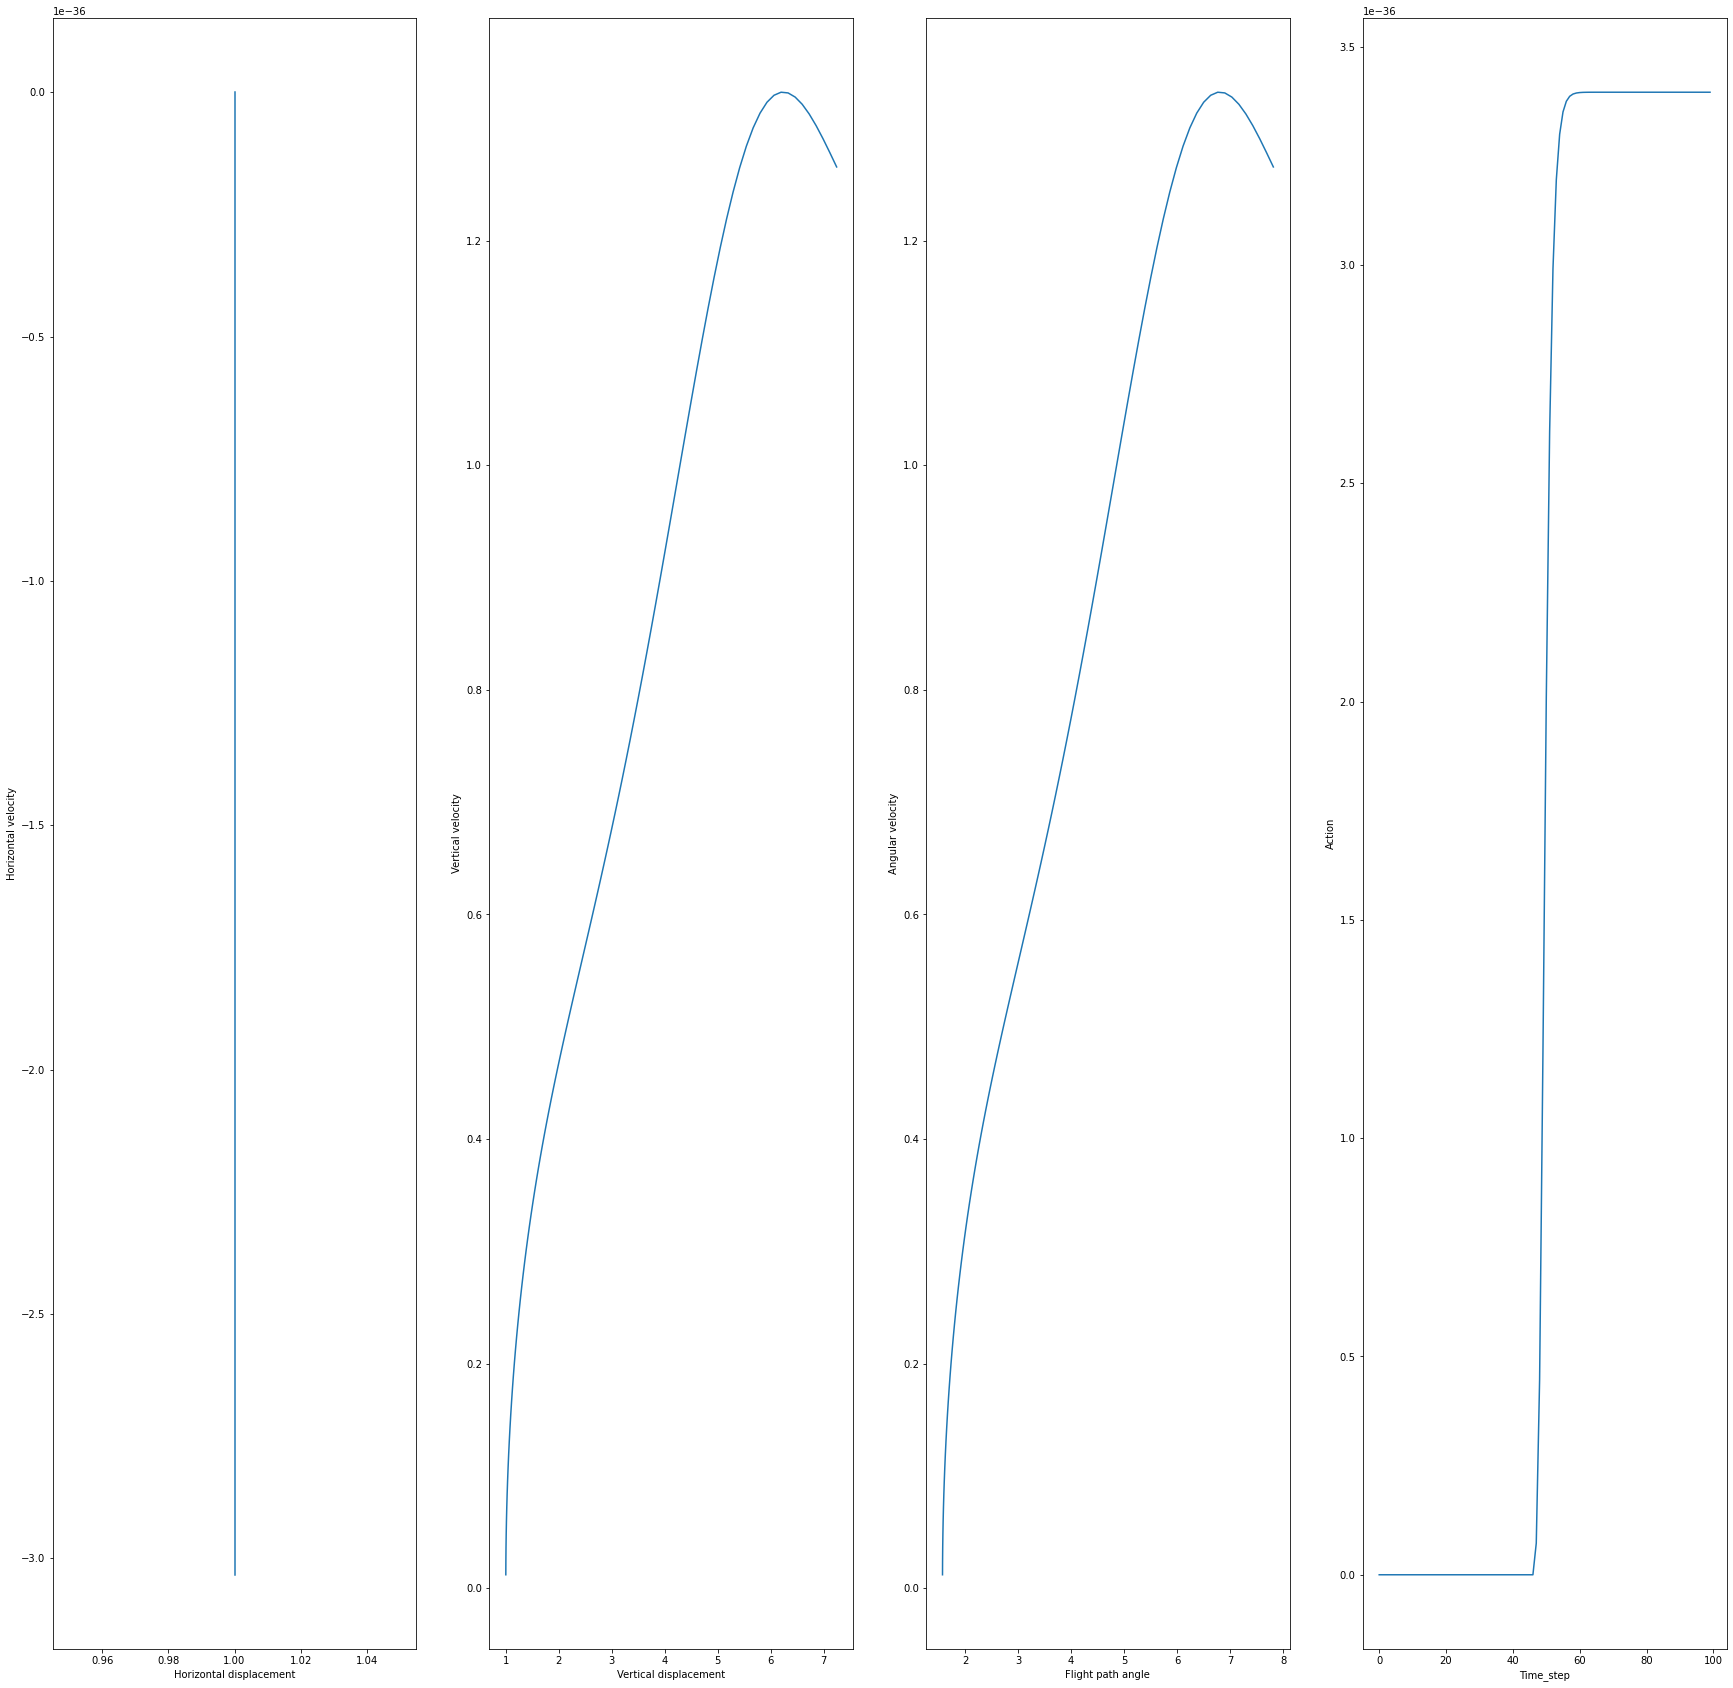

[31] loss: 117.803


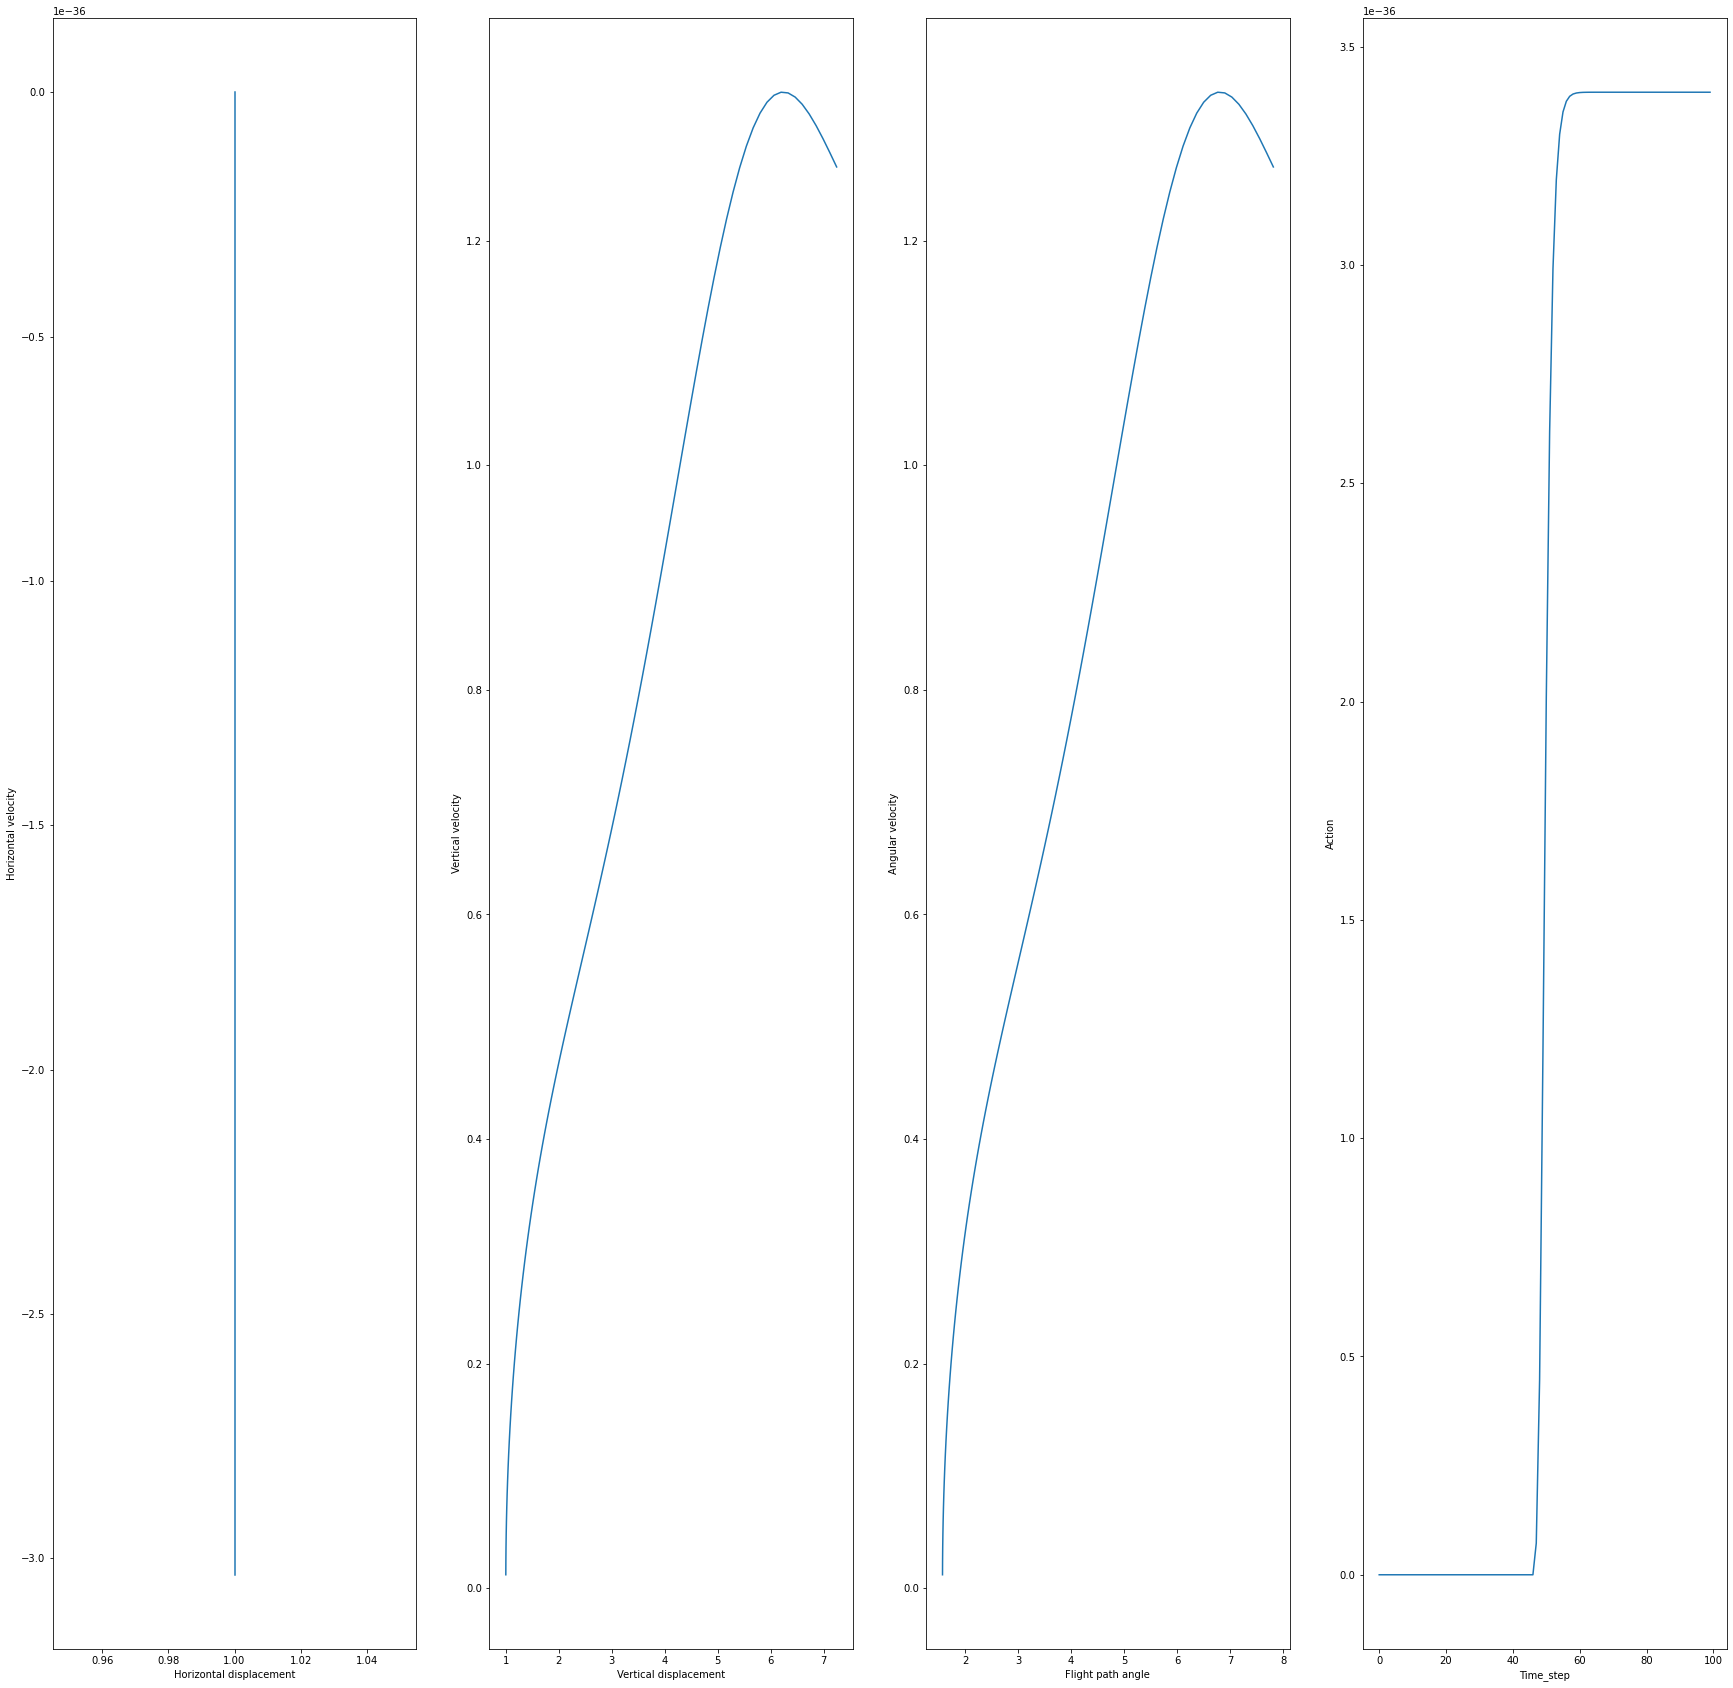

[32] loss: 117.803


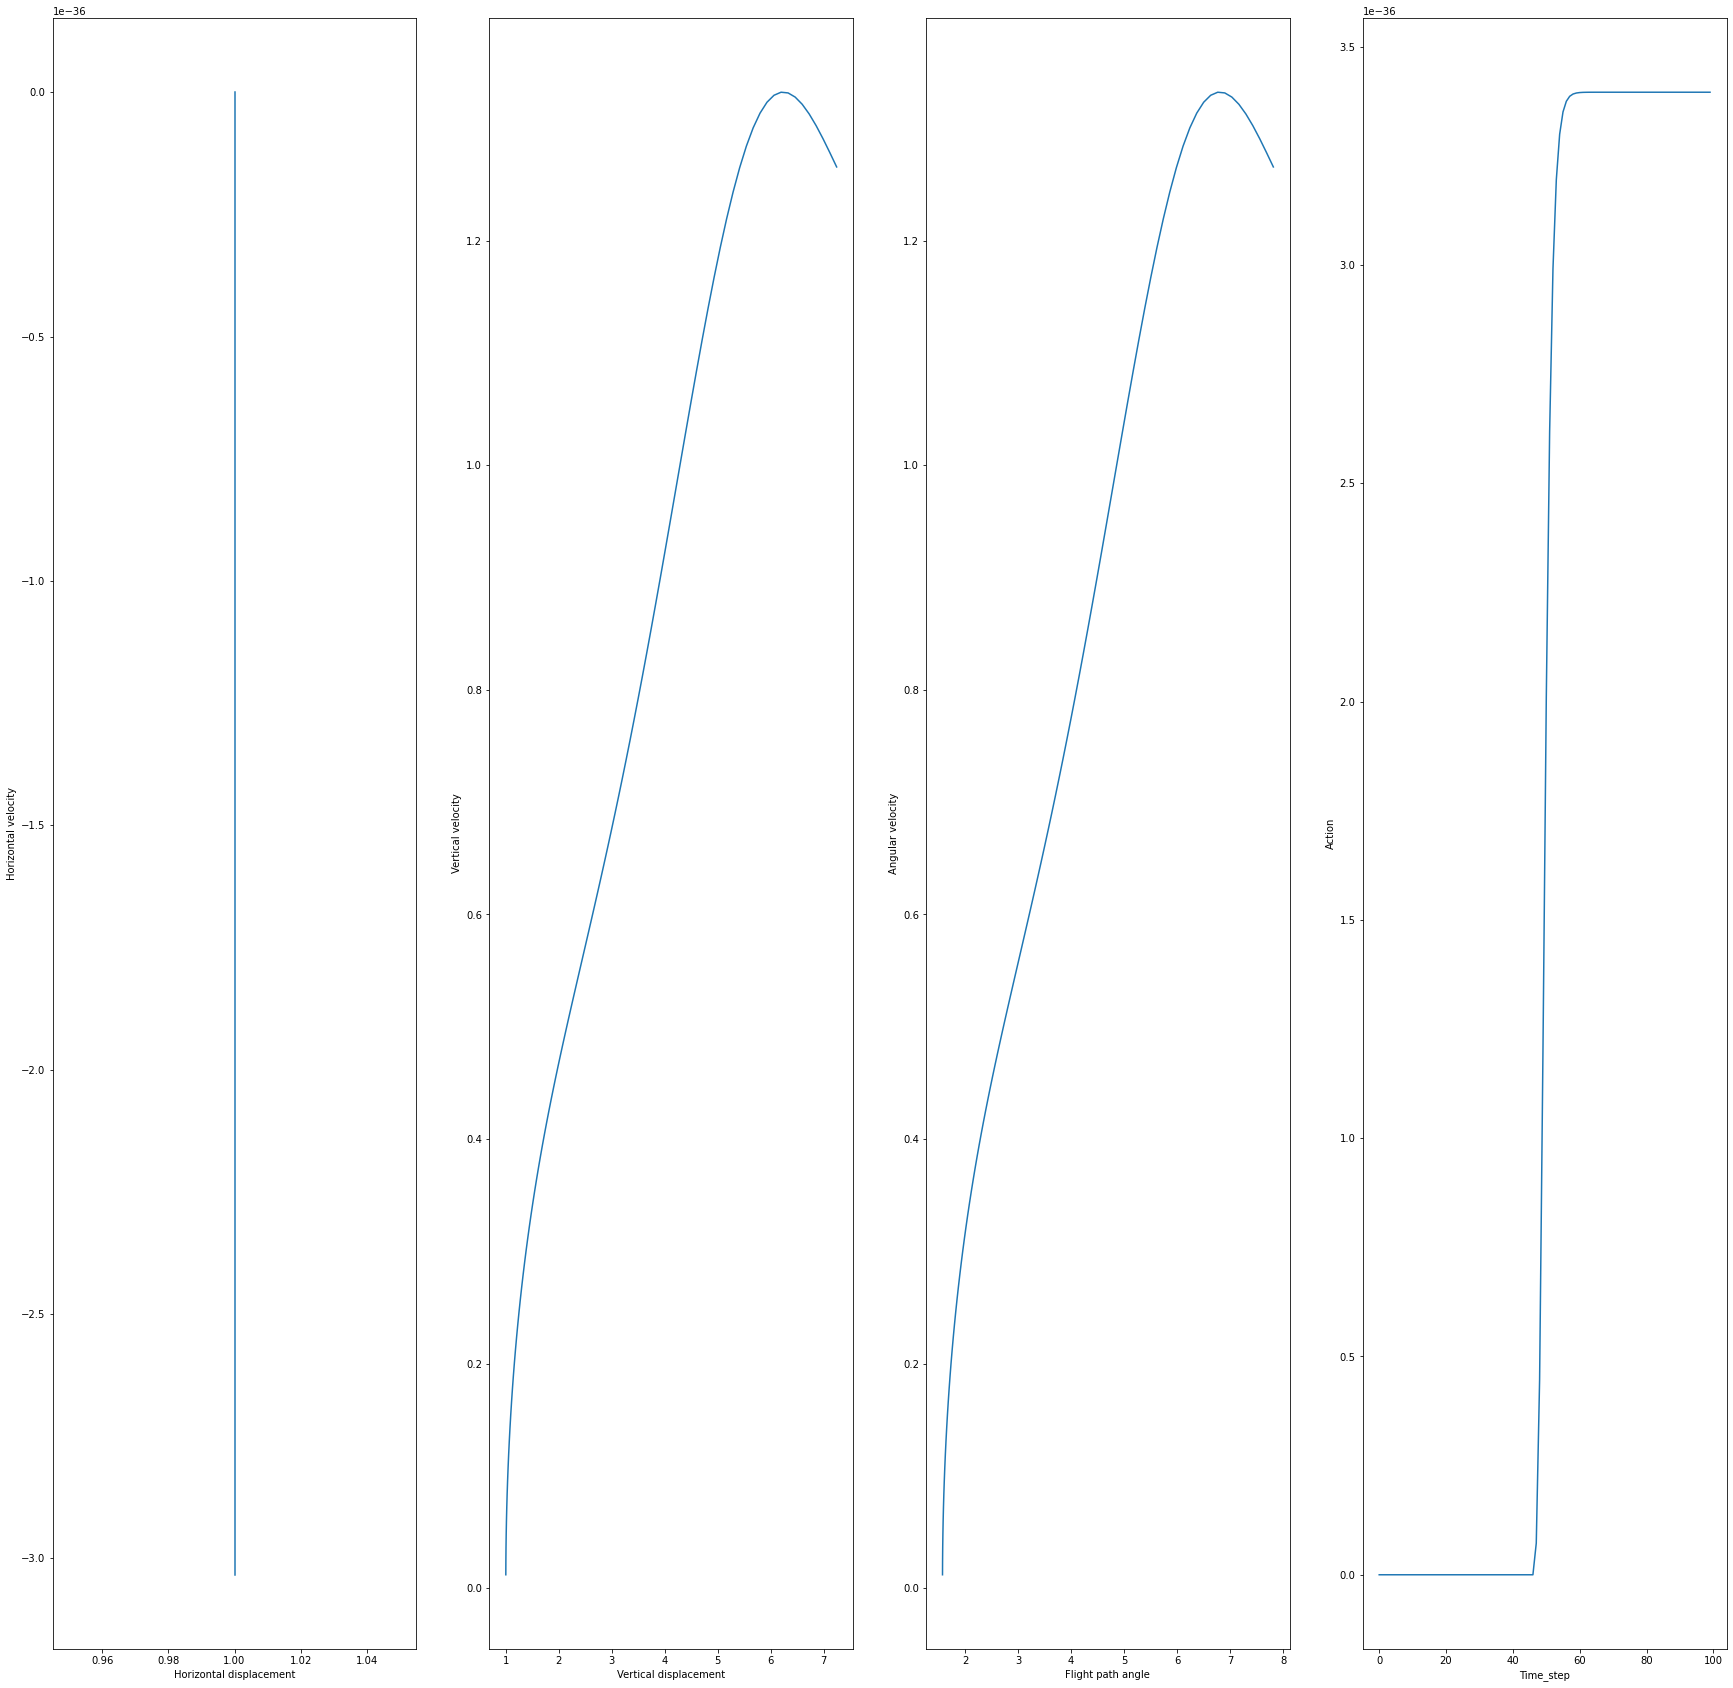

[33] loss: 117.803


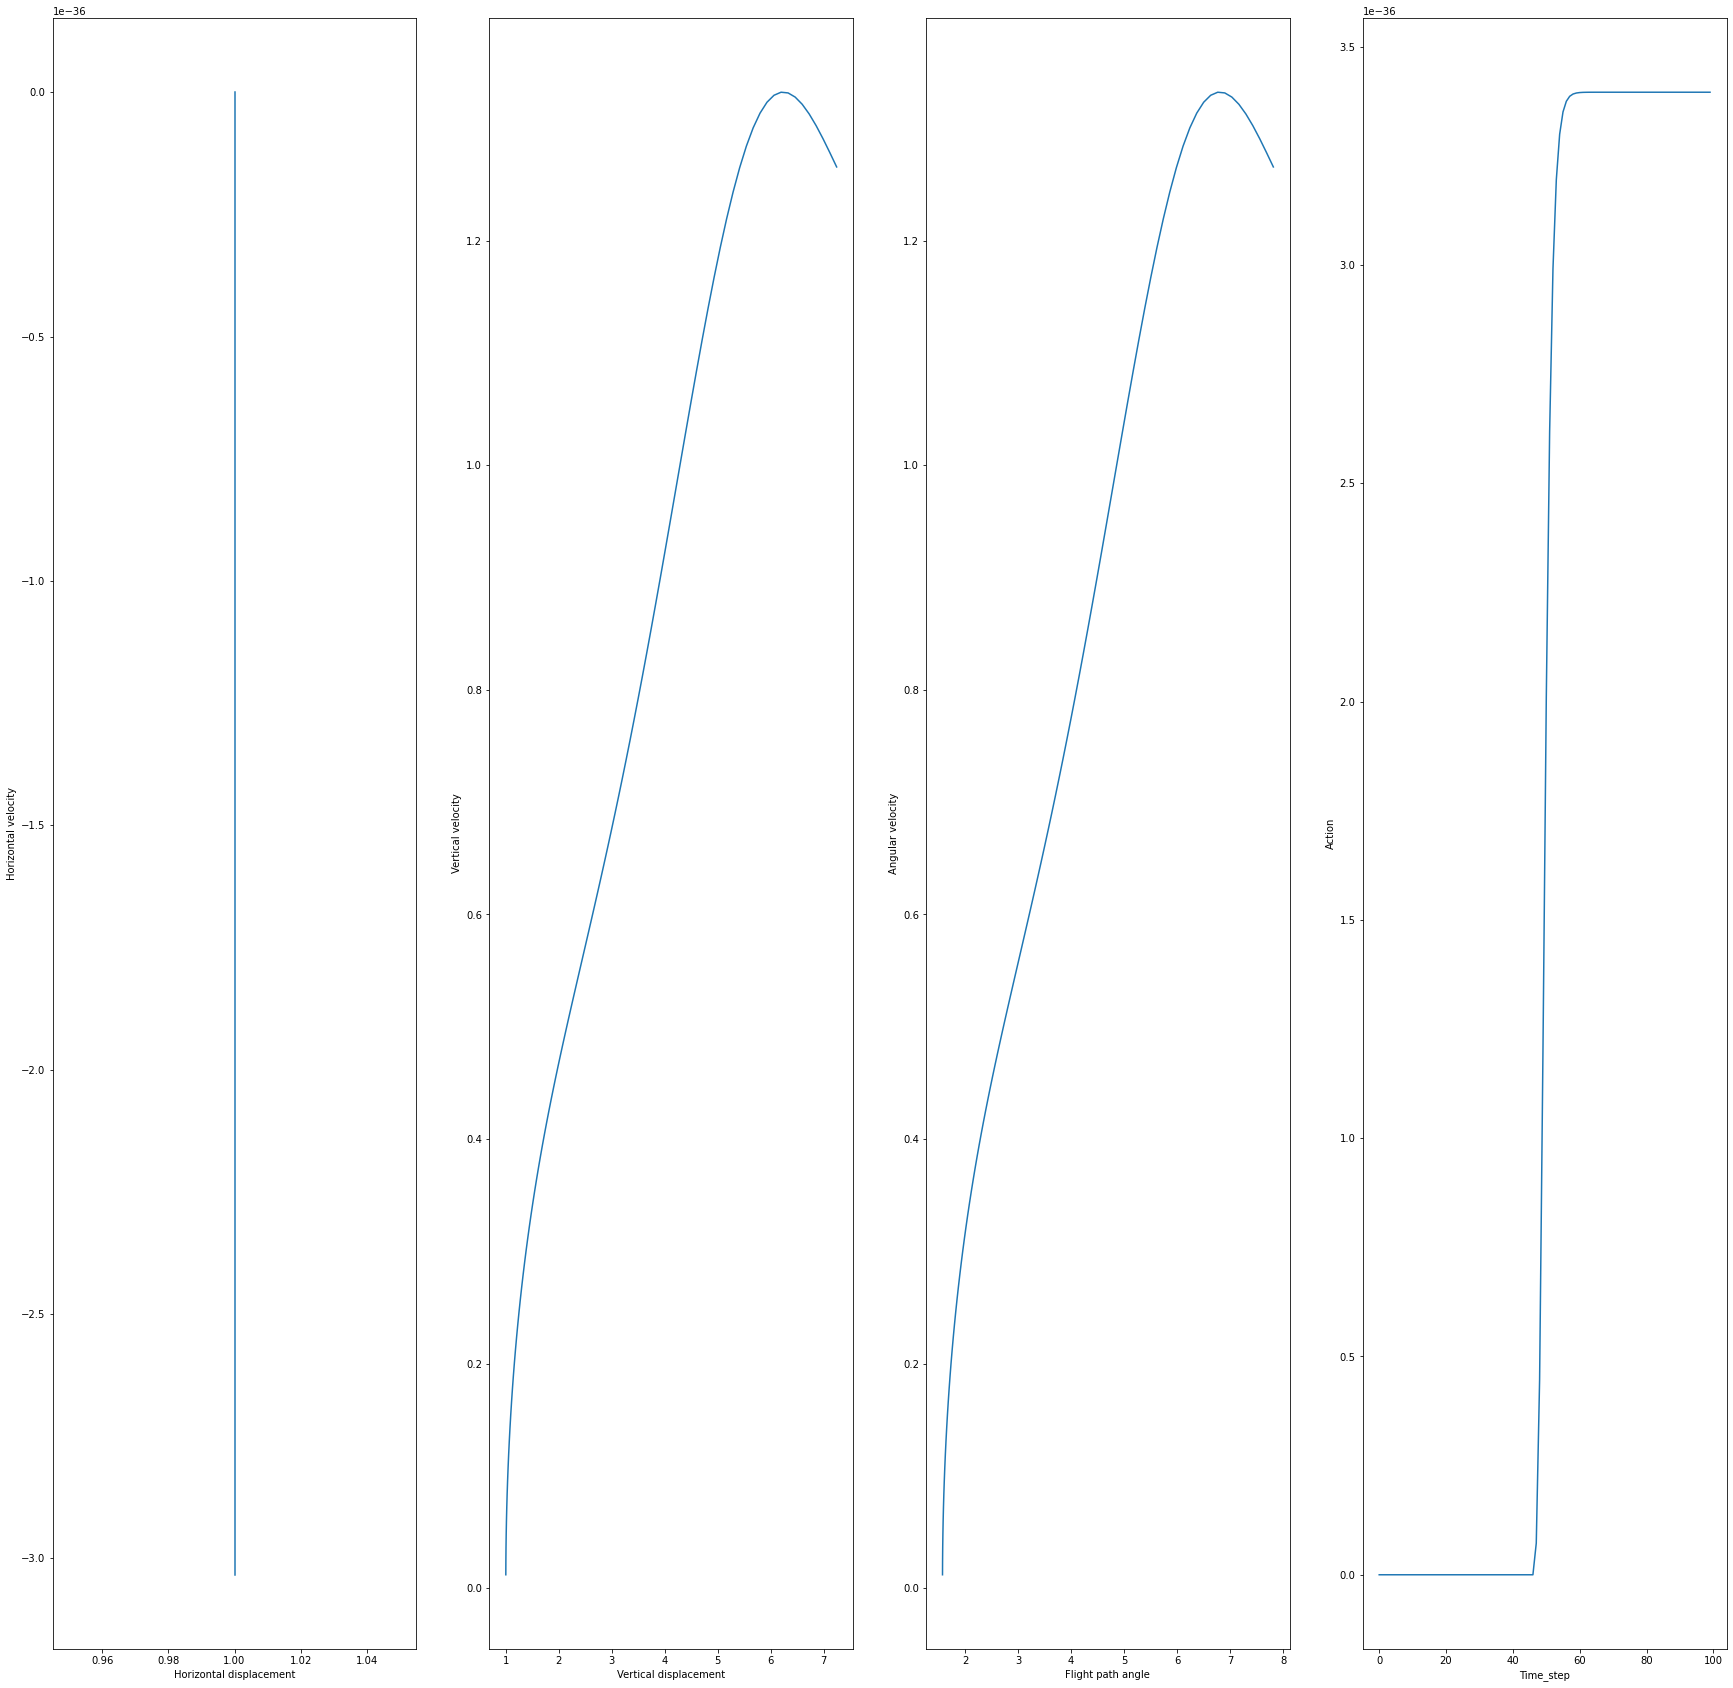

[34] loss: 117.803


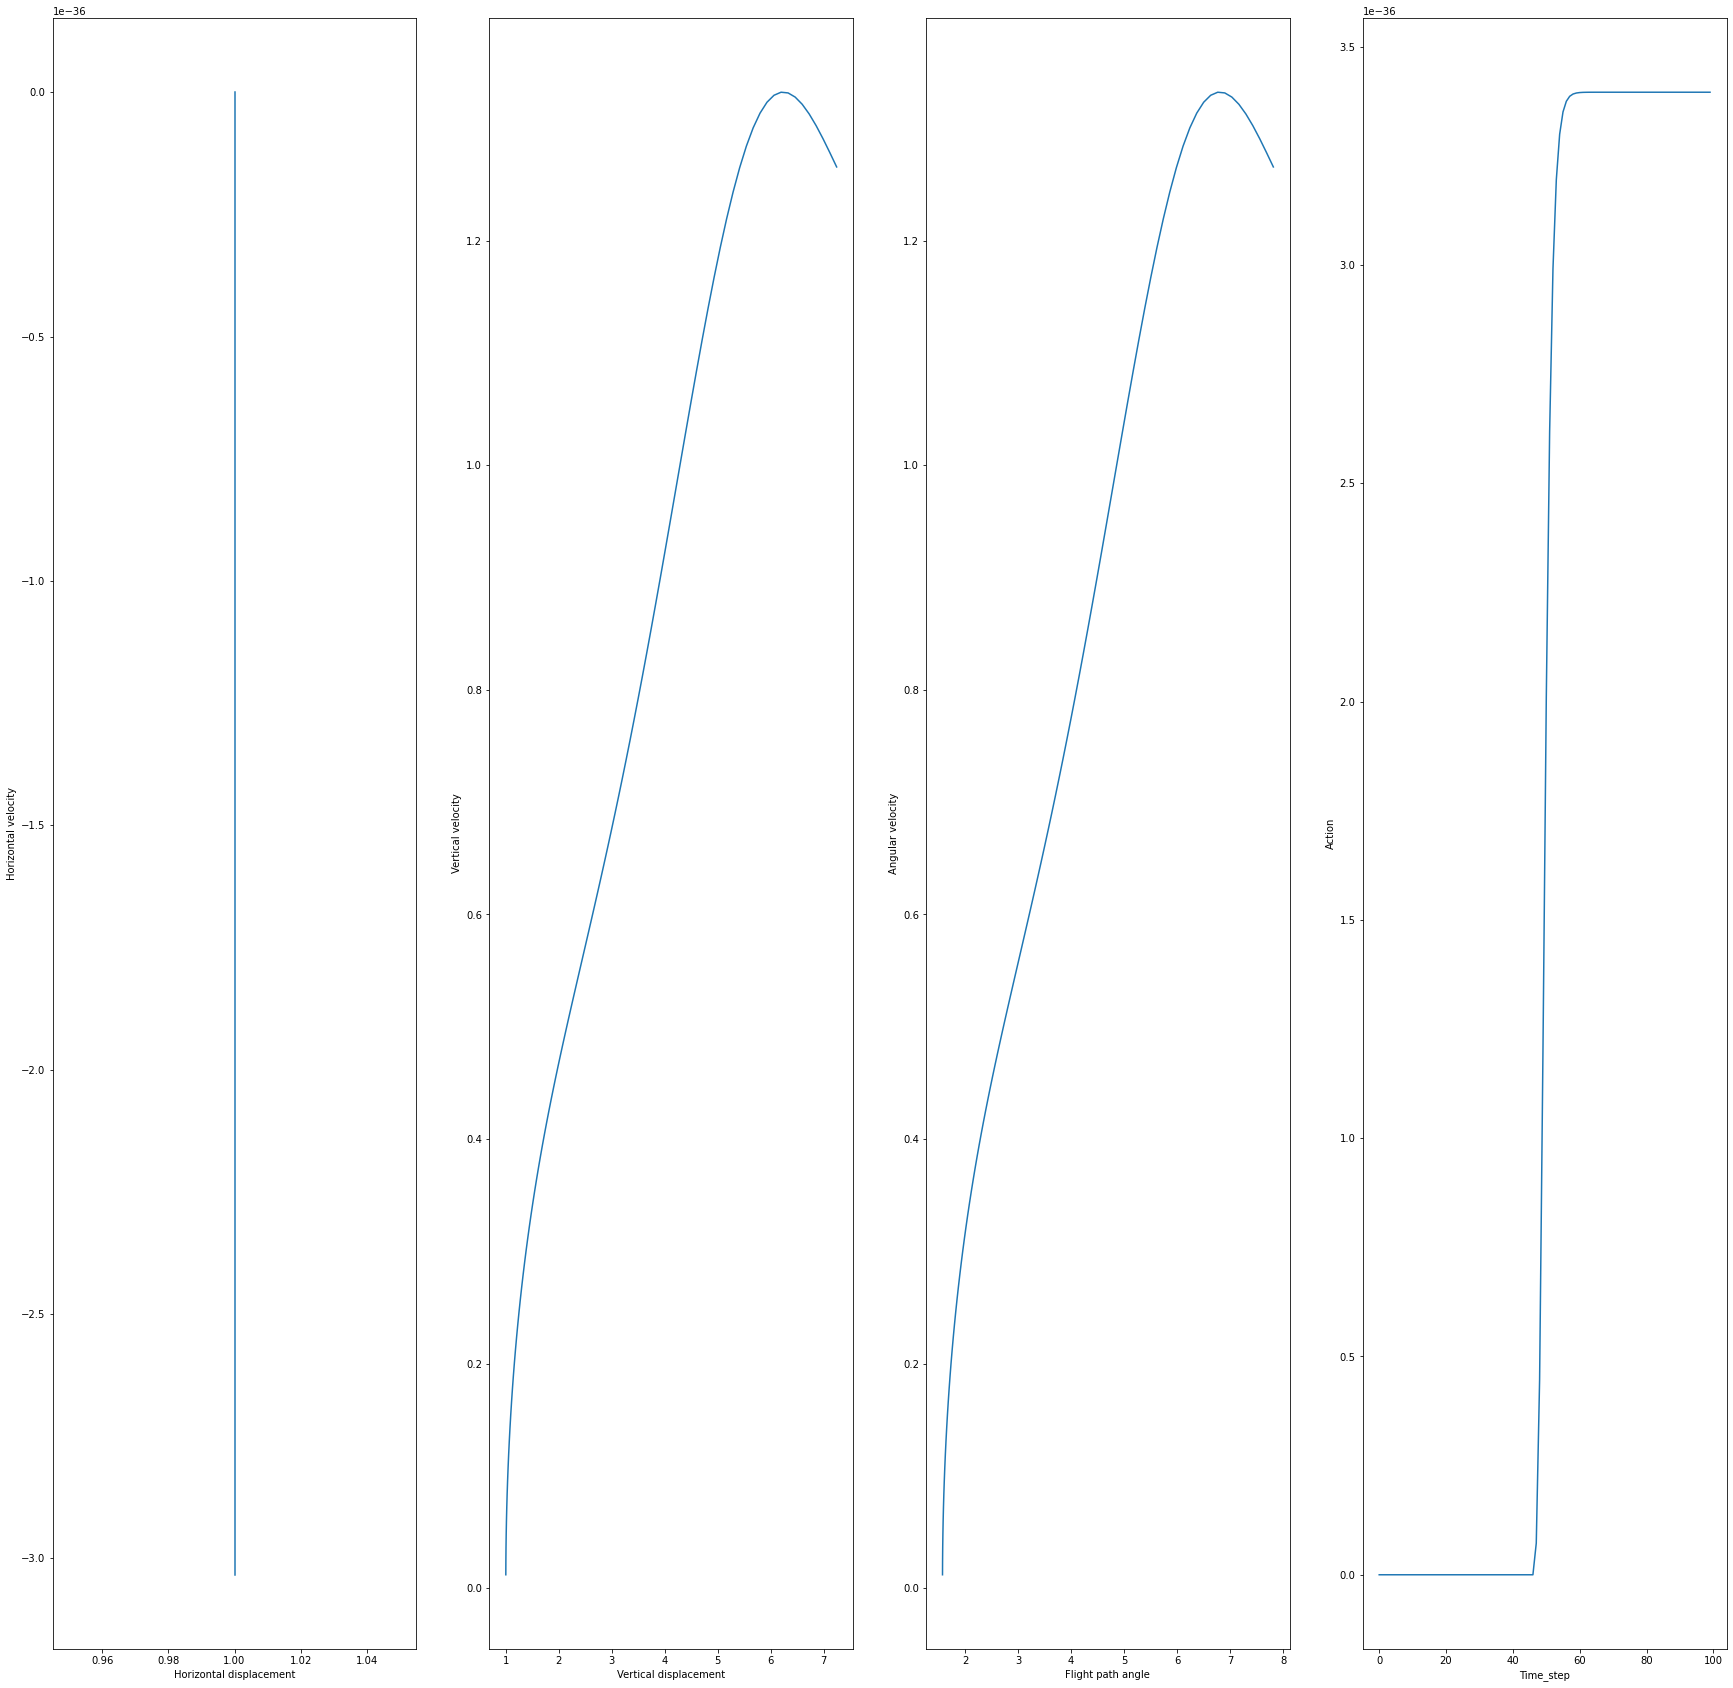

[35] loss: 117.803


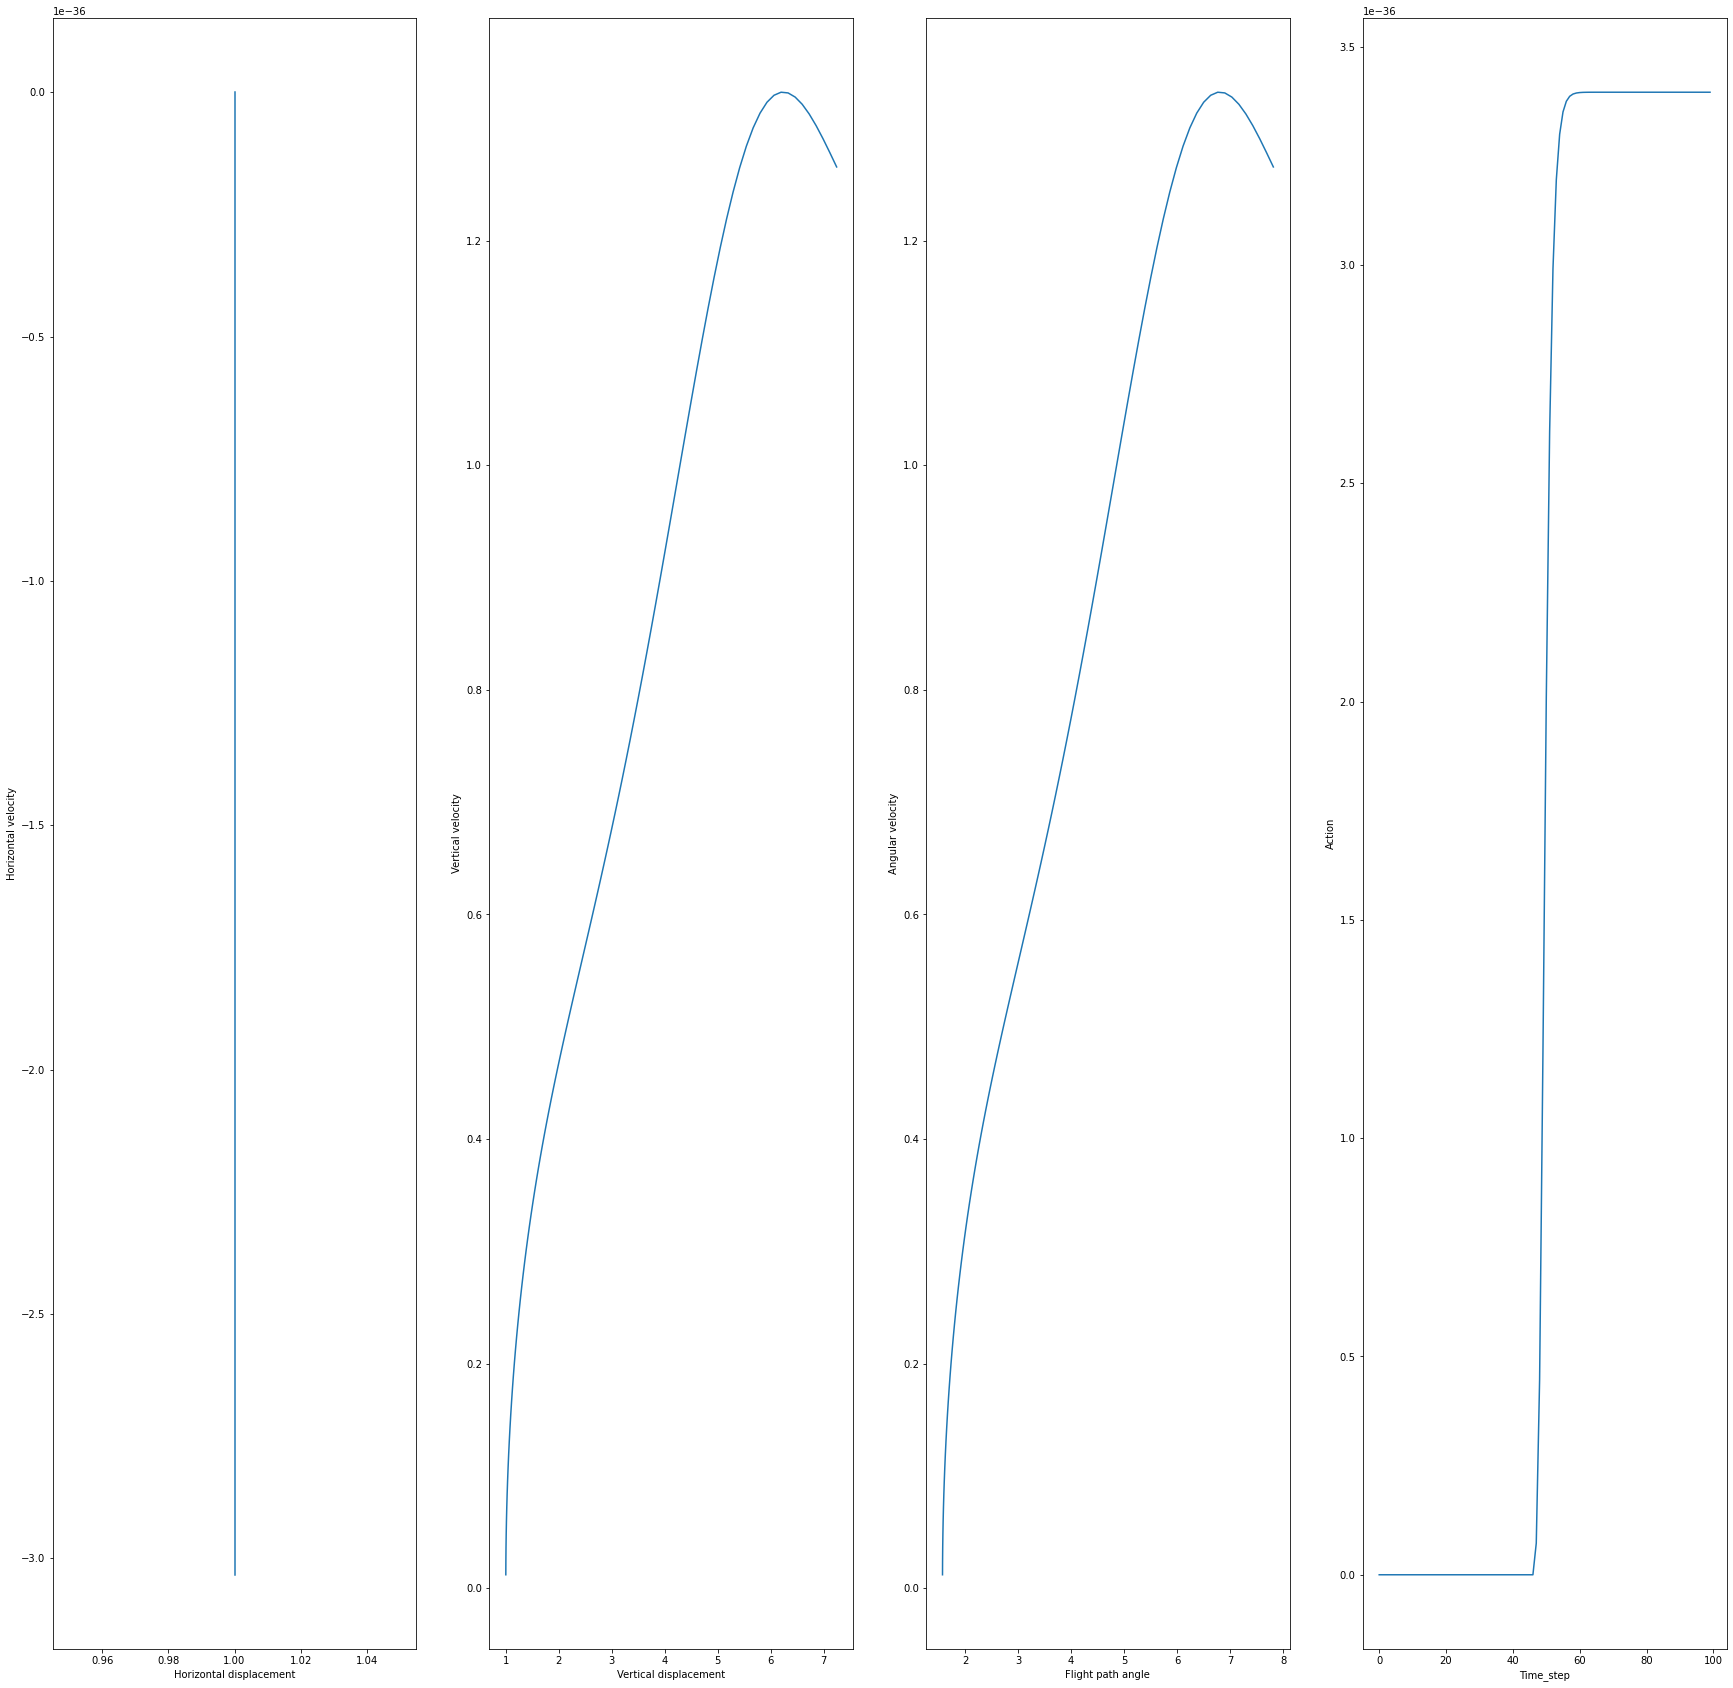

[36] loss: 117.803


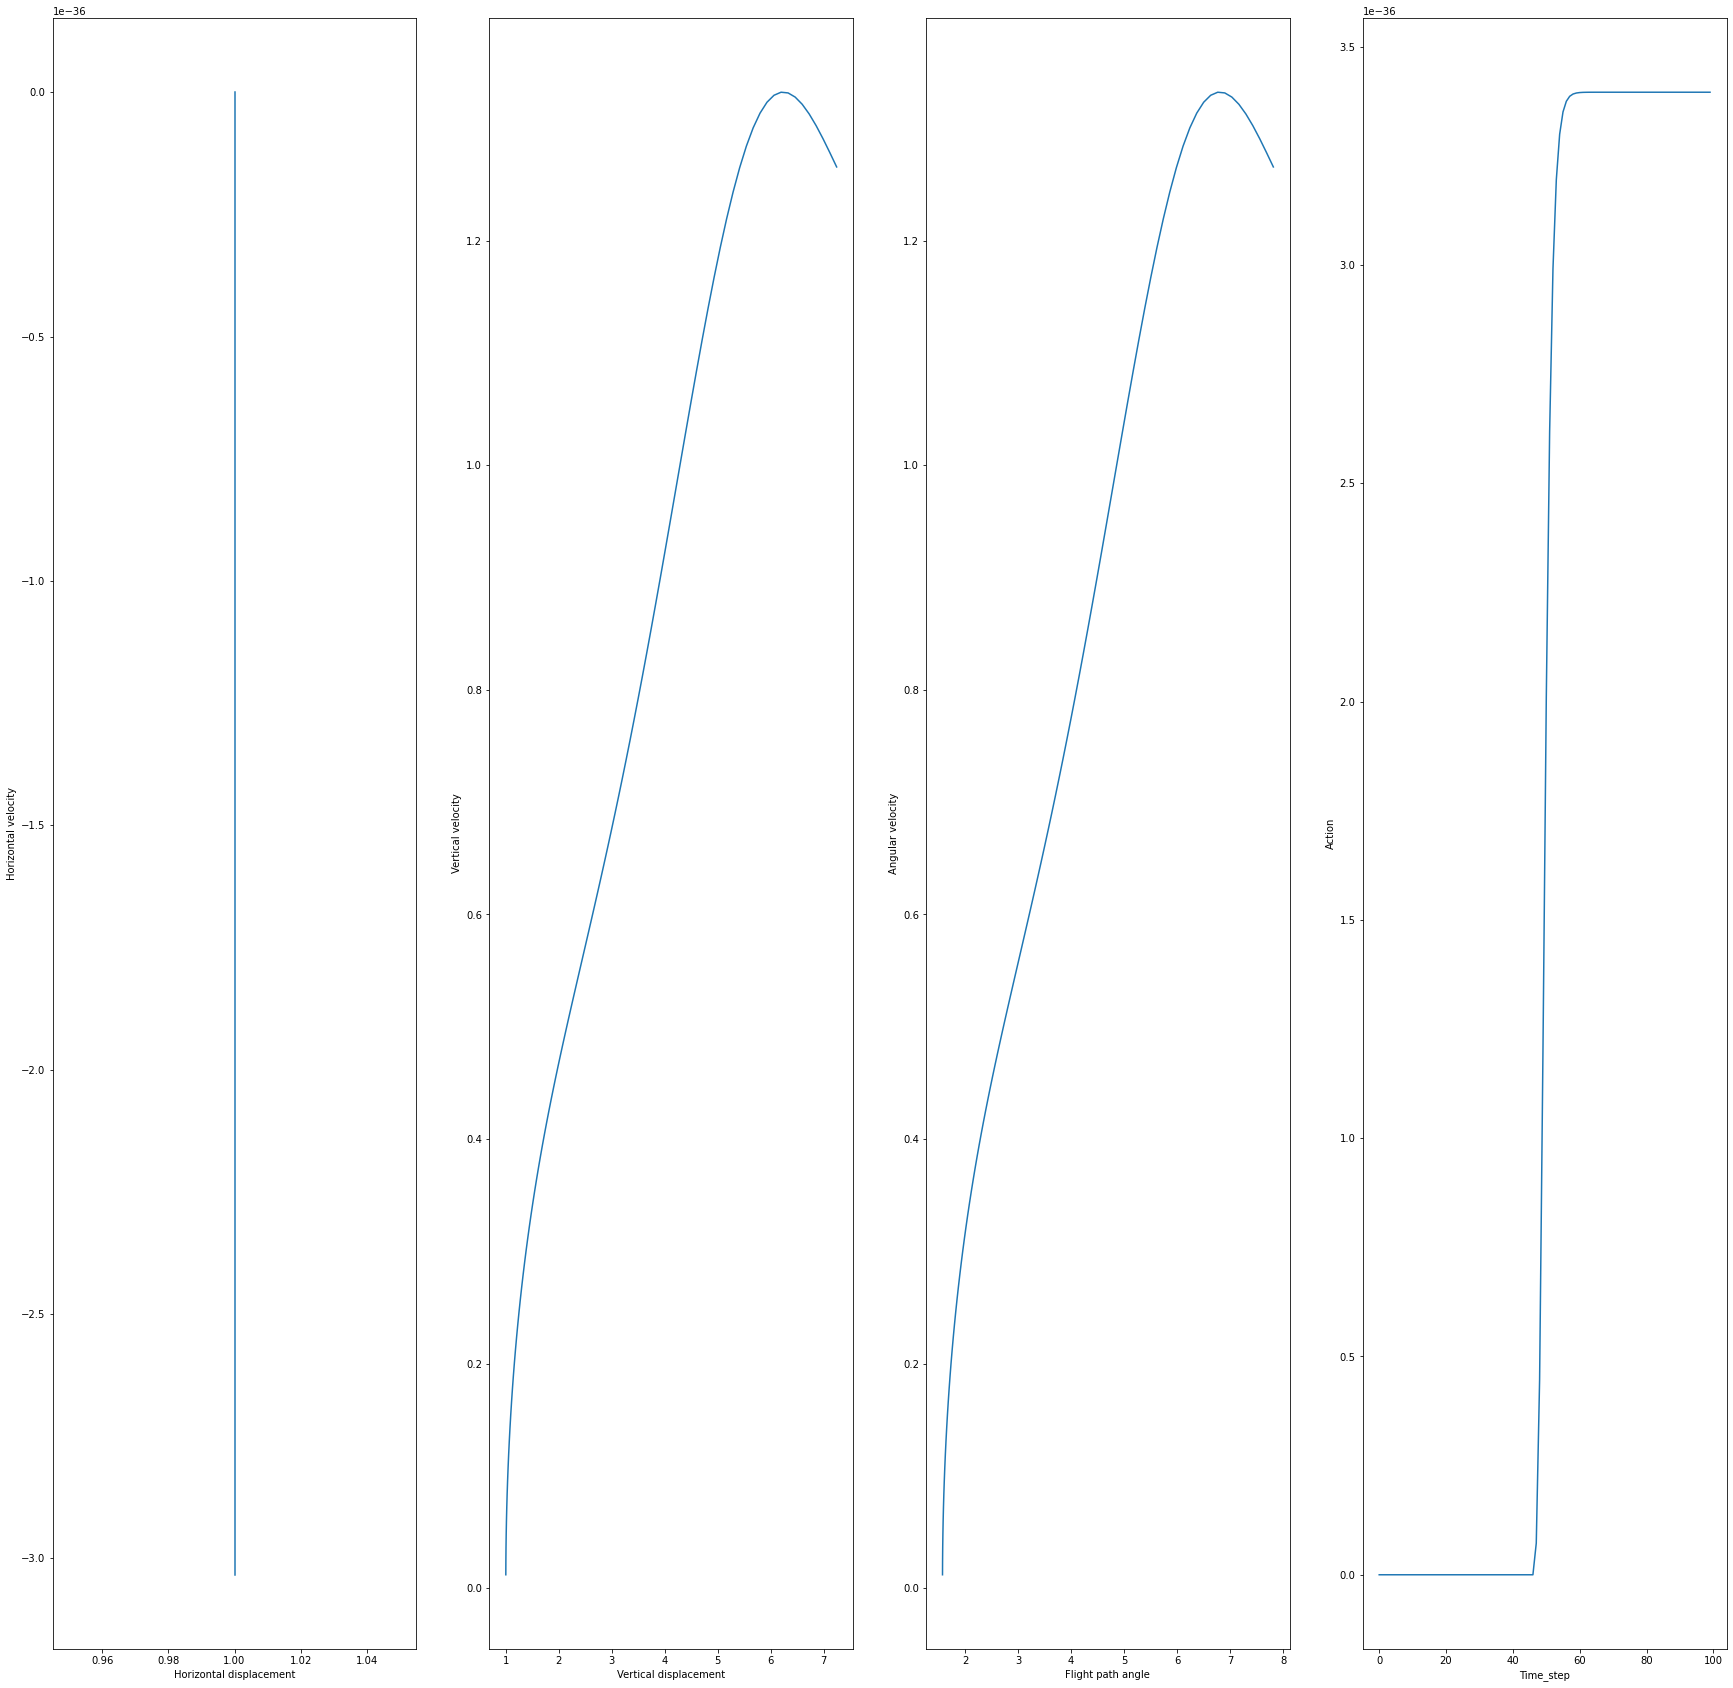

[37] loss: 117.803


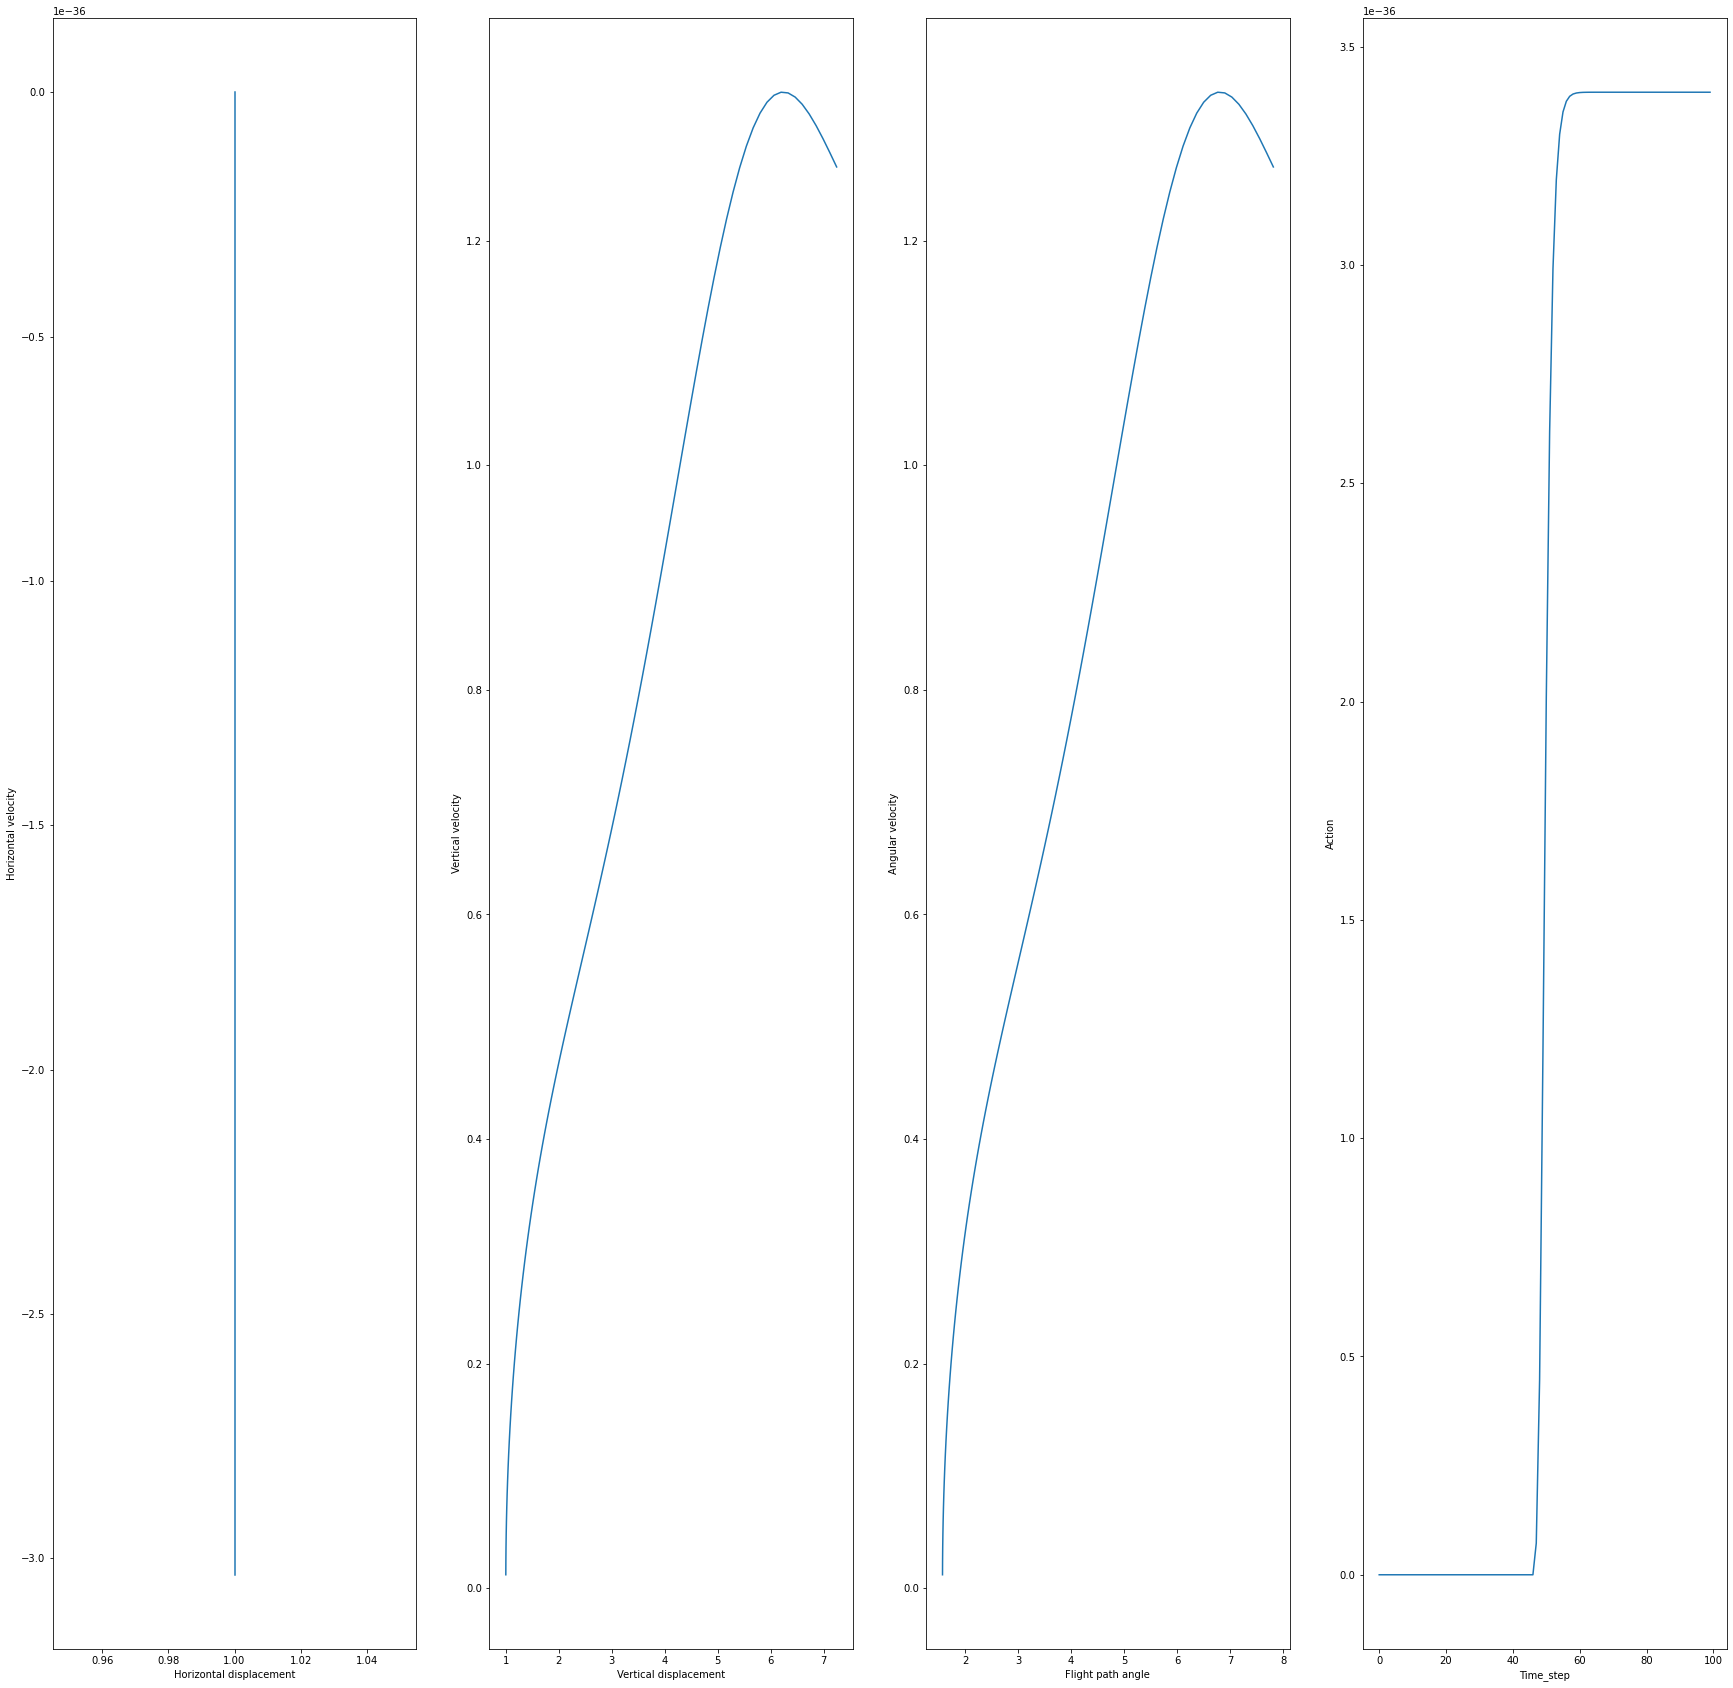

[38] loss: 117.803


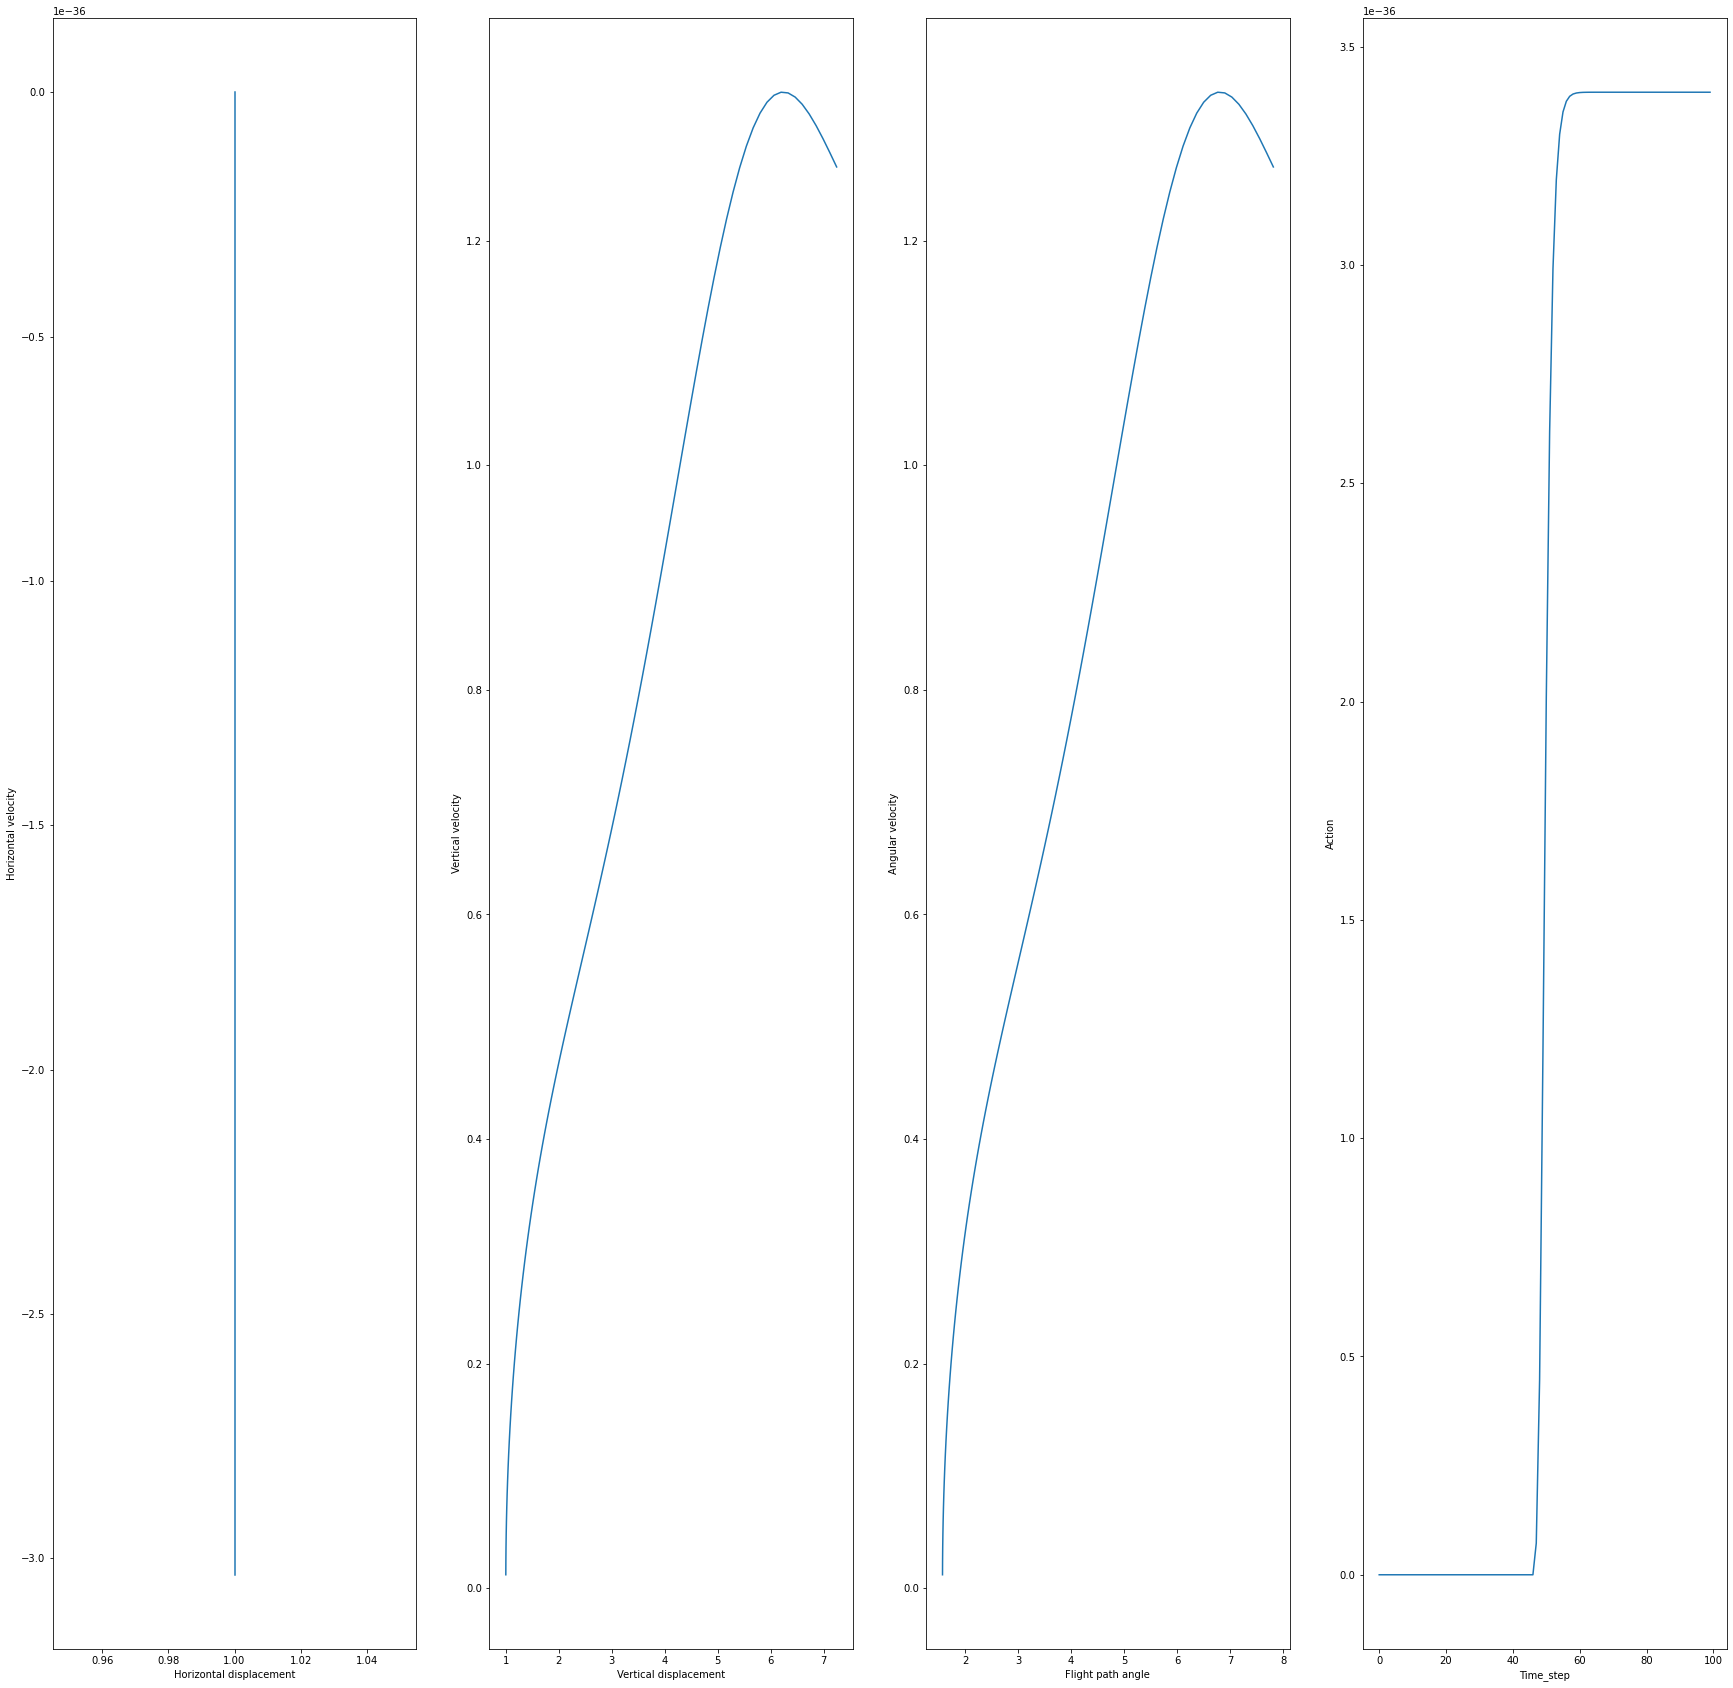

[39] loss: 117.803


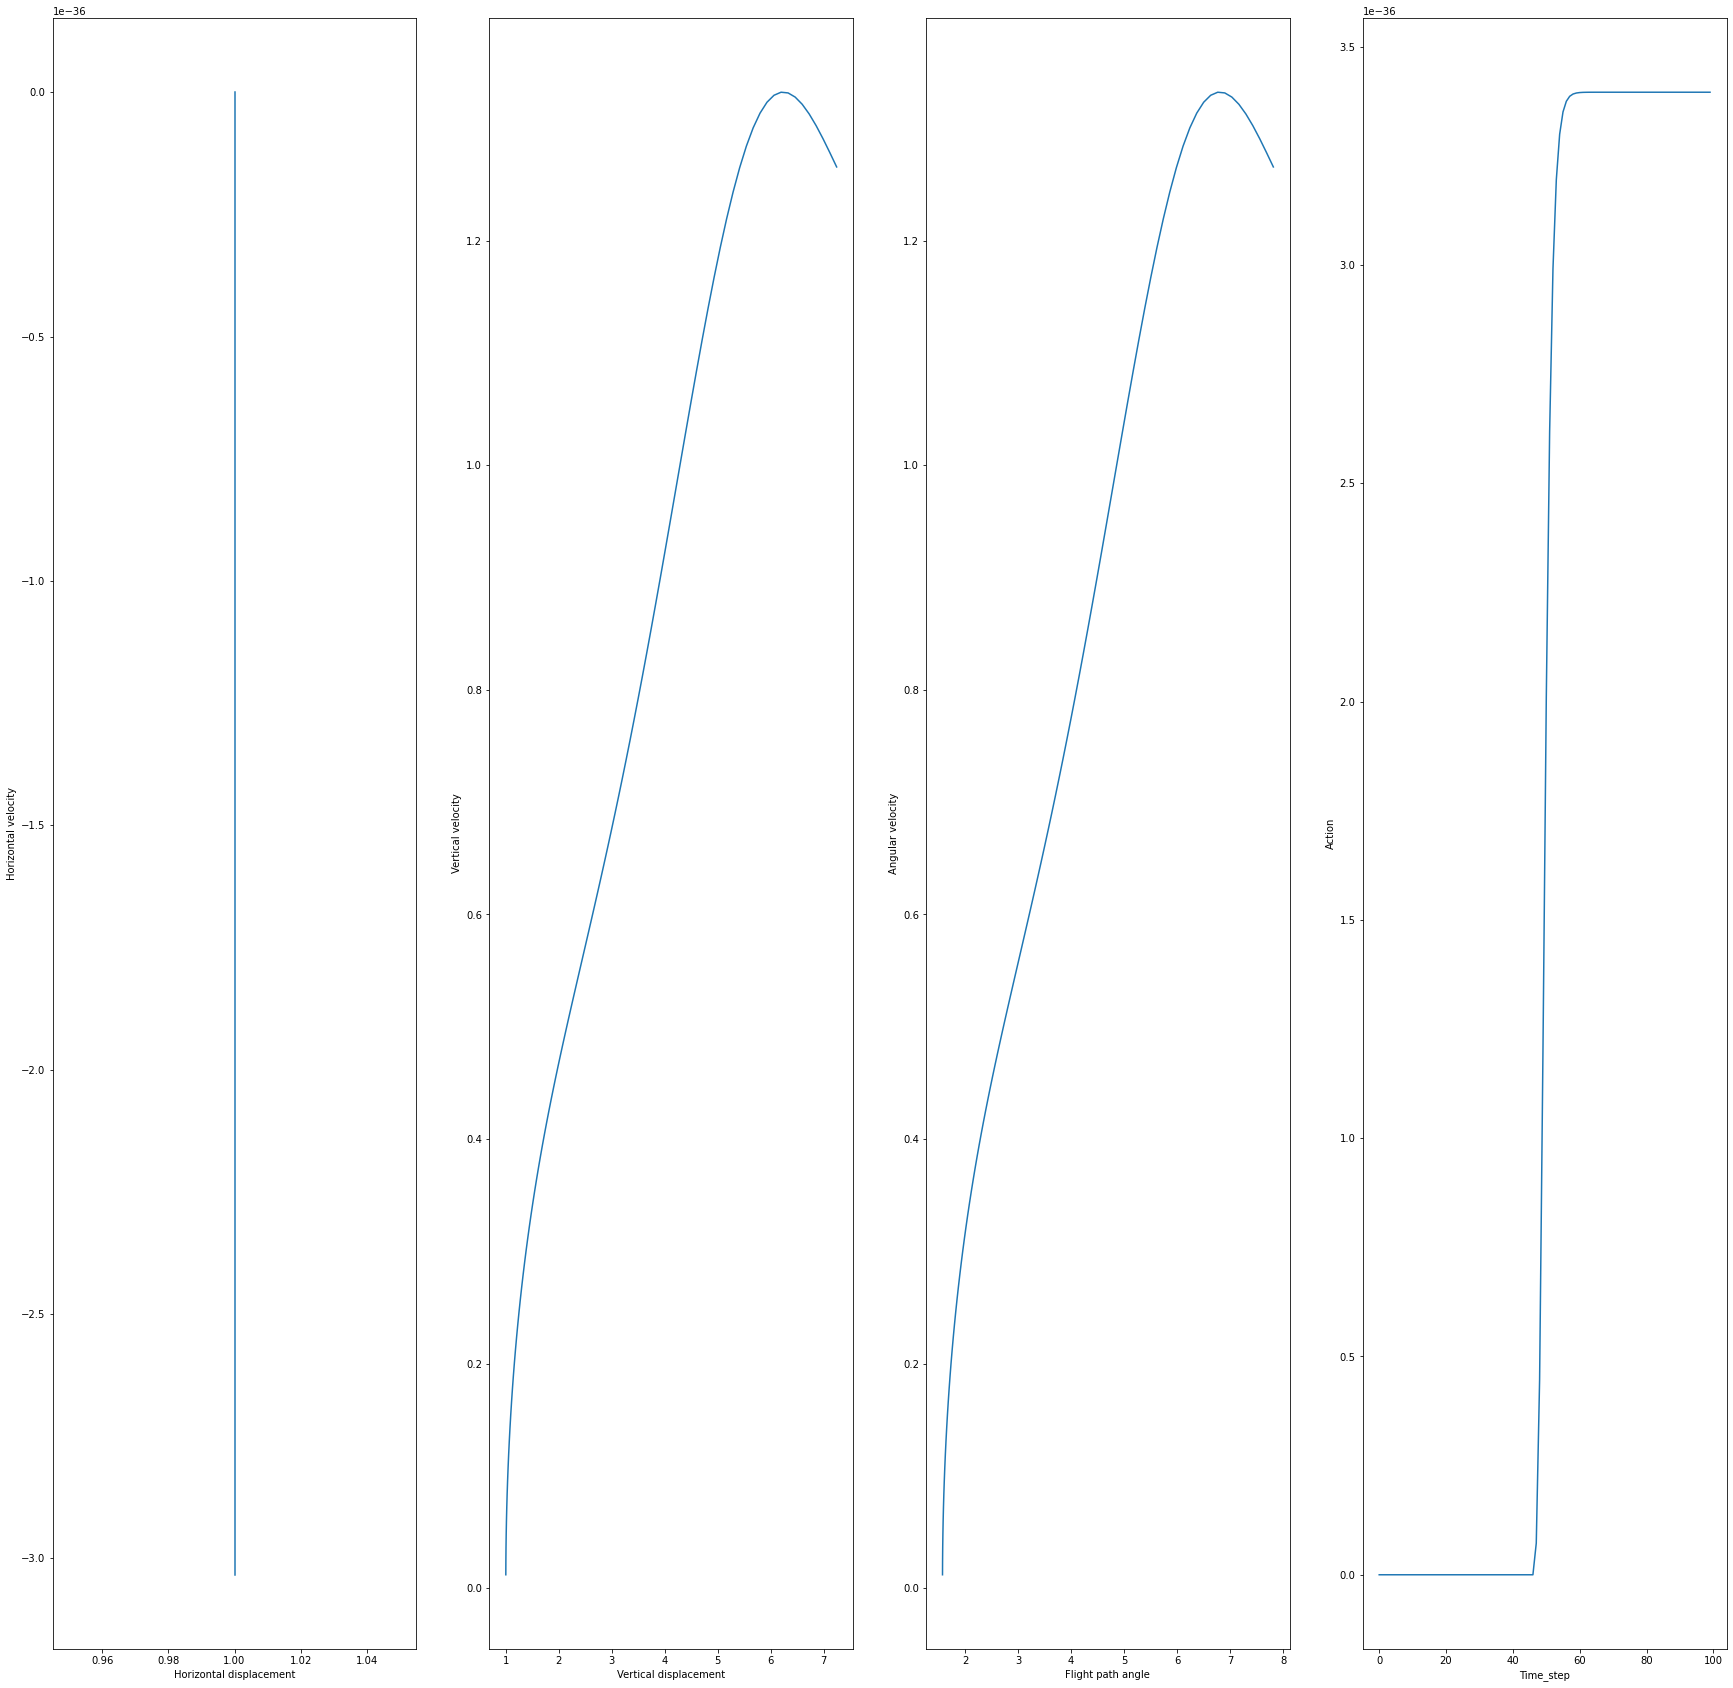

[40] loss: 117.803


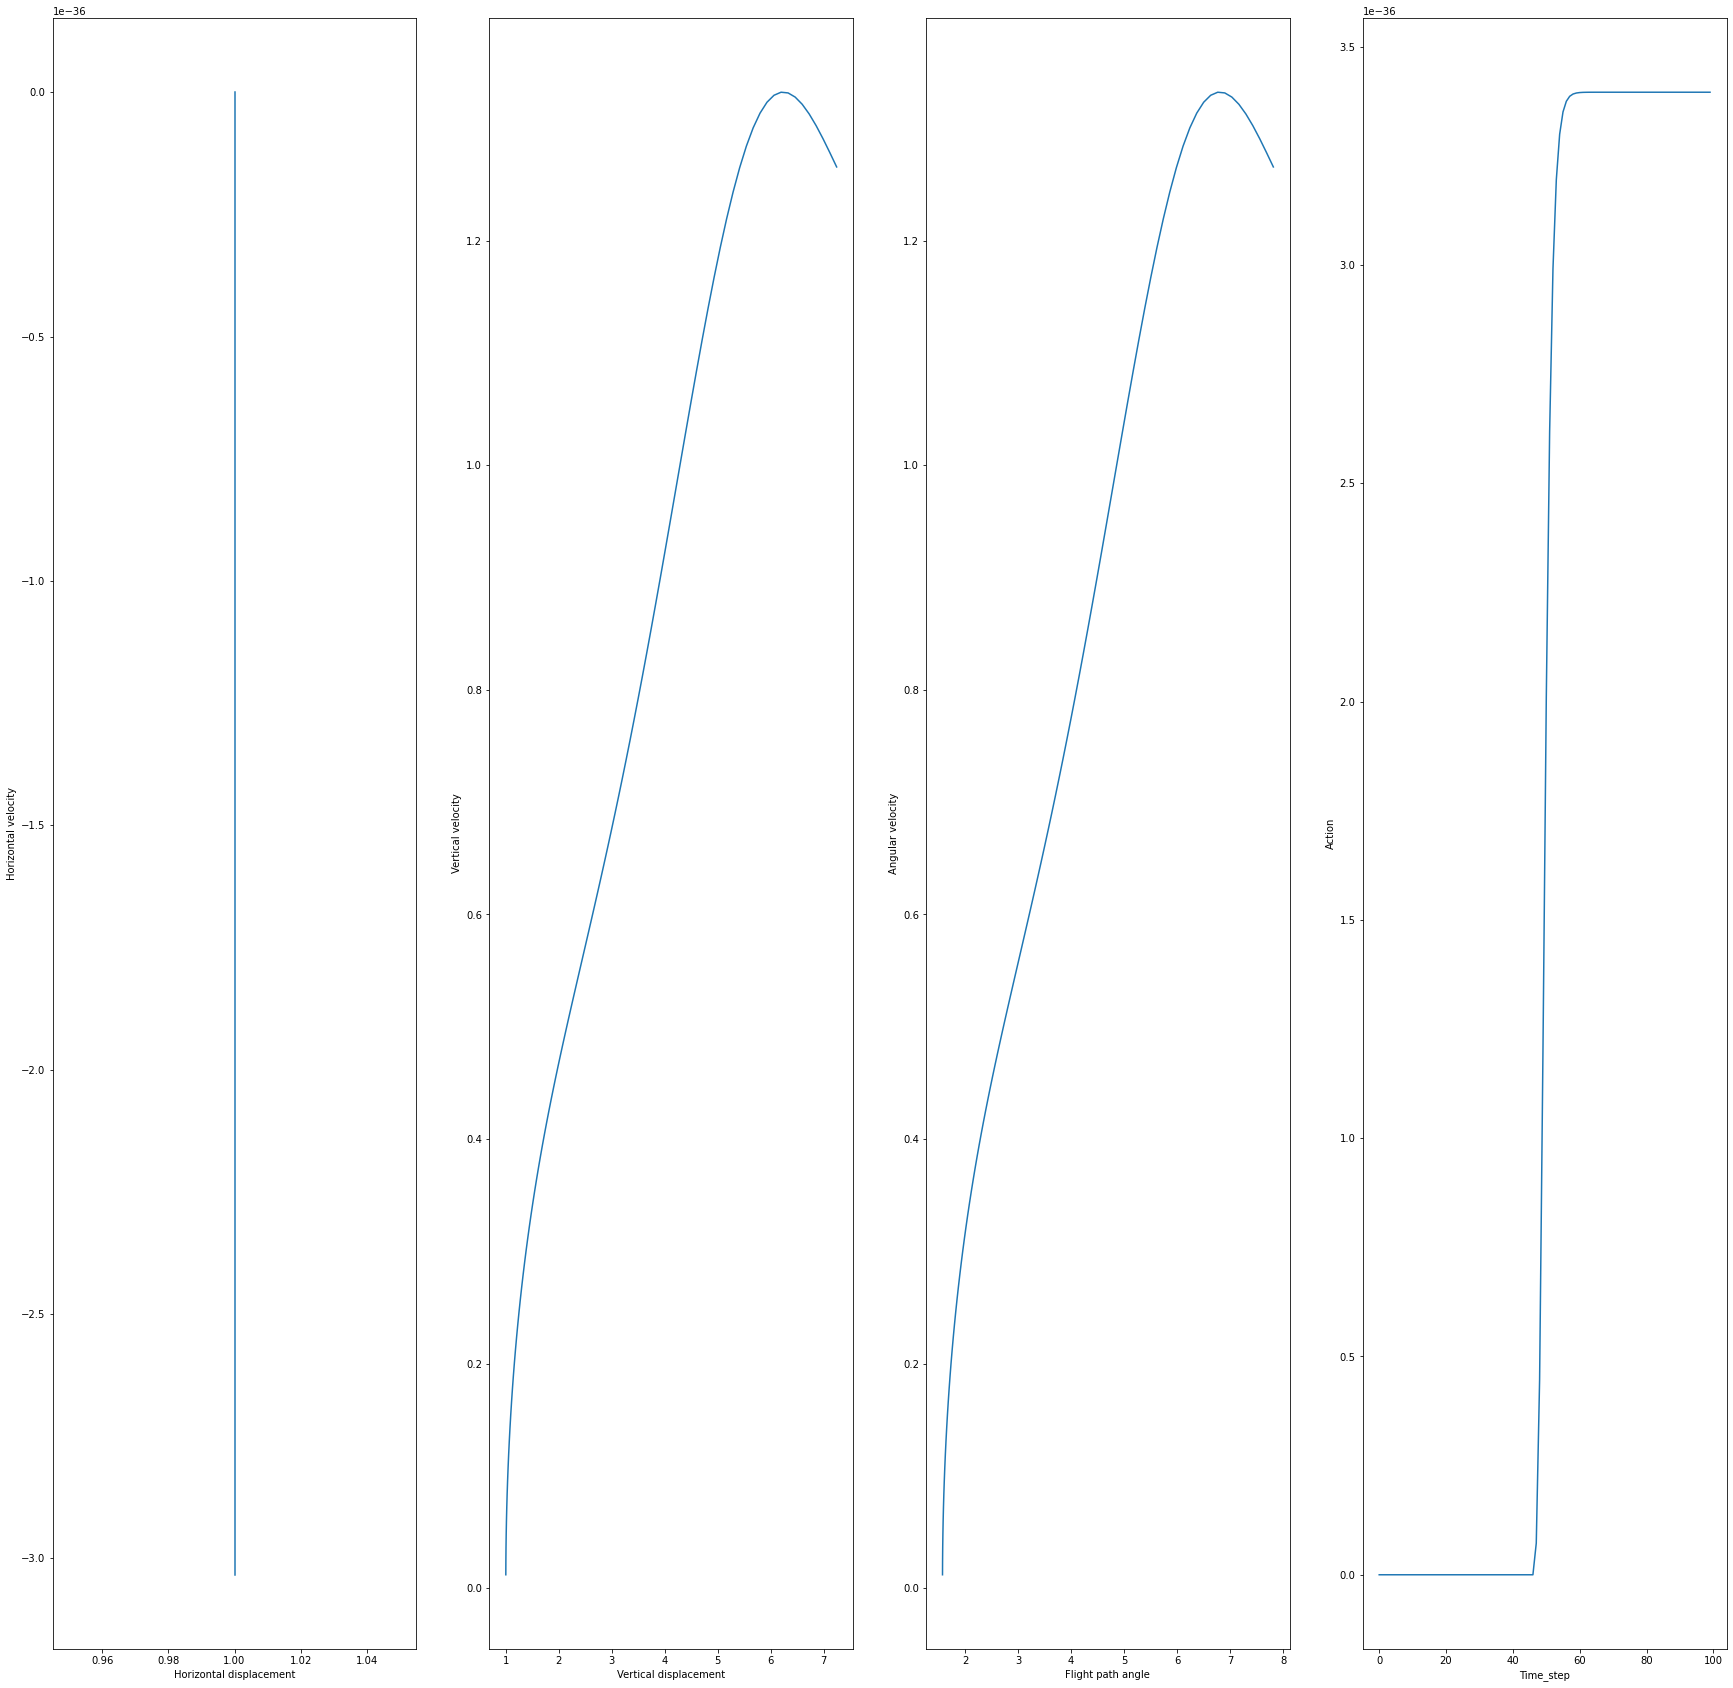

[41] loss: 117.803


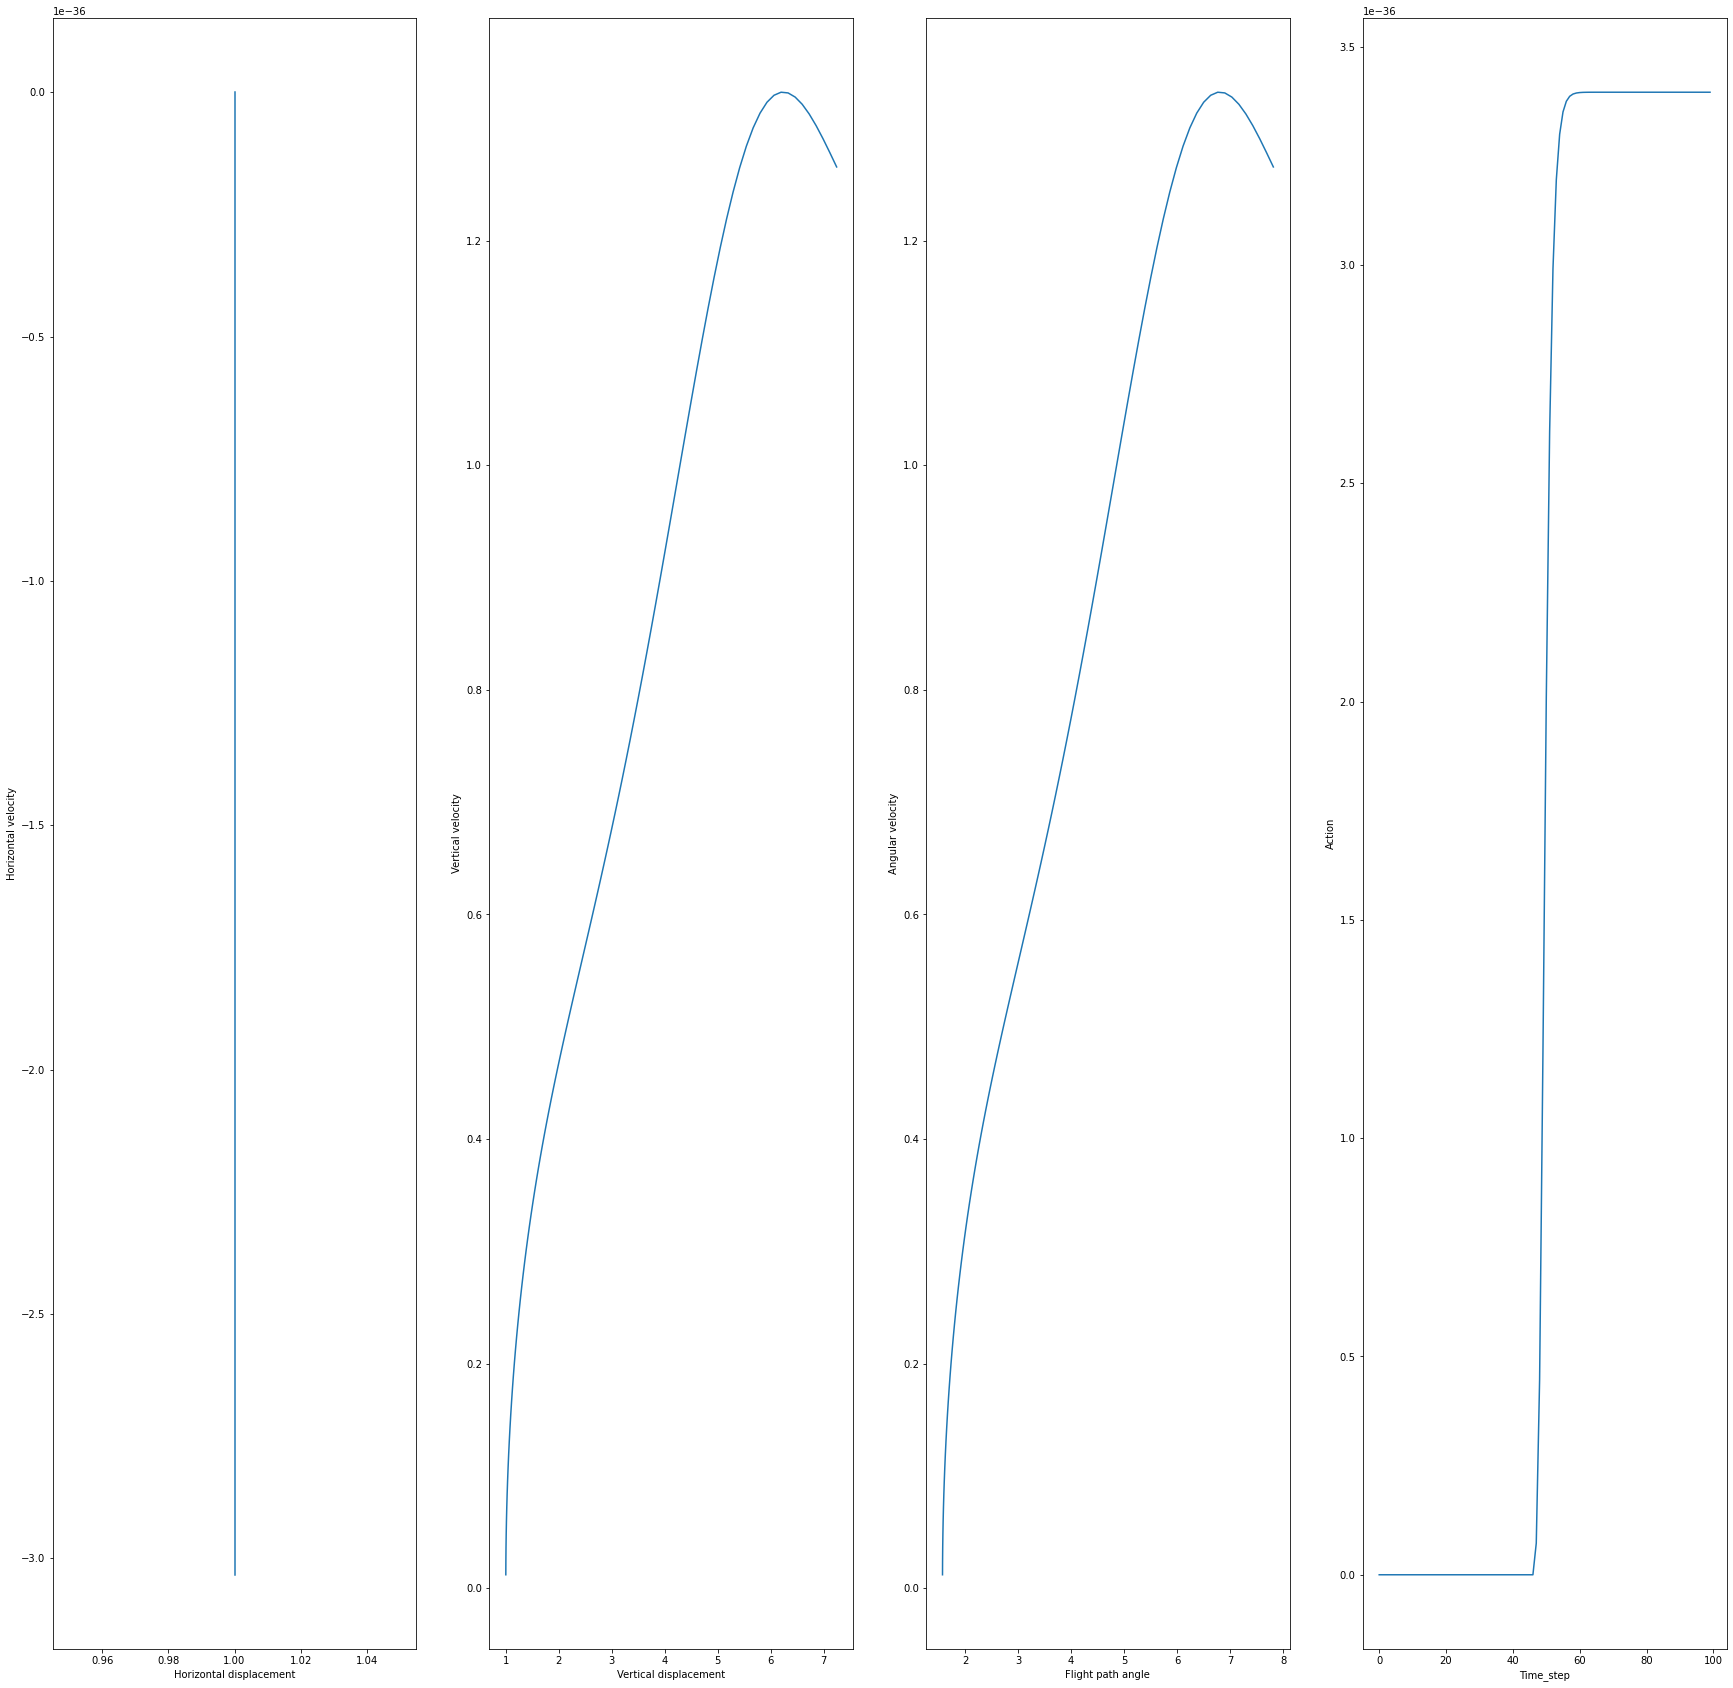

[42] loss: 117.803


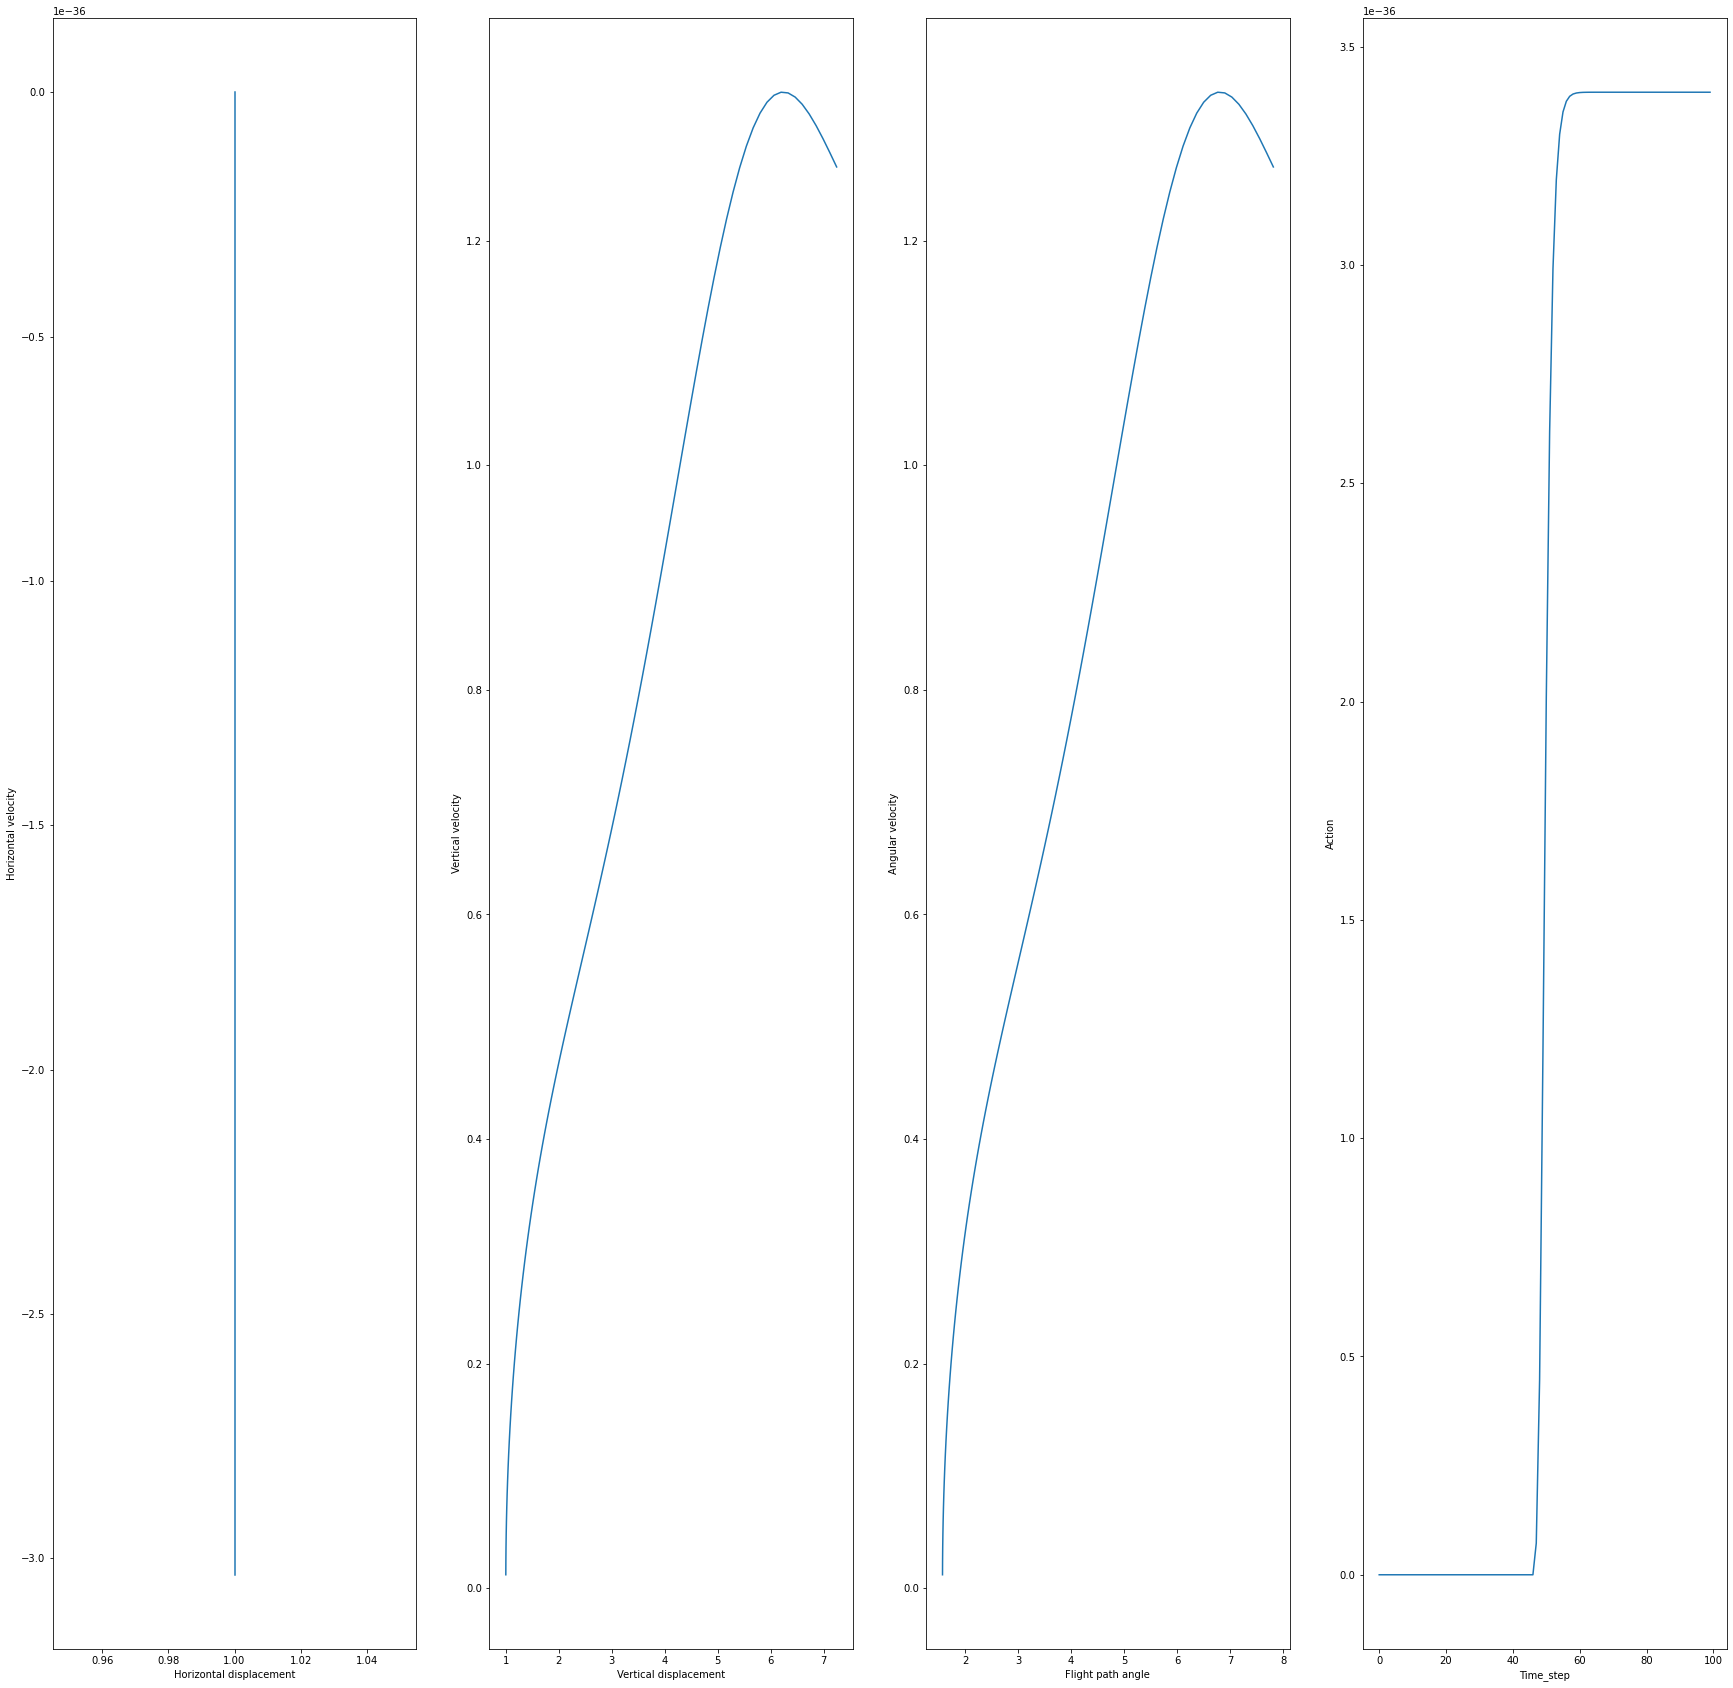

[43] loss: 117.803


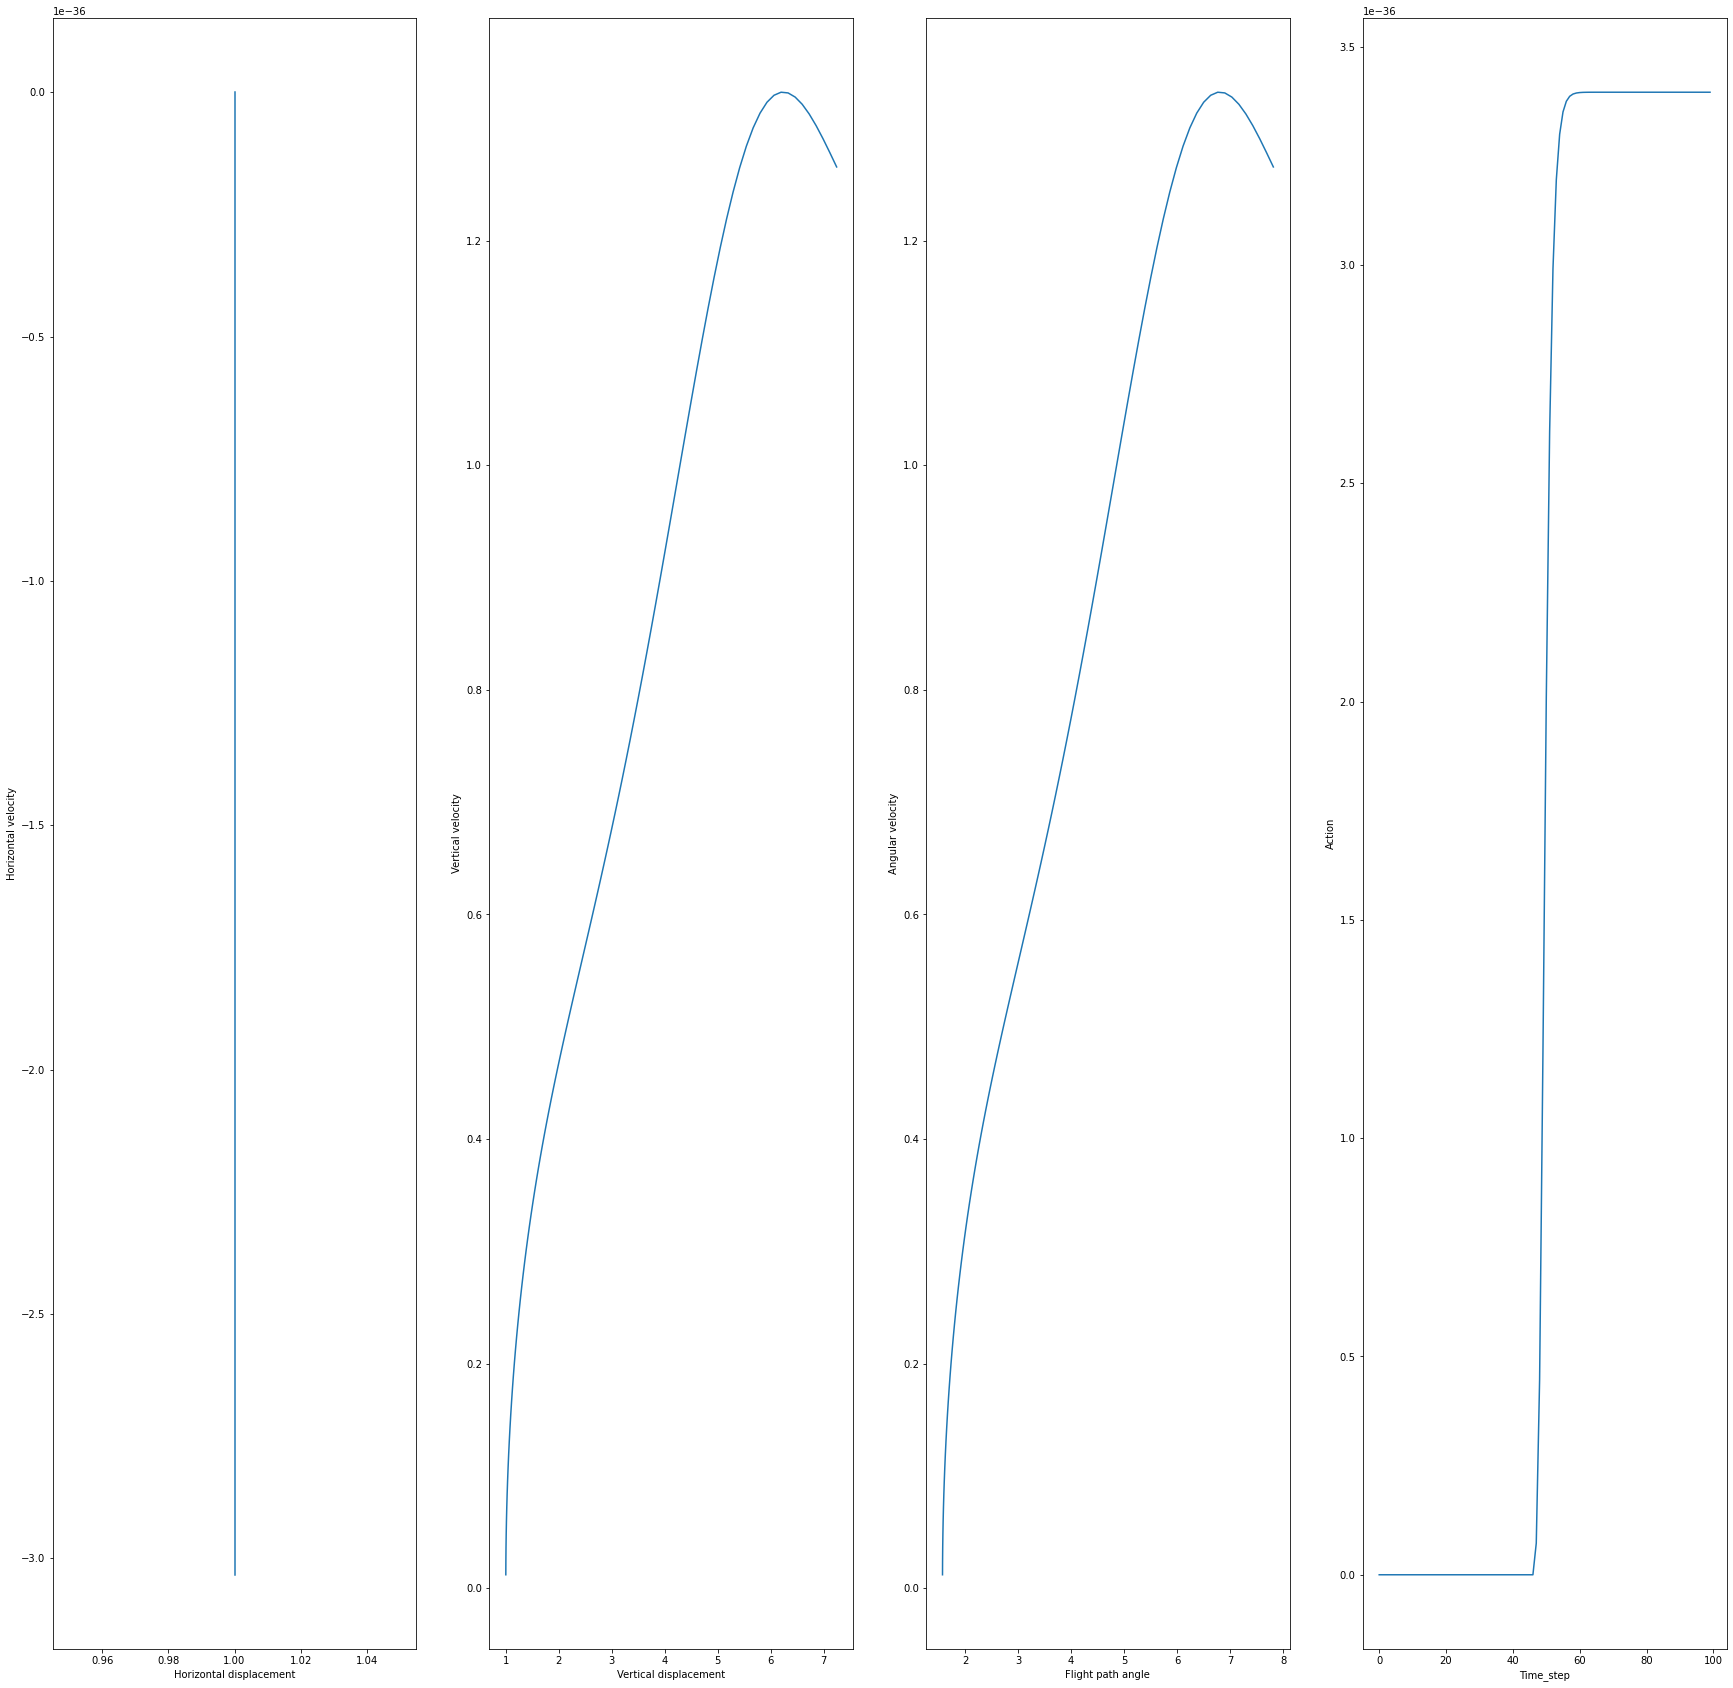

[44] loss: 117.803


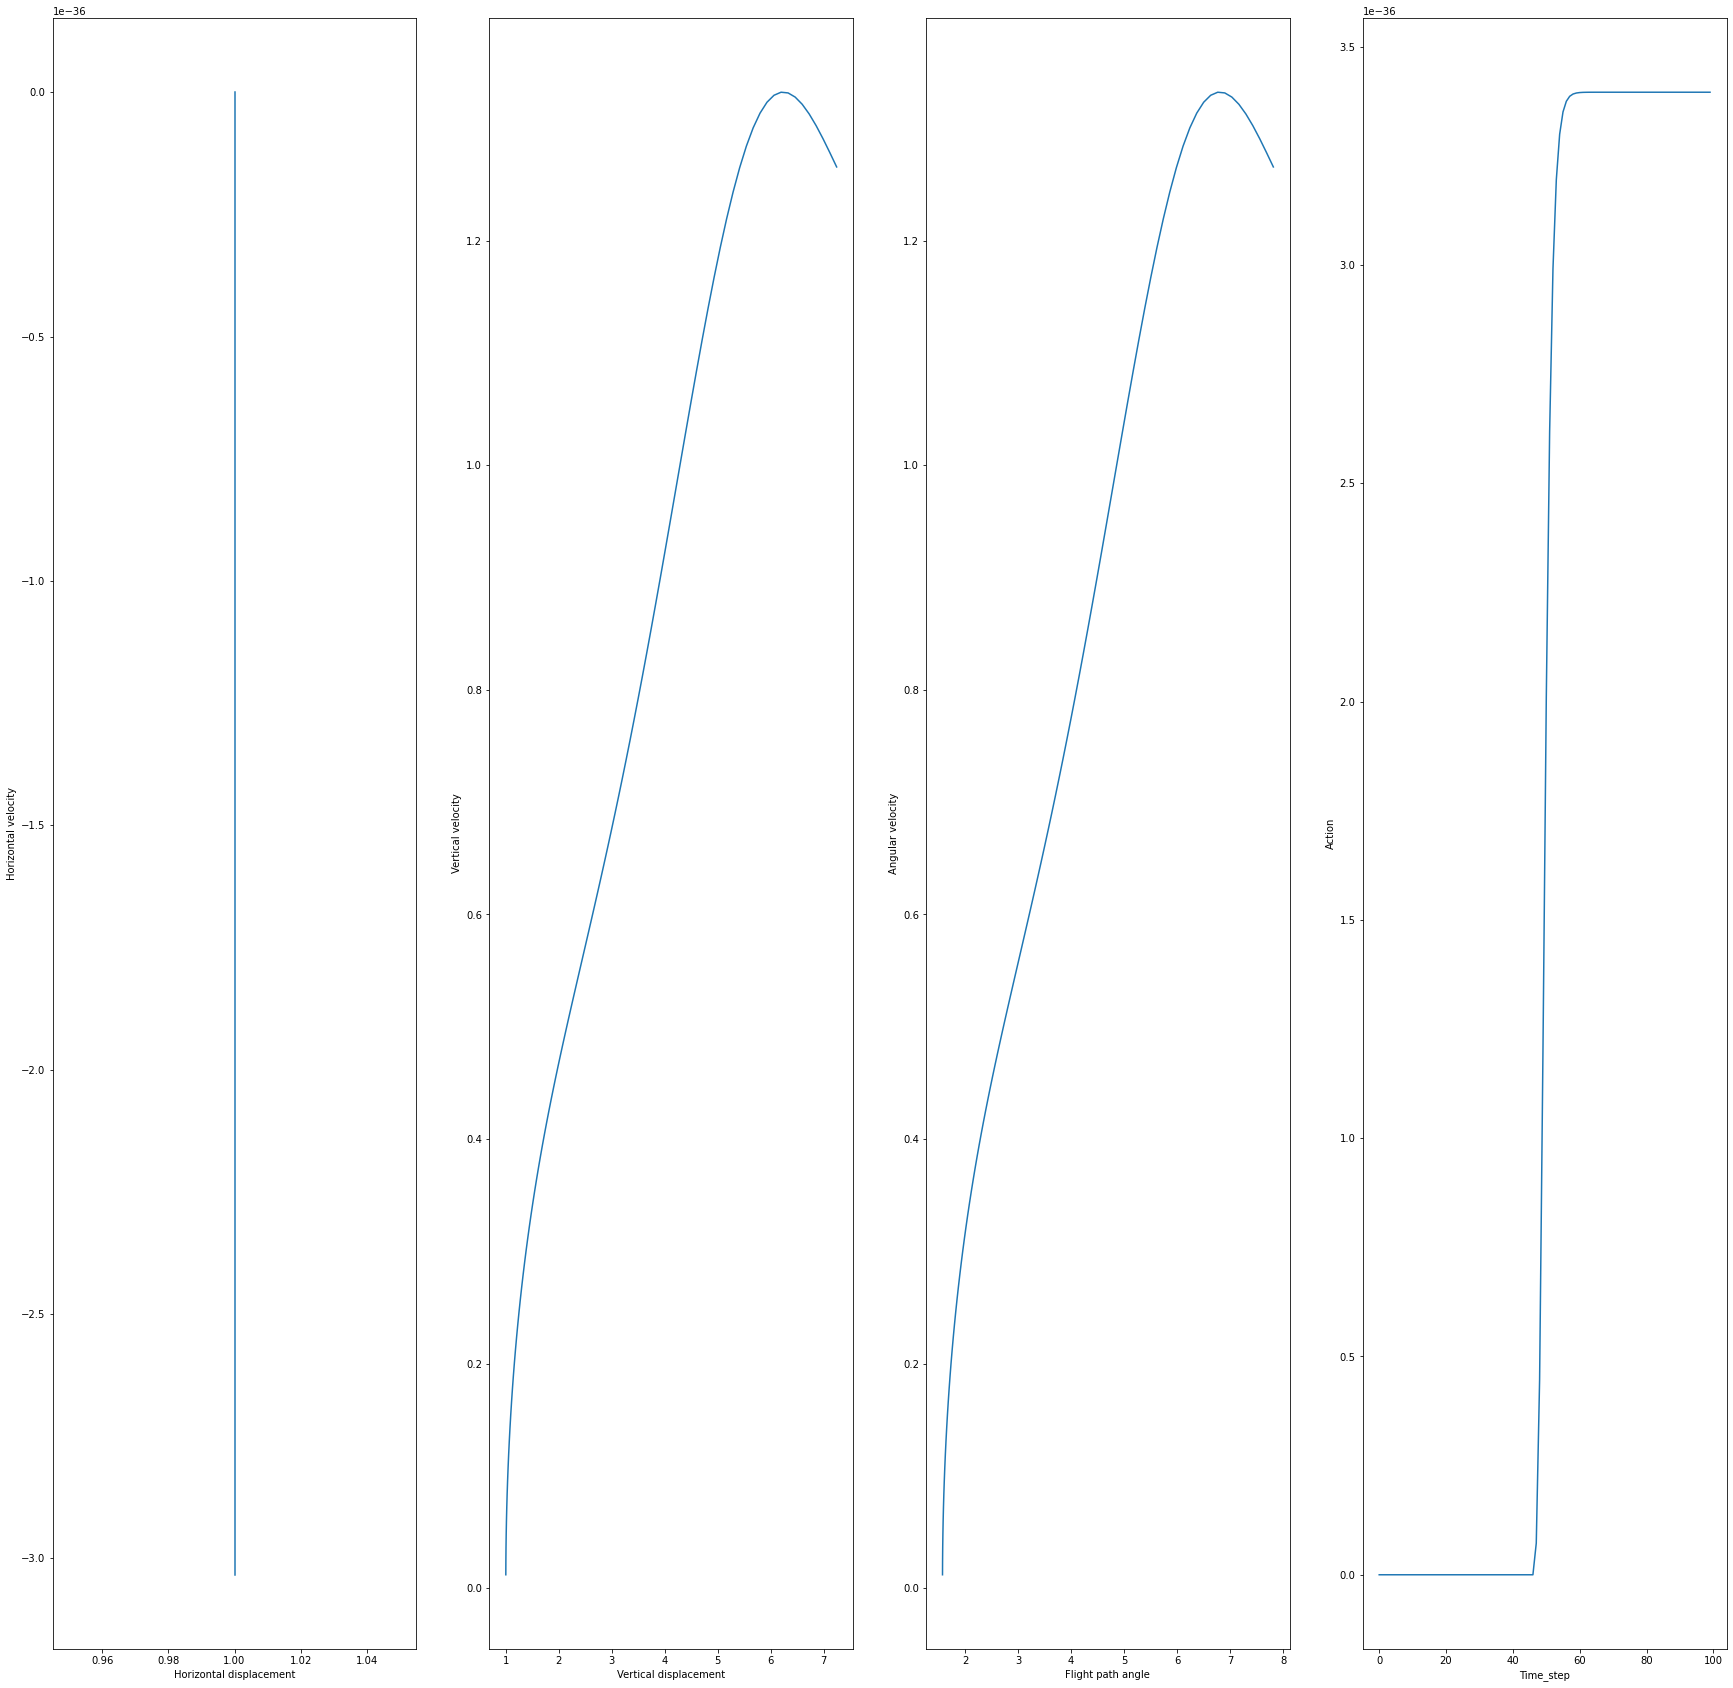

[45] loss: 117.803


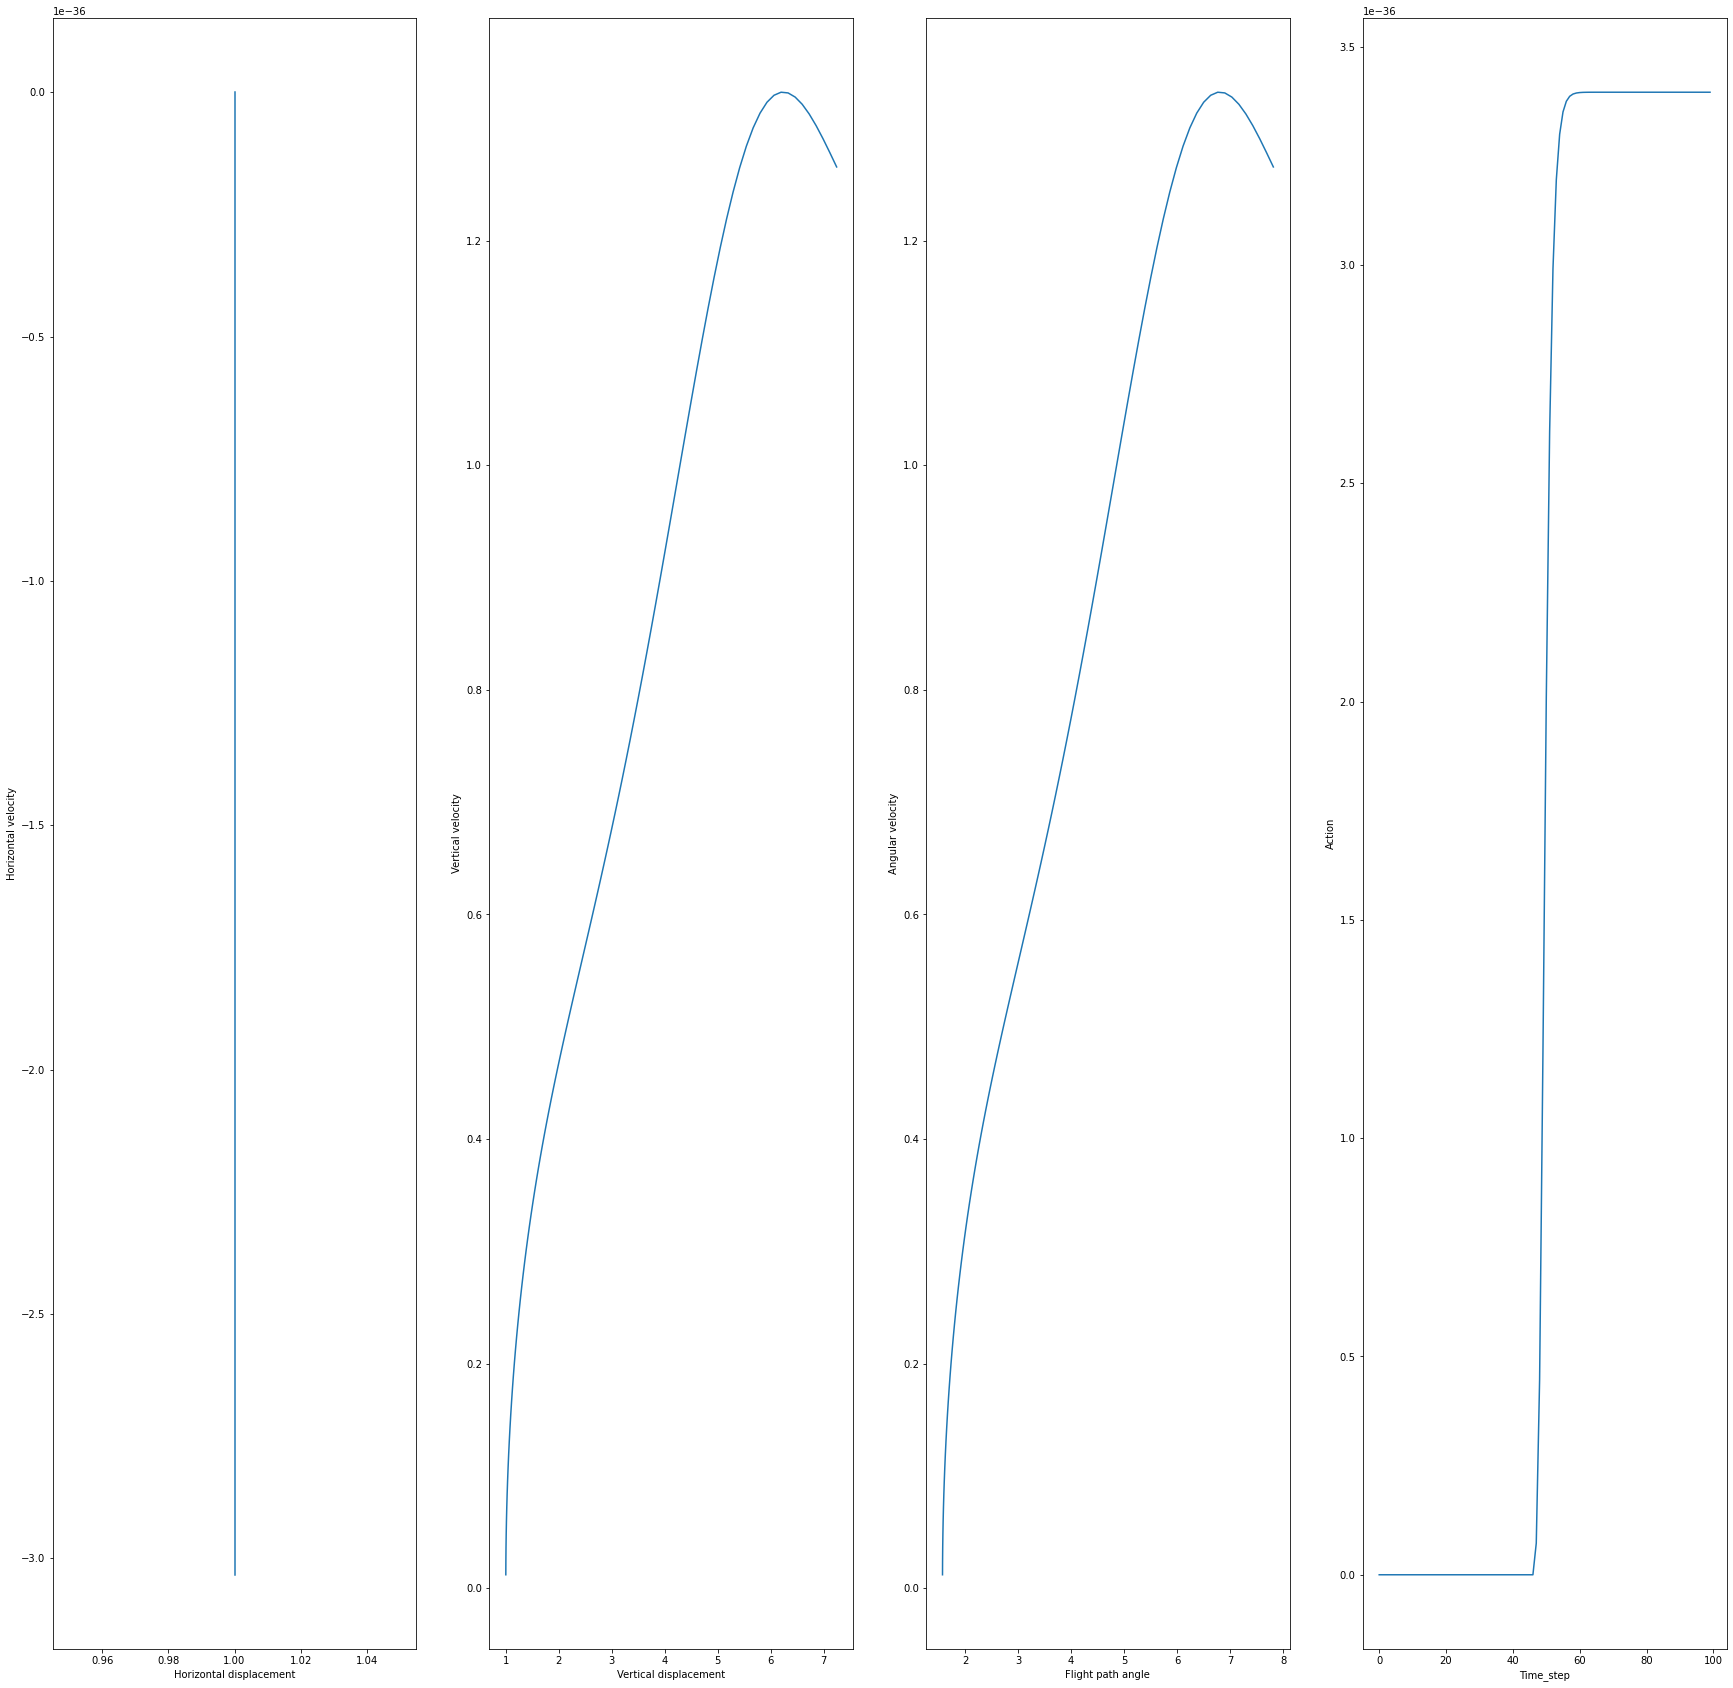

[46] loss: 117.803


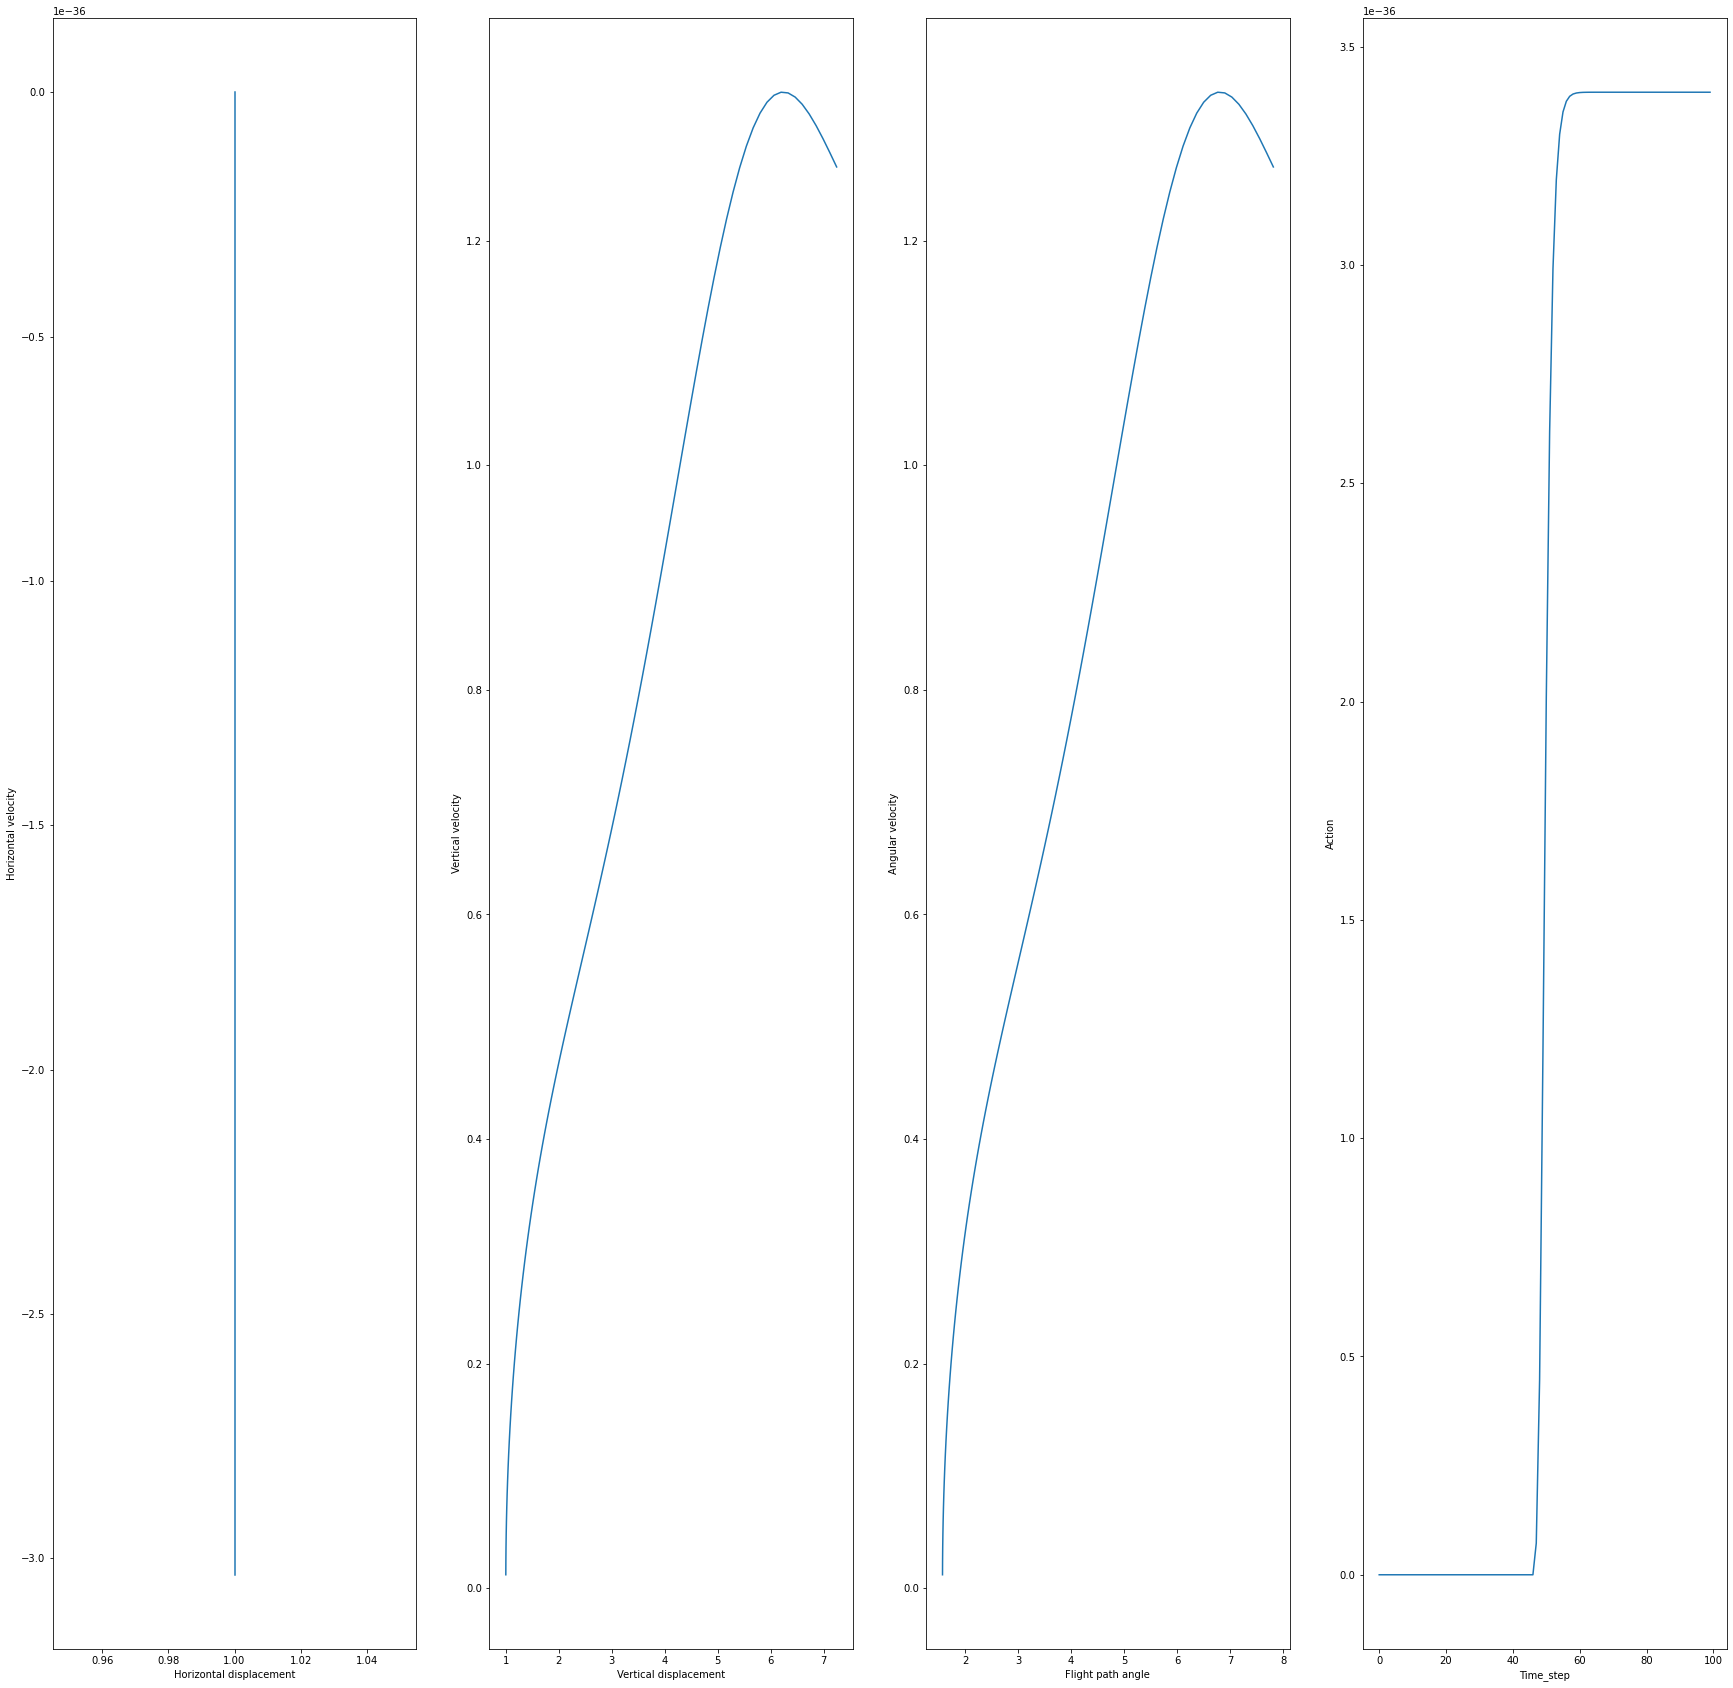

[47] loss: 117.803


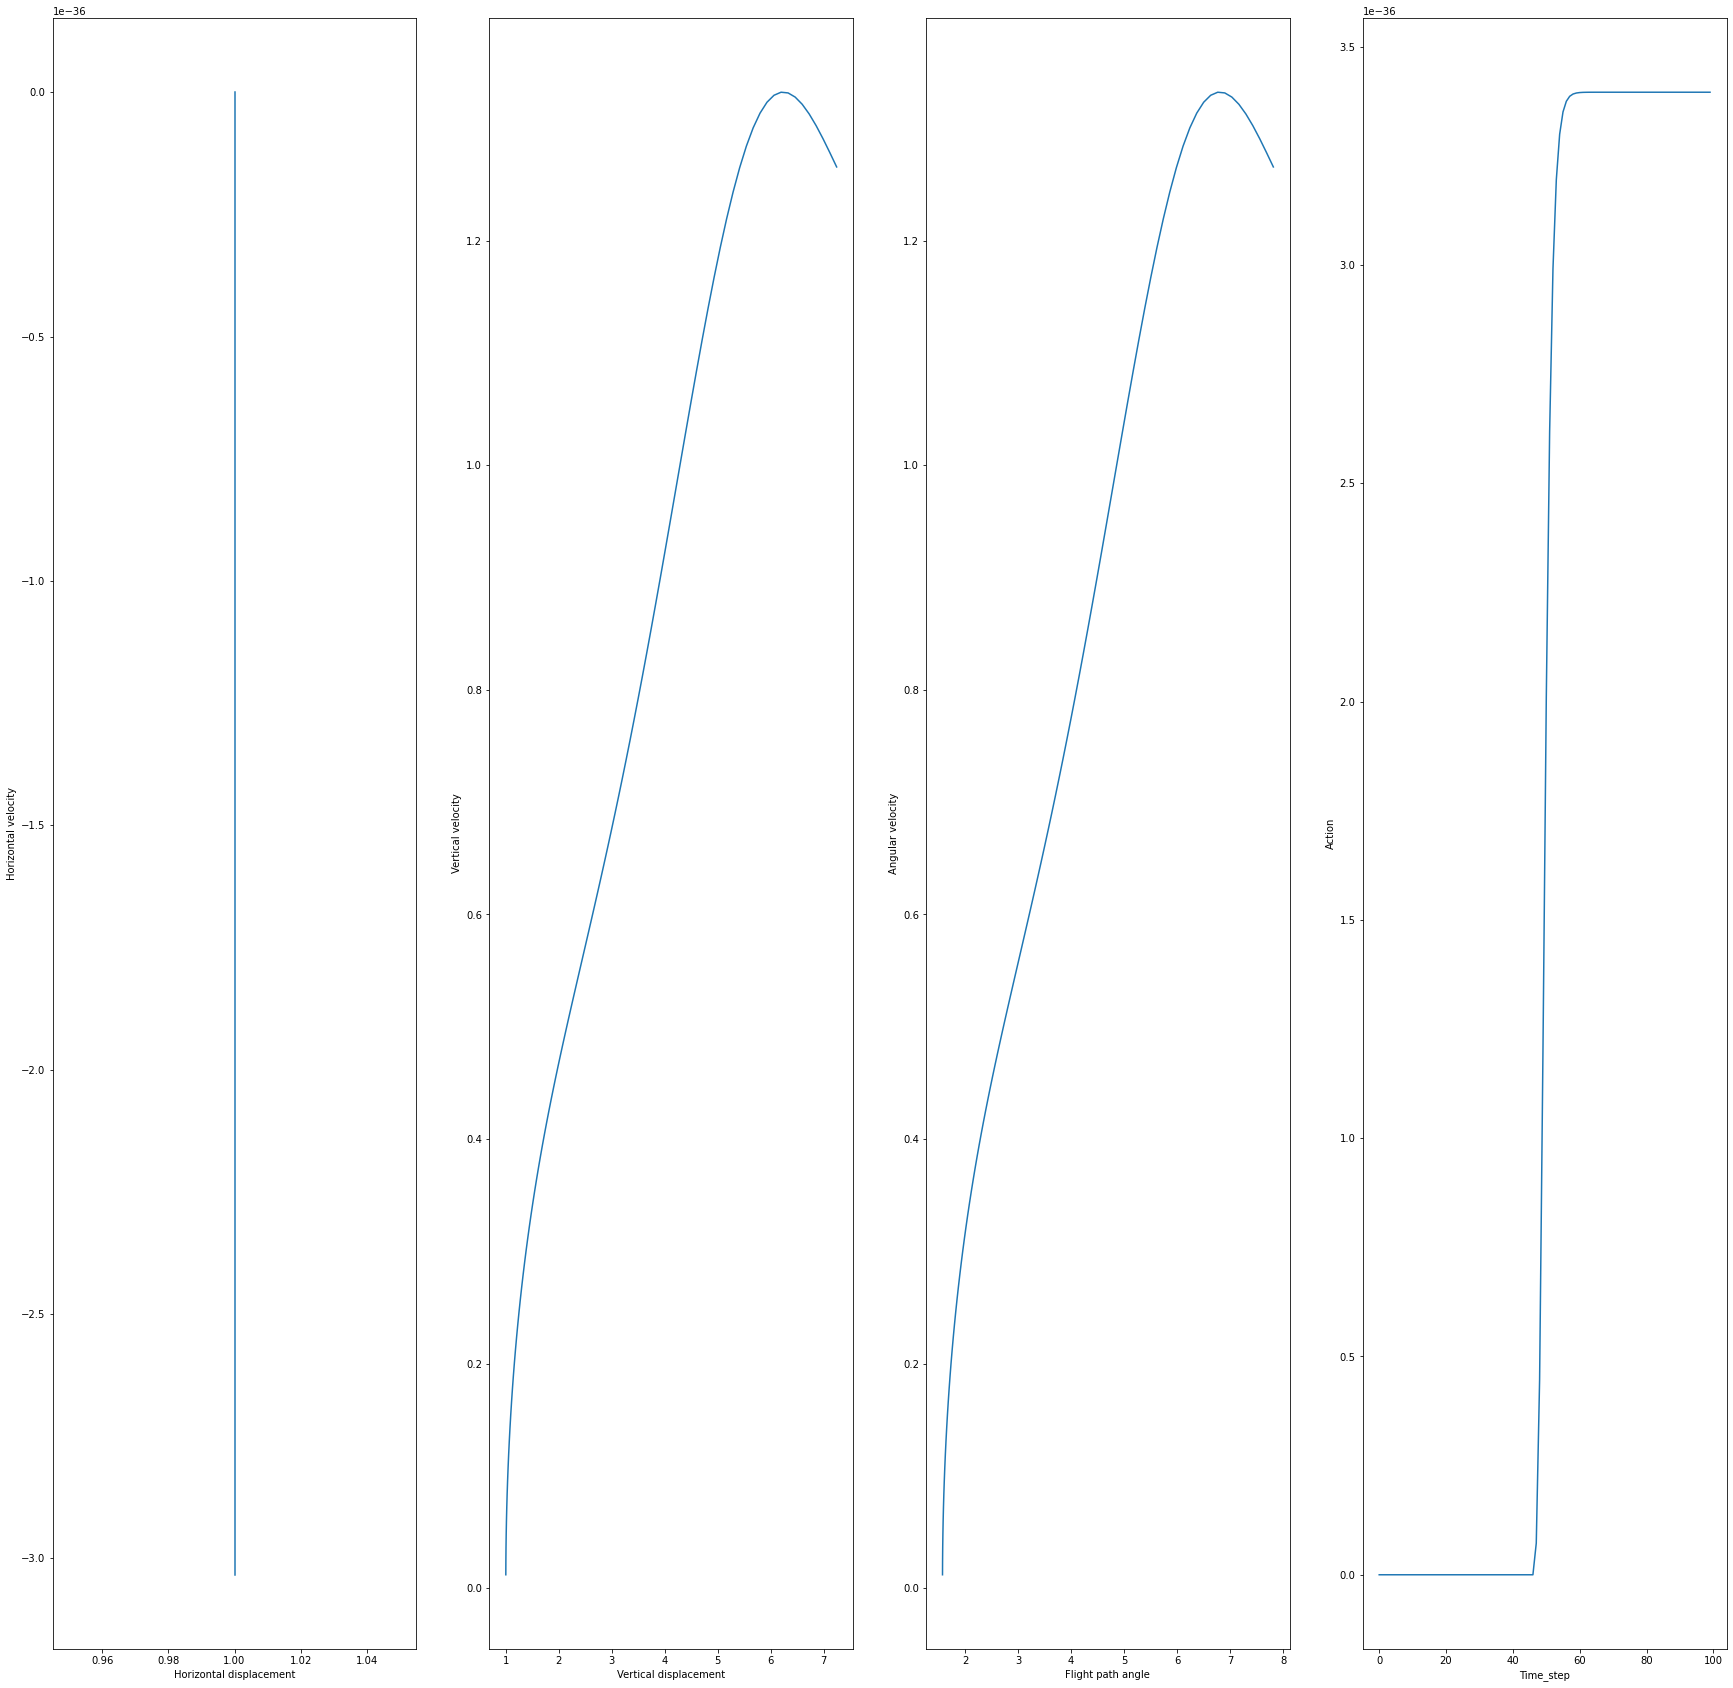

[48] loss: 117.803


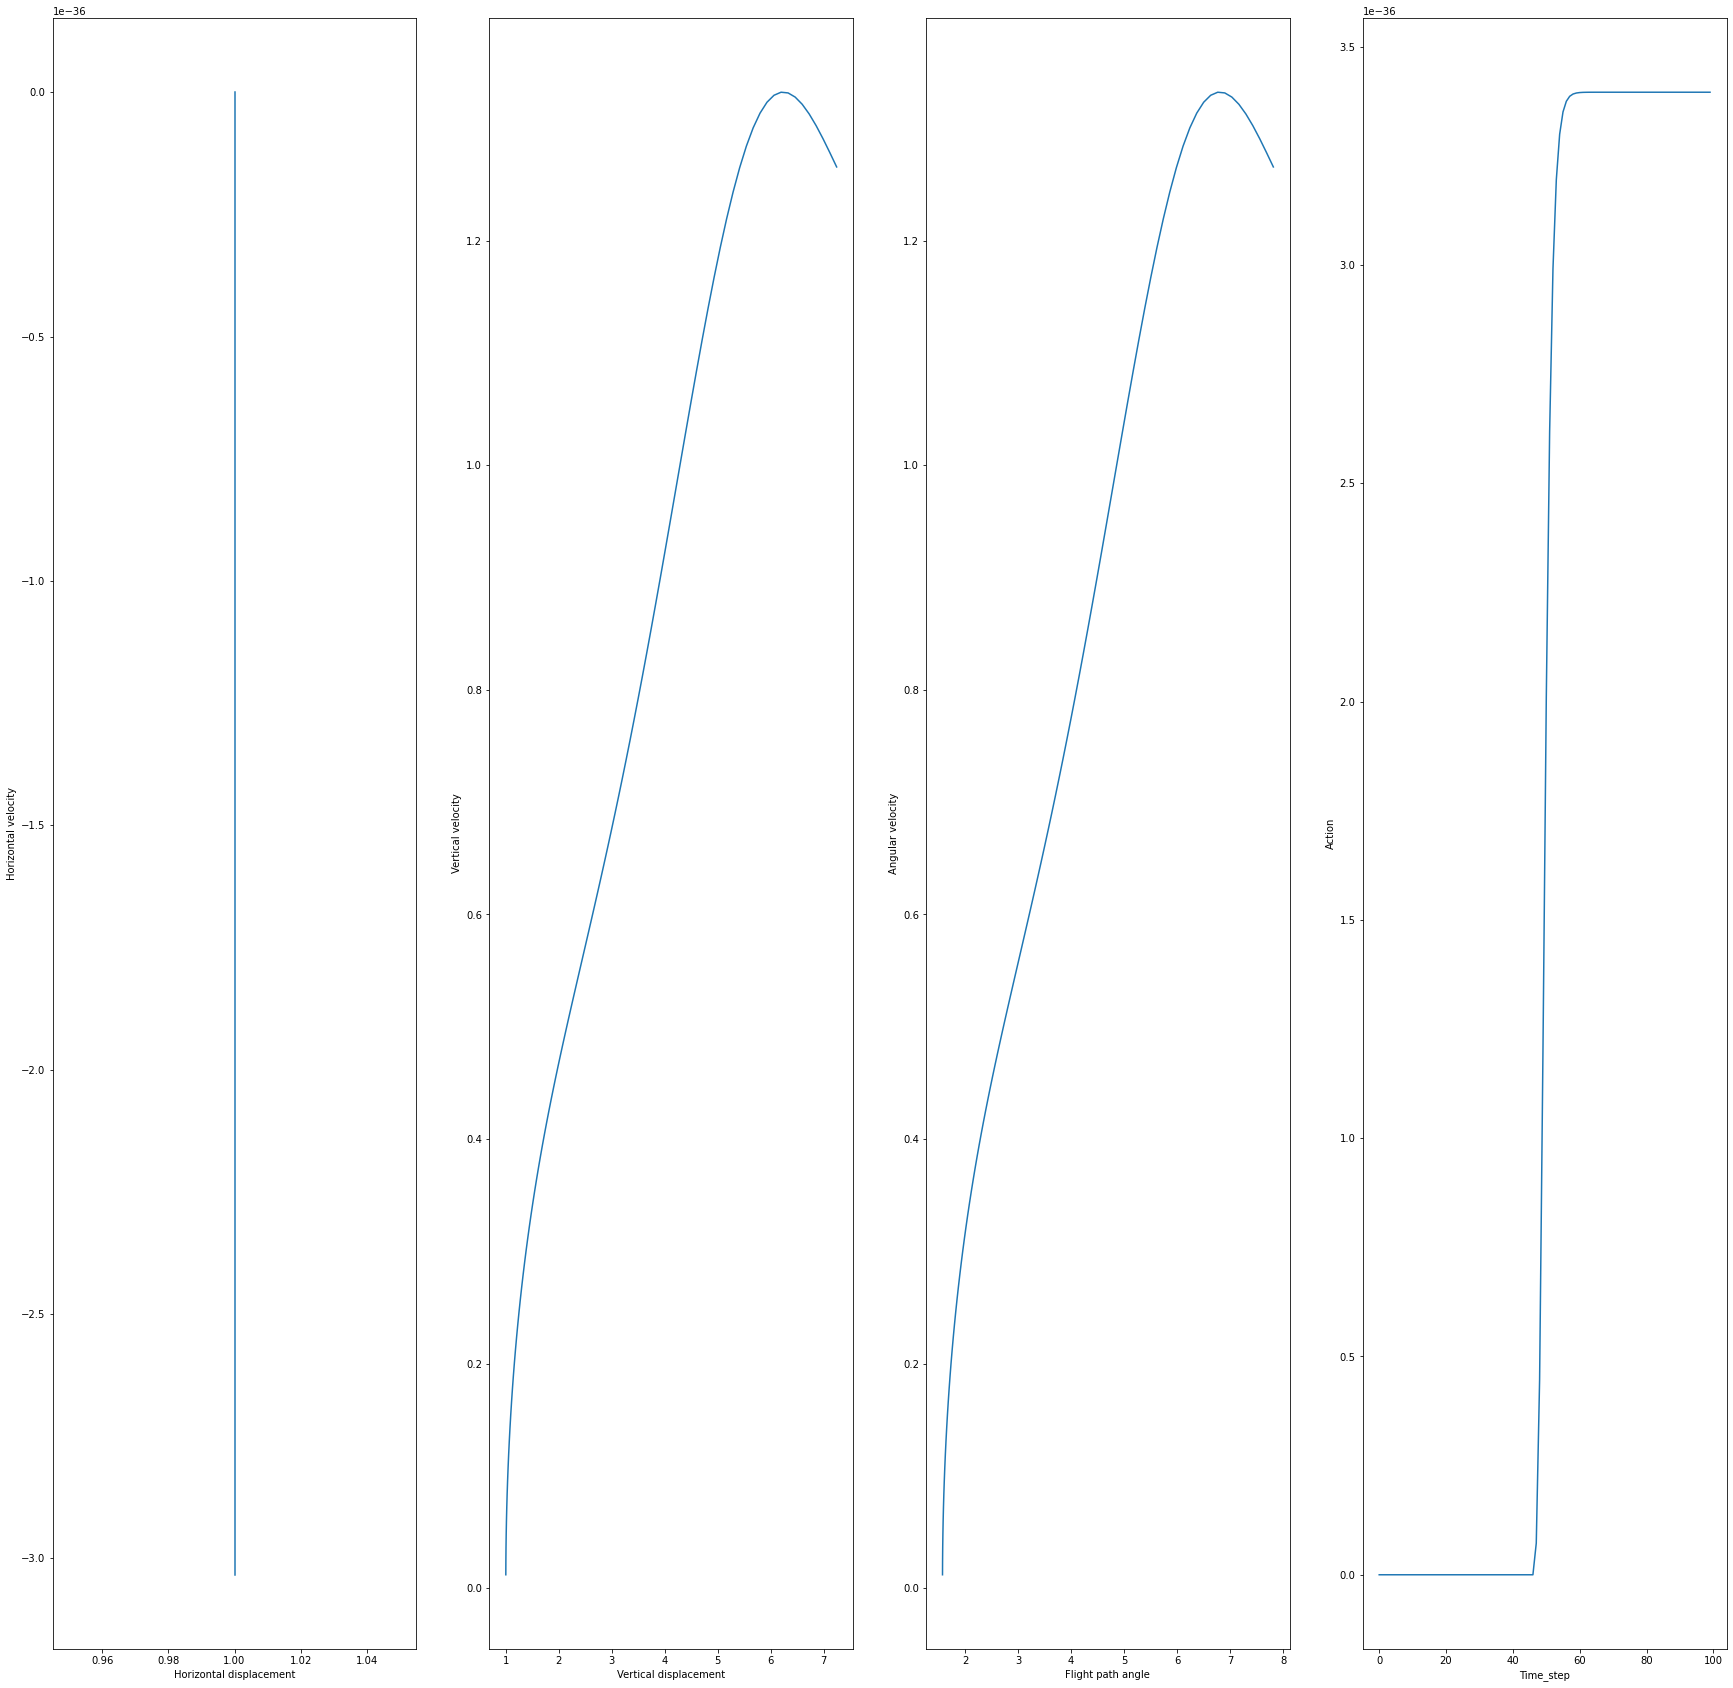

[49] loss: 117.803


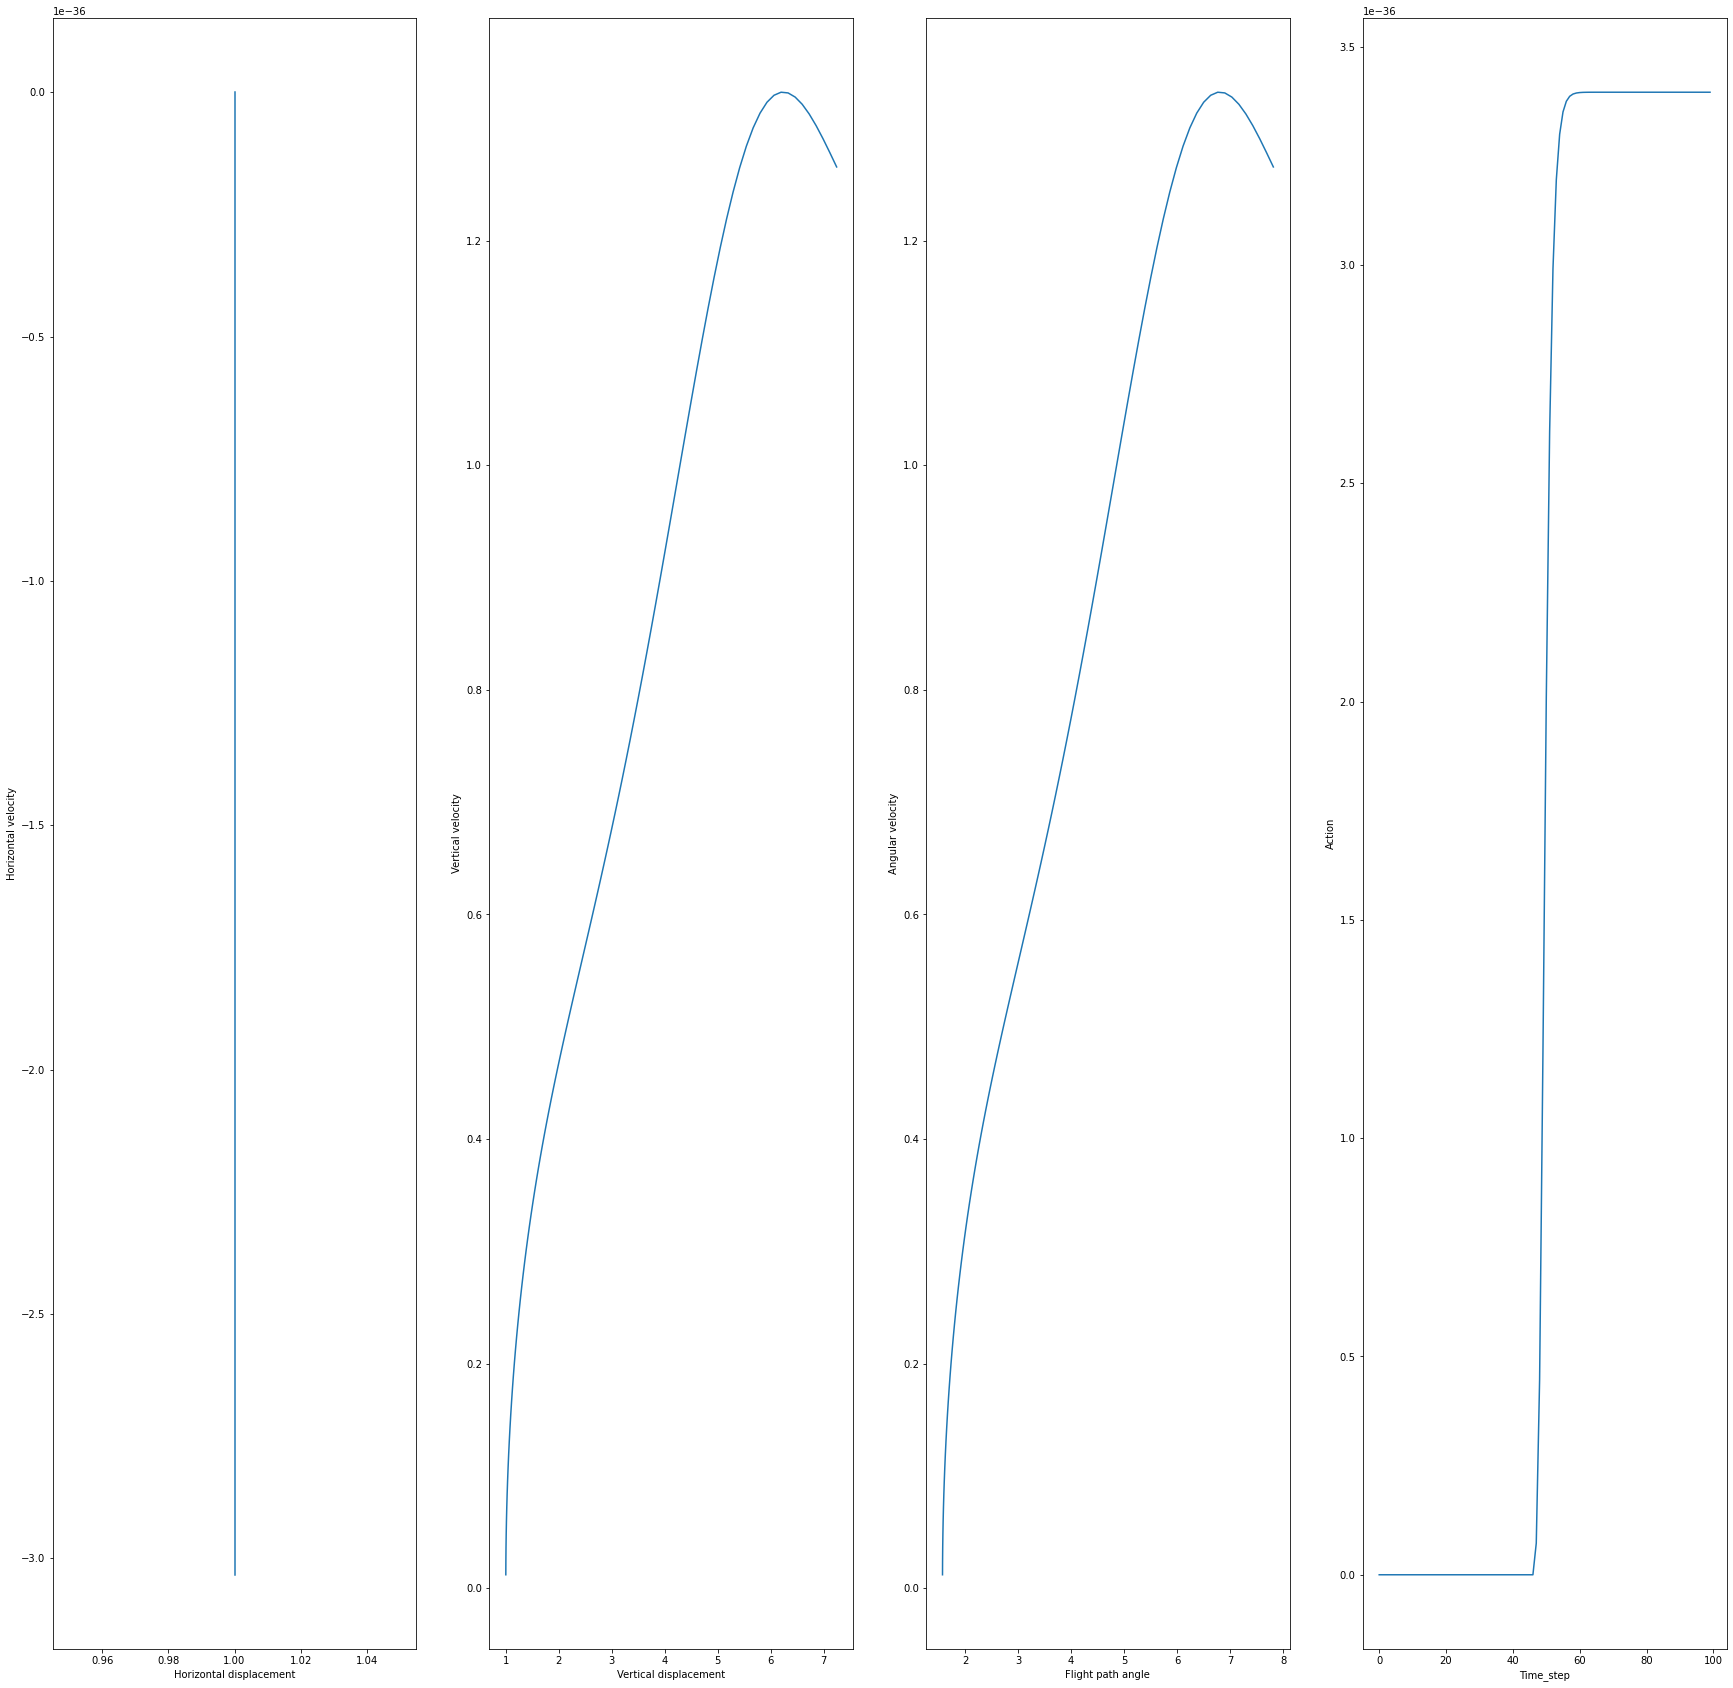

[50] loss: 117.803


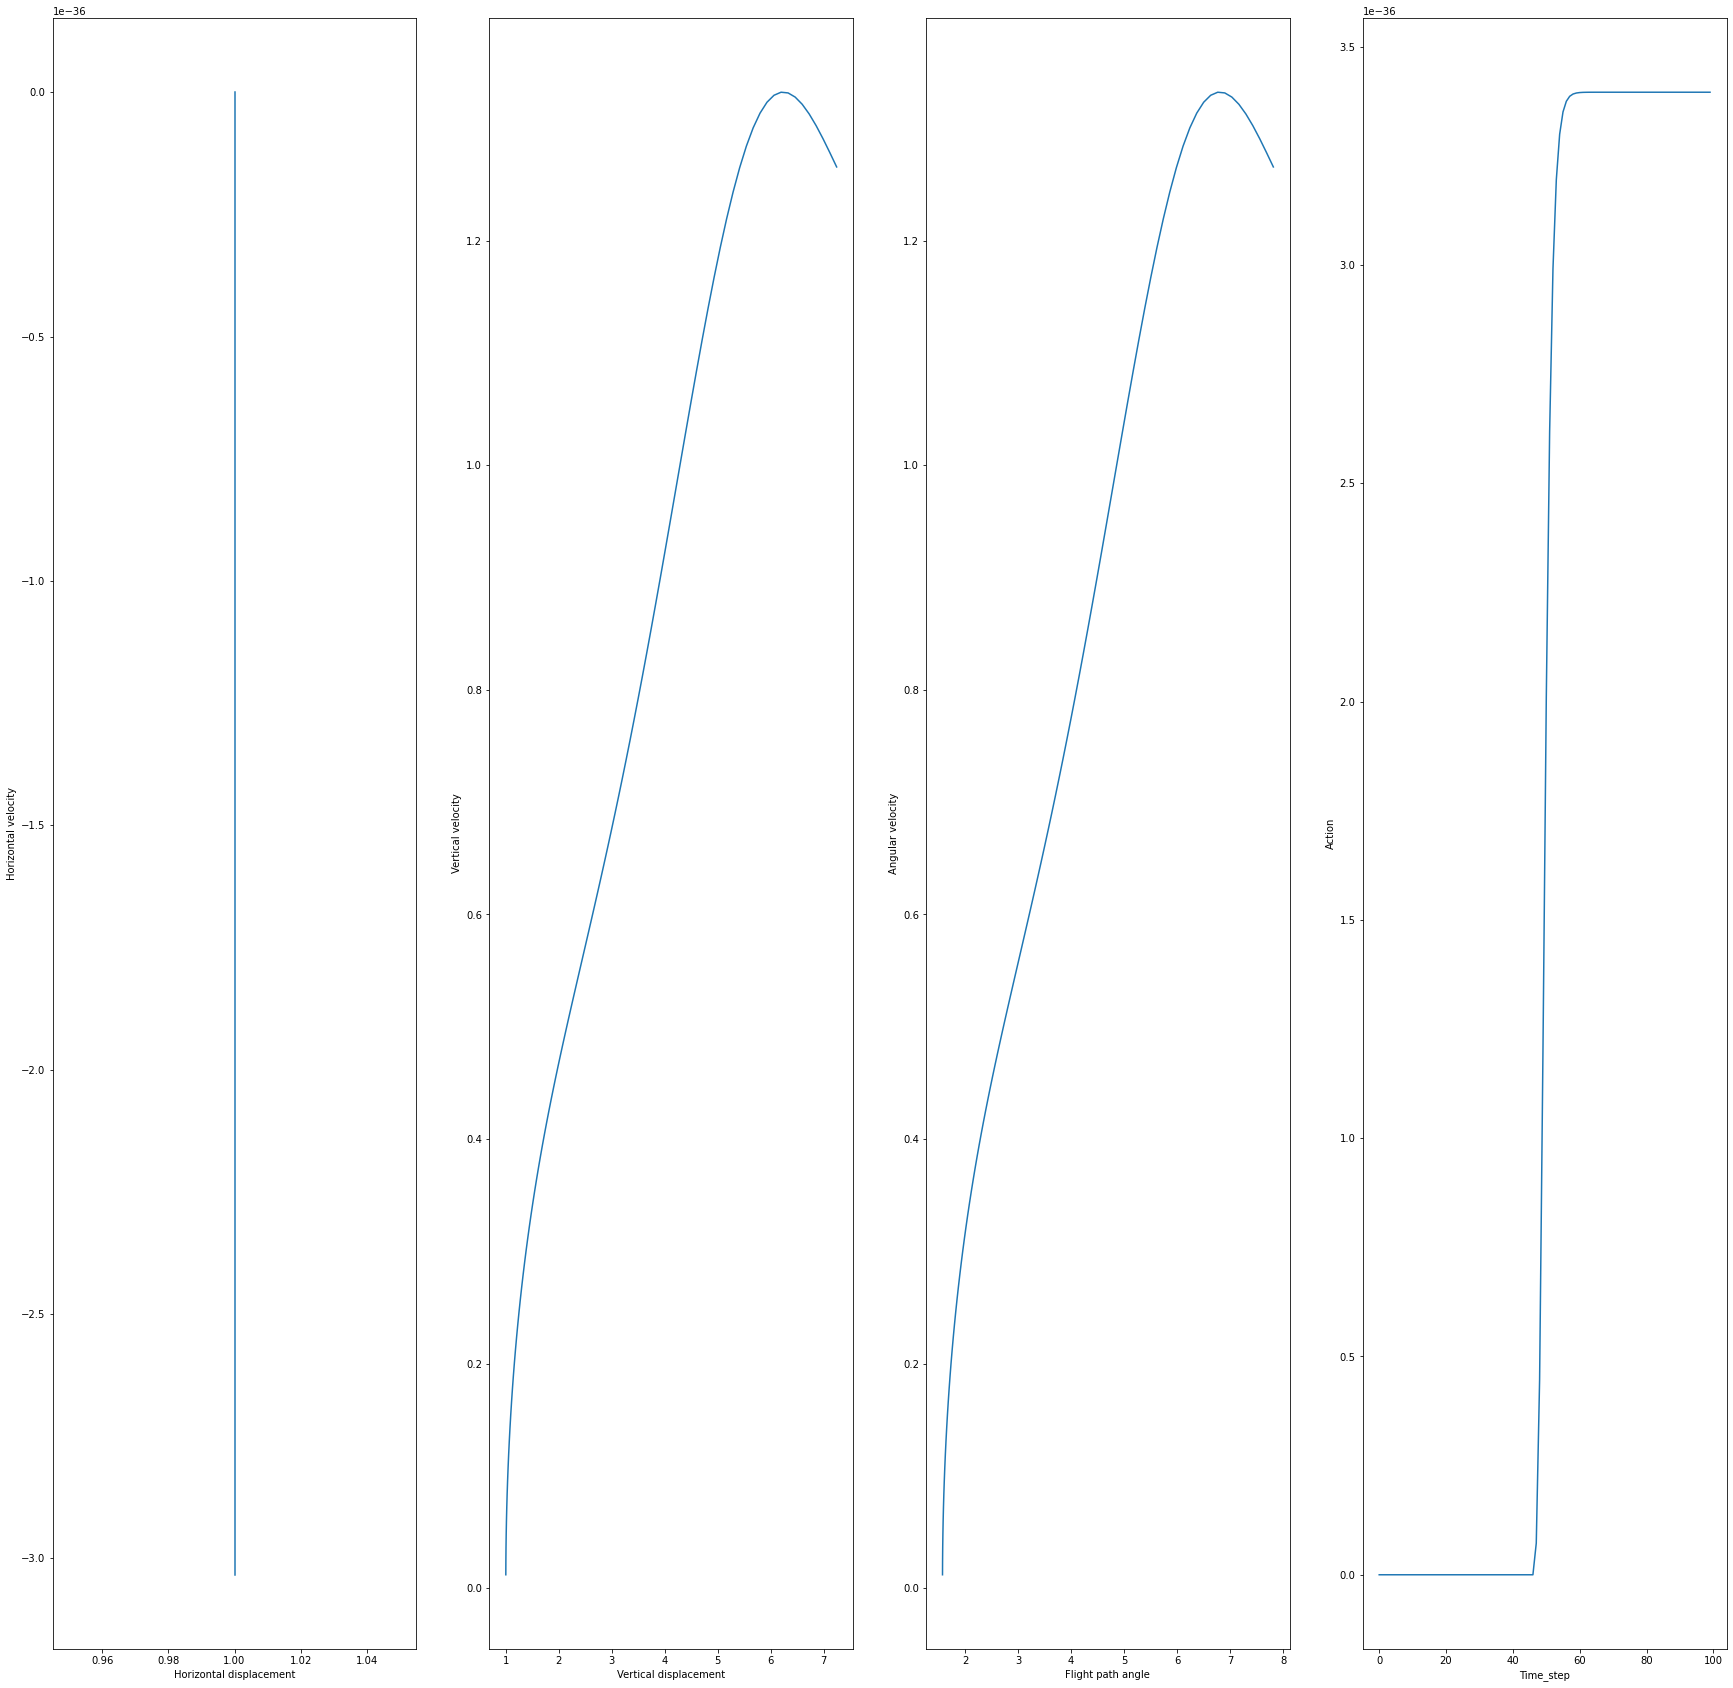

In [251]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 24  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem